##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text==2.7.3

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official==2.7.0

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2022-02-16 16:01:05.667793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 16:01:05.667815: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 62s 1us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed,
)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed,
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-02-16 16:17:30.836261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-16 16:17:30.836290: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-16 16:17:30.836311: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hjpc): /proc/driver/nvidia/version does not exist
2022-02-16 16:17:30.836632: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

2022-02-11 12:25:46.576312: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.99280983 -0.1861186   0.36673835  0.15233682  0.65504444
  0.9681154  -0.9486272   0.00216158 -0.9877732   0.0684272  -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946388  0.3432126   0.33231565 ...  0.21300787  0.7102078
  -0.05771166]
 [-0.28742015  0.31981024 -0.2301858  ...  0.58455074 -0.21329722
   0.7269209 ]
 [-0.66157013  0.6887685  -0.87432927 ...  0.10877253 -0.26173282
   0.47855264]
 ...
 [-0.2256118  -0.28925604 -0.07064401 ...  0.4756601   0.8327715
   0.40025353]
 [-0.29824278 -0.27473143 -0.05450511 ...  0.48849759  1.0955356
   0.18163344]
 [-0.44378197  0.00930723  0.07223766 ...  0.1729009   1.1833246
   0.07897988]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.8498447]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

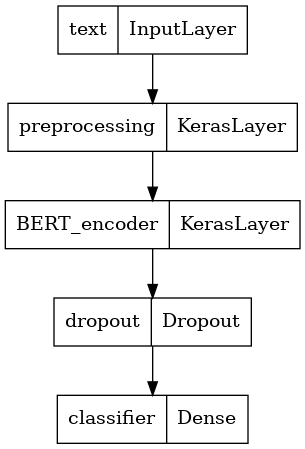

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5



  1/625 [..............................] - ETA: 58:50 - loss: 1.0558 - binary_accuracy: 0.3125


  2/625 [..............................] - ETA: 1:19 - loss: 0.8994 - binary_accuracy: 0.4219 


  3/625 [..............................] - ETA: 1:18 - loss: 0.8639 - binary_accuracy: 0.4896


  4/625 [..............................] - ETA: 1:17 - loss: 0.8776 - binary_accuracy: 0.4766


  5/625 [..............................] - ETA: 1:16 - loss: 0.8811 - binary_accuracy: 0.4750


  6/625 [..............................] - ETA: 1:15 - loss: 0.8885 - binary_accuracy: 0.4740


  7/625 [..............................] - ETA: 1:15 - loss: 0.9009 - binary_accuracy: 0.4598


  8/625 [..............................] - ETA: 1:15 - loss: 0.9062 - binary_accuracy: 0.4570


  9/625 [..............................] - ETA: 1:14 - loss: 0.9021 - binary_accuracy: 0.4653


 10/625 [..............................] - ETA: 1:14 - loss: 0.8834 - binary_accuracy: 0.4750


 11/625 [..............................] - ETA: 1:14 - loss: 0.8789 - binary_accuracy: 0.4773


 12/625 [..............................] - ETA: 1:14 - loss: 0.8667 - binary_accuracy: 0.4844


 13/625 [..............................] - ETA: 1:14 - loss: 0.8548 - binary_accuracy: 0.4952


 14/625 [..............................] - ETA: 1:14 - loss: 0.8513 - binary_accuracy: 0.5022


 15/625 [..............................] - ETA: 1:13 - loss: 0.8470 - binary_accuracy: 0.5042


 16/625 [..............................] - ETA: 1:13 - loss: 0.8510 - binary_accuracy: 0.5059


 17/625 [..............................] - ETA: 1:13 - loss: 0.8423 - binary_accuracy: 0.5129


 18/625 [..............................] - ETA: 1:12 - loss: 0.8426 - binary_accuracy: 0.5104


 19/625 [..............................] - ETA: 1:12 - loss: 0.8379 - binary_accuracy: 0.5115


 20/625 [..............................] - ETA: 1:12 - loss: 0.8281 - binary_accuracy: 0.5203


 21/625 [>.............................] - ETA: 1:12 - loss: 0.8224 - binary_accuracy: 0.5223


 22/625 [>.............................] - ETA: 1:12 - loss: 0.8140 - binary_accuracy: 0.5284


 23/625 [>.............................] - ETA: 1:11 - loss: 0.8094 - binary_accuracy: 0.5285


 24/625 [>.............................] - ETA: 1:11 - loss: 0.8105 - binary_accuracy: 0.5326


 25/625 [>.............................] - ETA: 1:11 - loss: 0.8068 - binary_accuracy: 0.5250


 26/625 [>.............................] - ETA: 1:11 - loss: 0.8029 - binary_accuracy: 0.5276


 27/625 [>.............................] - ETA: 1:11 - loss: 0.7960 - binary_accuracy: 0.5266


 28/625 [>.............................] - ETA: 1:11 - loss: 0.7912 - binary_accuracy: 0.5335


 29/625 [>.............................] - ETA: 1:11 - loss: 0.7840 - binary_accuracy: 0.5356


 30/625 [>.............................] - ETA: 1:10 - loss: 0.7797 - binary_accuracy: 0.5354


 31/625 [>.............................] - ETA: 1:10 - loss: 0.7741 - binary_accuracy: 0.5403


 32/625 [>.............................] - ETA: 1:10 - loss: 0.7708 - binary_accuracy: 0.5439


 33/625 [>.............................] - ETA: 1:10 - loss: 0.7679 - binary_accuracy: 0.5436


 34/625 [>.............................] - ETA: 1:10 - loss: 0.7644 - binary_accuracy: 0.5441


 35/625 [>.............................] - ETA: 1:10 - loss: 0.7626 - binary_accuracy: 0.5437


 36/625 [>.............................] - ETA: 1:09 - loss: 0.7621 - binary_accuracy: 0.5417


 37/625 [>.............................] - ETA: 1:09 - loss: 0.7598 - binary_accuracy: 0.5422


 38/625 [>.............................] - ETA: 1:09 - loss: 0.7565 - binary_accuracy: 0.5419


 39/625 [>.............................] - ETA: 1:09 - loss: 0.7538 - binary_accuracy: 0.5433


 40/625 [>.............................] - ETA: 1:09 - loss: 0.7525 - binary_accuracy: 0.5422


 41/625 [>.............................] - ETA: 1:09 - loss: 0.7499 - binary_accuracy: 0.5450


 42/625 [=>............................] - ETA: 1:08 - loss: 0.7475 - binary_accuracy: 0.5469


 43/625 [=>............................] - ETA: 1:08 - loss: 0.7458 - binary_accuracy: 0.5480


 44/625 [=>............................] - ETA: 1:08 - loss: 0.7441 - binary_accuracy: 0.5462


 45/625 [=>............................] - ETA: 1:08 - loss: 0.7399 - binary_accuracy: 0.5493


 46/625 [=>............................] - ETA: 1:08 - loss: 0.7367 - binary_accuracy: 0.5523


 47/625 [=>............................] - ETA: 1:08 - loss: 0.7348 - binary_accuracy: 0.5532


 48/625 [=>............................] - ETA: 1:08 - loss: 0.7337 - binary_accuracy: 0.5553


 49/625 [=>............................] - ETA: 1:08 - loss: 0.7320 - binary_accuracy: 0.5561


 50/625 [=>............................] - ETA: 1:07 - loss: 0.7282 - binary_accuracy: 0.5594


 51/625 [=>............................] - ETA: 1:07 - loss: 0.7266 - binary_accuracy: 0.5588


 52/625 [=>............................] - ETA: 1:07 - loss: 0.7260 - binary_accuracy: 0.5583


 53/625 [=>............................] - ETA: 1:07 - loss: 0.7255 - binary_accuracy: 0.5578


 54/625 [=>............................] - ETA: 1:07 - loss: 0.7247 - binary_accuracy: 0.5584


 55/625 [=>............................] - ETA: 1:07 - loss: 0.7227 - binary_accuracy: 0.5568


 56/625 [=>............................] - ETA: 1:06 - loss: 0.7197 - binary_accuracy: 0.5586


 57/625 [=>............................] - ETA: 1:06 - loss: 0.7163 - binary_accuracy: 0.5614


 58/625 [=>............................] - ETA: 1:06 - loss: 0.7151 - binary_accuracy: 0.5593


 59/625 [=>............................] - ETA: 1:06 - loss: 0.7128 - binary_accuracy: 0.5614


 60/625 [=>............................] - ETA: 1:06 - loss: 0.7116 - binary_accuracy: 0.5641


 61/625 [=>............................] - ETA: 1:06 - loss: 0.7107 - binary_accuracy: 0.5661


 62/625 [=>............................] - ETA: 1:06 - loss: 0.7099 - binary_accuracy: 0.5680


 63/625 [==>...........................] - ETA: 1:05 - loss: 0.7089 - binary_accuracy: 0.5699


 64/625 [==>...........................] - ETA: 1:05 - loss: 0.7087 - binary_accuracy: 0.5693


 65/625 [==>...........................] - ETA: 1:05 - loss: 0.7081 - binary_accuracy: 0.5702


 66/625 [==>...........................] - ETA: 1:05 - loss: 0.7067 - binary_accuracy: 0.5724


 67/625 [==>...........................] - ETA: 1:05 - loss: 0.7048 - binary_accuracy: 0.5742


 68/625 [==>...........................] - ETA: 1:05 - loss: 0.7034 - binary_accuracy: 0.5777


 69/625 [==>...........................] - ETA: 1:05 - loss: 0.7019 - binary_accuracy: 0.5788


 70/625 [==>...........................] - ETA: 1:05 - loss: 0.7004 - binary_accuracy: 0.5795


 71/625 [==>...........................] - ETA: 1:04 - loss: 0.6997 - binary_accuracy: 0.5801


 72/625 [==>...........................] - ETA: 1:04 - loss: 0.6983 - binary_accuracy: 0.5799


 73/625 [==>...........................] - ETA: 1:04 - loss: 0.6974 - binary_accuracy: 0.5801


 74/625 [==>...........................] - ETA: 1:04 - loss: 0.6968 - binary_accuracy: 0.5802


 75/625 [==>...........................] - ETA: 1:04 - loss: 0.6968 - binary_accuracy: 0.5796


 76/625 [==>...........................] - ETA: 1:04 - loss: 0.6951 - binary_accuracy: 0.5785


 77/625 [==>...........................] - ETA: 1:04 - loss: 0.6948 - binary_accuracy: 0.5779


 78/625 [==>...........................] - ETA: 1:04 - loss: 0.6934 - binary_accuracy: 0.5785


 79/625 [==>...........................] - ETA: 1:03 - loss: 0.6918 - binary_accuracy: 0.5799


 80/625 [==>...........................] - ETA: 1:03 - loss: 0.6904 - binary_accuracy: 0.5805


 81/625 [==>...........................] - ETA: 1:03 - loss: 0.6888 - binary_accuracy: 0.5822


 82/625 [==>...........................] - ETA: 1:03 - loss: 0.6878 - binary_accuracy: 0.5819


 83/625 [==>...........................] - ETA: 1:03 - loss: 0.6868 - binary_accuracy: 0.5843


 84/625 [===>..........................] - ETA: 1:03 - loss: 0.6851 - binary_accuracy: 0.5852


 85/625 [===>..........................] - ETA: 1:03 - loss: 0.6842 - binary_accuracy: 0.5871


 86/625 [===>..........................] - ETA: 1:03 - loss: 0.6831 - binary_accuracy: 0.5883


 87/625 [===>..........................] - ETA: 1:02 - loss: 0.6805 - binary_accuracy: 0.5902


 88/625 [===>..........................] - ETA: 1:02 - loss: 0.6798 - binary_accuracy: 0.5909


 89/625 [===>..........................] - ETA: 1:02 - loss: 0.6792 - binary_accuracy: 0.5913


 90/625 [===>..........................] - ETA: 1:02 - loss: 0.6775 - binary_accuracy: 0.5927


 91/625 [===>..........................] - ETA: 1:02 - loss: 0.6766 - binary_accuracy: 0.5938


 92/625 [===>..........................] - ETA: 1:02 - loss: 0.6751 - binary_accuracy: 0.5951


 93/625 [===>..........................] - ETA: 1:02 - loss: 0.6735 - binary_accuracy: 0.5968


 94/625 [===>..........................] - ETA: 1:02 - loss: 0.6727 - binary_accuracy: 0.5977


 95/625 [===>..........................] - ETA: 1:01 - loss: 0.6744 - binary_accuracy: 0.5970


 96/625 [===>..........................] - ETA: 1:01 - loss: 0.6729 - binary_accuracy: 0.5990


 97/625 [===>..........................] - ETA: 1:01 - loss: 0.6718 - binary_accuracy: 0.6005


 98/625 [===>..........................] - ETA: 1:01 - loss: 0.6711 - binary_accuracy: 0.6001


 99/625 [===>..........................] - ETA: 1:01 - loss: 0.6697 - binary_accuracy: 0.6016


100/625 [===>..........................] - ETA: 1:01 - loss: 0.6685 - binary_accuracy: 0.6019


101/625 [===>..........................] - ETA: 1:01 - loss: 0.6682 - binary_accuracy: 0.6021


102/625 [===>..........................] - ETA: 1:01 - loss: 0.6669 - binary_accuracy: 0.6039


103/625 [===>..........................] - ETA: 1:01 - loss: 0.6650 - binary_accuracy: 0.6050


104/625 [===>..........................] - ETA: 1:00 - loss: 0.6642 - binary_accuracy: 0.6073


105/625 [====>.........................] - ETA: 1:00 - loss: 0.6631 - binary_accuracy: 0.6074


106/625 [====>.........................] - ETA: 1:00 - loss: 0.6623 - binary_accuracy: 0.6088


107/625 [====>.........................] - ETA: 1:00 - loss: 0.6616 - binary_accuracy: 0.6095


108/625 [====>.........................] - ETA: 1:00 - loss: 0.6595 - binary_accuracy: 0.6111


109/625 [====>.........................] - ETA: 1:00 - loss: 0.6596 - binary_accuracy: 0.6110


110/625 [====>.........................] - ETA: 1:00 - loss: 0.6592 - binary_accuracy: 0.6116


111/625 [====>.........................] - ETA: 1:00 - loss: 0.6572 - binary_accuracy: 0.6135


112/625 [====>.........................] - ETA: 1:00 - loss: 0.6560 - binary_accuracy: 0.6144


113/625 [====>.........................] - ETA: 59s - loss: 0.6556 - binary_accuracy: 0.6150 


114/625 [====>.........................] - ETA: 59s - loss: 0.6548 - binary_accuracy: 0.6160


115/625 [====>.........................] - ETA: 59s - loss: 0.6534 - binary_accuracy: 0.6174


116/625 [====>.........................] - ETA: 59s - loss: 0.6523 - binary_accuracy: 0.6183


117/625 [====>.........................] - ETA: 59s - loss: 0.6522 - binary_accuracy: 0.6175


118/625 [====>.........................] - ETA: 59s - loss: 0.6514 - binary_accuracy: 0.6176


119/625 [====>.........................] - ETA: 59s - loss: 0.6500 - binary_accuracy: 0.6182


120/625 [====>.........................] - ETA: 59s - loss: 0.6487 - binary_accuracy: 0.6201


121/625 [====>.........................] - ETA: 58s - loss: 0.6473 - binary_accuracy: 0.6204


122/625 [====>.........................] - ETA: 58s - loss: 0.6464 - binary_accuracy: 0.6206


123/625 [====>.........................] - ETA: 58s - loss: 0.6464 - binary_accuracy: 0.6209


124/625 [====>.........................] - ETA: 58s - loss: 0.6452 - binary_accuracy: 0.6217


125/625 [=====>........................] - ETA: 58s - loss: 0.6444 - binary_accuracy: 0.6230


126/625 [=====>........................] - ETA: 58s - loss: 0.6436 - binary_accuracy: 0.6240


127/625 [=====>........................] - ETA: 58s - loss: 0.6416 - binary_accuracy: 0.6262


128/625 [=====>........................] - ETA: 58s - loss: 0.6395 - binary_accuracy: 0.6282


129/625 [=====>........................] - ETA: 57s - loss: 0.6393 - binary_accuracy: 0.6286


130/625 [=====>........................] - ETA: 57s - loss: 0.6400 - binary_accuracy: 0.6279


131/625 [=====>........................] - ETA: 57s - loss: 0.6390 - binary_accuracy: 0.6286


132/625 [=====>........................] - ETA: 57s - loss: 0.6382 - binary_accuracy: 0.6290


133/625 [=====>........................] - ETA: 57s - loss: 0.6369 - binary_accuracy: 0.6299


134/625 [=====>........................] - ETA: 57s - loss: 0.6362 - binary_accuracy: 0.6308


135/625 [=====>........................] - ETA: 57s - loss: 0.6356 - binary_accuracy: 0.6317


136/625 [=====>........................] - ETA: 57s - loss: 0.6342 - binary_accuracy: 0.6333


137/625 [=====>........................] - ETA: 57s - loss: 0.6330 - binary_accuracy: 0.6339


138/625 [=====>........................] - ETA: 56s - loss: 0.6327 - binary_accuracy: 0.6341


139/625 [=====>........................] - ETA: 56s - loss: 0.6312 - binary_accuracy: 0.6347


140/625 [=====>........................] - ETA: 56s - loss: 0.6324 - binary_accuracy: 0.6346


141/625 [=====>........................] - ETA: 56s - loss: 0.6317 - binary_accuracy: 0.6350


142/625 [=====>........................] - ETA: 56s - loss: 0.6310 - binary_accuracy: 0.6358


143/625 [=====>........................] - ETA: 56s - loss: 0.6306 - binary_accuracy: 0.6364


144/625 [=====>........................] - ETA: 56s - loss: 0.6300 - binary_accuracy: 0.6372


145/625 [=====>........................] - ETA: 56s - loss: 0.6298 - binary_accuracy: 0.6373


146/625 [======>.......................] - ETA: 55s - loss: 0.6291 - binary_accuracy: 0.6383


147/625 [======>.......................] - ETA: 55s - loss: 0.6284 - binary_accuracy: 0.6392


148/625 [======>.......................] - ETA: 55s - loss: 0.6278 - binary_accuracy: 0.6398


149/625 [======>.......................] - ETA: 55s - loss: 0.6267 - binary_accuracy: 0.6409


150/625 [======>.......................] - ETA: 55s - loss: 0.6269 - binary_accuracy: 0.6404


151/625 [======>.......................] - ETA: 55s - loss: 0.6257 - binary_accuracy: 0.6416


152/625 [======>.......................] - ETA: 55s - loss: 0.6251 - binary_accuracy: 0.6419


153/625 [======>.......................] - ETA: 55s - loss: 0.6239 - binary_accuracy: 0.6428


154/625 [======>.......................] - ETA: 55s - loss: 0.6238 - binary_accuracy: 0.6427


155/625 [======>.......................] - ETA: 54s - loss: 0.6235 - binary_accuracy: 0.6423


156/625 [======>.......................] - ETA: 54s - loss: 0.6221 - binary_accuracy: 0.6432


157/625 [======>.......................] - ETA: 54s - loss: 0.6221 - binary_accuracy: 0.6425


158/625 [======>.......................] - ETA: 54s - loss: 0.6215 - binary_accuracy: 0.6430


159/625 [======>.......................] - ETA: 54s - loss: 0.6208 - binary_accuracy: 0.6439


160/625 [======>.......................] - ETA: 54s - loss: 0.6200 - binary_accuracy: 0.6447


161/625 [======>.......................] - ETA: 54s - loss: 0.6192 - binary_accuracy: 0.6456


162/625 [======>.......................] - ETA: 54s - loss: 0.6184 - binary_accuracy: 0.6464


163/625 [======>.......................] - ETA: 53s - loss: 0.6172 - binary_accuracy: 0.6478


164/625 [======>.......................] - ETA: 53s - loss: 0.6167 - binary_accuracy: 0.6479


165/625 [======>.......................] - ETA: 53s - loss: 0.6159 - binary_accuracy: 0.6485


166/625 [======>.......................] - ETA: 53s - loss: 0.6156 - binary_accuracy: 0.6487


167/625 [=======>......................] - ETA: 53s - loss: 0.6148 - binary_accuracy: 0.6484


168/625 [=======>......................] - ETA: 53s - loss: 0.6143 - binary_accuracy: 0.6484


169/625 [=======>......................] - ETA: 53s - loss: 0.6132 - binary_accuracy: 0.6494


170/625 [=======>......................] - ETA: 53s - loss: 0.6121 - binary_accuracy: 0.6506


171/625 [=======>......................] - ETA: 53s - loss: 0.6122 - binary_accuracy: 0.6499


172/625 [=======>......................] - ETA: 52s - loss: 0.6107 - binary_accuracy: 0.6512


173/625 [=======>......................] - ETA: 52s - loss: 0.6107 - binary_accuracy: 0.6521


174/625 [=======>......................] - ETA: 52s - loss: 0.6089 - binary_accuracy: 0.6537


175/625 [=======>......................] - ETA: 52s - loss: 0.6079 - binary_accuracy: 0.6546


176/625 [=======>......................] - ETA: 52s - loss: 0.6073 - binary_accuracy: 0.6547


177/625 [=======>......................] - ETA: 52s - loss: 0.6066 - binary_accuracy: 0.6548


178/625 [=======>......................] - ETA: 52s - loss: 0.6060 - binary_accuracy: 0.6550


179/625 [=======>......................] - ETA: 52s - loss: 0.6057 - binary_accuracy: 0.6549


180/625 [=======>......................] - ETA: 52s - loss: 0.6049 - binary_accuracy: 0.6554


181/625 [=======>......................] - ETA: 51s - loss: 0.6044 - binary_accuracy: 0.6556


182/625 [=======>......................] - ETA: 51s - loss: 0.6039 - binary_accuracy: 0.6559


183/625 [=======>......................] - ETA: 51s - loss: 0.6034 - binary_accuracy: 0.6566


184/625 [=======>......................] - ETA: 51s - loss: 0.6028 - binary_accuracy: 0.6571


185/625 [=======>......................] - ETA: 51s - loss: 0.6015 - binary_accuracy: 0.6578


186/625 [=======>......................] - ETA: 51s - loss: 0.6008 - binary_accuracy: 0.6588


187/625 [=======>......................] - ETA: 51s - loss: 0.5998 - binary_accuracy: 0.6593


188/625 [========>.....................] - ETA: 51s - loss: 0.5986 - binary_accuracy: 0.6604


189/625 [========>.....................] - ETA: 51s - loss: 0.5971 - binary_accuracy: 0.6615


190/625 [========>.....................] - ETA: 50s - loss: 0.5973 - binary_accuracy: 0.6615


191/625 [========>.....................] - ETA: 50s - loss: 0.5961 - binary_accuracy: 0.6625


192/625 [========>.....................] - ETA: 50s - loss: 0.5951 - binary_accuracy: 0.6631


193/625 [========>.....................] - ETA: 50s - loss: 0.5948 - binary_accuracy: 0.6632


194/625 [========>.....................] - ETA: 50s - loss: 0.5943 - binary_accuracy: 0.6633


195/625 [========>.....................] - ETA: 50s - loss: 0.5936 - binary_accuracy: 0.6638


196/625 [========>.....................] - ETA: 50s - loss: 0.5942 - binary_accuracy: 0.6642


197/625 [========>.....................] - ETA: 50s - loss: 0.5943 - binary_accuracy: 0.6642


198/625 [========>.....................] - ETA: 49s - loss: 0.5932 - binary_accuracy: 0.6649


199/625 [========>.....................] - ETA: 49s - loss: 0.5928 - binary_accuracy: 0.6654


200/625 [========>.....................] - ETA: 49s - loss: 0.5920 - binary_accuracy: 0.6658


201/625 [========>.....................] - ETA: 49s - loss: 0.5922 - binary_accuracy: 0.6660


202/625 [========>.....................] - ETA: 49s - loss: 0.5910 - binary_accuracy: 0.6669


203/625 [========>.....................] - ETA: 49s - loss: 0.5909 - binary_accuracy: 0.6670


204/625 [========>.....................] - ETA: 49s - loss: 0.5904 - binary_accuracy: 0.6677


205/625 [========>.....................] - ETA: 49s - loss: 0.5897 - binary_accuracy: 0.6678


206/625 [========>.....................] - ETA: 49s - loss: 0.5893 - binary_accuracy: 0.6678


207/625 [========>.....................] - ETA: 48s - loss: 0.5894 - binary_accuracy: 0.6683


208/625 [========>.....................] - ETA: 48s - loss: 0.5892 - binary_accuracy: 0.6684


209/625 [=========>....................] - ETA: 48s - loss: 0.5883 - binary_accuracy: 0.6694


210/625 [=========>....................] - ETA: 48s - loss: 0.5879 - binary_accuracy: 0.6695


211/625 [=========>....................] - ETA: 48s - loss: 0.5871 - binary_accuracy: 0.6700


212/625 [=========>....................] - ETA: 48s - loss: 0.5870 - binary_accuracy: 0.6705


213/625 [=========>....................] - ETA: 48s - loss: 0.5863 - binary_accuracy: 0.6712


214/625 [=========>....................] - ETA: 48s - loss: 0.5855 - binary_accuracy: 0.6719


215/625 [=========>....................] - ETA: 47s - loss: 0.5857 - binary_accuracy: 0.6718


216/625 [=========>....................] - ETA: 47s - loss: 0.5858 - binary_accuracy: 0.6717


217/625 [=========>....................] - ETA: 47s - loss: 0.5852 - binary_accuracy: 0.6725


218/625 [=========>....................] - ETA: 47s - loss: 0.5841 - binary_accuracy: 0.6729


219/625 [=========>....................] - ETA: 47s - loss: 0.5840 - binary_accuracy: 0.6727


220/625 [=========>....................] - ETA: 47s - loss: 0.5837 - binary_accuracy: 0.6724


221/625 [=========>....................] - ETA: 47s - loss: 0.5828 - binary_accuracy: 0.6729


222/625 [=========>....................] - ETA: 47s - loss: 0.5822 - binary_accuracy: 0.6730


223/625 [=========>....................] - ETA: 47s - loss: 0.5815 - binary_accuracy: 0.6738


224/625 [=========>....................] - ETA: 46s - loss: 0.5817 - binary_accuracy: 0.6738


225/625 [=========>....................] - ETA: 46s - loss: 0.5816 - binary_accuracy: 0.6742


226/625 [=========>....................] - ETA: 46s - loss: 0.5808 - binary_accuracy: 0.6748


227/625 [=========>....................] - ETA: 46s - loss: 0.5799 - binary_accuracy: 0.6757


228/625 [=========>....................] - ETA: 46s - loss: 0.5793 - binary_accuracy: 0.6761


229/625 [=========>....................] - ETA: 46s - loss: 0.5789 - binary_accuracy: 0.6762


230/625 [==========>...................] - ETA: 46s - loss: 0.5781 - binary_accuracy: 0.6768


231/625 [==========>...................] - ETA: 46s - loss: 0.5772 - binary_accuracy: 0.6774


232/625 [==========>...................] - ETA: 45s - loss: 0.5763 - binary_accuracy: 0.6779


233/625 [==========>...................] - ETA: 45s - loss: 0.5753 - binary_accuracy: 0.6782


234/625 [==========>...................] - ETA: 45s - loss: 0.5750 - binary_accuracy: 0.6786


235/625 [==========>...................] - ETA: 45s - loss: 0.5743 - binary_accuracy: 0.6789


236/625 [==========>...................] - ETA: 45s - loss: 0.5746 - binary_accuracy: 0.6785


237/625 [==========>...................] - ETA: 45s - loss: 0.5737 - binary_accuracy: 0.6792


238/625 [==========>...................] - ETA: 45s - loss: 0.5725 - binary_accuracy: 0.6801


239/625 [==========>...................] - ETA: 45s - loss: 0.5724 - binary_accuracy: 0.6799


240/625 [==========>...................] - ETA: 45s - loss: 0.5713 - binary_accuracy: 0.6810


241/625 [==========>...................] - ETA: 44s - loss: 0.5712 - binary_accuracy: 0.6810


242/625 [==========>...................] - ETA: 44s - loss: 0.5700 - binary_accuracy: 0.6817


243/625 [==========>...................] - ETA: 44s - loss: 0.5700 - binary_accuracy: 0.6818


244/625 [==========>...................] - ETA: 44s - loss: 0.5699 - binary_accuracy: 0.6819


245/625 [==========>...................] - ETA: 44s - loss: 0.5694 - binary_accuracy: 0.6825


246/625 [==========>...................] - ETA: 44s - loss: 0.5688 - binary_accuracy: 0.6828


247/625 [==========>...................] - ETA: 44s - loss: 0.5680 - binary_accuracy: 0.6835


248/625 [==========>...................] - ETA: 44s - loss: 0.5678 - binary_accuracy: 0.6838


249/625 [==========>...................] - ETA: 43s - loss: 0.5667 - binary_accuracy: 0.6847


250/625 [===========>..................] - ETA: 43s - loss: 0.5660 - binary_accuracy: 0.6851


251/625 [===========>..................] - ETA: 43s - loss: 0.5659 - binary_accuracy: 0.6854


252/625 [===========>..................] - ETA: 43s - loss: 0.5647 - binary_accuracy: 0.6863


253/625 [===========>..................] - ETA: 43s - loss: 0.5641 - binary_accuracy: 0.6868


254/625 [===========>..................] - ETA: 43s - loss: 0.5638 - binary_accuracy: 0.6873


255/625 [===========>..................] - ETA: 43s - loss: 0.5630 - binary_accuracy: 0.6879


256/625 [===========>..................] - ETA: 43s - loss: 0.5633 - binary_accuracy: 0.6876


257/625 [===========>..................] - ETA: 43s - loss: 0.5630 - binary_accuracy: 0.6879


258/625 [===========>..................] - ETA: 42s - loss: 0.5624 - binary_accuracy: 0.6883


259/625 [===========>..................] - ETA: 42s - loss: 0.5620 - binary_accuracy: 0.6886


260/625 [===========>..................] - ETA: 42s - loss: 0.5615 - binary_accuracy: 0.6891


261/625 [===========>..................] - ETA: 42s - loss: 0.5606 - binary_accuracy: 0.6897


262/625 [===========>..................] - ETA: 42s - loss: 0.5600 - binary_accuracy: 0.6900


263/625 [===========>..................] - ETA: 42s - loss: 0.5602 - binary_accuracy: 0.6898


264/625 [===========>..................] - ETA: 42s - loss: 0.5602 - binary_accuracy: 0.6900


265/625 [===========>..................] - ETA: 42s - loss: 0.5590 - binary_accuracy: 0.6909


266/625 [===========>..................] - ETA: 42s - loss: 0.5581 - binary_accuracy: 0.6916


267/625 [===========>..................] - ETA: 41s - loss: 0.5579 - binary_accuracy: 0.6919


268/625 [===========>..................] - ETA: 41s - loss: 0.5572 - binary_accuracy: 0.6926


269/625 [===========>..................] - ETA: 41s - loss: 0.5569 - binary_accuracy: 0.6932


270/625 [===========>..................] - ETA: 41s - loss: 0.5566 - binary_accuracy: 0.6935


271/625 [============>.................] - ETA: 41s - loss: 0.5560 - binary_accuracy: 0.6937


272/625 [============>.................] - ETA: 41s - loss: 0.5559 - binary_accuracy: 0.6940


273/625 [============>.................] - ETA: 41s - loss: 0.5568 - binary_accuracy: 0.6933


274/625 [============>.................] - ETA: 41s - loss: 0.5569 - binary_accuracy: 0.6933


275/625 [============>.................] - ETA: 40s - loss: 0.5564 - binary_accuracy: 0.6936


276/625 [============>.................] - ETA: 40s - loss: 0.5559 - binary_accuracy: 0.6942


277/625 [============>.................] - ETA: 40s - loss: 0.5550 - binary_accuracy: 0.6946


278/625 [============>.................] - ETA: 40s - loss: 0.5544 - binary_accuracy: 0.6949


279/625 [============>.................] - ETA: 40s - loss: 0.5538 - binary_accuracy: 0.6955


280/625 [============>.................] - ETA: 40s - loss: 0.5535 - binary_accuracy: 0.6960


281/625 [============>.................] - ETA: 40s - loss: 0.5533 - binary_accuracy: 0.6965


282/625 [============>.................] - ETA: 40s - loss: 0.5531 - binary_accuracy: 0.6967


283/625 [============>.................] - ETA: 40s - loss: 0.5526 - binary_accuracy: 0.6969


284/625 [============>.................] - ETA: 39s - loss: 0.5518 - binary_accuracy: 0.6975


285/625 [============>.................] - ETA: 39s - loss: 0.5517 - binary_accuracy: 0.6976


286/625 [============>.................] - ETA: 39s - loss: 0.5519 - binary_accuracy: 0.6977


287/625 [============>.................] - ETA: 39s - loss: 0.5519 - binary_accuracy: 0.6980


288/625 [============>.................] - ETA: 39s - loss: 0.5526 - binary_accuracy: 0.6976


289/625 [============>.................] - ETA: 39s - loss: 0.5524 - binary_accuracy: 0.6979


290/625 [============>.................] - ETA: 39s - loss: 0.5520 - binary_accuracy: 0.6984


291/625 [============>.................] - ETA: 39s - loss: 0.5519 - binary_accuracy: 0.6986


292/625 [=============>................] - ETA: 38s - loss: 0.5517 - binary_accuracy: 0.6985


293/625 [=============>................] - ETA: 38s - loss: 0.5516 - binary_accuracy: 0.6989


294/625 [=============>................] - ETA: 38s - loss: 0.5513 - binary_accuracy: 0.6993


295/625 [=============>................] - ETA: 38s - loss: 0.5512 - binary_accuracy: 0.6993


296/625 [=============>................] - ETA: 38s - loss: 0.5507 - binary_accuracy: 0.6997


297/625 [=============>................] - ETA: 38s - loss: 0.5502 - binary_accuracy: 0.7002


298/625 [=============>................] - ETA: 38s - loss: 0.5497 - binary_accuracy: 0.7007


299/625 [=============>................] - ETA: 38s - loss: 0.5497 - binary_accuracy: 0.7007


300/625 [=============>................] - ETA: 38s - loss: 0.5493 - binary_accuracy: 0.7008


301/625 [=============>................] - ETA: 37s - loss: 0.5490 - binary_accuracy: 0.7012


302/625 [=============>................] - ETA: 37s - loss: 0.5489 - binary_accuracy: 0.7014


303/625 [=============>................] - ETA: 37s - loss: 0.5491 - binary_accuracy: 0.7014


304/625 [=============>................] - ETA: 37s - loss: 0.5485 - binary_accuracy: 0.7016


305/625 [=============>................] - ETA: 37s - loss: 0.5484 - binary_accuracy: 0.7017


306/625 [=============>................] - ETA: 37s - loss: 0.5488 - binary_accuracy: 0.7015


307/625 [=============>................] - ETA: 37s - loss: 0.5482 - binary_accuracy: 0.7016


308/625 [=============>................] - ETA: 37s - loss: 0.5484 - binary_accuracy: 0.7015


309/625 [=============>................] - ETA: 37s - loss: 0.5479 - binary_accuracy: 0.7019


310/625 [=============>................] - ETA: 36s - loss: 0.5474 - binary_accuracy: 0.7022


311/625 [=============>................] - ETA: 36s - loss: 0.5474 - binary_accuracy: 0.7025


312/625 [=============>................] - ETA: 36s - loss: 0.5469 - binary_accuracy: 0.7027


313/625 [==============>...............] - ETA: 36s - loss: 0.5466 - binary_accuracy: 0.7032


314/625 [==============>...............] - ETA: 36s - loss: 0.5458 - binary_accuracy: 0.7037


315/625 [==============>...............] - ETA: 36s - loss: 0.5451 - binary_accuracy: 0.7044


316/625 [==============>...............] - ETA: 36s - loss: 0.5446 - binary_accuracy: 0.7048


317/625 [==============>...............] - ETA: 36s - loss: 0.5437 - binary_accuracy: 0.7051


318/625 [==============>...............] - ETA: 35s - loss: 0.5435 - binary_accuracy: 0.7053


319/625 [==============>...............] - ETA: 35s - loss: 0.5429 - binary_accuracy: 0.7057


320/625 [==============>...............] - ETA: 35s - loss: 0.5430 - binary_accuracy: 0.7057


321/625 [==============>...............] - ETA: 35s - loss: 0.5429 - binary_accuracy: 0.7059


322/625 [==============>...............] - ETA: 35s - loss: 0.5430 - binary_accuracy: 0.7061


323/625 [==============>...............] - ETA: 35s - loss: 0.5424 - binary_accuracy: 0.7064


324/625 [==============>...............] - ETA: 35s - loss: 0.5417 - binary_accuracy: 0.7069


325/625 [==============>...............] - ETA: 35s - loss: 0.5416 - binary_accuracy: 0.7071


326/625 [==============>...............] - ETA: 35s - loss: 0.5414 - binary_accuracy: 0.7072


327/625 [==============>...............] - ETA: 34s - loss: 0.5410 - binary_accuracy: 0.7078


328/625 [==============>...............] - ETA: 34s - loss: 0.5409 - binary_accuracy: 0.7080


329/625 [==============>...............] - ETA: 34s - loss: 0.5408 - binary_accuracy: 0.7082


330/625 [==============>...............] - ETA: 34s - loss: 0.5402 - binary_accuracy: 0.7085


331/625 [==============>...............] - ETA: 34s - loss: 0.5399 - binary_accuracy: 0.7085


332/625 [==============>...............] - ETA: 34s - loss: 0.5397 - binary_accuracy: 0.7083


333/625 [==============>...............] - ETA: 34s - loss: 0.5403 - binary_accuracy: 0.7079


334/625 [===============>..............] - ETA: 34s - loss: 0.5398 - binary_accuracy: 0.7077


335/625 [===============>..............] - ETA: 33s - loss: 0.5395 - binary_accuracy: 0.7077


336/625 [===============>..............] - ETA: 33s - loss: 0.5394 - binary_accuracy: 0.7076


337/625 [===============>..............] - ETA: 33s - loss: 0.5392 - binary_accuracy: 0.7076


338/625 [===============>..............] - ETA: 33s - loss: 0.5391 - binary_accuracy: 0.7078


339/625 [===============>..............] - ETA: 33s - loss: 0.5388 - binary_accuracy: 0.7081


340/625 [===============>..............] - ETA: 33s - loss: 0.5382 - binary_accuracy: 0.7086


341/625 [===============>..............] - ETA: 33s - loss: 0.5382 - binary_accuracy: 0.7089


342/625 [===============>..............] - ETA: 33s - loss: 0.5376 - binary_accuracy: 0.7095


343/625 [===============>..............] - ETA: 33s - loss: 0.5373 - binary_accuracy: 0.7099


344/625 [===============>..............] - ETA: 32s - loss: 0.5364 - binary_accuracy: 0.7108


345/625 [===============>..............] - ETA: 32s - loss: 0.5367 - binary_accuracy: 0.7106


346/625 [===============>..............] - ETA: 32s - loss: 0.5376 - binary_accuracy: 0.7103


347/625 [===============>..............] - ETA: 32s - loss: 0.5371 - binary_accuracy: 0.7106


348/625 [===============>..............] - ETA: 32s - loss: 0.5371 - binary_accuracy: 0.7108


349/625 [===============>..............] - ETA: 32s - loss: 0.5370 - binary_accuracy: 0.7110


350/625 [===============>..............] - ETA: 32s - loss: 0.5367 - binary_accuracy: 0.7111


351/625 [===============>..............] - ETA: 32s - loss: 0.5360 - binary_accuracy: 0.7115


352/625 [===============>..............] - ETA: 32s - loss: 0.5360 - binary_accuracy: 0.7117


353/625 [===============>..............] - ETA: 31s - loss: 0.5364 - binary_accuracy: 0.7118


354/625 [===============>..............] - ETA: 31s - loss: 0.5358 - binary_accuracy: 0.7121


355/625 [================>.............] - ETA: 31s - loss: 0.5354 - binary_accuracy: 0.7124


356/625 [================>.............] - ETA: 31s - loss: 0.5349 - binary_accuracy: 0.7129


357/625 [================>.............] - ETA: 31s - loss: 0.5342 - binary_accuracy: 0.7132


358/625 [================>.............] - ETA: 31s - loss: 0.5335 - binary_accuracy: 0.7137


359/625 [================>.............] - ETA: 31s - loss: 0.5330 - binary_accuracy: 0.7142


360/625 [================>.............] - ETA: 31s - loss: 0.5324 - binary_accuracy: 0.7147


361/625 [================>.............] - ETA: 30s - loss: 0.5321 - binary_accuracy: 0.7146


362/625 [================>.............] - ETA: 30s - loss: 0.5317 - binary_accuracy: 0.7148


363/625 [================>.............] - ETA: 30s - loss: 0.5312 - binary_accuracy: 0.7150


364/625 [================>.............] - ETA: 30s - loss: 0.5313 - binary_accuracy: 0.7151


365/625 [================>.............] - ETA: 30s - loss: 0.5307 - binary_accuracy: 0.7156


366/625 [================>.............] - ETA: 30s - loss: 0.5300 - binary_accuracy: 0.7160


367/625 [================>.............] - ETA: 30s - loss: 0.5291 - binary_accuracy: 0.7166


368/625 [================>.............] - ETA: 30s - loss: 0.5288 - binary_accuracy: 0.7171


369/625 [================>.............] - ETA: 30s - loss: 0.5285 - binary_accuracy: 0.7171


370/625 [================>.............] - ETA: 29s - loss: 0.5282 - binary_accuracy: 0.7176


371/625 [================>.............] - ETA: 29s - loss: 0.5276 - binary_accuracy: 0.7179


372/625 [================>.............] - ETA: 29s - loss: 0.5272 - binary_accuracy: 0.7183


373/625 [================>.............] - ETA: 29s - loss: 0.5270 - binary_accuracy: 0.7186


374/625 [================>.............] - ETA: 29s - loss: 0.5269 - binary_accuracy: 0.7188


375/625 [=================>............] - ETA: 29s - loss: 0.5262 - binary_accuracy: 0.7194


376/625 [=================>............] - ETA: 29s - loss: 0.5258 - binary_accuracy: 0.7197


377/625 [=================>............] - ETA: 29s - loss: 0.5260 - binary_accuracy: 0.7196


378/625 [=================>............] - ETA: 28s - loss: 0.5256 - binary_accuracy: 0.7198


379/625 [=================>............] - ETA: 28s - loss: 0.5250 - binary_accuracy: 0.7202


380/625 [=================>............] - ETA: 28s - loss: 0.5249 - binary_accuracy: 0.7204


381/625 [=================>............] - ETA: 28s - loss: 0.5241 - binary_accuracy: 0.7210


382/625 [=================>............] - ETA: 28s - loss: 0.5237 - binary_accuracy: 0.7211


383/625 [=================>............] - ETA: 28s - loss: 0.5231 - binary_accuracy: 0.7213


384/625 [=================>............] - ETA: 28s - loss: 0.5232 - binary_accuracy: 0.7214


385/625 [=================>............] - ETA: 28s - loss: 0.5234 - binary_accuracy: 0.7216


386/625 [=================>............] - ETA: 28s - loss: 0.5232 - binary_accuracy: 0.7218


387/625 [=================>............] - ETA: 27s - loss: 0.5229 - binary_accuracy: 0.7222


388/625 [=================>............] - ETA: 27s - loss: 0.5224 - binary_accuracy: 0.7226


389/625 [=================>............] - ETA: 27s - loss: 0.5215 - binary_accuracy: 0.7231


390/625 [=================>............] - ETA: 27s - loss: 0.5210 - binary_accuracy: 0.7233


391/625 [=================>............] - ETA: 27s - loss: 0.5204 - binary_accuracy: 0.7235


392/625 [=================>............] - ETA: 27s - loss: 0.5204 - binary_accuracy: 0.7237


393/625 [=================>............] - ETA: 27s - loss: 0.5205 - binary_accuracy: 0.7237


394/625 [=================>............] - ETA: 27s - loss: 0.5198 - binary_accuracy: 0.7241


395/625 [=================>............] - ETA: 26s - loss: 0.5195 - binary_accuracy: 0.7244


396/625 [==================>...........] - ETA: 26s - loss: 0.5194 - binary_accuracy: 0.7243


397/625 [==================>...........] - ETA: 26s - loss: 0.5191 - binary_accuracy: 0.7244


398/625 [==================>...........] - ETA: 26s - loss: 0.5186 - binary_accuracy: 0.7247


399/625 [==================>...........] - ETA: 26s - loss: 0.5183 - binary_accuracy: 0.7251


400/625 [==================>...........] - ETA: 26s - loss: 0.5183 - binary_accuracy: 0.7253


401/625 [==================>...........] - ETA: 26s - loss: 0.5178 - binary_accuracy: 0.7256


402/625 [==================>...........] - ETA: 26s - loss: 0.5181 - binary_accuracy: 0.7255


403/625 [==================>...........] - ETA: 26s - loss: 0.5178 - binary_accuracy: 0.7258


404/625 [==================>...........] - ETA: 25s - loss: 0.5180 - binary_accuracy: 0.7258


405/625 [==================>...........] - ETA: 25s - loss: 0.5174 - binary_accuracy: 0.7262


406/625 [==================>...........] - ETA: 25s - loss: 0.5176 - binary_accuracy: 0.7262


407/625 [==================>...........] - ETA: 25s - loss: 0.5171 - binary_accuracy: 0.7265


408/625 [==================>...........] - ETA: 25s - loss: 0.5168 - binary_accuracy: 0.7266


409/625 [==================>...........] - ETA: 25s - loss: 0.5162 - binary_accuracy: 0.7270


410/625 [==================>...........] - ETA: 25s - loss: 0.5161 - binary_accuracy: 0.7271


411/625 [==================>...........] - ETA: 25s - loss: 0.5161 - binary_accuracy: 0.7272


412/625 [==================>...........] - ETA: 24s - loss: 0.5158 - binary_accuracy: 0.7272


413/625 [==================>...........] - ETA: 24s - loss: 0.5154 - binary_accuracy: 0.7275


414/625 [==================>...........] - ETA: 24s - loss: 0.5162 - binary_accuracy: 0.7274


415/625 [==================>...........] - ETA: 24s - loss: 0.5157 - binary_accuracy: 0.7277


416/625 [==================>...........] - ETA: 24s - loss: 0.5152 - binary_accuracy: 0.7280


417/625 [===================>..........] - ETA: 24s - loss: 0.5150 - binary_accuracy: 0.7281


418/625 [===================>..........] - ETA: 24s - loss: 0.5146 - binary_accuracy: 0.7285


419/625 [===================>..........] - ETA: 24s - loss: 0.5148 - binary_accuracy: 0.7285


420/625 [===================>..........] - ETA: 24s - loss: 0.5144 - binary_accuracy: 0.7289


421/625 [===================>..........] - ETA: 23s - loss: 0.5140 - binary_accuracy: 0.7292


422/625 [===================>..........] - ETA: 23s - loss: 0.5137 - binary_accuracy: 0.7294


423/625 [===================>..........] - ETA: 23s - loss: 0.5135 - binary_accuracy: 0.7295


424/625 [===================>..........] - ETA: 23s - loss: 0.5133 - binary_accuracy: 0.7297


425/625 [===================>..........] - ETA: 23s - loss: 0.5128 - binary_accuracy: 0.7299


426/625 [===================>..........] - ETA: 23s - loss: 0.5131 - binary_accuracy: 0.7298


427/625 [===================>..........] - ETA: 23s - loss: 0.5130 - binary_accuracy: 0.7297


428/625 [===================>..........] - ETA: 23s - loss: 0.5126 - binary_accuracy: 0.7300


429/625 [===================>..........] - ETA: 22s - loss: 0.5123 - binary_accuracy: 0.7300


430/625 [===================>..........] - ETA: 22s - loss: 0.5117 - binary_accuracy: 0.7303


431/625 [===================>..........] - ETA: 22s - loss: 0.5114 - binary_accuracy: 0.7306


432/625 [===================>..........] - ETA: 22s - loss: 0.5114 - binary_accuracy: 0.7305


433/625 [===================>..........] - ETA: 22s - loss: 0.5114 - binary_accuracy: 0.7305


434/625 [===================>..........] - ETA: 22s - loss: 0.5115 - binary_accuracy: 0.7307


435/625 [===================>..........] - ETA: 22s - loss: 0.5111 - binary_accuracy: 0.7310


436/625 [===================>..........] - ETA: 22s - loss: 0.5107 - binary_accuracy: 0.7314


437/625 [===================>..........] - ETA: 22s - loss: 0.5104 - binary_accuracy: 0.7316


438/625 [====================>.........] - ETA: 21s - loss: 0.5102 - binary_accuracy: 0.7317


439/625 [====================>.........] - ETA: 21s - loss: 0.5100 - binary_accuracy: 0.7319


440/625 [====================>.........] - ETA: 21s - loss: 0.5097 - binary_accuracy: 0.7319


441/625 [====================>.........] - ETA: 21s - loss: 0.5093 - binary_accuracy: 0.7321


442/625 [====================>.........] - ETA: 21s - loss: 0.5094 - binary_accuracy: 0.7319


443/625 [====================>.........] - ETA: 21s - loss: 0.5092 - binary_accuracy: 0.7321


444/625 [====================>.........] - ETA: 21s - loss: 0.5091 - binary_accuracy: 0.7322


445/625 [====================>.........] - ETA: 21s - loss: 0.5087 - binary_accuracy: 0.7324


446/625 [====================>.........] - ETA: 20s - loss: 0.5083 - binary_accuracy: 0.7326


447/625 [====================>.........] - ETA: 20s - loss: 0.5081 - binary_accuracy: 0.7328


448/625 [====================>.........] - ETA: 20s - loss: 0.5076 - binary_accuracy: 0.7331


449/625 [====================>.........] - ETA: 20s - loss: 0.5071 - binary_accuracy: 0.7335


450/625 [====================>.........] - ETA: 20s - loss: 0.5072 - binary_accuracy: 0.7337


451/625 [====================>.........] - ETA: 20s - loss: 0.5070 - binary_accuracy: 0.7339


452/625 [====================>.........] - ETA: 20s - loss: 0.5067 - binary_accuracy: 0.7342


453/625 [====================>.........] - ETA: 20s - loss: 0.5062 - binary_accuracy: 0.7343


454/625 [====================>.........] - ETA: 20s - loss: 0.5059 - binary_accuracy: 0.7347


455/625 [====================>.........] - ETA: 19s - loss: 0.5057 - binary_accuracy: 0.7351


456/625 [====================>.........] - ETA: 19s - loss: 0.5054 - binary_accuracy: 0.7355


457/625 [====================>.........] - ETA: 19s - loss: 0.5055 - binary_accuracy: 0.7354


458/625 [====================>.........] - ETA: 19s - loss: 0.5050 - binary_accuracy: 0.7357


459/625 [=====================>........] - ETA: 19s - loss: 0.5050 - binary_accuracy: 0.7358


460/625 [=====================>........] - ETA: 19s - loss: 0.5045 - binary_accuracy: 0.7358


461/625 [=====================>........] - ETA: 19s - loss: 0.5044 - binary_accuracy: 0.7358


462/625 [=====================>........] - ETA: 19s - loss: 0.5042 - binary_accuracy: 0.7360


463/625 [=====================>........] - ETA: 18s - loss: 0.5042 - binary_accuracy: 0.7362


464/625 [=====================>........] - ETA: 18s - loss: 0.5042 - binary_accuracy: 0.7364


465/625 [=====================>........] - ETA: 18s - loss: 0.5040 - binary_accuracy: 0.7365


466/625 [=====================>........] - ETA: 18s - loss: 0.5039 - binary_accuracy: 0.7363


467/625 [=====================>........] - ETA: 18s - loss: 0.5037 - binary_accuracy: 0.7363


468/625 [=====================>........] - ETA: 18s - loss: 0.5036 - binary_accuracy: 0.7364


469/625 [=====================>........] - ETA: 18s - loss: 0.5031 - binary_accuracy: 0.7366


470/625 [=====================>........] - ETA: 18s - loss: 0.5029 - binary_accuracy: 0.7368


471/625 [=====================>........] - ETA: 18s - loss: 0.5024 - binary_accuracy: 0.7371


472/625 [=====================>........] - ETA: 17s - loss: 0.5026 - binary_accuracy: 0.7371


473/625 [=====================>........] - ETA: 17s - loss: 0.5023 - binary_accuracy: 0.7373


474/625 [=====================>........] - ETA: 17s - loss: 0.5020 - binary_accuracy: 0.7374


475/625 [=====================>........] - ETA: 17s - loss: 0.5018 - binary_accuracy: 0.7375


476/625 [=====================>........] - ETA: 17s - loss: 0.5013 - binary_accuracy: 0.7377


477/625 [=====================>........] - ETA: 17s - loss: 0.5013 - binary_accuracy: 0.7377


478/625 [=====================>........] - ETA: 17s - loss: 0.5012 - binary_accuracy: 0.7377


479/625 [=====================>........] - ETA: 17s - loss: 0.5014 - binary_accuracy: 0.7378


480/625 [======================>.......] - ETA: 16s - loss: 0.5011 - binary_accuracy: 0.7381


481/625 [======================>.......] - ETA: 16s - loss: 0.5015 - binary_accuracy: 0.7380


482/625 [======================>.......] - ETA: 16s - loss: 0.5015 - binary_accuracy: 0.7380


483/625 [======================>.......] - ETA: 16s - loss: 0.5013 - binary_accuracy: 0.7381


484/625 [======================>.......] - ETA: 16s - loss: 0.5008 - binary_accuracy: 0.7384


485/625 [======================>.......] - ETA: 16s - loss: 0.5007 - binary_accuracy: 0.7385


486/625 [======================>.......] - ETA: 16s - loss: 0.5002 - binary_accuracy: 0.7388


487/625 [======================>.......] - ETA: 16s - loss: 0.4999 - binary_accuracy: 0.7391


488/625 [======================>.......] - ETA: 16s - loss: 0.4994 - binary_accuracy: 0.7394


489/625 [======================>.......] - ETA: 15s - loss: 0.4988 - binary_accuracy: 0.7396


490/625 [======================>.......] - ETA: 15s - loss: 0.4986 - binary_accuracy: 0.7399


491/625 [======================>.......] - ETA: 15s - loss: 0.4980 - binary_accuracy: 0.7402


492/625 [======================>.......] - ETA: 15s - loss: 0.4974 - binary_accuracy: 0.7405


493/625 [======================>.......] - ETA: 15s - loss: 0.4971 - binary_accuracy: 0.7407


494/625 [======================>.......] - ETA: 15s - loss: 0.4969 - binary_accuracy: 0.7409


495/625 [======================>.......] - ETA: 15s - loss: 0.4964 - binary_accuracy: 0.7413


496/625 [======================>.......] - ETA: 15s - loss: 0.4960 - binary_accuracy: 0.7414


497/625 [======================>.......] - ETA: 14s - loss: 0.4960 - binary_accuracy: 0.7414


498/625 [======================>.......] - ETA: 14s - loss: 0.4961 - binary_accuracy: 0.7413


499/625 [======================>.......] - ETA: 14s - loss: 0.4956 - binary_accuracy: 0.7415


500/625 [=======================>......] - ETA: 14s - loss: 0.4955 - binary_accuracy: 0.7416


501/625 [=======================>......] - ETA: 14s - loss: 0.4953 - binary_accuracy: 0.7416


502/625 [=======================>......] - ETA: 14s - loss: 0.4948 - binary_accuracy: 0.7420


503/625 [=======================>......] - ETA: 14s - loss: 0.4950 - binary_accuracy: 0.7420


504/625 [=======================>......] - ETA: 14s - loss: 0.4947 - binary_accuracy: 0.7422


505/625 [=======================>......] - ETA: 14s - loss: 0.4943 - binary_accuracy: 0.7426


506/625 [=======================>......] - ETA: 13s - loss: 0.4943 - binary_accuracy: 0.7427


507/625 [=======================>......] - ETA: 13s - loss: 0.4939 - binary_accuracy: 0.7429


508/625 [=======================>......] - ETA: 13s - loss: 0.4937 - binary_accuracy: 0.7432


509/625 [=======================>......] - ETA: 13s - loss: 0.4934 - binary_accuracy: 0.7434


510/625 [=======================>......] - ETA: 13s - loss: 0.4930 - binary_accuracy: 0.7436


511/625 [=======================>......] - ETA: 13s - loss: 0.4926 - binary_accuracy: 0.7439


512/625 [=======================>......] - ETA: 13s - loss: 0.4924 - binary_accuracy: 0.7441


513/625 [=======================>......] - ETA: 13s - loss: 0.4920 - binary_accuracy: 0.7442


514/625 [=======================>......] - ETA: 12s - loss: 0.4923 - binary_accuracy: 0.7439


515/625 [=======================>......] - ETA: 12s - loss: 0.4924 - binary_accuracy: 0.7439


516/625 [=======================>......] - ETA: 12s - loss: 0.4922 - binary_accuracy: 0.7439


517/625 [=======================>......] - ETA: 12s - loss: 0.4923 - binary_accuracy: 0.7439


518/625 [=======================>......] - ETA: 12s - loss: 0.4921 - binary_accuracy: 0.7440


519/625 [=======================>......] - ETA: 12s - loss: 0.4919 - binary_accuracy: 0.7440


520/625 [=======================>......] - ETA: 12s - loss: 0.4918 - binary_accuracy: 0.7440


521/625 [========================>.....] - ETA: 12s - loss: 0.4915 - binary_accuracy: 0.7441


522/625 [========================>.....] - ETA: 12s - loss: 0.4911 - binary_accuracy: 0.7442


523/625 [========================>.....] - ETA: 11s - loss: 0.4908 - binary_accuracy: 0.7443


524/625 [========================>.....] - ETA: 11s - loss: 0.4906 - binary_accuracy: 0.7442


525/625 [========================>.....] - ETA: 11s - loss: 0.4908 - binary_accuracy: 0.7443


526/625 [========================>.....] - ETA: 11s - loss: 0.4906 - binary_accuracy: 0.7446


527/625 [========================>.....] - ETA: 11s - loss: 0.4906 - binary_accuracy: 0.7447


528/625 [========================>.....] - ETA: 11s - loss: 0.4910 - binary_accuracy: 0.7448


529/625 [========================>.....] - ETA: 11s - loss: 0.4907 - binary_accuracy: 0.7450


530/625 [========================>.....] - ETA: 11s - loss: 0.4904 - binary_accuracy: 0.7452


531/625 [========================>.....] - ETA: 11s - loss: 0.4904 - binary_accuracy: 0.7449


532/625 [========================>.....] - ETA: 10s - loss: 0.4903 - binary_accuracy: 0.7449


533/625 [========================>.....] - ETA: 10s - loss: 0.4900 - binary_accuracy: 0.7451


534/625 [========================>.....] - ETA: 10s - loss: 0.4901 - binary_accuracy: 0.7451


535/625 [========================>.....] - ETA: 10s - loss: 0.4898 - binary_accuracy: 0.7453


536/625 [========================>.....] - ETA: 10s - loss: 0.4897 - binary_accuracy: 0.7455


537/625 [========================>.....] - ETA: 10s - loss: 0.4895 - binary_accuracy: 0.7455


538/625 [========================>.....] - ETA: 10s - loss: 0.4894 - binary_accuracy: 0.7456


539/625 [========================>.....] - ETA: 10s - loss: 0.4892 - binary_accuracy: 0.7456


540/625 [========================>.....] - ETA: 9s - loss: 0.4891 - binary_accuracy: 0.7457 


541/625 [========================>.....] - ETA: 9s - loss: 0.4890 - binary_accuracy: 0.7456


542/625 [=========================>....] - ETA: 9s - loss: 0.4889 - binary_accuracy: 0.7457


543/625 [=========================>....] - ETA: 9s - loss: 0.4889 - binary_accuracy: 0.7459


544/625 [=========================>....] - ETA: 9s - loss: 0.4890 - binary_accuracy: 0.7457


545/625 [=========================>....] - ETA: 9s - loss: 0.4887 - binary_accuracy: 0.7460


546/625 [=========================>....] - ETA: 9s - loss: 0.4885 - binary_accuracy: 0.7461


547/625 [=========================>....] - ETA: 9s - loss: 0.4886 - binary_accuracy: 0.7461


548/625 [=========================>....] - ETA: 9s - loss: 0.4885 - binary_accuracy: 0.7462


549/625 [=========================>....] - ETA: 8s - loss: 0.4883 - binary_accuracy: 0.7462


550/625 [=========================>....] - ETA: 8s - loss: 0.4883 - binary_accuracy: 0.7461


551/625 [=========================>....] - ETA: 8s - loss: 0.4880 - binary_accuracy: 0.7463


552/625 [=========================>....] - ETA: 8s - loss: 0.4880 - binary_accuracy: 0.7463


553/625 [=========================>....] - ETA: 8s - loss: 0.4879 - binary_accuracy: 0.7463


554/625 [=========================>....] - ETA: 8s - loss: 0.4877 - binary_accuracy: 0.7466


555/625 [=========================>....] - ETA: 8s - loss: 0.4873 - binary_accuracy: 0.7468


556/625 [=========================>....] - ETA: 8s - loss: 0.4873 - binary_accuracy: 0.7469


557/625 [=========================>....] - ETA: 7s - loss: 0.4871 - binary_accuracy: 0.7469


558/625 [=========================>....] - ETA: 7s - loss: 0.4871 - binary_accuracy: 0.7468


559/625 [=========================>....] - ETA: 7s - loss: 0.4868 - binary_accuracy: 0.7468


560/625 [=========================>....] - ETA: 7s - loss: 0.4865 - binary_accuracy: 0.7470


561/625 [=========================>....] - ETA: 7s - loss: 0.4867 - binary_accuracy: 0.7471


562/625 [=========================>....] - ETA: 7s - loss: 0.4866 - binary_accuracy: 0.7473


563/625 [==========================>...] - ETA: 7s - loss: 0.4864 - binary_accuracy: 0.7474


564/625 [==========================>...] - ETA: 7s - loss: 0.4862 - binary_accuracy: 0.7476


565/625 [==========================>...] - ETA: 7s - loss: 0.4862 - binary_accuracy: 0.7477


566/625 [==========================>...] - ETA: 6s - loss: 0.4858 - binary_accuracy: 0.7478


567/625 [==========================>...] - ETA: 6s - loss: 0.4860 - binary_accuracy: 0.7477


568/625 [==========================>...] - ETA: 6s - loss: 0.4858 - binary_accuracy: 0.7479


569/625 [==========================>...] - ETA: 6s - loss: 0.4855 - binary_accuracy: 0.7480


570/625 [==========================>...] - ETA: 6s - loss: 0.4855 - binary_accuracy: 0.7480


571/625 [==========================>...] - ETA: 6s - loss: 0.4856 - binary_accuracy: 0.7479


572/625 [==========================>...] - ETA: 6s - loss: 0.4853 - binary_accuracy: 0.7480


573/625 [==========================>...] - ETA: 6s - loss: 0.4851 - binary_accuracy: 0.7481


574/625 [==========================>...] - ETA: 5s - loss: 0.4849 - binary_accuracy: 0.7483


575/625 [==========================>...] - ETA: 5s - loss: 0.4850 - binary_accuracy: 0.7483


576/625 [==========================>...] - ETA: 5s - loss: 0.4852 - binary_accuracy: 0.7482


577/625 [==========================>...] - ETA: 5s - loss: 0.4854 - binary_accuracy: 0.7482


578/625 [==========================>...] - ETA: 5s - loss: 0.4852 - binary_accuracy: 0.7483


579/625 [==========================>...] - ETA: 5s - loss: 0.4856 - binary_accuracy: 0.7482


580/625 [==========================>...] - ETA: 5s - loss: 0.4855 - binary_accuracy: 0.7482


581/625 [==========================>...] - ETA: 5s - loss: 0.4854 - binary_accuracy: 0.7484


582/625 [==========================>...] - ETA: 5s - loss: 0.4855 - binary_accuracy: 0.7484


583/625 [==========================>...] - ETA: 4s - loss: 0.4854 - binary_accuracy: 0.7484


584/625 [===========================>..] - ETA: 4s - loss: 0.4852 - binary_accuracy: 0.7485


585/625 [===========================>..] - ETA: 4s - loss: 0.4848 - binary_accuracy: 0.7487


586/625 [===========================>..] - ETA: 4s - loss: 0.4850 - binary_accuracy: 0.7486


587/625 [===========================>..] - ETA: 4s - loss: 0.4851 - binary_accuracy: 0.7485


588/625 [===========================>..] - ETA: 4s - loss: 0.4848 - binary_accuracy: 0.7488


589/625 [===========================>..] - ETA: 4s - loss: 0.4844 - binary_accuracy: 0.7491


590/625 [===========================>..] - ETA: 4s - loss: 0.4843 - binary_accuracy: 0.7493


591/625 [===========================>..] - ETA: 3s - loss: 0.4842 - binary_accuracy: 0.7493


592/625 [===========================>..] - ETA: 3s - loss: 0.4839 - binary_accuracy: 0.7495


593/625 [===========================>..] - ETA: 3s - loss: 0.4837 - binary_accuracy: 0.7497


594/625 [===========================>..] - ETA: 3s - loss: 0.4836 - binary_accuracy: 0.7497


595/625 [===========================>..] - ETA: 3s - loss: 0.4834 - binary_accuracy: 0.7499


596/625 [===========================>..] - ETA: 3s - loss: 0.4833 - binary_accuracy: 0.7501


597/625 [===========================>..] - ETA: 3s - loss: 0.4832 - binary_accuracy: 0.7501


598/625 [===========================>..] - ETA: 3s - loss: 0.4831 - binary_accuracy: 0.7501


599/625 [===========================>..] - ETA: 3s - loss: 0.4832 - binary_accuracy: 0.7501


600/625 [===========================>..] - ETA: 2s - loss: 0.4830 - binary_accuracy: 0.7502


601/625 [===========================>..] - ETA: 2s - loss: 0.4827 - binary_accuracy: 0.7503


602/625 [===========================>..] - ETA: 2s - loss: 0.4825 - binary_accuracy: 0.7504


603/625 [===========================>..] - ETA: 2s - loss: 0.4821 - binary_accuracy: 0.7507


604/625 [===========================>..] - ETA: 2s - loss: 0.4822 - binary_accuracy: 0.7507


605/625 [============================>.] - ETA: 2s - loss: 0.4821 - binary_accuracy: 0.7508


606/625 [============================>.] - ETA: 2s - loss: 0.4821 - binary_accuracy: 0.7508


607/625 [============================>.] - ETA: 2s - loss: 0.4816 - binary_accuracy: 0.7511


608/625 [============================>.] - ETA: 1s - loss: 0.4816 - binary_accuracy: 0.7511


609/625 [============================>.] - ETA: 1s - loss: 0.4812 - binary_accuracy: 0.7514


610/625 [============================>.] - ETA: 1s - loss: 0.4810 - binary_accuracy: 0.7515


611/625 [============================>.] - ETA: 1s - loss: 0.4808 - binary_accuracy: 0.7516


612/625 [============================>.] - ETA: 1s - loss: 0.4804 - binary_accuracy: 0.7518


613/625 [============================>.] - ETA: 1s - loss: 0.4808 - binary_accuracy: 0.7518


614/625 [============================>.] - ETA: 1s - loss: 0.4805 - binary_accuracy: 0.7520


615/625 [============================>.] - ETA: 1s - loss: 0.4805 - binary_accuracy: 0.7520


616/625 [============================>.] - ETA: 1s - loss: 0.4802 - binary_accuracy: 0.7523


617/625 [============================>.] - ETA: 0s - loss: 0.4801 - binary_accuracy: 0.7524


618/625 [============================>.] - ETA: 0s - loss: 0.4799 - binary_accuracy: 0.7526


619/625 [============================>.] - ETA: 0s - loss: 0.4795 - binary_accuracy: 0.7528


620/625 [============================>.] - ETA: 0s - loss: 0.4794 - binary_accuracy: 0.7528


621/625 [============================>.] - ETA: 0s - loss: 0.4795 - binary_accuracy: 0.7527


622/625 [============================>.] - ETA: 0s - loss: 0.4794 - binary_accuracy: 0.7527


623/625 [============================>.] - ETA: 0s - loss: 0.4791 - binary_accuracy: 0.7529


624/625 [============================>.] - ETA: 0s - loss: 0.4789 - binary_accuracy: 0.7531


625/625 [==============================] - ETA: 0s - loss: 0.4786 - binary_accuracy: 0.7534


625/625 [==============================] - 91s 136ms/step - loss: 0.4786 - binary_accuracy: 0.7534 - val_loss: 0.3848 - val_binary_accuracy: 0.8284


Epoch 2/5

  1/625 [..............................] - ETA: 1:13 - loss: 0.5904 - binary_accuracy: 0.7188


  2/625 [..............................] - ETA: 1:14 - loss: 0.5108 - binary_accuracy: 0.7812


  3/625 [..............................] - ETA: 1:13 - loss: 0.4675 - binary_accuracy: 0.7917


  4/625 [..............................] - ETA: 1:12 - loss: 0.4221 - binary_accuracy: 0.8203


  5/625 [..............................] - ETA: 1:11 - loss: 0.3859 - binary_accuracy: 0.8438


  6/625 [..............................] - ETA: 1:11 - loss: 0.3979 - binary_accuracy: 0.8438


  7/625 [..............................] - ETA: 1:11 - loss: 0.3860 - binary_accuracy: 0.8393


  8/625 [..............................] - ETA: 1:11 - loss: 0.4050 - binary_accuracy: 0.8164


  9/625 [..............................] - ETA: 1:11 - loss: 0.4298 - binary_accuracy: 0.8056


 10/625 [..............................] - ETA: 1:11 - loss: 0.4461 - binary_accuracy: 0.7937


 11/625 [..............................] - ETA: 1:11 - loss: 0.4626 - binary_accuracy: 0.7784


 12/625 [..............................] - ETA: 1:11 - loss: 0.4471 - binary_accuracy: 0.7917


 13/625 [..............................] - ETA: 1:11 - loss: 0.4468 - binary_accuracy: 0.7909


 14/625 [..............................] - ETA: 1:11 - loss: 0.4420 - binary_accuracy: 0.7879


 15/625 [..............................] - ETA: 1:11 - loss: 0.4360 - binary_accuracy: 0.7917


 16/625 [..............................] - ETA: 1:11 - loss: 0.4394 - binary_accuracy: 0.7949


 17/625 [..............................] - ETA: 1:10 - loss: 0.4318 - binary_accuracy: 0.7960


 18/625 [..............................] - ETA: 1:10 - loss: 0.4319 - binary_accuracy: 0.7986


 19/625 [..............................] - ETA: 1:10 - loss: 0.4467 - binary_accuracy: 0.7944


 20/625 [..............................] - ETA: 1:10 - loss: 0.4442 - binary_accuracy: 0.7984


 21/625 [>.............................] - ETA: 1:10 - loss: 0.4422 - binary_accuracy: 0.8006


 22/625 [>.............................] - ETA: 1:10 - loss: 0.4445 - binary_accuracy: 0.7983


 23/625 [>.............................] - ETA: 1:10 - loss: 0.4385 - binary_accuracy: 0.8003


 24/625 [>.............................] - ETA: 1:10 - loss: 0.4252 - binary_accuracy: 0.8073


 25/625 [>.............................] - ETA: 1:09 - loss: 0.4251 - binary_accuracy: 0.8025


 26/625 [>.............................] - ETA: 1:09 - loss: 0.4432 - binary_accuracy: 0.7969


 27/625 [>.............................] - ETA: 1:09 - loss: 0.4418 - binary_accuracy: 0.7963


 28/625 [>.............................] - ETA: 1:09 - loss: 0.4436 - binary_accuracy: 0.7958


 29/625 [>.............................] - ETA: 1:09 - loss: 0.4433 - binary_accuracy: 0.7942


 30/625 [>.............................] - ETA: 1:09 - loss: 0.4416 - binary_accuracy: 0.7958


 31/625 [>.............................] - ETA: 1:09 - loss: 0.4383 - binary_accuracy: 0.7994


 32/625 [>.............................] - ETA: 1:08 - loss: 0.4320 - binary_accuracy: 0.8047


 33/625 [>.............................] - ETA: 1:08 - loss: 0.4277 - binary_accuracy: 0.8059


 34/625 [>.............................] - ETA: 1:08 - loss: 0.4250 - binary_accuracy: 0.8079


 35/625 [>.............................] - ETA: 1:08 - loss: 0.4278 - binary_accuracy: 0.8062


 36/625 [>.............................] - ETA: 1:08 - loss: 0.4238 - binary_accuracy: 0.8064


 37/625 [>.............................] - ETA: 1:08 - loss: 0.4202 - binary_accuracy: 0.8074


 38/625 [>.............................] - ETA: 1:08 - loss: 0.4182 - binary_accuracy: 0.8067


 39/625 [>.............................] - ETA: 1:08 - loss: 0.4194 - binary_accuracy: 0.8077


 40/625 [>.............................] - ETA: 1:07 - loss: 0.4139 - binary_accuracy: 0.8102


 41/625 [>.............................] - ETA: 1:07 - loss: 0.4127 - binary_accuracy: 0.8117


 42/625 [=>............................] - ETA: 1:07 - loss: 0.4126 - binary_accuracy: 0.8103


 43/625 [=>............................] - ETA: 1:07 - loss: 0.4151 - binary_accuracy: 0.8067


 44/625 [=>............................] - ETA: 1:07 - loss: 0.4182 - binary_accuracy: 0.8040


 45/625 [=>............................] - ETA: 1:07 - loss: 0.4142 - binary_accuracy: 0.8056


 46/625 [=>............................] - ETA: 1:07 - loss: 0.4118 - binary_accuracy: 0.8064


 47/625 [=>............................] - ETA: 1:07 - loss: 0.4098 - binary_accuracy: 0.8078


 48/625 [=>............................] - ETA: 1:06 - loss: 0.4101 - binary_accuracy: 0.8079


 49/625 [=>............................] - ETA: 1:06 - loss: 0.4091 - binary_accuracy: 0.8074


 50/625 [=>............................] - ETA: 1:06 - loss: 0.4078 - binary_accuracy: 0.8081


 51/625 [=>............................] - ETA: 1:06 - loss: 0.4083 - binary_accuracy: 0.8082


 52/625 [=>............................] - ETA: 1:06 - loss: 0.4068 - binary_accuracy: 0.8101


 53/625 [=>............................] - ETA: 1:06 - loss: 0.4097 - binary_accuracy: 0.8078


 54/625 [=>............................] - ETA: 1:06 - loss: 0.4073 - binary_accuracy: 0.8084


 55/625 [=>............................] - ETA: 1:06 - loss: 0.4062 - binary_accuracy: 0.8102


 56/625 [=>............................] - ETA: 1:05 - loss: 0.4082 - binary_accuracy: 0.8092


 57/625 [=>............................] - ETA: 1:05 - loss: 0.4070 - binary_accuracy: 0.8109


 58/625 [=>............................] - ETA: 1:05 - loss: 0.4035 - binary_accuracy: 0.8120


 59/625 [=>............................] - ETA: 1:05 - loss: 0.4019 - binary_accuracy: 0.8130


 60/625 [=>............................] - ETA: 1:05 - loss: 0.4050 - binary_accuracy: 0.8115


 61/625 [=>............................] - ETA: 1:05 - loss: 0.4028 - binary_accuracy: 0.8130


 62/625 [=>............................] - ETA: 1:05 - loss: 0.4019 - binary_accuracy: 0.8130


 63/625 [==>...........................] - ETA: 1:05 - loss: 0.3998 - binary_accuracy: 0.8140


 64/625 [==>...........................] - ETA: 1:04 - loss: 0.3998 - binary_accuracy: 0.8145


 65/625 [==>...........................] - ETA: 1:04 - loss: 0.3984 - binary_accuracy: 0.8163


 66/625 [==>...........................] - ETA: 1:04 - loss: 0.4005 - binary_accuracy: 0.8158


 67/625 [==>...........................] - ETA: 1:04 - loss: 0.4001 - binary_accuracy: 0.8158


 68/625 [==>...........................] - ETA: 1:04 - loss: 0.3993 - binary_accuracy: 0.8157


 69/625 [==>...........................] - ETA: 1:04 - loss: 0.3999 - binary_accuracy: 0.8143


 70/625 [==>...........................] - ETA: 1:04 - loss: 0.3987 - binary_accuracy: 0.8143


 71/625 [==>...........................] - ETA: 1:04 - loss: 0.3983 - binary_accuracy: 0.8143


 72/625 [==>...........................] - ETA: 1:03 - loss: 0.3967 - binary_accuracy: 0.8151


 73/625 [==>...........................] - ETA: 1:03 - loss: 0.3960 - binary_accuracy: 0.8151


 74/625 [==>...........................] - ETA: 1:03 - loss: 0.3957 - binary_accuracy: 0.8150


 75/625 [==>...........................] - ETA: 1:03 - loss: 0.3957 - binary_accuracy: 0.8146


 76/625 [==>...........................] - ETA: 1:03 - loss: 0.3938 - binary_accuracy: 0.8162


 77/625 [==>...........................] - ETA: 1:03 - loss: 0.3947 - binary_accuracy: 0.8166


 78/625 [==>...........................] - ETA: 1:03 - loss: 0.3947 - binary_accuracy: 0.8173


 79/625 [==>...........................] - ETA: 1:03 - loss: 0.3933 - binary_accuracy: 0.8180


 80/625 [==>...........................] - ETA: 1:02 - loss: 0.3921 - binary_accuracy: 0.8188


 81/625 [==>...........................] - ETA: 1:02 - loss: 0.3901 - binary_accuracy: 0.8202


 82/625 [==>...........................] - ETA: 1:02 - loss: 0.3900 - binary_accuracy: 0.8197


 83/625 [==>...........................] - ETA: 1:02 - loss: 0.3899 - binary_accuracy: 0.8197


 84/625 [===>..........................] - ETA: 1:02 - loss: 0.3896 - binary_accuracy: 0.8196


 85/625 [===>..........................] - ETA: 1:02 - loss: 0.3884 - binary_accuracy: 0.8199


 86/625 [===>..........................] - ETA: 1:02 - loss: 0.3868 - binary_accuracy: 0.8205


 87/625 [===>..........................] - ETA: 1:02 - loss: 0.3870 - binary_accuracy: 0.8193


 88/625 [===>..........................] - ETA: 1:02 - loss: 0.3897 - binary_accuracy: 0.8178


 89/625 [===>..........................] - ETA: 1:01 - loss: 0.3911 - binary_accuracy: 0.8167


 90/625 [===>..........................] - ETA: 1:01 - loss: 0.3941 - binary_accuracy: 0.8149


 91/625 [===>..........................] - ETA: 1:01 - loss: 0.3944 - binary_accuracy: 0.8146


 92/625 [===>..........................] - ETA: 1:01 - loss: 0.3924 - binary_accuracy: 0.8152


 93/625 [===>..........................] - ETA: 1:01 - loss: 0.3915 - binary_accuracy: 0.8149


 94/625 [===>..........................] - ETA: 1:01 - loss: 0.3913 - binary_accuracy: 0.8148


 95/625 [===>..........................] - ETA: 1:01 - loss: 0.3929 - binary_accuracy: 0.8141


 96/625 [===>..........................] - ETA: 1:01 - loss: 0.3929 - binary_accuracy: 0.8141


 97/625 [===>..........................] - ETA: 1:01 - loss: 0.3928 - binary_accuracy: 0.8141


 98/625 [===>..........................] - ETA: 1:01 - loss: 0.3912 - binary_accuracy: 0.8151


 99/625 [===>..........................] - ETA: 1:00 - loss: 0.3908 - binary_accuracy: 0.8153


100/625 [===>..........................] - ETA: 1:00 - loss: 0.3909 - binary_accuracy: 0.8153


101/625 [===>..........................] - ETA: 1:00 - loss: 0.3917 - binary_accuracy: 0.8153


102/625 [===>..........................] - ETA: 1:00 - loss: 0.3913 - binary_accuracy: 0.8156


103/625 [===>..........................] - ETA: 1:00 - loss: 0.3903 - binary_accuracy: 0.8161


104/625 [===>..........................] - ETA: 1:00 - loss: 0.3902 - binary_accuracy: 0.8158


105/625 [====>.........................] - ETA: 1:00 - loss: 0.3906 - binary_accuracy: 0.8143


106/625 [====>.........................] - ETA: 1:00 - loss: 0.3899 - binary_accuracy: 0.8146


107/625 [====>.........................] - ETA: 1:00 - loss: 0.3894 - binary_accuracy: 0.8148


108/625 [====>.........................] - ETA: 1:00 - loss: 0.3877 - binary_accuracy: 0.8154


109/625 [====>.........................] - ETA: 59s - loss: 0.3882 - binary_accuracy: 0.8148 


110/625 [====>.........................] - ETA: 59s - loss: 0.3889 - binary_accuracy: 0.8139


111/625 [====>.........................] - ETA: 59s - loss: 0.3871 - binary_accuracy: 0.8153


112/625 [====>.........................] - ETA: 59s - loss: 0.3877 - binary_accuracy: 0.8153


113/625 [====>.........................] - ETA: 59s - loss: 0.3879 - binary_accuracy: 0.8153


114/625 [====>.........................] - ETA: 59s - loss: 0.3878 - binary_accuracy: 0.8155


115/625 [====>.........................] - ETA: 59s - loss: 0.3874 - binary_accuracy: 0.8158


116/625 [====>.........................] - ETA: 59s - loss: 0.3880 - binary_accuracy: 0.8160


117/625 [====>.........................] - ETA: 58s - loss: 0.3873 - binary_accuracy: 0.8162


118/625 [====>.........................] - ETA: 58s - loss: 0.3862 - binary_accuracy: 0.8165


119/625 [====>.........................] - ETA: 58s - loss: 0.3858 - binary_accuracy: 0.8164


120/625 [====>.........................] - ETA: 58s - loss: 0.3854 - binary_accuracy: 0.8169


121/625 [====>.........................] - ETA: 58s - loss: 0.3854 - binary_accuracy: 0.8166


122/625 [====>.........................] - ETA: 58s - loss: 0.3864 - binary_accuracy: 0.8163


123/625 [====>.........................] - ETA: 58s - loss: 0.3870 - binary_accuracy: 0.8163


124/625 [====>.........................] - ETA: 58s - loss: 0.3858 - binary_accuracy: 0.8165


125/625 [=====>........................] - ETA: 58s - loss: 0.3847 - binary_accuracy: 0.8175


126/625 [=====>........................] - ETA: 57s - loss: 0.3849 - binary_accuracy: 0.8172


127/625 [=====>........................] - ETA: 57s - loss: 0.3831 - binary_accuracy: 0.8187


128/625 [=====>........................] - ETA: 57s - loss: 0.3824 - binary_accuracy: 0.8193


129/625 [=====>........................] - ETA: 57s - loss: 0.3818 - binary_accuracy: 0.8203


130/625 [=====>........................] - ETA: 57s - loss: 0.3832 - binary_accuracy: 0.8202


131/625 [=====>........................] - ETA: 57s - loss: 0.3822 - binary_accuracy: 0.8211


132/625 [=====>........................] - ETA: 57s - loss: 0.3824 - binary_accuracy: 0.8205


133/625 [=====>........................] - ETA: 57s - loss: 0.3813 - binary_accuracy: 0.8210


134/625 [=====>........................] - ETA: 57s - loss: 0.3824 - binary_accuracy: 0.8209


135/625 [=====>........................] - ETA: 56s - loss: 0.3817 - binary_accuracy: 0.8211


136/625 [=====>........................] - ETA: 56s - loss: 0.3802 - binary_accuracy: 0.8215


137/625 [=====>........................] - ETA: 56s - loss: 0.3790 - binary_accuracy: 0.8225


138/625 [=====>........................] - ETA: 56s - loss: 0.3789 - binary_accuracy: 0.8225


139/625 [=====>........................] - ETA: 56s - loss: 0.3778 - binary_accuracy: 0.8226


140/625 [=====>........................] - ETA: 56s - loss: 0.3778 - binary_accuracy: 0.8225


141/625 [=====>........................] - ETA: 56s - loss: 0.3768 - binary_accuracy: 0.8229


142/625 [=====>........................] - ETA: 56s - loss: 0.3763 - binary_accuracy: 0.8228


143/625 [=====>........................] - ETA: 55s - loss: 0.3770 - binary_accuracy: 0.8228


144/625 [=====>........................] - ETA: 55s - loss: 0.3791 - binary_accuracy: 0.8218


145/625 [=====>........................] - ETA: 55s - loss: 0.3795 - binary_accuracy: 0.8218


146/625 [======>.......................] - ETA: 55s - loss: 0.3786 - binary_accuracy: 0.8221


147/625 [======>.......................] - ETA: 55s - loss: 0.3793 - binary_accuracy: 0.8219


148/625 [======>.......................] - ETA: 55s - loss: 0.3790 - binary_accuracy: 0.8220


149/625 [======>.......................] - ETA: 55s - loss: 0.3783 - binary_accuracy: 0.8226


150/625 [======>.......................] - ETA: 55s - loss: 0.3794 - binary_accuracy: 0.8221


151/625 [======>.......................] - ETA: 55s - loss: 0.3780 - binary_accuracy: 0.8233


152/625 [======>.......................] - ETA: 54s - loss: 0.3786 - binary_accuracy: 0.8230


153/625 [======>.......................] - ETA: 54s - loss: 0.3779 - binary_accuracy: 0.8235


154/625 [======>.......................] - ETA: 54s - loss: 0.3772 - binary_accuracy: 0.8239


155/625 [======>.......................] - ETA: 54s - loss: 0.3776 - binary_accuracy: 0.8236


156/625 [======>.......................] - ETA: 54s - loss: 0.3769 - binary_accuracy: 0.8237


157/625 [======>.......................] - ETA: 54s - loss: 0.3777 - binary_accuracy: 0.8234


158/625 [======>.......................] - ETA: 54s - loss: 0.3782 - binary_accuracy: 0.8236


159/625 [======>.......................] - ETA: 54s - loss: 0.3778 - binary_accuracy: 0.8241


160/625 [======>.......................] - ETA: 53s - loss: 0.3774 - binary_accuracy: 0.8236


161/625 [======>.......................] - ETA: 53s - loss: 0.3769 - binary_accuracy: 0.8241


162/625 [======>.......................] - ETA: 53s - loss: 0.3759 - binary_accuracy: 0.8248


163/625 [======>.......................] - ETA: 53s - loss: 0.3750 - binary_accuracy: 0.8253


164/625 [======>.......................] - ETA: 53s - loss: 0.3745 - binary_accuracy: 0.8255


165/625 [======>.......................] - ETA: 53s - loss: 0.3745 - binary_accuracy: 0.8258


166/625 [======>.......................] - ETA: 53s - loss: 0.3740 - binary_accuracy: 0.8259


167/625 [=======>......................] - ETA: 53s - loss: 0.3739 - binary_accuracy: 0.8258


168/625 [=======>......................] - ETA: 53s - loss: 0.3735 - binary_accuracy: 0.8261


169/625 [=======>......................] - ETA: 52s - loss: 0.3723 - binary_accuracy: 0.8266


170/625 [=======>......................] - ETA: 52s - loss: 0.3722 - binary_accuracy: 0.8272


171/625 [=======>......................] - ETA: 52s - loss: 0.3729 - binary_accuracy: 0.8271


172/625 [=======>......................] - ETA: 52s - loss: 0.3718 - binary_accuracy: 0.8274


173/625 [=======>......................] - ETA: 52s - loss: 0.3720 - binary_accuracy: 0.8277


174/625 [=======>......................] - ETA: 52s - loss: 0.3715 - binary_accuracy: 0.8278


175/625 [=======>......................] - ETA: 52s - loss: 0.3714 - binary_accuracy: 0.8282


176/625 [=======>......................] - ETA: 52s - loss: 0.3714 - binary_accuracy: 0.8285


177/625 [=======>......................] - ETA: 52s - loss: 0.3709 - binary_accuracy: 0.8284


178/625 [=======>......................] - ETA: 51s - loss: 0.3717 - binary_accuracy: 0.8278


179/625 [=======>......................] - ETA: 51s - loss: 0.3714 - binary_accuracy: 0.8277


180/625 [=======>......................] - ETA: 51s - loss: 0.3710 - binary_accuracy: 0.8273


181/625 [=======>......................] - ETA: 51s - loss: 0.3705 - binary_accuracy: 0.8268


182/625 [=======>......................] - ETA: 51s - loss: 0.3703 - binary_accuracy: 0.8268


183/625 [=======>......................] - ETA: 51s - loss: 0.3698 - binary_accuracy: 0.8267


184/625 [=======>......................] - ETA: 51s - loss: 0.3703 - binary_accuracy: 0.8261


185/625 [=======>......................] - ETA: 51s - loss: 0.3698 - binary_accuracy: 0.8265


186/625 [=======>......................] - ETA: 50s - loss: 0.3691 - binary_accuracy: 0.8268


187/625 [=======>......................] - ETA: 50s - loss: 0.3680 - binary_accuracy: 0.8275


188/625 [========>.....................] - ETA: 50s - loss: 0.3672 - binary_accuracy: 0.8281


189/625 [========>.....................] - ETA: 50s - loss: 0.3667 - binary_accuracy: 0.8285


190/625 [========>.....................] - ETA: 50s - loss: 0.3672 - binary_accuracy: 0.8286


191/625 [========>.....................] - ETA: 50s - loss: 0.3664 - binary_accuracy: 0.8294


192/625 [========>.....................] - ETA: 50s - loss: 0.3662 - binary_accuracy: 0.8296


193/625 [========>.....................] - ETA: 50s - loss: 0.3671 - binary_accuracy: 0.8295


194/625 [========>.....................] - ETA: 50s - loss: 0.3678 - binary_accuracy: 0.8293


195/625 [========>.....................] - ETA: 49s - loss: 0.3682 - binary_accuracy: 0.8293


196/625 [========>.....................] - ETA: 49s - loss: 0.3701 - binary_accuracy: 0.8284


197/625 [========>.....................] - ETA: 49s - loss: 0.3707 - binary_accuracy: 0.8282


198/625 [========>.....................] - ETA: 49s - loss: 0.3704 - binary_accuracy: 0.8283


199/625 [========>.....................] - ETA: 49s - loss: 0.3707 - binary_accuracy: 0.8276


200/625 [========>.....................] - ETA: 49s - loss: 0.3702 - binary_accuracy: 0.8278


201/625 [========>.....................] - ETA: 49s - loss: 0.3710 - binary_accuracy: 0.8274


202/625 [========>.....................] - ETA: 49s - loss: 0.3699 - binary_accuracy: 0.8280


203/625 [========>.....................] - ETA: 48s - loss: 0.3698 - binary_accuracy: 0.8279


204/625 [========>.....................] - ETA: 48s - loss: 0.3691 - binary_accuracy: 0.8283


205/625 [========>.....................] - ETA: 48s - loss: 0.3692 - binary_accuracy: 0.8280


206/625 [========>.....................] - ETA: 48s - loss: 0.3697 - binary_accuracy: 0.8284


207/625 [========>.....................] - ETA: 48s - loss: 0.3705 - binary_accuracy: 0.8284


208/625 [========>.....................] - ETA: 48s - loss: 0.3717 - binary_accuracy: 0.8277


209/625 [=========>....................] - ETA: 48s - loss: 0.3714 - binary_accuracy: 0.8282


210/625 [=========>....................] - ETA: 48s - loss: 0.3721 - binary_accuracy: 0.8277


211/625 [=========>....................] - ETA: 48s - loss: 0.3716 - binary_accuracy: 0.8281


212/625 [=========>....................] - ETA: 47s - loss: 0.3720 - binary_accuracy: 0.8281


213/625 [=========>....................] - ETA: 47s - loss: 0.3712 - binary_accuracy: 0.8285


214/625 [=========>....................] - ETA: 47s - loss: 0.3704 - binary_accuracy: 0.8290


215/625 [=========>....................] - ETA: 47s - loss: 0.3711 - binary_accuracy: 0.8283


216/625 [=========>....................] - ETA: 47s - loss: 0.3715 - binary_accuracy: 0.8283


217/625 [=========>....................] - ETA: 47s - loss: 0.3709 - binary_accuracy: 0.8286


218/625 [=========>....................] - ETA: 47s - loss: 0.3704 - binary_accuracy: 0.8287


219/625 [=========>....................] - ETA: 47s - loss: 0.3704 - binary_accuracy: 0.8288


220/625 [=========>....................] - ETA: 47s - loss: 0.3707 - binary_accuracy: 0.8287


221/625 [=========>....................] - ETA: 46s - loss: 0.3701 - binary_accuracy: 0.8288


222/625 [=========>....................] - ETA: 46s - loss: 0.3698 - binary_accuracy: 0.8287


223/625 [=========>....................] - ETA: 46s - loss: 0.3697 - binary_accuracy: 0.8289


224/625 [=========>....................] - ETA: 46s - loss: 0.3709 - binary_accuracy: 0.8281


225/625 [=========>....................] - ETA: 46s - loss: 0.3710 - binary_accuracy: 0.8281


226/625 [=========>....................] - ETA: 46s - loss: 0.3702 - binary_accuracy: 0.8284


227/625 [=========>....................] - ETA: 46s - loss: 0.3695 - binary_accuracy: 0.8287


228/625 [=========>....................] - ETA: 46s - loss: 0.3692 - binary_accuracy: 0.8289


229/625 [=========>....................] - ETA: 45s - loss: 0.3692 - binary_accuracy: 0.8290


230/625 [==========>...................] - ETA: 45s - loss: 0.3692 - binary_accuracy: 0.8291


231/625 [==========>...................] - ETA: 45s - loss: 0.3689 - binary_accuracy: 0.8294


232/625 [==========>...................] - ETA: 45s - loss: 0.3684 - binary_accuracy: 0.8299


233/625 [==========>...................] - ETA: 45s - loss: 0.3684 - binary_accuracy: 0.8298


234/625 [==========>...................] - ETA: 45s - loss: 0.3681 - binary_accuracy: 0.8299


235/625 [==========>...................] - ETA: 45s - loss: 0.3675 - binary_accuracy: 0.8301


236/625 [==========>...................] - ETA: 45s - loss: 0.3679 - binary_accuracy: 0.8301


237/625 [==========>...................] - ETA: 45s - loss: 0.3675 - binary_accuracy: 0.8304


238/625 [==========>...................] - ETA: 44s - loss: 0.3664 - binary_accuracy: 0.8311


239/625 [==========>...................] - ETA: 44s - loss: 0.3671 - binary_accuracy: 0.8308


240/625 [==========>...................] - ETA: 44s - loss: 0.3662 - binary_accuracy: 0.8313


241/625 [==========>...................] - ETA: 44s - loss: 0.3659 - binary_accuracy: 0.8312


242/625 [==========>...................] - ETA: 44s - loss: 0.3651 - binary_accuracy: 0.8315


243/625 [==========>...................] - ETA: 44s - loss: 0.3653 - binary_accuracy: 0.8314


244/625 [==========>...................] - ETA: 44s - loss: 0.3654 - binary_accuracy: 0.8313


245/625 [==========>...................] - ETA: 44s - loss: 0.3656 - binary_accuracy: 0.8313


246/625 [==========>...................] - ETA: 44s - loss: 0.3650 - binary_accuracy: 0.8316


247/625 [==========>...................] - ETA: 43s - loss: 0.3648 - binary_accuracy: 0.8316


248/625 [==========>...................] - ETA: 43s - loss: 0.3649 - binary_accuracy: 0.8317


249/625 [==========>...................] - ETA: 43s - loss: 0.3648 - binary_accuracy: 0.8317


250/625 [===========>..................] - ETA: 43s - loss: 0.3647 - binary_accuracy: 0.8317


251/625 [===========>..................] - ETA: 43s - loss: 0.3652 - binary_accuracy: 0.8315


252/625 [===========>..................] - ETA: 43s - loss: 0.3643 - binary_accuracy: 0.8322


253/625 [===========>..................] - ETA: 43s - loss: 0.3645 - binary_accuracy: 0.8321


254/625 [===========>..................] - ETA: 43s - loss: 0.3643 - binary_accuracy: 0.8323


255/625 [===========>..................] - ETA: 42s - loss: 0.3640 - binary_accuracy: 0.8322


256/625 [===========>..................] - ETA: 42s - loss: 0.3649 - binary_accuracy: 0.8319


257/625 [===========>..................] - ETA: 42s - loss: 0.3651 - binary_accuracy: 0.8320


258/625 [===========>..................] - ETA: 42s - loss: 0.3647 - binary_accuracy: 0.8320


259/625 [===========>..................] - ETA: 42s - loss: 0.3642 - binary_accuracy: 0.8324


260/625 [===========>..................] - ETA: 42s - loss: 0.3648 - binary_accuracy: 0.8322


261/625 [===========>..................] - ETA: 42s - loss: 0.3644 - binary_accuracy: 0.8325


262/625 [===========>..................] - ETA: 42s - loss: 0.3639 - binary_accuracy: 0.8324


263/625 [===========>..................] - ETA: 42s - loss: 0.3640 - binary_accuracy: 0.8323


264/625 [===========>..................] - ETA: 41s - loss: 0.3639 - binary_accuracy: 0.8323


265/625 [===========>..................] - ETA: 41s - loss: 0.3632 - binary_accuracy: 0.8325


266/625 [===========>..................] - ETA: 41s - loss: 0.3625 - binary_accuracy: 0.8331


267/625 [===========>..................] - ETA: 41s - loss: 0.3619 - binary_accuracy: 0.8335


268/625 [===========>..................] - ETA: 41s - loss: 0.3615 - binary_accuracy: 0.8338


269/625 [===========>..................] - ETA: 41s - loss: 0.3614 - binary_accuracy: 0.8341


270/625 [===========>..................] - ETA: 41s - loss: 0.3612 - binary_accuracy: 0.8344


271/625 [============>.................] - ETA: 41s - loss: 0.3612 - binary_accuracy: 0.8342


272/625 [============>.................] - ETA: 40s - loss: 0.3607 - binary_accuracy: 0.8347


273/625 [============>.................] - ETA: 40s - loss: 0.3614 - binary_accuracy: 0.8345


274/625 [============>.................] - ETA: 40s - loss: 0.3621 - binary_accuracy: 0.8342


275/625 [============>.................] - ETA: 40s - loss: 0.3623 - binary_accuracy: 0.8340


276/625 [============>.................] - ETA: 40s - loss: 0.3619 - binary_accuracy: 0.8344


277/625 [============>.................] - ETA: 40s - loss: 0.3615 - binary_accuracy: 0.8347


278/625 [============>.................] - ETA: 40s - loss: 0.3611 - binary_accuracy: 0.8349


279/625 [============>.................] - ETA: 40s - loss: 0.3606 - binary_accuracy: 0.8351


280/625 [============>.................] - ETA: 40s - loss: 0.3605 - binary_accuracy: 0.8354


281/625 [============>.................] - ETA: 39s - loss: 0.3605 - binary_accuracy: 0.8354


282/625 [============>.................] - ETA: 39s - loss: 0.3612 - binary_accuracy: 0.8351


283/625 [============>.................] - ETA: 39s - loss: 0.3608 - binary_accuracy: 0.8355


284/625 [============>.................] - ETA: 39s - loss: 0.3599 - binary_accuracy: 0.8358


285/625 [============>.................] - ETA: 39s - loss: 0.3601 - binary_accuracy: 0.8357


286/625 [============>.................] - ETA: 39s - loss: 0.3601 - binary_accuracy: 0.8358


287/625 [============>.................] - ETA: 39s - loss: 0.3601 - binary_accuracy: 0.8356


288/625 [============>.................] - ETA: 39s - loss: 0.3605 - binary_accuracy: 0.8353


289/625 [============>.................] - ETA: 39s - loss: 0.3606 - binary_accuracy: 0.8354


290/625 [============>.................] - ETA: 38s - loss: 0.3603 - binary_accuracy: 0.8353


291/625 [============>.................] - ETA: 38s - loss: 0.3602 - binary_accuracy: 0.8354


292/625 [=============>................] - ETA: 38s - loss: 0.3600 - binary_accuracy: 0.8357


293/625 [=============>................] - ETA: 38s - loss: 0.3596 - binary_accuracy: 0.8360


294/625 [=============>................] - ETA: 38s - loss: 0.3598 - binary_accuracy: 0.8360


295/625 [=============>................] - ETA: 38s - loss: 0.3597 - binary_accuracy: 0.8361


296/625 [=============>................] - ETA: 38s - loss: 0.3598 - binary_accuracy: 0.8361


297/625 [=============>................] - ETA: 38s - loss: 0.3596 - binary_accuracy: 0.8364


298/625 [=============>................] - ETA: 37s - loss: 0.3591 - binary_accuracy: 0.8366


299/625 [=============>................] - ETA: 37s - loss: 0.3591 - binary_accuracy: 0.8365


300/625 [=============>................] - ETA: 37s - loss: 0.3586 - binary_accuracy: 0.8368


301/625 [=============>................] - ETA: 37s - loss: 0.3580 - binary_accuracy: 0.8369


302/625 [=============>................] - ETA: 37s - loss: 0.3583 - binary_accuracy: 0.8369


303/625 [=============>................] - ETA: 37s - loss: 0.3588 - binary_accuracy: 0.8368


304/625 [=============>................] - ETA: 37s - loss: 0.3581 - binary_accuracy: 0.8373


305/625 [=============>................] - ETA: 37s - loss: 0.3581 - binary_accuracy: 0.8372


306/625 [=============>................] - ETA: 37s - loss: 0.3583 - binary_accuracy: 0.8372


307/625 [=============>................] - ETA: 36s - loss: 0.3580 - binary_accuracy: 0.8374


308/625 [=============>................] - ETA: 36s - loss: 0.3586 - binary_accuracy: 0.8372


309/625 [=============>................] - ETA: 36s - loss: 0.3583 - binary_accuracy: 0.8374


310/625 [=============>................] - ETA: 36s - loss: 0.3576 - binary_accuracy: 0.8376


311/625 [=============>................] - ETA: 36s - loss: 0.3578 - binary_accuracy: 0.8377


312/625 [=============>................] - ETA: 36s - loss: 0.3575 - binary_accuracy: 0.8377


313/625 [==============>...............] - ETA: 36s - loss: 0.3575 - binary_accuracy: 0.8380


314/625 [==============>...............] - ETA: 36s - loss: 0.3572 - binary_accuracy: 0.8380


315/625 [==============>...............] - ETA: 35s - loss: 0.3570 - binary_accuracy: 0.8383


316/625 [==============>...............] - ETA: 35s - loss: 0.3568 - binary_accuracy: 0.8384


317/625 [==============>...............] - ETA: 35s - loss: 0.3562 - binary_accuracy: 0.8387


318/625 [==============>...............] - ETA: 35s - loss: 0.3560 - binary_accuracy: 0.8388


319/625 [==============>...............] - ETA: 35s - loss: 0.3556 - binary_accuracy: 0.8389


320/625 [==============>...............] - ETA: 35s - loss: 0.3558 - binary_accuracy: 0.8389


321/625 [==============>...............] - ETA: 35s - loss: 0.3562 - binary_accuracy: 0.8389


322/625 [==============>...............] - ETA: 35s - loss: 0.3562 - binary_accuracy: 0.8391


323/625 [==============>...............] - ETA: 35s - loss: 0.3554 - binary_accuracy: 0.8394


324/625 [==============>...............] - ETA: 34s - loss: 0.3550 - binary_accuracy: 0.8397


325/625 [==============>...............] - ETA: 34s - loss: 0.3555 - binary_accuracy: 0.8395


326/625 [==============>...............] - ETA: 34s - loss: 0.3552 - binary_accuracy: 0.8398


327/625 [==============>...............] - ETA: 34s - loss: 0.3548 - binary_accuracy: 0.8400


328/625 [==============>...............] - ETA: 34s - loss: 0.3550 - binary_accuracy: 0.8398


329/625 [==============>...............] - ETA: 34s - loss: 0.3551 - binary_accuracy: 0.8398


330/625 [==============>...............] - ETA: 34s - loss: 0.3547 - binary_accuracy: 0.8399


331/625 [==============>...............] - ETA: 34s - loss: 0.3551 - binary_accuracy: 0.8397


332/625 [==============>...............] - ETA: 34s - loss: 0.3548 - binary_accuracy: 0.8399


333/625 [==============>...............] - ETA: 33s - loss: 0.3555 - binary_accuracy: 0.8397


334/625 [===============>..............] - ETA: 33s - loss: 0.3556 - binary_accuracy: 0.8393


335/625 [===============>..............] - ETA: 33s - loss: 0.3556 - binary_accuracy: 0.8391


336/625 [===============>..............] - ETA: 33s - loss: 0.3558 - binary_accuracy: 0.8392


337/625 [===============>..............] - ETA: 33s - loss: 0.3557 - binary_accuracy: 0.8389


338/625 [===============>..............] - ETA: 33s - loss: 0.3560 - binary_accuracy: 0.8388


339/625 [===============>..............] - ETA: 33s - loss: 0.3558 - binary_accuracy: 0.8388


340/625 [===============>..............] - ETA: 33s - loss: 0.3556 - binary_accuracy: 0.8388


341/625 [===============>..............] - ETA: 32s - loss: 0.3555 - binary_accuracy: 0.8389


342/625 [===============>..............] - ETA: 32s - loss: 0.3554 - binary_accuracy: 0.8389


343/625 [===============>..............] - ETA: 32s - loss: 0.3552 - binary_accuracy: 0.8389


344/625 [===============>..............] - ETA: 32s - loss: 0.3547 - binary_accuracy: 0.8393


345/625 [===============>..............] - ETA: 32s - loss: 0.3551 - binary_accuracy: 0.8390


346/625 [===============>..............] - ETA: 32s - loss: 0.3557 - binary_accuracy: 0.8389


347/625 [===============>..............] - ETA: 32s - loss: 0.3552 - binary_accuracy: 0.8392


348/625 [===============>..............] - ETA: 32s - loss: 0.3554 - binary_accuracy: 0.8389


349/625 [===============>..............] - ETA: 32s - loss: 0.3554 - binary_accuracy: 0.8390


350/625 [===============>..............] - ETA: 31s - loss: 0.3549 - binary_accuracy: 0.8393


351/625 [===============>..............] - ETA: 31s - loss: 0.3544 - binary_accuracy: 0.8397


352/625 [===============>..............] - ETA: 31s - loss: 0.3545 - binary_accuracy: 0.8396


353/625 [===============>..............] - ETA: 31s - loss: 0.3550 - binary_accuracy: 0.8395


354/625 [===============>..............] - ETA: 31s - loss: 0.3545 - binary_accuracy: 0.8397


355/625 [================>.............] - ETA: 31s - loss: 0.3543 - binary_accuracy: 0.8396


356/625 [================>.............] - ETA: 31s - loss: 0.3541 - binary_accuracy: 0.8397


357/625 [================>.............] - ETA: 31s - loss: 0.3537 - binary_accuracy: 0.8397


358/625 [================>.............] - ETA: 31s - loss: 0.3534 - binary_accuracy: 0.8398


359/625 [================>.............] - ETA: 30s - loss: 0.3532 - binary_accuracy: 0.8399


360/625 [================>.............] - ETA: 30s - loss: 0.3530 - binary_accuracy: 0.8401


361/625 [================>.............] - ETA: 30s - loss: 0.3529 - binary_accuracy: 0.8399


362/625 [================>.............] - ETA: 30s - loss: 0.3527 - binary_accuracy: 0.8400


363/625 [================>.............] - ETA: 30s - loss: 0.3526 - binary_accuracy: 0.8400


364/625 [================>.............] - ETA: 30s - loss: 0.3524 - binary_accuracy: 0.8401


365/625 [================>.............] - ETA: 30s - loss: 0.3519 - binary_accuracy: 0.8404


366/625 [================>.............] - ETA: 30s - loss: 0.3516 - binary_accuracy: 0.8406


367/625 [================>.............] - ETA: 29s - loss: 0.3509 - binary_accuracy: 0.8409


368/625 [================>.............] - ETA: 29s - loss: 0.3509 - binary_accuracy: 0.8411


369/625 [================>.............] - ETA: 29s - loss: 0.3505 - binary_accuracy: 0.8413


370/625 [================>.............] - ETA: 29s - loss: 0.3502 - binary_accuracy: 0.8414


371/625 [================>.............] - ETA: 29s - loss: 0.3499 - binary_accuracy: 0.8415


372/625 [================>.............] - ETA: 29s - loss: 0.3496 - binary_accuracy: 0.8416


373/625 [================>.............] - ETA: 29s - loss: 0.3491 - binary_accuracy: 0.8418


374/625 [================>.............] - ETA: 29s - loss: 0.3492 - binary_accuracy: 0.8418


375/625 [=================>............] - ETA: 29s - loss: 0.3490 - binary_accuracy: 0.8419


376/625 [=================>............] - ETA: 28s - loss: 0.3489 - binary_accuracy: 0.8418


377/625 [=================>............] - ETA: 28s - loss: 0.3491 - binary_accuracy: 0.8415


378/625 [=================>............] - ETA: 28s - loss: 0.3489 - binary_accuracy: 0.8414


379/625 [=================>............] - ETA: 28s - loss: 0.3483 - binary_accuracy: 0.8416


380/625 [=================>............] - ETA: 28s - loss: 0.3486 - binary_accuracy: 0.8418


381/625 [=================>............] - ETA: 28s - loss: 0.3480 - binary_accuracy: 0.8419


382/625 [=================>............] - ETA: 28s - loss: 0.3475 - binary_accuracy: 0.8422


383/625 [=================>............] - ETA: 28s - loss: 0.3471 - binary_accuracy: 0.8424


384/625 [=================>............] - ETA: 28s - loss: 0.3475 - binary_accuracy: 0.8422


385/625 [=================>............] - ETA: 27s - loss: 0.3475 - binary_accuracy: 0.8421


386/625 [=================>............] - ETA: 27s - loss: 0.3471 - binary_accuracy: 0.8423


387/625 [=================>............] - ETA: 27s - loss: 0.3472 - binary_accuracy: 0.8423


388/625 [=================>............] - ETA: 27s - loss: 0.3467 - binary_accuracy: 0.8425


389/625 [=================>............] - ETA: 27s - loss: 0.3460 - binary_accuracy: 0.8429


390/625 [=================>............] - ETA: 27s - loss: 0.3457 - binary_accuracy: 0.8430


391/625 [=================>............] - ETA: 27s - loss: 0.3452 - binary_accuracy: 0.8434


392/625 [=================>............] - ETA: 27s - loss: 0.3453 - binary_accuracy: 0.8434


393/625 [=================>............] - ETA: 26s - loss: 0.3460 - binary_accuracy: 0.8432


394/625 [=================>............] - ETA: 26s - loss: 0.3456 - binary_accuracy: 0.8434


395/625 [=================>............] - ETA: 26s - loss: 0.3452 - binary_accuracy: 0.8436


396/625 [==================>...........] - ETA: 26s - loss: 0.3455 - binary_accuracy: 0.8434


397/625 [==================>...........] - ETA: 26s - loss: 0.3456 - binary_accuracy: 0.8433


398/625 [==================>...........] - ETA: 26s - loss: 0.3455 - binary_accuracy: 0.8435


399/625 [==================>...........] - ETA: 26s - loss: 0.3451 - binary_accuracy: 0.8435


400/625 [==================>...........] - ETA: 26s - loss: 0.3452 - binary_accuracy: 0.8435


401/625 [==================>...........] - ETA: 26s - loss: 0.3450 - binary_accuracy: 0.8434


402/625 [==================>...........] - ETA: 25s - loss: 0.3455 - binary_accuracy: 0.8434


403/625 [==================>...........] - ETA: 25s - loss: 0.3454 - binary_accuracy: 0.8434


404/625 [==================>...........] - ETA: 25s - loss: 0.3455 - binary_accuracy: 0.8434


405/625 [==================>...........] - ETA: 25s - loss: 0.3450 - binary_accuracy: 0.8436


406/625 [==================>...........] - ETA: 25s - loss: 0.3456 - binary_accuracy: 0.8434


407/625 [==================>...........] - ETA: 25s - loss: 0.3454 - binary_accuracy: 0.8435


408/625 [==================>...........] - ETA: 25s - loss: 0.3450 - binary_accuracy: 0.8438


409/625 [==================>...........] - ETA: 25s - loss: 0.3445 - binary_accuracy: 0.8440


410/625 [==================>...........] - ETA: 25s - loss: 0.3446 - binary_accuracy: 0.8441


411/625 [==================>...........] - ETA: 24s - loss: 0.3444 - binary_accuracy: 0.8441


412/625 [==================>...........] - ETA: 24s - loss: 0.3442 - binary_accuracy: 0.8441


413/625 [==================>...........] - ETA: 24s - loss: 0.3440 - binary_accuracy: 0.8443


414/625 [==================>...........] - ETA: 24s - loss: 0.3448 - binary_accuracy: 0.8440


415/625 [==================>...........] - ETA: 24s - loss: 0.3446 - binary_accuracy: 0.8441


416/625 [==================>...........] - ETA: 24s - loss: 0.3442 - binary_accuracy: 0.8441


417/625 [===================>..........] - ETA: 24s - loss: 0.3441 - binary_accuracy: 0.8442


418/625 [===================>..........] - ETA: 24s - loss: 0.3439 - binary_accuracy: 0.8444


419/625 [===================>..........] - ETA: 23s - loss: 0.3439 - binary_accuracy: 0.8443


420/625 [===================>..........] - ETA: 23s - loss: 0.3439 - binary_accuracy: 0.8444


421/625 [===================>..........] - ETA: 23s - loss: 0.3437 - binary_accuracy: 0.8445


422/625 [===================>..........] - ETA: 23s - loss: 0.3435 - binary_accuracy: 0.8445


423/625 [===================>..........] - ETA: 23s - loss: 0.3432 - binary_accuracy: 0.8447


424/625 [===================>..........] - ETA: 23s - loss: 0.3433 - binary_accuracy: 0.8447


425/625 [===================>..........] - ETA: 23s - loss: 0.3431 - binary_accuracy: 0.8449


426/625 [===================>..........] - ETA: 23s - loss: 0.3437 - binary_accuracy: 0.8444


427/625 [===================>..........] - ETA: 23s - loss: 0.3436 - binary_accuracy: 0.8443


428/625 [===================>..........] - ETA: 22s - loss: 0.3435 - binary_accuracy: 0.8444


429/625 [===================>..........] - ETA: 22s - loss: 0.3434 - binary_accuracy: 0.8444


430/625 [===================>..........] - ETA: 22s - loss: 0.3430 - binary_accuracy: 0.8445


431/625 [===================>..........] - ETA: 22s - loss: 0.3430 - binary_accuracy: 0.8444


432/625 [===================>..........] - ETA: 22s - loss: 0.3431 - binary_accuracy: 0.8443


433/625 [===================>..........] - ETA: 22s - loss: 0.3431 - binary_accuracy: 0.8443


434/625 [===================>..........] - ETA: 22s - loss: 0.3434 - binary_accuracy: 0.8440


435/625 [===================>..........] - ETA: 22s - loss: 0.3431 - binary_accuracy: 0.8442


436/625 [===================>..........] - ETA: 21s - loss: 0.3428 - binary_accuracy: 0.8443


437/625 [===================>..........] - ETA: 21s - loss: 0.3425 - binary_accuracy: 0.8445


438/625 [====================>.........] - ETA: 21s - loss: 0.3425 - binary_accuracy: 0.8444


439/625 [====================>.........] - ETA: 21s - loss: 0.3423 - binary_accuracy: 0.8445


440/625 [====================>.........] - ETA: 21s - loss: 0.3423 - binary_accuracy: 0.8442


441/625 [====================>.........] - ETA: 21s - loss: 0.3420 - binary_accuracy: 0.8444


442/625 [====================>.........] - ETA: 21s - loss: 0.3423 - binary_accuracy: 0.8442


443/625 [====================>.........] - ETA: 21s - loss: 0.3420 - binary_accuracy: 0.8443


444/625 [====================>.........] - ETA: 21s - loss: 0.3419 - binary_accuracy: 0.8444


445/625 [====================>.........] - ETA: 20s - loss: 0.3414 - binary_accuracy: 0.8446


446/625 [====================>.........] - ETA: 20s - loss: 0.3412 - binary_accuracy: 0.8447


447/625 [====================>.........] - ETA: 20s - loss: 0.3408 - binary_accuracy: 0.8449


448/625 [====================>.........] - ETA: 20s - loss: 0.3405 - binary_accuracy: 0.8449


449/625 [====================>.........] - ETA: 20s - loss: 0.3401 - binary_accuracy: 0.8451


450/625 [====================>.........] - ETA: 20s - loss: 0.3404 - binary_accuracy: 0.8451


451/625 [====================>.........] - ETA: 20s - loss: 0.3404 - binary_accuracy: 0.8453


452/625 [====================>.........] - ETA: 20s - loss: 0.3401 - binary_accuracy: 0.8454


453/625 [====================>.........] - ETA: 20s - loss: 0.3398 - binary_accuracy: 0.8456


454/625 [====================>.........] - ETA: 19s - loss: 0.3398 - binary_accuracy: 0.8457


455/625 [====================>.........] - ETA: 19s - loss: 0.3400 - binary_accuracy: 0.8456


456/625 [====================>.........] - ETA: 19s - loss: 0.3401 - binary_accuracy: 0.8457


457/625 [====================>.........] - ETA: 19s - loss: 0.3401 - binary_accuracy: 0.8456


458/625 [====================>.........] - ETA: 19s - loss: 0.3396 - binary_accuracy: 0.8457


459/625 [=====================>........] - ETA: 19s - loss: 0.3397 - binary_accuracy: 0.8457


460/625 [=====================>........] - ETA: 19s - loss: 0.3393 - binary_accuracy: 0.8459


461/625 [=====================>........] - ETA: 19s - loss: 0.3396 - binary_accuracy: 0.8459


462/625 [=====================>........] - ETA: 18s - loss: 0.3396 - binary_accuracy: 0.8458


463/625 [=====================>........] - ETA: 18s - loss: 0.3399 - binary_accuracy: 0.8458


464/625 [=====================>........] - ETA: 18s - loss: 0.3400 - binary_accuracy: 0.8458


465/625 [=====================>........] - ETA: 18s - loss: 0.3399 - binary_accuracy: 0.8460


466/625 [=====================>........] - ETA: 18s - loss: 0.3398 - binary_accuracy: 0.8460


467/625 [=====================>........] - ETA: 18s - loss: 0.3397 - binary_accuracy: 0.8462


468/625 [=====================>........] - ETA: 18s - loss: 0.3395 - binary_accuracy: 0.8464


469/625 [=====================>........] - ETA: 18s - loss: 0.3392 - binary_accuracy: 0.8464


470/625 [=====================>........] - ETA: 18s - loss: 0.3391 - binary_accuracy: 0.8465


471/625 [=====================>........] - ETA: 17s - loss: 0.3389 - binary_accuracy: 0.8466


472/625 [=====================>........] - ETA: 17s - loss: 0.3389 - binary_accuracy: 0.8467


473/625 [=====================>........] - ETA: 17s - loss: 0.3387 - binary_accuracy: 0.8467


474/625 [=====================>........] - ETA: 17s - loss: 0.3383 - binary_accuracy: 0.8470


475/625 [=====================>........] - ETA: 17s - loss: 0.3385 - binary_accuracy: 0.8468


476/625 [=====================>........] - ETA: 17s - loss: 0.3382 - binary_accuracy: 0.8469


477/625 [=====================>........] - ETA: 17s - loss: 0.3382 - binary_accuracy: 0.8468


478/625 [=====================>........] - ETA: 17s - loss: 0.3382 - binary_accuracy: 0.8468


479/625 [=====================>........] - ETA: 16s - loss: 0.3383 - binary_accuracy: 0.8467


480/625 [======================>.......] - ETA: 16s - loss: 0.3380 - binary_accuracy: 0.8469


481/625 [======================>.......] - ETA: 16s - loss: 0.3380 - binary_accuracy: 0.8469


482/625 [======================>.......] - ETA: 16s - loss: 0.3380 - binary_accuracy: 0.8469


483/625 [======================>.......] - ETA: 16s - loss: 0.3380 - binary_accuracy: 0.8469


484/625 [======================>.......] - ETA: 16s - loss: 0.3376 - binary_accuracy: 0.8470


485/625 [======================>.......] - ETA: 16s - loss: 0.3375 - binary_accuracy: 0.8471


486/625 [======================>.......] - ETA: 16s - loss: 0.3370 - binary_accuracy: 0.8474


487/625 [======================>.......] - ETA: 16s - loss: 0.3369 - binary_accuracy: 0.8474


488/625 [======================>.......] - ETA: 15s - loss: 0.3365 - binary_accuracy: 0.8476


489/625 [======================>.......] - ETA: 15s - loss: 0.3361 - binary_accuracy: 0.8477


490/625 [======================>.......] - ETA: 15s - loss: 0.3359 - binary_accuracy: 0.8478


491/625 [======================>.......] - ETA: 15s - loss: 0.3355 - binary_accuracy: 0.8480


492/625 [======================>.......] - ETA: 15s - loss: 0.3351 - binary_accuracy: 0.8482


493/625 [======================>.......] - ETA: 15s - loss: 0.3350 - binary_accuracy: 0.8483


494/625 [======================>.......] - ETA: 15s - loss: 0.3351 - binary_accuracy: 0.8482


495/625 [======================>.......] - ETA: 15s - loss: 0.3348 - binary_accuracy: 0.8484


496/625 [======================>.......] - ETA: 15s - loss: 0.3347 - binary_accuracy: 0.8485


497/625 [======================>.......] - ETA: 14s - loss: 0.3346 - binary_accuracy: 0.8485


498/625 [======================>.......] - ETA: 14s - loss: 0.3348 - binary_accuracy: 0.8483


499/625 [======================>.......] - ETA: 14s - loss: 0.3345 - binary_accuracy: 0.8484


500/625 [=======================>......] - ETA: 14s - loss: 0.3344 - binary_accuracy: 0.8486


501/625 [=======================>......] - ETA: 14s - loss: 0.3345 - binary_accuracy: 0.8485


502/625 [=======================>......] - ETA: 14s - loss: 0.3344 - binary_accuracy: 0.8485


503/625 [=======================>......] - ETA: 14s - loss: 0.3346 - binary_accuracy: 0.8485


504/625 [=======================>......] - ETA: 14s - loss: 0.3343 - binary_accuracy: 0.8486


505/625 [=======================>......] - ETA: 13s - loss: 0.3340 - binary_accuracy: 0.8486


506/625 [=======================>......] - ETA: 13s - loss: 0.3342 - binary_accuracy: 0.8486


507/625 [=======================>......] - ETA: 13s - loss: 0.3342 - binary_accuracy: 0.8486


508/625 [=======================>......] - ETA: 13s - loss: 0.3342 - binary_accuracy: 0.8487


509/625 [=======================>......] - ETA: 13s - loss: 0.3341 - binary_accuracy: 0.8487


510/625 [=======================>......] - ETA: 13s - loss: 0.3339 - binary_accuracy: 0.8488


511/625 [=======================>......] - ETA: 13s - loss: 0.3336 - binary_accuracy: 0.8489


512/625 [=======================>......] - ETA: 13s - loss: 0.3336 - binary_accuracy: 0.8491


513/625 [=======================>......] - ETA: 13s - loss: 0.3333 - binary_accuracy: 0.8492


514/625 [=======================>......] - ETA: 12s - loss: 0.3340 - binary_accuracy: 0.8489


515/625 [=======================>......] - ETA: 12s - loss: 0.3339 - binary_accuracy: 0.8488


516/625 [=======================>......] - ETA: 12s - loss: 0.3338 - binary_accuracy: 0.8490


517/625 [=======================>......] - ETA: 12s - loss: 0.3336 - binary_accuracy: 0.8490


518/625 [=======================>......] - ETA: 12s - loss: 0.3337 - binary_accuracy: 0.8489


519/625 [=======================>......] - ETA: 12s - loss: 0.3334 - binary_accuracy: 0.8491


520/625 [=======================>......] - ETA: 12s - loss: 0.3334 - binary_accuracy: 0.8489


521/625 [========================>.....] - ETA: 12s - loss: 0.3333 - binary_accuracy: 0.8490


522/625 [========================>.....] - ETA: 11s - loss: 0.3331 - binary_accuracy: 0.8490


523/625 [========================>.....] - ETA: 11s - loss: 0.3331 - binary_accuracy: 0.8490


524/625 [========================>.....] - ETA: 11s - loss: 0.3330 - binary_accuracy: 0.8489


525/625 [========================>.....] - ETA: 11s - loss: 0.3331 - binary_accuracy: 0.8489


526/625 [========================>.....] - ETA: 11s - loss: 0.3328 - binary_accuracy: 0.8492


527/625 [========================>.....] - ETA: 11s - loss: 0.3330 - binary_accuracy: 0.8492


528/625 [========================>.....] - ETA: 11s - loss: 0.3338 - binary_accuracy: 0.8491


529/625 [========================>.....] - ETA: 11s - loss: 0.3337 - binary_accuracy: 0.8490


530/625 [========================>.....] - ETA: 11s - loss: 0.3337 - binary_accuracy: 0.8490


531/625 [========================>.....] - ETA: 10s - loss: 0.3340 - binary_accuracy: 0.8489


532/625 [========================>.....] - ETA: 10s - loss: 0.3341 - binary_accuracy: 0.8489


533/625 [========================>.....] - ETA: 10s - loss: 0.3339 - binary_accuracy: 0.8489


534/625 [========================>.....] - ETA: 10s - loss: 0.3337 - binary_accuracy: 0.8490


535/625 [========================>.....] - ETA: 10s - loss: 0.3335 - binary_accuracy: 0.8491


536/625 [========================>.....] - ETA: 10s - loss: 0.3336 - binary_accuracy: 0.8491


537/625 [========================>.....] - ETA: 10s - loss: 0.3336 - binary_accuracy: 0.8491


538/625 [========================>.....] - ETA: 10s - loss: 0.3335 - binary_accuracy: 0.8492


539/625 [========================>.....] - ETA: 10s - loss: 0.3334 - binary_accuracy: 0.8491


540/625 [========================>.....] - ETA: 9s - loss: 0.3333 - binary_accuracy: 0.8492 


541/625 [========================>.....] - ETA: 9s - loss: 0.3332 - binary_accuracy: 0.8493


542/625 [=========================>....] - ETA: 9s - loss: 0.3331 - binary_accuracy: 0.8493


543/625 [=========================>....] - ETA: 9s - loss: 0.3330 - binary_accuracy: 0.8494


544/625 [=========================>....] - ETA: 9s - loss: 0.3333 - binary_accuracy: 0.8493


545/625 [=========================>....] - ETA: 9s - loss: 0.3331 - binary_accuracy: 0.8494


546/625 [=========================>....] - ETA: 9s - loss: 0.3329 - binary_accuracy: 0.8494


547/625 [=========================>....] - ETA: 9s - loss: 0.3330 - binary_accuracy: 0.8493


548/625 [=========================>....] - ETA: 8s - loss: 0.3330 - binary_accuracy: 0.8493


549/625 [=========================>....] - ETA: 8s - loss: 0.3328 - binary_accuracy: 0.8494


550/625 [=========================>....] - ETA: 8s - loss: 0.3327 - binary_accuracy: 0.8494


551/625 [=========================>....] - ETA: 8s - loss: 0.3324 - binary_accuracy: 0.8496


552/625 [=========================>....] - ETA: 8s - loss: 0.3325 - binary_accuracy: 0.8495


553/625 [=========================>....] - ETA: 8s - loss: 0.3326 - binary_accuracy: 0.8496


554/625 [=========================>....] - ETA: 8s - loss: 0.3325 - binary_accuracy: 0.8495


555/625 [=========================>....] - ETA: 8s - loss: 0.3323 - binary_accuracy: 0.8495


556/625 [=========================>....] - ETA: 8s - loss: 0.3325 - binary_accuracy: 0.8493


557/625 [=========================>....] - ETA: 7s - loss: 0.3323 - binary_accuracy: 0.8494


558/625 [=========================>....] - ETA: 7s - loss: 0.3325 - binary_accuracy: 0.8494


559/625 [=========================>....] - ETA: 7s - loss: 0.3322 - binary_accuracy: 0.8495


560/625 [=========================>....] - ETA: 7s - loss: 0.3320 - binary_accuracy: 0.8496


561/625 [=========================>....] - ETA: 7s - loss: 0.3323 - binary_accuracy: 0.8494


562/625 [=========================>....] - ETA: 7s - loss: 0.3323 - binary_accuracy: 0.8494


563/625 [==========================>...] - ETA: 7s - loss: 0.3320 - binary_accuracy: 0.8495


564/625 [==========================>...] - ETA: 7s - loss: 0.3320 - binary_accuracy: 0.8495


565/625 [==========================>...] - ETA: 6s - loss: 0.3320 - binary_accuracy: 0.8496


566/625 [==========================>...] - ETA: 6s - loss: 0.3320 - binary_accuracy: 0.8496


567/625 [==========================>...] - ETA: 6s - loss: 0.3321 - binary_accuracy: 0.8494


568/625 [==========================>...] - ETA: 6s - loss: 0.3320 - binary_accuracy: 0.8494


569/625 [==========================>...] - ETA: 6s - loss: 0.3318 - binary_accuracy: 0.8496


570/625 [==========================>...] - ETA: 6s - loss: 0.3316 - binary_accuracy: 0.8496


571/625 [==========================>...] - ETA: 6s - loss: 0.3317 - binary_accuracy: 0.8494


572/625 [==========================>...] - ETA: 6s - loss: 0.3314 - binary_accuracy: 0.8497


573/625 [==========================>...] - ETA: 6s - loss: 0.3310 - binary_accuracy: 0.8499


574/625 [==========================>...] - ETA: 5s - loss: 0.3310 - binary_accuracy: 0.8498


575/625 [==========================>...] - ETA: 5s - loss: 0.3312 - binary_accuracy: 0.8497


576/625 [==========================>...] - ETA: 5s - loss: 0.3318 - binary_accuracy: 0.8496


577/625 [==========================>...] - ETA: 5s - loss: 0.3319 - binary_accuracy: 0.8495


578/625 [==========================>...] - ETA: 5s - loss: 0.3317 - binary_accuracy: 0.8496


579/625 [==========================>...] - ETA: 5s - loss: 0.3321 - binary_accuracy: 0.8494


580/625 [==========================>...] - ETA: 5s - loss: 0.3322 - binary_accuracy: 0.8495


581/625 [==========================>...] - ETA: 5s - loss: 0.3321 - binary_accuracy: 0.8494


582/625 [==========================>...] - ETA: 4s - loss: 0.3323 - binary_accuracy: 0.8493


583/625 [==========================>...] - ETA: 4s - loss: 0.3322 - binary_accuracy: 0.8493


584/625 [===========================>..] - ETA: 4s - loss: 0.3322 - binary_accuracy: 0.8493


585/625 [===========================>..] - ETA: 4s - loss: 0.3322 - binary_accuracy: 0.8494


586/625 [===========================>..] - ETA: 4s - loss: 0.3324 - binary_accuracy: 0.8492


587/625 [===========================>..] - ETA: 4s - loss: 0.3326 - binary_accuracy: 0.8492


588/625 [===========================>..] - ETA: 4s - loss: 0.3322 - binary_accuracy: 0.8495


589/625 [===========================>..] - ETA: 4s - loss: 0.3322 - binary_accuracy: 0.8495


590/625 [===========================>..] - ETA: 4s - loss: 0.3321 - binary_accuracy: 0.8495


591/625 [===========================>..] - ETA: 3s - loss: 0.3319 - binary_accuracy: 0.8497


592/625 [===========================>..] - ETA: 3s - loss: 0.3317 - binary_accuracy: 0.8498


593/625 [===========================>..] - ETA: 3s - loss: 0.3315 - binary_accuracy: 0.8499


594/625 [===========================>..] - ETA: 3s - loss: 0.3315 - binary_accuracy: 0.8500


595/625 [===========================>..] - ETA: 3s - loss: 0.3313 - binary_accuracy: 0.8501


596/625 [===========================>..] - ETA: 3s - loss: 0.3313 - binary_accuracy: 0.8501


597/625 [===========================>..] - ETA: 3s - loss: 0.3313 - binary_accuracy: 0.8501


598/625 [===========================>..] - ETA: 3s - loss: 0.3313 - binary_accuracy: 0.8501


599/625 [===========================>..] - ETA: 3s - loss: 0.3317 - binary_accuracy: 0.8499


600/625 [===========================>..] - ETA: 2s - loss: 0.3317 - binary_accuracy: 0.8498


601/625 [===========================>..] - ETA: 2s - loss: 0.3316 - binary_accuracy: 0.8499


602/625 [===========================>..] - ETA: 2s - loss: 0.3315 - binary_accuracy: 0.8498


603/625 [===========================>..] - ETA: 2s - loss: 0.3313 - binary_accuracy: 0.8499


604/625 [===========================>..] - ETA: 2s - loss: 0.3312 - binary_accuracy: 0.8499


605/625 [============================>.] - ETA: 2s - loss: 0.3312 - binary_accuracy: 0.8498


606/625 [============================>.] - ETA: 2s - loss: 0.3313 - binary_accuracy: 0.8499


607/625 [============================>.] - ETA: 2s - loss: 0.3310 - binary_accuracy: 0.8500


608/625 [============================>.] - ETA: 1s - loss: 0.3312 - binary_accuracy: 0.8500


609/625 [============================>.] - ETA: 1s - loss: 0.3308 - binary_accuracy: 0.8502


610/625 [============================>.] - ETA: 1s - loss: 0.3306 - binary_accuracy: 0.8503


611/625 [============================>.] - ETA: 1s - loss: 0.3303 - binary_accuracy: 0.8504


612/625 [============================>.] - ETA: 1s - loss: 0.3301 - binary_accuracy: 0.8505


613/625 [============================>.] - ETA: 1s - loss: 0.3305 - binary_accuracy: 0.8504


614/625 [============================>.] - ETA: 1s - loss: 0.3304 - binary_accuracy: 0.8505


615/625 [============================>.] - ETA: 1s - loss: 0.3302 - binary_accuracy: 0.8506


616/625 [============================>.] - ETA: 1s - loss: 0.3300 - binary_accuracy: 0.8508


617/625 [============================>.] - ETA: 0s - loss: 0.3302 - binary_accuracy: 0.8508


618/625 [============================>.] - ETA: 0s - loss: 0.3302 - binary_accuracy: 0.8507


619/625 [============================>.] - ETA: 0s - loss: 0.3299 - binary_accuracy: 0.8509


620/625 [============================>.] - ETA: 0s - loss: 0.3301 - binary_accuracy: 0.8508


621/625 [============================>.] - ETA: 0s - loss: 0.3304 - binary_accuracy: 0.8505


622/625 [============================>.] - ETA: 0s - loss: 0.3304 - binary_accuracy: 0.8505


623/625 [============================>.] - ETA: 0s - loss: 0.3302 - binary_accuracy: 0.8506


624/625 [============================>.] - ETA: 0s - loss: 0.3300 - binary_accuracy: 0.8507


625/625 [==============================] - ETA: 0s - loss: 0.3300 - binary_accuracy: 0.8507


625/625 [==============================] - 84s 135ms/step - loss: 0.3300 - binary_accuracy: 0.8507 - val_loss: 0.3663 - val_binary_accuracy: 0.8454


Epoch 3/5

  1/625 [..............................] - ETA: 1:15 - loss: 0.4755 - binary_accuracy: 0.7812


  2/625 [..............................] - ETA: 1:14 - loss: 0.4112 - binary_accuracy: 0.8438


  3/625 [..............................] - ETA: 1:13 - loss: 0.3693 - binary_accuracy: 0.8542


  4/625 [..............................] - ETA: 1:12 - loss: 0.3181 - binary_accuracy: 0.8672


  5/625 [..............................] - ETA: 1:11 - loss: 0.2780 - binary_accuracy: 0.8875


  6/625 [..............................] - ETA: 1:12 - loss: 0.2781 - binary_accuracy: 0.8854


  7/625 [..............................] - ETA: 1:12 - loss: 0.2772 - binary_accuracy: 0.8884


  8/625 [..............................] - ETA: 1:12 - loss: 0.2821 - binary_accuracy: 0.8867


  9/625 [..............................] - ETA: 1:11 - loss: 0.3021 - binary_accuracy: 0.8715


 10/625 [..............................] - ETA: 1:11 - loss: 0.3250 - binary_accuracy: 0.8562


 11/625 [..............................] - ETA: 1:11 - loss: 0.3255 - binary_accuracy: 0.8494


 12/625 [..............................] - ETA: 1:11 - loss: 0.3094 - binary_accuracy: 0.8594


 13/625 [..............................] - ETA: 1:11 - loss: 0.3085 - binary_accuracy: 0.8582


 14/625 [..............................] - ETA: 1:11 - loss: 0.3139 - binary_accuracy: 0.8571


 15/625 [..............................] - ETA: 1:10 - loss: 0.3091 - binary_accuracy: 0.8583


 16/625 [..............................] - ETA: 1:10 - loss: 0.3073 - binary_accuracy: 0.8613


 17/625 [..............................] - ETA: 1:10 - loss: 0.2974 - binary_accuracy: 0.8658


 18/625 [..............................] - ETA: 1:10 - loss: 0.3048 - binary_accuracy: 0.8611


 19/625 [..............................] - ETA: 1:10 - loss: 0.3212 - binary_accuracy: 0.8586


 20/625 [..............................] - ETA: 1:10 - loss: 0.3240 - binary_accuracy: 0.8578


 21/625 [>.............................] - ETA: 1:10 - loss: 0.3235 - binary_accuracy: 0.8586


 22/625 [>.............................] - ETA: 1:09 - loss: 0.3239 - binary_accuracy: 0.8580


 23/625 [>.............................] - ETA: 1:09 - loss: 0.3236 - binary_accuracy: 0.8573


 24/625 [>.............................] - ETA: 1:09 - loss: 0.3145 - binary_accuracy: 0.8620


 25/625 [>.............................] - ETA: 1:09 - loss: 0.3146 - binary_accuracy: 0.8587


 26/625 [>.............................] - ETA: 1:09 - loss: 0.3327 - binary_accuracy: 0.8546


 27/625 [>.............................] - ETA: 1:09 - loss: 0.3268 - binary_accuracy: 0.8565


 28/625 [>.............................] - ETA: 1:09 - loss: 0.3270 - binary_accuracy: 0.8560


 29/625 [>.............................] - ETA: 1:09 - loss: 0.3236 - binary_accuracy: 0.8556


 30/625 [>.............................] - ETA: 1:08 - loss: 0.3227 - binary_accuracy: 0.8562


 31/625 [>.............................] - ETA: 1:08 - loss: 0.3222 - binary_accuracy: 0.8558


 32/625 [>.............................] - ETA: 1:08 - loss: 0.3203 - binary_accuracy: 0.8564


 33/625 [>.............................] - ETA: 1:08 - loss: 0.3160 - binary_accuracy: 0.8598


 34/625 [>.............................] - ETA: 1:08 - loss: 0.3149 - binary_accuracy: 0.8612


 35/625 [>.............................] - ETA: 1:08 - loss: 0.3160 - binary_accuracy: 0.8607


 36/625 [>.............................] - ETA: 1:08 - loss: 0.3145 - binary_accuracy: 0.8594


 37/625 [>.............................] - ETA: 1:08 - loss: 0.3130 - binary_accuracy: 0.8606


 38/625 [>.............................] - ETA: 1:08 - loss: 0.3129 - binary_accuracy: 0.8618


 39/625 [>.............................] - ETA: 1:07 - loss: 0.3133 - binary_accuracy: 0.8630


 40/625 [>.............................] - ETA: 1:07 - loss: 0.3073 - binary_accuracy: 0.8664


 41/625 [>.............................] - ETA: 1:07 - loss: 0.3049 - binary_accuracy: 0.8681


 42/625 [=>............................] - ETA: 1:07 - loss: 0.3039 - binary_accuracy: 0.8683


 43/625 [=>............................] - ETA: 1:07 - loss: 0.3059 - binary_accuracy: 0.8670


 44/625 [=>............................] - ETA: 1:07 - loss: 0.3089 - binary_accuracy: 0.8658


 45/625 [=>............................] - ETA: 1:07 - loss: 0.3060 - binary_accuracy: 0.8674


 46/625 [=>............................] - ETA: 1:07 - loss: 0.3049 - binary_accuracy: 0.8689


 47/625 [=>............................] - ETA: 1:07 - loss: 0.3020 - binary_accuracy: 0.8690


 48/625 [=>............................] - ETA: 1:06 - loss: 0.3022 - binary_accuracy: 0.8672


 49/625 [=>............................] - ETA: 1:06 - loss: 0.3014 - binary_accuracy: 0.8680


 50/625 [=>............................] - ETA: 1:06 - loss: 0.3005 - binary_accuracy: 0.8687


 51/625 [=>............................] - ETA: 1:06 - loss: 0.3007 - binary_accuracy: 0.8695


 52/625 [=>............................] - ETA: 1:06 - loss: 0.2983 - binary_accuracy: 0.8708


 53/625 [=>............................] - ETA: 1:06 - loss: 0.3009 - binary_accuracy: 0.8697


 54/625 [=>............................] - ETA: 1:06 - loss: 0.2988 - binary_accuracy: 0.8709


 55/625 [=>............................] - ETA: 1:06 - loss: 0.2970 - binary_accuracy: 0.8716


 56/625 [=>............................] - ETA: 1:05 - loss: 0.2997 - binary_accuracy: 0.8694


 57/625 [=>............................] - ETA: 1:05 - loss: 0.2986 - binary_accuracy: 0.8695


 58/625 [=>............................] - ETA: 1:05 - loss: 0.2958 - binary_accuracy: 0.8707


 59/625 [=>............................] - ETA: 1:05 - loss: 0.2976 - binary_accuracy: 0.8686


 60/625 [=>............................] - ETA: 1:05 - loss: 0.2980 - binary_accuracy: 0.8698


 61/625 [=>............................] - ETA: 1:05 - loss: 0.2973 - binary_accuracy: 0.8709


 62/625 [=>............................] - ETA: 1:05 - loss: 0.2973 - binary_accuracy: 0.8715


 63/625 [==>...........................] - ETA: 1:05 - loss: 0.2956 - binary_accuracy: 0.8730


 64/625 [==>...........................] - ETA: 1:05 - loss: 0.2974 - binary_accuracy: 0.8716


 65/625 [==>...........................] - ETA: 1:04 - loss: 0.2961 - binary_accuracy: 0.8726


 66/625 [==>...........................] - ETA: 1:04 - loss: 0.2973 - binary_accuracy: 0.8722


 67/625 [==>...........................] - ETA: 1:04 - loss: 0.2989 - binary_accuracy: 0.8699


 68/625 [==>...........................] - ETA: 1:04 - loss: 0.2979 - binary_accuracy: 0.8699


 69/625 [==>...........................] - ETA: 1:04 - loss: 0.2987 - binary_accuracy: 0.8696


 70/625 [==>...........................] - ETA: 1:04 - loss: 0.2985 - binary_accuracy: 0.8696


 71/625 [==>...........................] - ETA: 1:04 - loss: 0.2973 - binary_accuracy: 0.8697


 72/625 [==>...........................] - ETA: 1:04 - loss: 0.2956 - binary_accuracy: 0.8707


 73/625 [==>...........................] - ETA: 1:04 - loss: 0.2957 - binary_accuracy: 0.8699


 74/625 [==>...........................] - ETA: 1:03 - loss: 0.2947 - binary_accuracy: 0.8699


 75/625 [==>...........................] - ETA: 1:03 - loss: 0.2960 - binary_accuracy: 0.8692


 76/625 [==>...........................] - ETA: 1:03 - loss: 0.2946 - binary_accuracy: 0.8701


 77/625 [==>...........................] - ETA: 1:03 - loss: 0.2959 - binary_accuracy: 0.8701


 78/625 [==>...........................] - ETA: 1:03 - loss: 0.2955 - binary_accuracy: 0.8706


 79/625 [==>...........................] - ETA: 1:03 - loss: 0.2945 - binary_accuracy: 0.8710


 80/625 [==>...........................] - ETA: 1:03 - loss: 0.2922 - binary_accuracy: 0.8727


 81/625 [==>...........................] - ETA: 1:03 - loss: 0.2907 - binary_accuracy: 0.8731


 82/625 [==>...........................] - ETA: 1:02 - loss: 0.2900 - binary_accuracy: 0.8735


 83/625 [==>...........................] - ETA: 1:02 - loss: 0.2895 - binary_accuracy: 0.8735


 84/625 [===>..........................] - ETA: 1:02 - loss: 0.2891 - binary_accuracy: 0.8739


 85/625 [===>..........................] - ETA: 1:02 - loss: 0.2883 - binary_accuracy: 0.8746


 86/625 [===>..........................] - ETA: 1:02 - loss: 0.2868 - binary_accuracy: 0.8757


 87/625 [===>..........................] - ETA: 1:02 - loss: 0.2878 - binary_accuracy: 0.8750


 88/625 [===>..........................] - ETA: 1:02 - loss: 0.2891 - binary_accuracy: 0.8743


 89/625 [===>..........................] - ETA: 1:02 - loss: 0.2895 - binary_accuracy: 0.8743


 90/625 [===>..........................] - ETA: 1:02 - loss: 0.2890 - binary_accuracy: 0.8743


 91/625 [===>..........................] - ETA: 1:02 - loss: 0.2895 - binary_accuracy: 0.8740


 92/625 [===>..........................] - ETA: 1:01 - loss: 0.2880 - binary_accuracy: 0.8750


 93/625 [===>..........................] - ETA: 1:01 - loss: 0.2869 - binary_accuracy: 0.8750


 94/625 [===>..........................] - ETA: 1:01 - loss: 0.2869 - binary_accuracy: 0.8753


 95/625 [===>..........................] - ETA: 1:01 - loss: 0.2883 - binary_accuracy: 0.8747


 96/625 [===>..........................] - ETA: 1:01 - loss: 0.2884 - binary_accuracy: 0.8750


 97/625 [===>..........................] - ETA: 1:01 - loss: 0.2884 - binary_accuracy: 0.8756


 98/625 [===>..........................] - ETA: 1:01 - loss: 0.2874 - binary_accuracy: 0.8766


 99/625 [===>..........................] - ETA: 1:01 - loss: 0.2863 - binary_accuracy: 0.8772


100/625 [===>..........................] - ETA: 1:00 - loss: 0.2856 - binary_accuracy: 0.8775


101/625 [===>..........................] - ETA: 1:00 - loss: 0.2867 - binary_accuracy: 0.8775


102/625 [===>..........................] - ETA: 1:00 - loss: 0.2875 - binary_accuracy: 0.8775


103/625 [===>..........................] - ETA: 1:00 - loss: 0.2865 - binary_accuracy: 0.8774


104/625 [===>..........................] - ETA: 1:00 - loss: 0.2863 - binary_accuracy: 0.8774


105/625 [====>.........................] - ETA: 1:00 - loss: 0.2869 - binary_accuracy: 0.8768


106/625 [====>.........................] - ETA: 1:00 - loss: 0.2862 - binary_accuracy: 0.8774


107/625 [====>.........................] - ETA: 1:00 - loss: 0.2864 - binary_accuracy: 0.8770


108/625 [====>.........................] - ETA: 1:00 - loss: 0.2847 - binary_accuracy: 0.8782


109/625 [====>.........................] - ETA: 59s - loss: 0.2860 - binary_accuracy: 0.8770 


110/625 [====>.........................] - ETA: 59s - loss: 0.2869 - binary_accuracy: 0.8767


111/625 [====>.........................] - ETA: 59s - loss: 0.2850 - binary_accuracy: 0.8778


112/625 [====>.........................] - ETA: 59s - loss: 0.2858 - binary_accuracy: 0.8778


113/625 [====>.........................] - ETA: 59s - loss: 0.2860 - binary_accuracy: 0.8778


114/625 [====>.........................] - ETA: 59s - loss: 0.2868 - binary_accuracy: 0.8775


115/625 [====>.........................] - ETA: 59s - loss: 0.2859 - binary_accuracy: 0.8777


116/625 [====>.........................] - ETA: 59s - loss: 0.2869 - binary_accuracy: 0.8772


117/625 [====>.........................] - ETA: 58s - loss: 0.2862 - binary_accuracy: 0.8771


118/625 [====>.........................] - ETA: 58s - loss: 0.2852 - binary_accuracy: 0.8771


119/625 [====>.........................] - ETA: 58s - loss: 0.2845 - binary_accuracy: 0.8771


120/625 [====>.........................] - ETA: 58s - loss: 0.2844 - binary_accuracy: 0.8773


121/625 [====>.........................] - ETA: 58s - loss: 0.2852 - binary_accuracy: 0.8776


122/625 [====>.........................] - ETA: 58s - loss: 0.2865 - binary_accuracy: 0.8770


123/625 [====>.........................] - ETA: 58s - loss: 0.2864 - binary_accuracy: 0.8765


124/625 [====>.........................] - ETA: 58s - loss: 0.2855 - binary_accuracy: 0.8773


125/625 [=====>........................] - ETA: 58s - loss: 0.2849 - binary_accuracy: 0.8777


126/625 [=====>........................] - ETA: 57s - loss: 0.2842 - binary_accuracy: 0.8780


127/625 [=====>........................] - ETA: 57s - loss: 0.2828 - binary_accuracy: 0.8787


128/625 [=====>........................] - ETA: 57s - loss: 0.2819 - binary_accuracy: 0.8792


129/625 [=====>........................] - ETA: 57s - loss: 0.2814 - binary_accuracy: 0.8796


130/625 [=====>........................] - ETA: 57s - loss: 0.2824 - binary_accuracy: 0.8793


131/625 [=====>........................] - ETA: 57s - loss: 0.2818 - binary_accuracy: 0.8798


132/625 [=====>........................] - ETA: 57s - loss: 0.2823 - binary_accuracy: 0.8797


133/625 [=====>........................] - ETA: 57s - loss: 0.2812 - binary_accuracy: 0.8799


134/625 [=====>........................] - ETA: 57s - loss: 0.2832 - binary_accuracy: 0.8794


135/625 [=====>........................] - ETA: 56s - loss: 0.2823 - binary_accuracy: 0.8799


136/625 [=====>........................] - ETA: 56s - loss: 0.2808 - binary_accuracy: 0.8807


137/625 [=====>........................] - ETA: 56s - loss: 0.2799 - binary_accuracy: 0.8814


138/625 [=====>........................] - ETA: 56s - loss: 0.2807 - binary_accuracy: 0.8807


139/625 [=====>........................] - ETA: 56s - loss: 0.2802 - binary_accuracy: 0.8806


140/625 [=====>........................] - ETA: 56s - loss: 0.2796 - binary_accuracy: 0.8808


141/625 [=====>........................] - ETA: 56s - loss: 0.2784 - binary_accuracy: 0.8812


142/625 [=====>........................] - ETA: 56s - loss: 0.2779 - binary_accuracy: 0.8812


143/625 [=====>........................] - ETA: 56s - loss: 0.2791 - binary_accuracy: 0.8811


144/625 [=====>........................] - ETA: 55s - loss: 0.2810 - binary_accuracy: 0.8806


145/625 [=====>........................] - ETA: 55s - loss: 0.2815 - binary_accuracy: 0.8800


146/625 [======>.......................] - ETA: 55s - loss: 0.2805 - binary_accuracy: 0.8799


147/625 [======>.......................] - ETA: 55s - loss: 0.2810 - binary_accuracy: 0.8801


148/625 [======>.......................] - ETA: 55s - loss: 0.2806 - binary_accuracy: 0.8796


149/625 [======>.......................] - ETA: 55s - loss: 0.2798 - binary_accuracy: 0.8802


150/625 [======>.......................] - ETA: 55s - loss: 0.2805 - binary_accuracy: 0.8798


151/625 [======>.......................] - ETA: 55s - loss: 0.2800 - binary_accuracy: 0.8802


152/625 [======>.......................] - ETA: 55s - loss: 0.2823 - binary_accuracy: 0.8797


153/625 [======>.......................] - ETA: 54s - loss: 0.2815 - binary_accuracy: 0.8801


154/625 [======>.......................] - ETA: 54s - loss: 0.2810 - binary_accuracy: 0.8801


155/625 [======>.......................] - ETA: 54s - loss: 0.2809 - binary_accuracy: 0.8802


156/625 [======>.......................] - ETA: 54s - loss: 0.2797 - binary_accuracy: 0.8808


157/625 [======>.......................] - ETA: 54s - loss: 0.2818 - binary_accuracy: 0.8798


158/625 [======>.......................] - ETA: 54s - loss: 0.2821 - binary_accuracy: 0.8799


159/625 [======>.......................] - ETA: 54s - loss: 0.2814 - binary_accuracy: 0.8803


160/625 [======>.......................] - ETA: 54s - loss: 0.2808 - binary_accuracy: 0.8809


161/625 [======>.......................] - ETA: 54s - loss: 0.2804 - binary_accuracy: 0.8812


162/625 [======>.......................] - ETA: 53s - loss: 0.2796 - binary_accuracy: 0.8818


163/625 [======>.......................] - ETA: 53s - loss: 0.2788 - binary_accuracy: 0.8819


164/625 [======>.......................] - ETA: 53s - loss: 0.2795 - binary_accuracy: 0.8817


165/625 [======>.......................] - ETA: 53s - loss: 0.2790 - binary_accuracy: 0.8816


166/625 [======>.......................] - ETA: 53s - loss: 0.2789 - binary_accuracy: 0.8816


167/625 [=======>......................] - ETA: 53s - loss: 0.2797 - binary_accuracy: 0.8812


168/625 [=======>......................] - ETA: 53s - loss: 0.2796 - binary_accuracy: 0.8810


169/625 [=======>......................] - ETA: 53s - loss: 0.2785 - binary_accuracy: 0.8815


170/625 [=======>......................] - ETA: 53s - loss: 0.2786 - binary_accuracy: 0.8814


171/625 [=======>......................] - ETA: 52s - loss: 0.2782 - binary_accuracy: 0.8818


172/625 [=======>......................] - ETA: 52s - loss: 0.2770 - binary_accuracy: 0.8823


173/625 [=======>......................] - ETA: 52s - loss: 0.2776 - binary_accuracy: 0.8820


174/625 [=======>......................] - ETA: 52s - loss: 0.2779 - binary_accuracy: 0.8818


175/625 [=======>......................] - ETA: 52s - loss: 0.2784 - binary_accuracy: 0.8818


176/625 [=======>......................] - ETA: 52s - loss: 0.2783 - binary_accuracy: 0.8817


177/625 [=======>......................] - ETA: 52s - loss: 0.2782 - binary_accuracy: 0.8821


178/625 [=======>......................] - ETA: 52s - loss: 0.2784 - binary_accuracy: 0.8820


179/625 [=======>......................] - ETA: 52s - loss: 0.2780 - binary_accuracy: 0.8822


180/625 [=======>......................] - ETA: 51s - loss: 0.2777 - binary_accuracy: 0.8823


181/625 [=======>......................] - ETA: 51s - loss: 0.2771 - binary_accuracy: 0.8828


182/625 [=======>......................] - ETA: 51s - loss: 0.2765 - binary_accuracy: 0.8831


183/625 [=======>......................] - ETA: 51s - loss: 0.2759 - binary_accuracy: 0.8832


184/625 [=======>......................] - ETA: 51s - loss: 0.2766 - binary_accuracy: 0.8830


185/625 [=======>......................] - ETA: 51s - loss: 0.2766 - binary_accuracy: 0.8831


186/625 [=======>......................] - ETA: 51s - loss: 0.2759 - binary_accuracy: 0.8834


187/625 [=======>......................] - ETA: 51s - loss: 0.2754 - binary_accuracy: 0.8837


188/625 [========>.....................] - ETA: 51s - loss: 0.2747 - binary_accuracy: 0.8840


189/625 [========>.....................] - ETA: 51s - loss: 0.2743 - binary_accuracy: 0.8843


190/625 [========>.....................] - ETA: 50s - loss: 0.2745 - binary_accuracy: 0.8842


191/625 [========>.....................] - ETA: 50s - loss: 0.2738 - binary_accuracy: 0.8845


192/625 [========>.....................] - ETA: 50s - loss: 0.2734 - binary_accuracy: 0.8848


193/625 [========>.....................] - ETA: 50s - loss: 0.2745 - binary_accuracy: 0.8846


194/625 [========>.....................] - ETA: 50s - loss: 0.2747 - binary_accuracy: 0.8843


195/625 [========>.....................] - ETA: 50s - loss: 0.2748 - binary_accuracy: 0.8843


196/625 [========>.....................] - ETA: 50s - loss: 0.2762 - binary_accuracy: 0.8839


197/625 [========>.....................] - ETA: 50s - loss: 0.2761 - binary_accuracy: 0.8839


198/625 [========>.....................] - ETA: 50s - loss: 0.2760 - binary_accuracy: 0.8838


199/625 [========>.....................] - ETA: 49s - loss: 0.2761 - binary_accuracy: 0.8835


200/625 [========>.....................] - ETA: 49s - loss: 0.2751 - binary_accuracy: 0.8841


201/625 [========>.....................] - ETA: 49s - loss: 0.2763 - binary_accuracy: 0.8836


202/625 [========>.....................] - ETA: 49s - loss: 0.2756 - binary_accuracy: 0.8838


203/625 [========>.....................] - ETA: 49s - loss: 0.2756 - binary_accuracy: 0.8836


204/625 [========>.....................] - ETA: 49s - loss: 0.2753 - binary_accuracy: 0.8837


205/625 [========>.....................] - ETA: 49s - loss: 0.2753 - binary_accuracy: 0.8837


206/625 [========>.....................] - ETA: 49s - loss: 0.2761 - binary_accuracy: 0.8838


207/625 [========>.....................] - ETA: 48s - loss: 0.2772 - binary_accuracy: 0.8836


208/625 [========>.....................] - ETA: 48s - loss: 0.2786 - binary_accuracy: 0.8833


209/625 [=========>....................] - ETA: 48s - loss: 0.2783 - binary_accuracy: 0.8835


210/625 [=========>....................] - ETA: 48s - loss: 0.2791 - binary_accuracy: 0.8833


211/625 [=========>....................] - ETA: 48s - loss: 0.2784 - binary_accuracy: 0.8837


212/625 [=========>....................] - ETA: 48s - loss: 0.2790 - binary_accuracy: 0.8834


213/625 [=========>....................] - ETA: 48s - loss: 0.2787 - binary_accuracy: 0.8834


214/625 [=========>....................] - ETA: 48s - loss: 0.2782 - binary_accuracy: 0.8836


215/625 [=========>....................] - ETA: 48s - loss: 0.2782 - binary_accuracy: 0.8834


216/625 [=========>....................] - ETA: 47s - loss: 0.2784 - binary_accuracy: 0.8834


217/625 [=========>....................] - ETA: 47s - loss: 0.2777 - binary_accuracy: 0.8836


218/625 [=========>....................] - ETA: 47s - loss: 0.2772 - binary_accuracy: 0.8839


219/625 [=========>....................] - ETA: 47s - loss: 0.2771 - binary_accuracy: 0.8840


220/625 [=========>....................] - ETA: 47s - loss: 0.2775 - binary_accuracy: 0.8839


221/625 [=========>....................] - ETA: 47s - loss: 0.2772 - binary_accuracy: 0.8840


222/625 [=========>....................] - ETA: 47s - loss: 0.2770 - binary_accuracy: 0.8841


223/625 [=========>....................] - ETA: 47s - loss: 0.2770 - binary_accuracy: 0.8844


224/625 [=========>....................] - ETA: 46s - loss: 0.2782 - binary_accuracy: 0.8832


225/625 [=========>....................] - ETA: 46s - loss: 0.2787 - binary_accuracy: 0.8829


226/625 [=========>....................] - ETA: 46s - loss: 0.2783 - binary_accuracy: 0.8830


227/625 [=========>....................] - ETA: 46s - loss: 0.2775 - binary_accuracy: 0.8834


228/625 [=========>....................] - ETA: 46s - loss: 0.2773 - binary_accuracy: 0.8834


229/625 [=========>....................] - ETA: 46s - loss: 0.2772 - binary_accuracy: 0.8832


230/625 [==========>...................] - ETA: 46s - loss: 0.2768 - binary_accuracy: 0.8833


231/625 [==========>...................] - ETA: 46s - loss: 0.2767 - binary_accuracy: 0.8834


232/625 [==========>...................] - ETA: 45s - loss: 0.2763 - binary_accuracy: 0.8835


233/625 [==========>...................] - ETA: 45s - loss: 0.2761 - binary_accuracy: 0.8836


234/625 [==========>...................] - ETA: 45s - loss: 0.2760 - binary_accuracy: 0.8835


235/625 [==========>...................] - ETA: 45s - loss: 0.2762 - binary_accuracy: 0.8836


236/625 [==========>...................] - ETA: 45s - loss: 0.2768 - binary_accuracy: 0.8835


237/625 [==========>...................] - ETA: 45s - loss: 0.2761 - binary_accuracy: 0.8840


238/625 [==========>...................] - ETA: 45s - loss: 0.2752 - binary_accuracy: 0.8845


239/625 [==========>...................] - ETA: 45s - loss: 0.2757 - binary_accuracy: 0.8842


240/625 [==========>...................] - ETA: 45s - loss: 0.2749 - binary_accuracy: 0.8844


241/625 [==========>...................] - ETA: 44s - loss: 0.2747 - binary_accuracy: 0.8846


242/625 [==========>...................] - ETA: 44s - loss: 0.2739 - binary_accuracy: 0.8849


243/625 [==========>...................] - ETA: 44s - loss: 0.2741 - binary_accuracy: 0.8848


244/625 [==========>...................] - ETA: 44s - loss: 0.2748 - binary_accuracy: 0.8840


245/625 [==========>...................] - ETA: 44s - loss: 0.2748 - binary_accuracy: 0.8841


246/625 [==========>...................] - ETA: 44s - loss: 0.2745 - binary_accuracy: 0.8840


247/625 [==========>...................] - ETA: 44s - loss: 0.2743 - binary_accuracy: 0.8840


248/625 [==========>...................] - ETA: 44s - loss: 0.2746 - binary_accuracy: 0.8837


249/625 [==========>...................] - ETA: 43s - loss: 0.2743 - binary_accuracy: 0.8837


250/625 [===========>..................] - ETA: 43s - loss: 0.2742 - binary_accuracy: 0.8839


251/625 [===========>..................] - ETA: 43s - loss: 0.2745 - binary_accuracy: 0.8837


252/625 [===========>..................] - ETA: 43s - loss: 0.2738 - binary_accuracy: 0.8841


253/625 [===========>..................] - ETA: 43s - loss: 0.2738 - binary_accuracy: 0.8841


254/625 [===========>..................] - ETA: 43s - loss: 0.2741 - binary_accuracy: 0.8841


255/625 [===========>..................] - ETA: 43s - loss: 0.2741 - binary_accuracy: 0.8839


256/625 [===========>..................] - ETA: 43s - loss: 0.2753 - binary_accuracy: 0.8837


257/625 [===========>..................] - ETA: 42s - loss: 0.2752 - binary_accuracy: 0.8838


258/625 [===========>..................] - ETA: 42s - loss: 0.2750 - binary_accuracy: 0.8840


259/625 [===========>..................] - ETA: 42s - loss: 0.2746 - binary_accuracy: 0.8843


260/625 [===========>..................] - ETA: 42s - loss: 0.2752 - binary_accuracy: 0.8841


261/625 [===========>..................] - ETA: 42s - loss: 0.2747 - binary_accuracy: 0.8845


262/625 [===========>..................] - ETA: 42s - loss: 0.2747 - binary_accuracy: 0.8844


263/625 [===========>..................] - ETA: 42s - loss: 0.2747 - binary_accuracy: 0.8839


264/625 [===========>..................] - ETA: 42s - loss: 0.2749 - binary_accuracy: 0.8836


265/625 [===========>..................] - ETA: 42s - loss: 0.2748 - binary_accuracy: 0.8834


266/625 [===========>..................] - ETA: 41s - loss: 0.2743 - binary_accuracy: 0.8835


267/625 [===========>..................] - ETA: 41s - loss: 0.2735 - binary_accuracy: 0.8839


268/625 [===========>..................] - ETA: 41s - loss: 0.2729 - binary_accuracy: 0.8843


269/625 [===========>..................] - ETA: 41s - loss: 0.2729 - binary_accuracy: 0.8845


270/625 [===========>..................] - ETA: 41s - loss: 0.2726 - binary_accuracy: 0.8846


271/625 [============>.................] - ETA: 41s - loss: 0.2725 - binary_accuracy: 0.8847


272/625 [============>.................] - ETA: 41s - loss: 0.2720 - binary_accuracy: 0.8850


273/625 [============>.................] - ETA: 41s - loss: 0.2725 - binary_accuracy: 0.8847


274/625 [============>.................] - ETA: 40s - loss: 0.2729 - binary_accuracy: 0.8848


275/625 [============>.................] - ETA: 40s - loss: 0.2730 - binary_accuracy: 0.8848


276/625 [============>.................] - ETA: 40s - loss: 0.2729 - binary_accuracy: 0.8850


277/625 [============>.................] - ETA: 40s - loss: 0.2724 - binary_accuracy: 0.8852


278/625 [============>.................] - ETA: 40s - loss: 0.2721 - binary_accuracy: 0.8853


279/625 [============>.................] - ETA: 40s - loss: 0.2715 - binary_accuracy: 0.8858


280/625 [============>.................] - ETA: 40s - loss: 0.2714 - binary_accuracy: 0.8859


281/625 [============>.................] - ETA: 40s - loss: 0.2720 - binary_accuracy: 0.8856


282/625 [============>.................] - ETA: 40s - loss: 0.2728 - binary_accuracy: 0.8854


283/625 [============>.................] - ETA: 39s - loss: 0.2723 - binary_accuracy: 0.8856


284/625 [============>.................] - ETA: 39s - loss: 0.2716 - binary_accuracy: 0.8859


285/625 [============>.................] - ETA: 39s - loss: 0.2716 - binary_accuracy: 0.8859


286/625 [============>.................] - ETA: 39s - loss: 0.2715 - binary_accuracy: 0.8860


287/625 [============>.................] - ETA: 39s - loss: 0.2714 - binary_accuracy: 0.8859


288/625 [============>.................] - ETA: 39s - loss: 0.2716 - binary_accuracy: 0.8859


289/625 [============>.................] - ETA: 39s - loss: 0.2713 - binary_accuracy: 0.8860


290/625 [============>.................] - ETA: 39s - loss: 0.2710 - binary_accuracy: 0.8861


291/625 [============>.................] - ETA: 38s - loss: 0.2706 - binary_accuracy: 0.8862


292/625 [=============>................] - ETA: 38s - loss: 0.2701 - binary_accuracy: 0.8863


293/625 [=============>................] - ETA: 38s - loss: 0.2698 - binary_accuracy: 0.8865


294/625 [=============>................] - ETA: 38s - loss: 0.2698 - binary_accuracy: 0.8865


295/625 [=============>................] - ETA: 38s - loss: 0.2697 - binary_accuracy: 0.8867


296/625 [=============>................] - ETA: 38s - loss: 0.2701 - binary_accuracy: 0.8866


297/625 [=============>................] - ETA: 38s - loss: 0.2695 - binary_accuracy: 0.8868


298/625 [=============>................] - ETA: 38s - loss: 0.2693 - binary_accuracy: 0.8868


299/625 [=============>................] - ETA: 38s - loss: 0.2694 - binary_accuracy: 0.8868


300/625 [=============>................] - ETA: 37s - loss: 0.2690 - binary_accuracy: 0.8870


301/625 [=============>................] - ETA: 37s - loss: 0.2684 - binary_accuracy: 0.8873


302/625 [=============>................] - ETA: 37s - loss: 0.2687 - binary_accuracy: 0.8873


303/625 [=============>................] - ETA: 37s - loss: 0.2692 - binary_accuracy: 0.8872


304/625 [=============>................] - ETA: 37s - loss: 0.2685 - binary_accuracy: 0.8875


305/625 [=============>................] - ETA: 37s - loss: 0.2686 - binary_accuracy: 0.8875


306/625 [=============>................] - ETA: 37s - loss: 0.2690 - binary_accuracy: 0.8873


307/625 [=============>................] - ETA: 37s - loss: 0.2688 - binary_accuracy: 0.8873


308/625 [=============>................] - ETA: 36s - loss: 0.2687 - binary_accuracy: 0.8872


309/625 [=============>................] - ETA: 36s - loss: 0.2686 - binary_accuracy: 0.8874


310/625 [=============>................] - ETA: 36s - loss: 0.2682 - binary_accuracy: 0.8875


311/625 [=============>................] - ETA: 36s - loss: 0.2688 - binary_accuracy: 0.8874


312/625 [=============>................] - ETA: 36s - loss: 0.2688 - binary_accuracy: 0.8872


313/625 [==============>...............] - ETA: 36s - loss: 0.2694 - binary_accuracy: 0.8870


314/625 [==============>...............] - ETA: 36s - loss: 0.2693 - binary_accuracy: 0.8870


315/625 [==============>...............] - ETA: 36s - loss: 0.2691 - binary_accuracy: 0.8873


316/625 [==============>...............] - ETA: 36s - loss: 0.2691 - binary_accuracy: 0.8874


317/625 [==============>...............] - ETA: 35s - loss: 0.2685 - binary_accuracy: 0.8876


318/625 [==============>...............] - ETA: 35s - loss: 0.2682 - binary_accuracy: 0.8878


319/625 [==============>...............] - ETA: 35s - loss: 0.2680 - binary_accuracy: 0.8878


320/625 [==============>...............] - ETA: 35s - loss: 0.2679 - binary_accuracy: 0.8878


321/625 [==============>...............] - ETA: 35s - loss: 0.2684 - binary_accuracy: 0.8878


322/625 [==============>...............] - ETA: 35s - loss: 0.2683 - binary_accuracy: 0.8877


323/625 [==============>...............] - ETA: 35s - loss: 0.2677 - binary_accuracy: 0.8880


324/625 [==============>...............] - ETA: 35s - loss: 0.2673 - binary_accuracy: 0.8881


325/625 [==============>...............] - ETA: 34s - loss: 0.2675 - binary_accuracy: 0.8879


326/625 [==============>...............] - ETA: 34s - loss: 0.2673 - binary_accuracy: 0.8880


327/625 [==============>...............] - ETA: 34s - loss: 0.2670 - binary_accuracy: 0.8880


328/625 [==============>...............] - ETA: 34s - loss: 0.2669 - binary_accuracy: 0.8880


329/625 [==============>...............] - ETA: 34s - loss: 0.2677 - binary_accuracy: 0.8878


330/625 [==============>...............] - ETA: 34s - loss: 0.2673 - binary_accuracy: 0.8881


331/625 [==============>...............] - ETA: 34s - loss: 0.2674 - binary_accuracy: 0.8881


332/625 [==============>...............] - ETA: 34s - loss: 0.2672 - binary_accuracy: 0.8884


333/625 [==============>...............] - ETA: 34s - loss: 0.2679 - binary_accuracy: 0.8882


334/625 [===============>..............] - ETA: 33s - loss: 0.2683 - binary_accuracy: 0.8880


335/625 [===============>..............] - ETA: 33s - loss: 0.2683 - binary_accuracy: 0.8881


336/625 [===============>..............] - ETA: 33s - loss: 0.2683 - binary_accuracy: 0.8879


337/625 [===============>..............] - ETA: 33s - loss: 0.2681 - binary_accuracy: 0.8880


338/625 [===============>..............] - ETA: 33s - loss: 0.2690 - binary_accuracy: 0.8877


339/625 [===============>..............] - ETA: 33s - loss: 0.2690 - binary_accuracy: 0.8875


340/625 [===============>..............] - ETA: 33s - loss: 0.2688 - binary_accuracy: 0.8876


341/625 [===============>..............] - ETA: 33s - loss: 0.2687 - binary_accuracy: 0.8876


342/625 [===============>..............] - ETA: 32s - loss: 0.2685 - binary_accuracy: 0.8877


343/625 [===============>..............] - ETA: 32s - loss: 0.2683 - binary_accuracy: 0.8877


344/625 [===============>..............] - ETA: 32s - loss: 0.2678 - binary_accuracy: 0.8880


345/625 [===============>..............] - ETA: 32s - loss: 0.2686 - binary_accuracy: 0.8875


346/625 [===============>..............] - ETA: 32s - loss: 0.2689 - binary_accuracy: 0.8875


347/625 [===============>..............] - ETA: 32s - loss: 0.2684 - binary_accuracy: 0.8877


348/625 [===============>..............] - ETA: 32s - loss: 0.2686 - binary_accuracy: 0.8875


349/625 [===============>..............] - ETA: 32s - loss: 0.2682 - binary_accuracy: 0.8877


350/625 [===============>..............] - ETA: 32s - loss: 0.2679 - binary_accuracy: 0.8879


351/625 [===============>..............] - ETA: 31s - loss: 0.2675 - binary_accuracy: 0.8881


352/625 [===============>..............] - ETA: 31s - loss: 0.2674 - binary_accuracy: 0.8881


353/625 [===============>..............] - ETA: 31s - loss: 0.2684 - binary_accuracy: 0.8877


354/625 [===============>..............] - ETA: 31s - loss: 0.2678 - binary_accuracy: 0.8880


355/625 [================>.............] - ETA: 31s - loss: 0.2678 - binary_accuracy: 0.8879


356/625 [================>.............] - ETA: 31s - loss: 0.2676 - binary_accuracy: 0.8881


357/625 [================>.............] - ETA: 31s - loss: 0.2673 - binary_accuracy: 0.8880


358/625 [================>.............] - ETA: 31s - loss: 0.2670 - binary_accuracy: 0.8882


359/625 [================>.............] - ETA: 30s - loss: 0.2666 - binary_accuracy: 0.8884


360/625 [================>.............] - ETA: 30s - loss: 0.2665 - binary_accuracy: 0.8885


361/625 [================>.............] - ETA: 30s - loss: 0.2668 - binary_accuracy: 0.8882


362/625 [================>.............] - ETA: 30s - loss: 0.2664 - binary_accuracy: 0.8883


363/625 [================>.............] - ETA: 30s - loss: 0.2665 - binary_accuracy: 0.8881


364/625 [================>.............] - ETA: 30s - loss: 0.2665 - binary_accuracy: 0.8880


365/625 [================>.............] - ETA: 30s - loss: 0.2663 - binary_accuracy: 0.8880


366/625 [================>.............] - ETA: 30s - loss: 0.2658 - binary_accuracy: 0.8882


367/625 [================>.............] - ETA: 30s - loss: 0.2654 - binary_accuracy: 0.8885


368/625 [================>.............] - ETA: 29s - loss: 0.2652 - binary_accuracy: 0.8885


369/625 [================>.............] - ETA: 29s - loss: 0.2649 - binary_accuracy: 0.8886


370/625 [================>.............] - ETA: 29s - loss: 0.2646 - binary_accuracy: 0.8889


371/625 [================>.............] - ETA: 29s - loss: 0.2643 - binary_accuracy: 0.8889


372/625 [================>.............] - ETA: 29s - loss: 0.2640 - binary_accuracy: 0.8891


373/625 [================>.............] - ETA: 29s - loss: 0.2635 - binary_accuracy: 0.8893


374/625 [================>.............] - ETA: 29s - loss: 0.2636 - binary_accuracy: 0.8893


375/625 [=================>............] - ETA: 29s - loss: 0.2632 - binary_accuracy: 0.8894


376/625 [=================>............] - ETA: 28s - loss: 0.2632 - binary_accuracy: 0.8894


377/625 [=================>............] - ETA: 28s - loss: 0.2633 - binary_accuracy: 0.8893


378/625 [=================>............] - ETA: 28s - loss: 0.2630 - binary_accuracy: 0.8893


379/625 [=================>............] - ETA: 28s - loss: 0.2625 - binary_accuracy: 0.8895


380/625 [=================>............] - ETA: 28s - loss: 0.2626 - binary_accuracy: 0.8896


381/625 [=================>............] - ETA: 28s - loss: 0.2620 - binary_accuracy: 0.8899


382/625 [=================>............] - ETA: 28s - loss: 0.2616 - binary_accuracy: 0.8901


383/625 [=================>............] - ETA: 28s - loss: 0.2614 - binary_accuracy: 0.8901


384/625 [=================>............] - ETA: 28s - loss: 0.2614 - binary_accuracy: 0.8901


385/625 [=================>............] - ETA: 27s - loss: 0.2613 - binary_accuracy: 0.8901


386/625 [=================>............] - ETA: 27s - loss: 0.2612 - binary_accuracy: 0.8901


387/625 [=================>............] - ETA: 27s - loss: 0.2610 - binary_accuracy: 0.8903


388/625 [=================>............] - ETA: 27s - loss: 0.2606 - binary_accuracy: 0.8905


389/625 [=================>............] - ETA: 27s - loss: 0.2601 - binary_accuracy: 0.8907


390/625 [=================>............] - ETA: 27s - loss: 0.2599 - binary_accuracy: 0.8906


391/625 [=================>............] - ETA: 27s - loss: 0.2596 - binary_accuracy: 0.8909


392/625 [=================>............] - ETA: 27s - loss: 0.2598 - binary_accuracy: 0.8908


393/625 [=================>............] - ETA: 27s - loss: 0.2606 - binary_accuracy: 0.8905


394/625 [=================>............] - ETA: 26s - loss: 0.2601 - binary_accuracy: 0.8907


395/625 [=================>............] - ETA: 26s - loss: 0.2599 - binary_accuracy: 0.8909


396/625 [==================>...........] - ETA: 26s - loss: 0.2602 - binary_accuracy: 0.8906


397/625 [==================>...........] - ETA: 26s - loss: 0.2603 - binary_accuracy: 0.8906


398/625 [==================>...........] - ETA: 26s - loss: 0.2602 - binary_accuracy: 0.8907


399/625 [==================>...........] - ETA: 26s - loss: 0.2599 - binary_accuracy: 0.8907


400/625 [==================>...........] - ETA: 26s - loss: 0.2599 - binary_accuracy: 0.8908


401/625 [==================>...........] - ETA: 26s - loss: 0.2598 - binary_accuracy: 0.8909


402/625 [==================>...........] - ETA: 25s - loss: 0.2604 - binary_accuracy: 0.8907


403/625 [==================>...........] - ETA: 25s - loss: 0.2606 - binary_accuracy: 0.8906


404/625 [==================>...........] - ETA: 25s - loss: 0.2606 - binary_accuracy: 0.8907


405/625 [==================>...........] - ETA: 25s - loss: 0.2603 - binary_accuracy: 0.8908


406/625 [==================>...........] - ETA: 25s - loss: 0.2608 - binary_accuracy: 0.8908


407/625 [==================>...........] - ETA: 25s - loss: 0.2607 - binary_accuracy: 0.8908


408/625 [==================>...........] - ETA: 25s - loss: 0.2603 - binary_accuracy: 0.8909


409/625 [==================>...........] - ETA: 25s - loss: 0.2599 - binary_accuracy: 0.8911


410/625 [==================>...........] - ETA: 25s - loss: 0.2599 - binary_accuracy: 0.8910


411/625 [==================>...........] - ETA: 24s - loss: 0.2596 - binary_accuracy: 0.8912


412/625 [==================>...........] - ETA: 24s - loss: 0.2596 - binary_accuracy: 0.8910


413/625 [==================>...........] - ETA: 24s - loss: 0.2595 - binary_accuracy: 0.8910


414/625 [==================>...........] - ETA: 24s - loss: 0.2604 - binary_accuracy: 0.8906


415/625 [==================>...........] - ETA: 24s - loss: 0.2600 - binary_accuracy: 0.8907


416/625 [==================>...........] - ETA: 24s - loss: 0.2597 - binary_accuracy: 0.8908


417/625 [===================>..........] - ETA: 24s - loss: 0.2594 - binary_accuracy: 0.8910


418/625 [===================>..........] - ETA: 24s - loss: 0.2591 - binary_accuracy: 0.8911


419/625 [===================>..........] - ETA: 23s - loss: 0.2595 - binary_accuracy: 0.8907


420/625 [===================>..........] - ETA: 23s - loss: 0.2595 - binary_accuracy: 0.8907


421/625 [===================>..........] - ETA: 23s - loss: 0.2594 - binary_accuracy: 0.8908


422/625 [===================>..........] - ETA: 23s - loss: 0.2591 - binary_accuracy: 0.8909


423/625 [===================>..........] - ETA: 23s - loss: 0.2588 - binary_accuracy: 0.8910


424/625 [===================>..........] - ETA: 23s - loss: 0.2589 - binary_accuracy: 0.8909


425/625 [===================>..........] - ETA: 23s - loss: 0.2586 - binary_accuracy: 0.8910


426/625 [===================>..........] - ETA: 23s - loss: 0.2590 - binary_accuracy: 0.8908


427/625 [===================>..........] - ETA: 23s - loss: 0.2588 - binary_accuracy: 0.8908


428/625 [===================>..........] - ETA: 22s - loss: 0.2589 - binary_accuracy: 0.8908


429/625 [===================>..........] - ETA: 22s - loss: 0.2587 - binary_accuracy: 0.8908


430/625 [===================>..........] - ETA: 22s - loss: 0.2582 - binary_accuracy: 0.8911


431/625 [===================>..........] - ETA: 22s - loss: 0.2580 - binary_accuracy: 0.8911


432/625 [===================>..........] - ETA: 22s - loss: 0.2583 - binary_accuracy: 0.8909


433/625 [===================>..........] - ETA: 22s - loss: 0.2582 - binary_accuracy: 0.8909


434/625 [===================>..........] - ETA: 22s - loss: 0.2585 - binary_accuracy: 0.8909


435/625 [===================>..........] - ETA: 22s - loss: 0.2582 - binary_accuracy: 0.8910


436/625 [===================>..........] - ETA: 22s - loss: 0.2579 - binary_accuracy: 0.8912


437/625 [===================>..........] - ETA: 21s - loss: 0.2577 - binary_accuracy: 0.8912


438/625 [====================>.........] - ETA: 21s - loss: 0.2576 - binary_accuracy: 0.8913


439/625 [====================>.........] - ETA: 21s - loss: 0.2572 - binary_accuracy: 0.8915


440/625 [====================>.........] - ETA: 21s - loss: 0.2571 - binary_accuracy: 0.8915


441/625 [====================>.........] - ETA: 21s - loss: 0.2570 - binary_accuracy: 0.8917


442/625 [====================>.........] - ETA: 21s - loss: 0.2574 - binary_accuracy: 0.8914


443/625 [====================>.........] - ETA: 21s - loss: 0.2571 - binary_accuracy: 0.8915


444/625 [====================>.........] - ETA: 21s - loss: 0.2571 - binary_accuracy: 0.8915


445/625 [====================>.........] - ETA: 20s - loss: 0.2568 - binary_accuracy: 0.8916


446/625 [====================>.........] - ETA: 20s - loss: 0.2566 - binary_accuracy: 0.8917


447/625 [====================>.........] - ETA: 20s - loss: 0.2563 - binary_accuracy: 0.8918


448/625 [====================>.........] - ETA: 20s - loss: 0.2559 - binary_accuracy: 0.8920


449/625 [====================>.........] - ETA: 20s - loss: 0.2556 - binary_accuracy: 0.8922


450/625 [====================>.........] - ETA: 20s - loss: 0.2562 - binary_accuracy: 0.8921


451/625 [====================>.........] - ETA: 20s - loss: 0.2563 - binary_accuracy: 0.8923


452/625 [====================>.........] - ETA: 20s - loss: 0.2565 - binary_accuracy: 0.8923


453/625 [====================>.........] - ETA: 20s - loss: 0.2562 - binary_accuracy: 0.8925


454/625 [====================>.........] - ETA: 19s - loss: 0.2562 - binary_accuracy: 0.8925


455/625 [====================>.........] - ETA: 19s - loss: 0.2562 - binary_accuracy: 0.8925


456/625 [====================>.........] - ETA: 19s - loss: 0.2562 - binary_accuracy: 0.8925


457/625 [====================>.........] - ETA: 19s - loss: 0.2561 - binary_accuracy: 0.8926


458/625 [====================>.........] - ETA: 19s - loss: 0.2557 - binary_accuracy: 0.8928


459/625 [=====================>........] - ETA: 19s - loss: 0.2558 - binary_accuracy: 0.8928


460/625 [=====================>........] - ETA: 19s - loss: 0.2556 - binary_accuracy: 0.8929


461/625 [=====================>........] - ETA: 19s - loss: 0.2559 - binary_accuracy: 0.8928


462/625 [=====================>........] - ETA: 18s - loss: 0.2558 - binary_accuracy: 0.8929


463/625 [=====================>........] - ETA: 18s - loss: 0.2562 - binary_accuracy: 0.8928


464/625 [=====================>........] - ETA: 18s - loss: 0.2561 - binary_accuracy: 0.8928


465/625 [=====================>........] - ETA: 18s - loss: 0.2558 - binary_accuracy: 0.8930


466/625 [=====================>........] - ETA: 18s - loss: 0.2561 - binary_accuracy: 0.8928


467/625 [=====================>........] - ETA: 18s - loss: 0.2561 - binary_accuracy: 0.8928


468/625 [=====================>........] - ETA: 18s - loss: 0.2559 - binary_accuracy: 0.8928


469/625 [=====================>........] - ETA: 18s - loss: 0.2558 - binary_accuracy: 0.8927


470/625 [=====================>........] - ETA: 18s - loss: 0.2558 - binary_accuracy: 0.8928


471/625 [=====================>........] - ETA: 17s - loss: 0.2555 - binary_accuracy: 0.8930


472/625 [=====================>........] - ETA: 17s - loss: 0.2559 - binary_accuracy: 0.8927


473/625 [=====================>........] - ETA: 17s - loss: 0.2556 - binary_accuracy: 0.8929


474/625 [=====================>........] - ETA: 17s - loss: 0.2553 - binary_accuracy: 0.8931


475/625 [=====================>........] - ETA: 17s - loss: 0.2556 - binary_accuracy: 0.8930


476/625 [=====================>........] - ETA: 17s - loss: 0.2552 - binary_accuracy: 0.8931


477/625 [=====================>........] - ETA: 17s - loss: 0.2552 - binary_accuracy: 0.8930


478/625 [=====================>........] - ETA: 17s - loss: 0.2553 - binary_accuracy: 0.8930


479/625 [=====================>........] - ETA: 16s - loss: 0.2556 - binary_accuracy: 0.8929


480/625 [======================>.......] - ETA: 16s - loss: 0.2558 - binary_accuracy: 0.8928


481/625 [======================>.......] - ETA: 16s - loss: 0.2563 - binary_accuracy: 0.8925


482/625 [======================>.......] - ETA: 16s - loss: 0.2564 - binary_accuracy: 0.8925


483/625 [======================>.......] - ETA: 16s - loss: 0.2564 - binary_accuracy: 0.8925


484/625 [======================>.......] - ETA: 16s - loss: 0.2563 - binary_accuracy: 0.8927


485/625 [======================>.......] - ETA: 16s - loss: 0.2560 - binary_accuracy: 0.8928


486/625 [======================>.......] - ETA: 16s - loss: 0.2557 - binary_accuracy: 0.8929


487/625 [======================>.......] - ETA: 16s - loss: 0.2554 - binary_accuracy: 0.8930


488/625 [======================>.......] - ETA: 15s - loss: 0.2551 - binary_accuracy: 0.8932


489/625 [======================>.......] - ETA: 15s - loss: 0.2549 - binary_accuracy: 0.8932


490/625 [======================>.......] - ETA: 15s - loss: 0.2548 - binary_accuracy: 0.8932


491/625 [======================>.......] - ETA: 15s - loss: 0.2544 - binary_accuracy: 0.8934


492/625 [======================>.......] - ETA: 15s - loss: 0.2540 - binary_accuracy: 0.8935


493/625 [======================>.......] - ETA: 15s - loss: 0.2538 - binary_accuracy: 0.8936


494/625 [======================>.......] - ETA: 15s - loss: 0.2537 - binary_accuracy: 0.8936


495/625 [======================>.......] - ETA: 15s - loss: 0.2537 - binary_accuracy: 0.8936


496/625 [======================>.......] - ETA: 14s - loss: 0.2536 - binary_accuracy: 0.8936


497/625 [======================>.......] - ETA: 14s - loss: 0.2533 - binary_accuracy: 0.8936


498/625 [======================>.......] - ETA: 14s - loss: 0.2535 - binary_accuracy: 0.8936


499/625 [======================>.......] - ETA: 14s - loss: 0.2533 - binary_accuracy: 0.8937


500/625 [=======================>......] - ETA: 14s - loss: 0.2532 - binary_accuracy: 0.8938


501/625 [=======================>......] - ETA: 14s - loss: 0.2531 - binary_accuracy: 0.8937


502/625 [=======================>......] - ETA: 14s - loss: 0.2531 - binary_accuracy: 0.8937


503/625 [=======================>......] - ETA: 14s - loss: 0.2528 - binary_accuracy: 0.8938


504/625 [=======================>......] - ETA: 14s - loss: 0.2524 - binary_accuracy: 0.8940


505/625 [=======================>......] - ETA: 13s - loss: 0.2521 - binary_accuracy: 0.8942


506/625 [=======================>......] - ETA: 13s - loss: 0.2522 - binary_accuracy: 0.8942


507/625 [=======================>......] - ETA: 13s - loss: 0.2520 - binary_accuracy: 0.8943


508/625 [=======================>......] - ETA: 13s - loss: 0.2519 - binary_accuracy: 0.8943


509/625 [=======================>......] - ETA: 13s - loss: 0.2517 - binary_accuracy: 0.8945


510/625 [=======================>......] - ETA: 13s - loss: 0.2514 - binary_accuracy: 0.8946


511/625 [=======================>......] - ETA: 13s - loss: 0.2514 - binary_accuracy: 0.8946


512/625 [=======================>......] - ETA: 13s - loss: 0.2513 - binary_accuracy: 0.8947


513/625 [=======================>......] - ETA: 13s - loss: 0.2511 - binary_accuracy: 0.8948


514/625 [=======================>......] - ETA: 12s - loss: 0.2516 - binary_accuracy: 0.8945


515/625 [=======================>......] - ETA: 12s - loss: 0.2514 - binary_accuracy: 0.8946


516/625 [=======================>......] - ETA: 12s - loss: 0.2513 - binary_accuracy: 0.8946


517/625 [=======================>......] - ETA: 12s - loss: 0.2511 - binary_accuracy: 0.8946


518/625 [=======================>......] - ETA: 12s - loss: 0.2514 - binary_accuracy: 0.8944


519/625 [=======================>......] - ETA: 12s - loss: 0.2511 - binary_accuracy: 0.8944


520/625 [=======================>......] - ETA: 12s - loss: 0.2510 - binary_accuracy: 0.8945


521/625 [========================>.....] - ETA: 12s - loss: 0.2509 - binary_accuracy: 0.8946


522/625 [========================>.....] - ETA: 11s - loss: 0.2508 - binary_accuracy: 0.8946


523/625 [========================>.....] - ETA: 11s - loss: 0.2508 - binary_accuracy: 0.8947


524/625 [========================>.....] - ETA: 11s - loss: 0.2506 - binary_accuracy: 0.8947


525/625 [========================>.....] - ETA: 11s - loss: 0.2508 - binary_accuracy: 0.8946


526/625 [========================>.....] - ETA: 11s - loss: 0.2505 - binary_accuracy: 0.8947


527/625 [========================>.....] - ETA: 11s - loss: 0.2505 - binary_accuracy: 0.8947


528/625 [========================>.....] - ETA: 11s - loss: 0.2514 - binary_accuracy: 0.8946


529/625 [========================>.....] - ETA: 11s - loss: 0.2515 - binary_accuracy: 0.8946


530/625 [========================>.....] - ETA: 11s - loss: 0.2516 - binary_accuracy: 0.8946


531/625 [========================>.....] - ETA: 10s - loss: 0.2516 - binary_accuracy: 0.8945


532/625 [========================>.....] - ETA: 10s - loss: 0.2515 - binary_accuracy: 0.8947


533/625 [========================>.....] - ETA: 10s - loss: 0.2513 - binary_accuracy: 0.8947


534/625 [========================>.....] - ETA: 10s - loss: 0.2512 - binary_accuracy: 0.8948


535/625 [========================>.....] - ETA: 10s - loss: 0.2509 - binary_accuracy: 0.8949


536/625 [========================>.....] - ETA: 10s - loss: 0.2511 - binary_accuracy: 0.8949


537/625 [========================>.....] - ETA: 10s - loss: 0.2510 - binary_accuracy: 0.8949


538/625 [========================>.....] - ETA: 10s - loss: 0.2510 - binary_accuracy: 0.8949


539/625 [========================>.....] - ETA: 9s - loss: 0.2509 - binary_accuracy: 0.8949 


540/625 [========================>.....] - ETA: 9s - loss: 0.2509 - binary_accuracy: 0.8949


541/625 [========================>.....] - ETA: 9s - loss: 0.2509 - binary_accuracy: 0.8950


542/625 [=========================>....] - ETA: 9s - loss: 0.2506 - binary_accuracy: 0.8951


543/625 [=========================>....] - ETA: 9s - loss: 0.2508 - binary_accuracy: 0.8951


544/625 [=========================>....] - ETA: 9s - loss: 0.2511 - binary_accuracy: 0.8950


545/625 [=========================>....] - ETA: 9s - loss: 0.2508 - binary_accuracy: 0.8951


546/625 [=========================>....] - ETA: 9s - loss: 0.2506 - binary_accuracy: 0.8952


547/625 [=========================>....] - ETA: 9s - loss: 0.2508 - binary_accuracy: 0.8952


548/625 [=========================>....] - ETA: 8s - loss: 0.2509 - binary_accuracy: 0.8951


549/625 [=========================>....] - ETA: 8s - loss: 0.2507 - binary_accuracy: 0.8952


550/625 [=========================>....] - ETA: 8s - loss: 0.2506 - binary_accuracy: 0.8952


551/625 [=========================>....] - ETA: 8s - loss: 0.2504 - binary_accuracy: 0.8952


552/625 [=========================>....] - ETA: 8s - loss: 0.2507 - binary_accuracy: 0.8953


553/625 [=========================>....] - ETA: 8s - loss: 0.2508 - binary_accuracy: 0.8953


554/625 [=========================>....] - ETA: 8s - loss: 0.2508 - binary_accuracy: 0.8952


555/625 [=========================>....] - ETA: 8s - loss: 0.2505 - binary_accuracy: 0.8953


556/625 [=========================>....] - ETA: 8s - loss: 0.2506 - binary_accuracy: 0.8952


557/625 [=========================>....] - ETA: 7s - loss: 0.2506 - binary_accuracy: 0.8952


558/625 [=========================>....] - ETA: 7s - loss: 0.2505 - binary_accuracy: 0.8952


559/625 [=========================>....] - ETA: 7s - loss: 0.2506 - binary_accuracy: 0.8951


560/625 [=========================>....] - ETA: 7s - loss: 0.2504 - binary_accuracy: 0.8951


561/625 [=========================>....] - ETA: 7s - loss: 0.2508 - binary_accuracy: 0.8949


562/625 [=========================>....] - ETA: 7s - loss: 0.2511 - binary_accuracy: 0.8948


563/625 [==========================>...] - ETA: 7s - loss: 0.2509 - binary_accuracy: 0.8949


564/625 [==========================>...] - ETA: 7s - loss: 0.2509 - binary_accuracy: 0.8949


565/625 [==========================>...] - ETA: 6s - loss: 0.2509 - binary_accuracy: 0.8949


566/625 [==========================>...] - ETA: 6s - loss: 0.2507 - binary_accuracy: 0.8950


567/625 [==========================>...] - ETA: 6s - loss: 0.2507 - binary_accuracy: 0.8951


568/625 [==========================>...] - ETA: 6s - loss: 0.2506 - binary_accuracy: 0.8951


569/625 [==========================>...] - ETA: 6s - loss: 0.2504 - binary_accuracy: 0.8952


570/625 [==========================>...] - ETA: 6s - loss: 0.2502 - binary_accuracy: 0.8952


571/625 [==========================>...] - ETA: 6s - loss: 0.2504 - binary_accuracy: 0.8951


572/625 [==========================>...] - ETA: 6s - loss: 0.2501 - binary_accuracy: 0.8953


573/625 [==========================>...] - ETA: 6s - loss: 0.2499 - binary_accuracy: 0.8954


574/625 [==========================>...] - ETA: 5s - loss: 0.2497 - binary_accuracy: 0.8955


575/625 [==========================>...] - ETA: 5s - loss: 0.2501 - binary_accuracy: 0.8954


576/625 [==========================>...] - ETA: 5s - loss: 0.2508 - binary_accuracy: 0.8951


577/625 [==========================>...] - ETA: 5s - loss: 0.2512 - binary_accuracy: 0.8949


578/625 [==========================>...] - ETA: 5s - loss: 0.2510 - binary_accuracy: 0.8948


579/625 [==========================>...] - ETA: 5s - loss: 0.2514 - binary_accuracy: 0.8947


580/625 [==========================>...] - ETA: 5s - loss: 0.2513 - binary_accuracy: 0.8948


581/625 [==========================>...] - ETA: 5s - loss: 0.2512 - binary_accuracy: 0.8948


582/625 [==========================>...] - ETA: 4s - loss: 0.2514 - binary_accuracy: 0.8948


583/625 [==========================>...] - ETA: 4s - loss: 0.2516 - binary_accuracy: 0.8947


584/625 [===========================>..] - ETA: 4s - loss: 0.2515 - binary_accuracy: 0.8948


585/625 [===========================>..] - ETA: 4s - loss: 0.2516 - binary_accuracy: 0.8947


586/625 [===========================>..] - ETA: 4s - loss: 0.2517 - binary_accuracy: 0.8945


587/625 [===========================>..] - ETA: 4s - loss: 0.2519 - binary_accuracy: 0.8943


588/625 [===========================>..] - ETA: 4s - loss: 0.2517 - binary_accuracy: 0.8944


589/625 [===========================>..] - ETA: 4s - loss: 0.2517 - binary_accuracy: 0.8945


590/625 [===========================>..] - ETA: 4s - loss: 0.2515 - binary_accuracy: 0.8946


591/625 [===========================>..] - ETA: 3s - loss: 0.2515 - binary_accuracy: 0.8946


592/625 [===========================>..] - ETA: 3s - loss: 0.2512 - binary_accuracy: 0.8948


593/625 [===========================>..] - ETA: 3s - loss: 0.2511 - binary_accuracy: 0.8949


594/625 [===========================>..] - ETA: 3s - loss: 0.2510 - binary_accuracy: 0.8948


595/625 [===========================>..] - ETA: 3s - loss: 0.2511 - binary_accuracy: 0.8949


596/625 [===========================>..] - ETA: 3s - loss: 0.2509 - binary_accuracy: 0.8949


597/625 [===========================>..] - ETA: 3s - loss: 0.2508 - binary_accuracy: 0.8949


598/625 [===========================>..] - ETA: 3s - loss: 0.2507 - binary_accuracy: 0.8950


599/625 [===========================>..] - ETA: 3s - loss: 0.2508 - binary_accuracy: 0.8950


600/625 [===========================>..] - ETA: 2s - loss: 0.2509 - binary_accuracy: 0.8949


601/625 [===========================>..] - ETA: 2s - loss: 0.2507 - binary_accuracy: 0.8949


602/625 [===========================>..] - ETA: 2s - loss: 0.2508 - binary_accuracy: 0.8948


603/625 [===========================>..] - ETA: 2s - loss: 0.2509 - binary_accuracy: 0.8948


604/625 [===========================>..] - ETA: 2s - loss: 0.2509 - binary_accuracy: 0.8947


605/625 [============================>.] - ETA: 2s - loss: 0.2511 - binary_accuracy: 0.8944


606/625 [============================>.] - ETA: 2s - loss: 0.2511 - binary_accuracy: 0.8945


607/625 [============================>.] - ETA: 2s - loss: 0.2508 - binary_accuracy: 0.8946


608/625 [============================>.] - ETA: 1s - loss: 0.2510 - binary_accuracy: 0.8946


609/625 [============================>.] - ETA: 1s - loss: 0.2506 - binary_accuracy: 0.8948


610/625 [============================>.] - ETA: 1s - loss: 0.2505 - binary_accuracy: 0.8947


611/625 [============================>.] - ETA: 1s - loss: 0.2503 - binary_accuracy: 0.8948


612/625 [============================>.] - ETA: 1s - loss: 0.2502 - binary_accuracy: 0.8949


613/625 [============================>.] - ETA: 1s - loss: 0.2506 - binary_accuracy: 0.8946


614/625 [============================>.] - ETA: 1s - loss: 0.2504 - binary_accuracy: 0.8946


615/625 [============================>.] - ETA: 1s - loss: 0.2504 - binary_accuracy: 0.8947


616/625 [============================>.] - ETA: 1s - loss: 0.2503 - binary_accuracy: 0.8948


617/625 [============================>.] - ETA: 0s - loss: 0.2507 - binary_accuracy: 0.8948


618/625 [============================>.] - ETA: 0s - loss: 0.2507 - binary_accuracy: 0.8949


619/625 [============================>.] - ETA: 0s - loss: 0.2504 - binary_accuracy: 0.8950


620/625 [============================>.] - ETA: 0s - loss: 0.2505 - binary_accuracy: 0.8950


621/625 [============================>.] - ETA: 0s - loss: 0.2508 - binary_accuracy: 0.8950


622/625 [============================>.] - ETA: 0s - loss: 0.2507 - binary_accuracy: 0.8949


623/625 [============================>.] - ETA: 0s - loss: 0.2505 - binary_accuracy: 0.8951


624/625 [============================>.] - ETA: 0s - loss: 0.2504 - binary_accuracy: 0.8951


625/625 [==============================] - ETA: 0s - loss: 0.2503 - binary_accuracy: 0.8952


625/625 [==============================] - 84s 134ms/step - loss: 0.2503 - binary_accuracy: 0.8952 - val_loss: 0.3828 - val_binary_accuracy: 0.8466


Epoch 4/5

  1/625 [..............................] - ETA: 1:14 - loss: 0.3745 - binary_accuracy: 0.8750


  2/625 [..............................] - ETA: 1:14 - loss: 0.3068 - binary_accuracy: 0.8906


  3/625 [..............................] - ETA: 1:12 - loss: 0.3046 - binary_accuracy: 0.8854


  4/625 [..............................] - ETA: 1:10 - loss: 0.2652 - binary_accuracy: 0.8984


  5/625 [..............................] - ETA: 1:10 - loss: 0.2275 - binary_accuracy: 0.9125


  6/625 [..............................] - ETA: 1:10 - loss: 0.2212 - binary_accuracy: 0.9115


  7/625 [..............................] - ETA: 1:10 - loss: 0.2305 - binary_accuracy: 0.9107


  8/625 [..............................] - ETA: 1:10 - loss: 0.2320 - binary_accuracy: 0.9062


  9/625 [..............................] - ETA: 1:10 - loss: 0.2459 - binary_accuracy: 0.8958


 10/625 [..............................] - ETA: 1:10 - loss: 0.2530 - binary_accuracy: 0.8938


 11/625 [..............................] - ETA: 1:10 - loss: 0.2603 - binary_accuracy: 0.8892


 12/625 [..............................] - ETA: 1:09 - loss: 0.2459 - binary_accuracy: 0.8984


 13/625 [..............................] - ETA: 1:09 - loss: 0.2465 - binary_accuracy: 0.8990


 14/625 [..............................] - ETA: 1:09 - loss: 0.2505 - binary_accuracy: 0.8996


 15/625 [..............................] - ETA: 1:09 - loss: 0.2433 - binary_accuracy: 0.9021


 16/625 [..............................] - ETA: 1:09 - loss: 0.2467 - binary_accuracy: 0.9004


 17/625 [..............................] - ETA: 1:09 - loss: 0.2395 - binary_accuracy: 0.9044


 18/625 [..............................] - ETA: 1:09 - loss: 0.2459 - binary_accuracy: 0.9010


 19/625 [..............................] - ETA: 1:09 - loss: 0.2605 - binary_accuracy: 0.8947


 20/625 [..............................] - ETA: 1:09 - loss: 0.2588 - binary_accuracy: 0.8953


 21/625 [>.............................] - ETA: 1:09 - loss: 0.2603 - binary_accuracy: 0.8929


 22/625 [>.............................] - ETA: 1:09 - loss: 0.2609 - binary_accuracy: 0.8949


 23/625 [>.............................] - ETA: 1:09 - loss: 0.2556 - binary_accuracy: 0.8981


 24/625 [>.............................] - ETA: 1:08 - loss: 0.2468 - binary_accuracy: 0.9023


 25/625 [>.............................] - ETA: 1:08 - loss: 0.2433 - binary_accuracy: 0.9038


 26/625 [>.............................] - ETA: 1:08 - loss: 0.2584 - binary_accuracy: 0.8990


 27/625 [>.............................] - ETA: 1:08 - loss: 0.2528 - binary_accuracy: 0.9016


 28/625 [>.............................] - ETA: 1:08 - loss: 0.2522 - binary_accuracy: 0.9029


 29/625 [>.............................] - ETA: 1:08 - loss: 0.2527 - binary_accuracy: 0.9041


 30/625 [>.............................] - ETA: 1:08 - loss: 0.2538 - binary_accuracy: 0.9031


 31/625 [>.............................] - ETA: 1:08 - loss: 0.2515 - binary_accuracy: 0.9042


 32/625 [>.............................] - ETA: 1:07 - loss: 0.2507 - binary_accuracy: 0.9043


 33/625 [>.............................] - ETA: 1:07 - loss: 0.2464 - binary_accuracy: 0.9062


 34/625 [>.............................] - ETA: 1:07 - loss: 0.2443 - binary_accuracy: 0.9072


 35/625 [>.............................] - ETA: 1:07 - loss: 0.2463 - binary_accuracy: 0.9062


 36/625 [>.............................] - ETA: 1:07 - loss: 0.2442 - binary_accuracy: 0.9062


 37/625 [>.............................] - ETA: 1:07 - loss: 0.2407 - binary_accuracy: 0.9079


 38/625 [>.............................] - ETA: 1:07 - loss: 0.2409 - binary_accuracy: 0.9079


 39/625 [>.............................] - ETA: 1:07 - loss: 0.2419 - binary_accuracy: 0.9071


 40/625 [>.............................] - ETA: 1:07 - loss: 0.2382 - binary_accuracy: 0.9086


 41/625 [>.............................] - ETA: 1:06 - loss: 0.2368 - binary_accuracy: 0.9093


 42/625 [=>............................] - ETA: 1:06 - loss: 0.2359 - binary_accuracy: 0.9092


 43/625 [=>............................] - ETA: 1:06 - loss: 0.2359 - binary_accuracy: 0.9092


 44/625 [=>............................] - ETA: 1:06 - loss: 0.2379 - binary_accuracy: 0.9091


 45/625 [=>............................] - ETA: 1:06 - loss: 0.2346 - binary_accuracy: 0.9104


 46/625 [=>............................] - ETA: 1:06 - loss: 0.2311 - binary_accuracy: 0.9124


 47/625 [=>............................] - ETA: 1:06 - loss: 0.2300 - binary_accuracy: 0.9129


 48/625 [=>............................] - ETA: 1:06 - loss: 0.2306 - binary_accuracy: 0.9121


 49/625 [=>............................] - ETA: 1:06 - loss: 0.2299 - binary_accuracy: 0.9114


 50/625 [=>............................] - ETA: 1:06 - loss: 0.2291 - binary_accuracy: 0.9119


 51/625 [=>............................] - ETA: 1:06 - loss: 0.2325 - binary_accuracy: 0.9112


 52/625 [=>............................] - ETA: 1:05 - loss: 0.2300 - binary_accuracy: 0.9117


 53/625 [=>............................] - ETA: 1:05 - loss: 0.2319 - binary_accuracy: 0.9098


 54/625 [=>............................] - ETA: 1:05 - loss: 0.2287 - binary_accuracy: 0.9109


 55/625 [=>............................] - ETA: 1:05 - loss: 0.2267 - binary_accuracy: 0.9114


 56/625 [=>............................] - ETA: 1:05 - loss: 0.2281 - binary_accuracy: 0.9096


 57/625 [=>............................] - ETA: 1:05 - loss: 0.2269 - binary_accuracy: 0.9095


 58/625 [=>............................] - ETA: 1:05 - loss: 0.2248 - binary_accuracy: 0.9100


 59/625 [=>............................] - ETA: 1:05 - loss: 0.2262 - binary_accuracy: 0.9094


 60/625 [=>............................] - ETA: 1:05 - loss: 0.2262 - binary_accuracy: 0.9094


 61/625 [=>............................] - ETA: 1:04 - loss: 0.2266 - binary_accuracy: 0.9093


 62/625 [=>............................] - ETA: 1:04 - loss: 0.2261 - binary_accuracy: 0.9093


 63/625 [==>...........................] - ETA: 1:04 - loss: 0.2252 - binary_accuracy: 0.9092


 64/625 [==>...........................] - ETA: 1:04 - loss: 0.2276 - binary_accuracy: 0.9077


 65/625 [==>...........................] - ETA: 1:04 - loss: 0.2277 - binary_accuracy: 0.9082


 66/625 [==>...........................] - ETA: 1:04 - loss: 0.2298 - binary_accuracy: 0.9081


 67/625 [==>...........................] - ETA: 1:04 - loss: 0.2303 - binary_accuracy: 0.9081


 68/625 [==>...........................] - ETA: 1:04 - loss: 0.2286 - binary_accuracy: 0.9090


 69/625 [==>...........................] - ETA: 1:04 - loss: 0.2280 - binary_accuracy: 0.9094


 70/625 [==>...........................] - ETA: 1:04 - loss: 0.2264 - binary_accuracy: 0.9107


 71/625 [==>...........................] - ETA: 1:03 - loss: 0.2245 - binary_accuracy: 0.9115


 72/625 [==>...........................] - ETA: 1:03 - loss: 0.2232 - binary_accuracy: 0.9123


 73/625 [==>...........................] - ETA: 1:03 - loss: 0.2237 - binary_accuracy: 0.9110


 74/625 [==>...........................] - ETA: 1:03 - loss: 0.2250 - binary_accuracy: 0.9096


 75/625 [==>...........................] - ETA: 1:03 - loss: 0.2291 - binary_accuracy: 0.9083


 76/625 [==>...........................] - ETA: 1:03 - loss: 0.2293 - binary_accuracy: 0.9083


 77/625 [==>...........................] - ETA: 1:03 - loss: 0.2302 - binary_accuracy: 0.9079


 78/625 [==>...........................] - ETA: 1:03 - loss: 0.2307 - binary_accuracy: 0.9071


 79/625 [==>...........................] - ETA: 1:03 - loss: 0.2308 - binary_accuracy: 0.9066


 80/625 [==>...........................] - ETA: 1:02 - loss: 0.2289 - binary_accuracy: 0.9074


 81/625 [==>...........................] - ETA: 1:02 - loss: 0.2272 - binary_accuracy: 0.9078


 82/625 [==>...........................] - ETA: 1:02 - loss: 0.2270 - binary_accuracy: 0.9070


 83/625 [==>...........................] - ETA: 1:02 - loss: 0.2258 - binary_accuracy: 0.9078


 84/625 [===>..........................] - ETA: 1:02 - loss: 0.2261 - binary_accuracy: 0.9077


 85/625 [===>..........................] - ETA: 1:02 - loss: 0.2254 - binary_accuracy: 0.9085


 86/625 [===>..........................] - ETA: 1:02 - loss: 0.2246 - binary_accuracy: 0.9088


 87/625 [===>..........................] - ETA: 1:02 - loss: 0.2254 - binary_accuracy: 0.9084


 88/625 [===>..........................] - ETA: 1:02 - loss: 0.2250 - binary_accuracy: 0.9080


 89/625 [===>..........................] - ETA: 1:01 - loss: 0.2257 - binary_accuracy: 0.9084


 90/625 [===>..........................] - ETA: 1:01 - loss: 0.2253 - binary_accuracy: 0.9083


 91/625 [===>..........................] - ETA: 1:01 - loss: 0.2259 - binary_accuracy: 0.9080


 92/625 [===>..........................] - ETA: 1:01 - loss: 0.2250 - binary_accuracy: 0.9083


 93/625 [===>..........................] - ETA: 1:01 - loss: 0.2235 - binary_accuracy: 0.9089


 94/625 [===>..........................] - ETA: 1:01 - loss: 0.2227 - binary_accuracy: 0.9092


 95/625 [===>..........................] - ETA: 1:01 - loss: 0.2239 - binary_accuracy: 0.9086


 96/625 [===>..........................] - ETA: 1:01 - loss: 0.2240 - binary_accuracy: 0.9085


 97/625 [===>..........................] - ETA: 1:01 - loss: 0.2236 - binary_accuracy: 0.9085


 98/625 [===>..........................] - ETA: 1:00 - loss: 0.2228 - binary_accuracy: 0.9085


 99/625 [===>..........................] - ETA: 1:00 - loss: 0.2221 - binary_accuracy: 0.9091


100/625 [===>..........................] - ETA: 1:00 - loss: 0.2216 - binary_accuracy: 0.9091


101/625 [===>..........................] - ETA: 1:00 - loss: 0.2220 - binary_accuracy: 0.9093


102/625 [===>..........................] - ETA: 1:00 - loss: 0.2222 - binary_accuracy: 0.9096


103/625 [===>..........................] - ETA: 1:00 - loss: 0.2207 - binary_accuracy: 0.9105


104/625 [===>..........................] - ETA: 1:00 - loss: 0.2218 - binary_accuracy: 0.9099


105/625 [====>.........................] - ETA: 1:00 - loss: 0.2209 - binary_accuracy: 0.9101


106/625 [====>.........................] - ETA: 59s - loss: 0.2204 - binary_accuracy: 0.9104 


107/625 [====>.........................] - ETA: 59s - loss: 0.2199 - binary_accuracy: 0.9100


108/625 [====>.........................] - ETA: 59s - loss: 0.2181 - binary_accuracy: 0.9109


109/625 [====>.........................] - ETA: 59s - loss: 0.2179 - binary_accuracy: 0.9108


110/625 [====>.........................] - ETA: 59s - loss: 0.2185 - binary_accuracy: 0.9108


111/625 [====>.........................] - ETA: 59s - loss: 0.2169 - binary_accuracy: 0.9116


112/625 [====>.........................] - ETA: 59s - loss: 0.2176 - binary_accuracy: 0.9113


113/625 [====>.........................] - ETA: 59s - loss: 0.2181 - binary_accuracy: 0.9110


114/625 [====>.........................] - ETA: 59s - loss: 0.2182 - binary_accuracy: 0.9112


115/625 [====>.........................] - ETA: 58s - loss: 0.2169 - binary_accuracy: 0.9117


116/625 [====>.........................] - ETA: 58s - loss: 0.2179 - binary_accuracy: 0.9116


117/625 [====>.........................] - ETA: 58s - loss: 0.2174 - binary_accuracy: 0.9116


118/625 [====>.........................] - ETA: 58s - loss: 0.2167 - binary_accuracy: 0.9115


119/625 [====>.........................] - ETA: 58s - loss: 0.2161 - binary_accuracy: 0.9118


120/625 [====>.........................] - ETA: 58s - loss: 0.2158 - binary_accuracy: 0.9122


121/625 [====>.........................] - ETA: 58s - loss: 0.2162 - binary_accuracy: 0.9124


122/625 [====>.........................] - ETA: 58s - loss: 0.2180 - binary_accuracy: 0.9121


123/625 [====>.........................] - ETA: 57s - loss: 0.2175 - binary_accuracy: 0.9123


124/625 [====>.........................] - ETA: 57s - loss: 0.2165 - binary_accuracy: 0.9128


125/625 [=====>........................] - ETA: 57s - loss: 0.2155 - binary_accuracy: 0.9130


126/625 [=====>........................] - ETA: 57s - loss: 0.2157 - binary_accuracy: 0.9127


127/625 [=====>........................] - ETA: 57s - loss: 0.2143 - binary_accuracy: 0.9134


128/625 [=====>........................] - ETA: 57s - loss: 0.2136 - binary_accuracy: 0.9136


129/625 [=====>........................] - ETA: 57s - loss: 0.2130 - binary_accuracy: 0.9140


130/625 [=====>........................] - ETA: 57s - loss: 0.2141 - binary_accuracy: 0.9130


131/625 [=====>........................] - ETA: 57s - loss: 0.2133 - binary_accuracy: 0.9134


132/625 [=====>........................] - ETA: 56s - loss: 0.2140 - binary_accuracy: 0.9136


133/625 [=====>........................] - ETA: 56s - loss: 0.2133 - binary_accuracy: 0.9140


134/625 [=====>........................] - ETA: 56s - loss: 0.2145 - binary_accuracy: 0.9135


135/625 [=====>........................] - ETA: 56s - loss: 0.2137 - binary_accuracy: 0.9139


136/625 [=====>........................] - ETA: 56s - loss: 0.2126 - binary_accuracy: 0.9145


137/625 [=====>........................] - ETA: 56s - loss: 0.2119 - binary_accuracy: 0.9149


138/625 [=====>........................] - ETA: 56s - loss: 0.2125 - binary_accuracy: 0.9146


139/625 [=====>........................] - ETA: 56s - loss: 0.2125 - binary_accuracy: 0.9146


140/625 [=====>........................] - ETA: 56s - loss: 0.2117 - binary_accuracy: 0.9152


141/625 [=====>........................] - ETA: 55s - loss: 0.2108 - binary_accuracy: 0.9156


142/625 [=====>........................] - ETA: 55s - loss: 0.2104 - binary_accuracy: 0.9155


143/625 [=====>........................] - ETA: 55s - loss: 0.2122 - binary_accuracy: 0.9152


144/625 [=====>........................] - ETA: 55s - loss: 0.2148 - binary_accuracy: 0.9147


145/625 [=====>........................] - ETA: 55s - loss: 0.2150 - binary_accuracy: 0.9147


146/625 [======>.......................] - ETA: 55s - loss: 0.2147 - binary_accuracy: 0.9144


147/625 [======>.......................] - ETA: 55s - loss: 0.2162 - binary_accuracy: 0.9139


148/625 [======>.......................] - ETA: 55s - loss: 0.2158 - binary_accuracy: 0.9143


149/625 [======>.......................] - ETA: 55s - loss: 0.2148 - binary_accuracy: 0.9148


150/625 [======>.......................] - ETA: 54s - loss: 0.2165 - binary_accuracy: 0.9144


151/625 [======>.......................] - ETA: 54s - loss: 0.2159 - binary_accuracy: 0.9143


152/625 [======>.......................] - ETA: 54s - loss: 0.2169 - binary_accuracy: 0.9139


153/625 [======>.......................] - ETA: 54s - loss: 0.2160 - binary_accuracy: 0.9144


154/625 [======>.......................] - ETA: 54s - loss: 0.2158 - binary_accuracy: 0.9144


155/625 [======>.......................] - ETA: 54s - loss: 0.2160 - binary_accuracy: 0.9143


156/625 [======>.......................] - ETA: 54s - loss: 0.2151 - binary_accuracy: 0.9147


157/625 [======>.......................] - ETA: 54s - loss: 0.2175 - binary_accuracy: 0.9136


158/625 [======>.......................] - ETA: 53s - loss: 0.2184 - binary_accuracy: 0.9132


159/625 [======>.......................] - ETA: 53s - loss: 0.2184 - binary_accuracy: 0.9129


160/625 [======>.......................] - ETA: 53s - loss: 0.2180 - binary_accuracy: 0.9131


161/625 [======>.......................] - ETA: 53s - loss: 0.2173 - binary_accuracy: 0.9134


162/625 [======>.......................] - ETA: 53s - loss: 0.2169 - binary_accuracy: 0.9136


163/625 [======>.......................] - ETA: 53s - loss: 0.2161 - binary_accuracy: 0.9139


164/625 [======>.......................] - ETA: 53s - loss: 0.2162 - binary_accuracy: 0.9135


165/625 [======>.......................] - ETA: 53s - loss: 0.2156 - binary_accuracy: 0.9138


166/625 [======>.......................] - ETA: 53s - loss: 0.2157 - binary_accuracy: 0.9138


167/625 [=======>......................] - ETA: 52s - loss: 0.2167 - binary_accuracy: 0.9132


168/625 [=======>......................] - ETA: 52s - loss: 0.2160 - binary_accuracy: 0.9133


169/625 [=======>......................] - ETA: 52s - loss: 0.2152 - binary_accuracy: 0.9136


170/625 [=======>......................] - ETA: 52s - loss: 0.2150 - binary_accuracy: 0.9136


171/625 [=======>......................] - ETA: 52s - loss: 0.2150 - binary_accuracy: 0.9132


172/625 [=======>......................] - ETA: 52s - loss: 0.2144 - binary_accuracy: 0.9133


173/625 [=======>......................] - ETA: 52s - loss: 0.2144 - binary_accuracy: 0.9131


174/625 [=======>......................] - ETA: 52s - loss: 0.2141 - binary_accuracy: 0.9129


175/625 [=======>......................] - ETA: 51s - loss: 0.2137 - binary_accuracy: 0.9132


176/625 [=======>......................] - ETA: 51s - loss: 0.2140 - binary_accuracy: 0.9132


177/625 [=======>......................] - ETA: 51s - loss: 0.2139 - binary_accuracy: 0.9133


178/625 [=======>......................] - ETA: 51s - loss: 0.2140 - binary_accuracy: 0.9129


179/625 [=======>......................] - ETA: 51s - loss: 0.2138 - binary_accuracy: 0.9131


180/625 [=======>......................] - ETA: 51s - loss: 0.2138 - binary_accuracy: 0.9132


181/625 [=======>......................] - ETA: 51s - loss: 0.2132 - binary_accuracy: 0.9135


182/625 [=======>......................] - ETA: 51s - loss: 0.2128 - binary_accuracy: 0.9138


183/625 [=======>......................] - ETA: 51s - loss: 0.2125 - binary_accuracy: 0.9139


184/625 [=======>......................] - ETA: 50s - loss: 0.2132 - binary_accuracy: 0.9137


185/625 [=======>......................] - ETA: 50s - loss: 0.2131 - binary_accuracy: 0.9139


186/625 [=======>......................] - ETA: 50s - loss: 0.2123 - binary_accuracy: 0.9143


187/625 [=======>......................] - ETA: 50s - loss: 0.2116 - binary_accuracy: 0.9146


188/625 [========>.....................] - ETA: 50s - loss: 0.2110 - binary_accuracy: 0.9151


189/625 [========>.....................] - ETA: 50s - loss: 0.2112 - binary_accuracy: 0.9150


190/625 [========>.....................] - ETA: 50s - loss: 0.2114 - binary_accuracy: 0.9150


191/625 [========>.....................] - ETA: 50s - loss: 0.2107 - binary_accuracy: 0.9152


192/625 [========>.....................] - ETA: 50s - loss: 0.2108 - binary_accuracy: 0.9149


193/625 [========>.....................] - ETA: 49s - loss: 0.2128 - binary_accuracy: 0.9142


194/625 [========>.....................] - ETA: 49s - loss: 0.2134 - binary_accuracy: 0.9140


195/625 [========>.....................] - ETA: 49s - loss: 0.2137 - binary_accuracy: 0.9139


196/625 [========>.....................] - ETA: 49s - loss: 0.2147 - binary_accuracy: 0.9137


197/625 [========>.....................] - ETA: 49s - loss: 0.2141 - binary_accuracy: 0.9140


198/625 [========>.....................] - ETA: 49s - loss: 0.2146 - binary_accuracy: 0.9141


199/625 [========>.....................] - ETA: 49s - loss: 0.2147 - binary_accuracy: 0.9141


200/625 [========>.....................] - ETA: 49s - loss: 0.2139 - binary_accuracy: 0.9145


201/625 [========>.....................] - ETA: 48s - loss: 0.2140 - binary_accuracy: 0.9145


202/625 [========>.....................] - ETA: 48s - loss: 0.2136 - binary_accuracy: 0.9148


203/625 [========>.....................] - ETA: 48s - loss: 0.2132 - binary_accuracy: 0.9147


204/625 [========>.....................] - ETA: 48s - loss: 0.2126 - binary_accuracy: 0.9150


205/625 [========>.....................] - ETA: 48s - loss: 0.2130 - binary_accuracy: 0.9149


206/625 [========>.....................] - ETA: 48s - loss: 0.2135 - binary_accuracy: 0.9149


207/625 [========>.....................] - ETA: 48s - loss: 0.2148 - binary_accuracy: 0.9144


208/625 [========>.....................] - ETA: 48s - loss: 0.2157 - binary_accuracy: 0.9141


209/625 [=========>....................] - ETA: 48s - loss: 0.2153 - binary_accuracy: 0.9142


210/625 [=========>....................] - ETA: 47s - loss: 0.2162 - binary_accuracy: 0.9137


211/625 [=========>....................] - ETA: 47s - loss: 0.2156 - binary_accuracy: 0.9141


212/625 [=========>....................] - ETA: 47s - loss: 0.2158 - binary_accuracy: 0.9139


213/625 [=========>....................] - ETA: 47s - loss: 0.2156 - binary_accuracy: 0.9137


214/625 [=========>....................] - ETA: 47s - loss: 0.2149 - binary_accuracy: 0.9141


215/625 [=========>....................] - ETA: 47s - loss: 0.2149 - binary_accuracy: 0.9140


216/625 [=========>....................] - ETA: 47s - loss: 0.2149 - binary_accuracy: 0.9139


217/625 [=========>....................] - ETA: 47s - loss: 0.2147 - binary_accuracy: 0.9140


218/625 [=========>....................] - ETA: 46s - loss: 0.2146 - binary_accuracy: 0.9141


219/625 [=========>....................] - ETA: 46s - loss: 0.2157 - binary_accuracy: 0.9140


220/625 [=========>....................] - ETA: 46s - loss: 0.2172 - binary_accuracy: 0.9136


221/625 [=========>....................] - ETA: 46s - loss: 0.2167 - binary_accuracy: 0.9137


222/625 [=========>....................] - ETA: 46s - loss: 0.2161 - binary_accuracy: 0.9140


223/625 [=========>....................] - ETA: 46s - loss: 0.2161 - binary_accuracy: 0.9142


224/625 [=========>....................] - ETA: 46s - loss: 0.2169 - binary_accuracy: 0.9139


225/625 [=========>....................] - ETA: 46s - loss: 0.2170 - binary_accuracy: 0.9139


226/625 [=========>....................] - ETA: 46s - loss: 0.2166 - binary_accuracy: 0.9140


227/625 [=========>....................] - ETA: 45s - loss: 0.2162 - binary_accuracy: 0.9142


228/625 [=========>....................] - ETA: 45s - loss: 0.2163 - binary_accuracy: 0.9142


229/625 [=========>....................] - ETA: 45s - loss: 0.2161 - binary_accuracy: 0.9143


230/625 [==========>...................] - ETA: 45s - loss: 0.2155 - binary_accuracy: 0.9144


231/625 [==========>...................] - ETA: 45s - loss: 0.2153 - binary_accuracy: 0.9142


232/625 [==========>...................] - ETA: 45s - loss: 0.2149 - binary_accuracy: 0.9145


233/625 [==========>...................] - ETA: 45s - loss: 0.2145 - binary_accuracy: 0.9146


234/625 [==========>...................] - ETA: 45s - loss: 0.2143 - binary_accuracy: 0.9148


235/625 [==========>...................] - ETA: 44s - loss: 0.2141 - binary_accuracy: 0.9146


236/625 [==========>...................] - ETA: 44s - loss: 0.2146 - binary_accuracy: 0.9143


237/625 [==========>...................] - ETA: 44s - loss: 0.2145 - binary_accuracy: 0.9144


238/625 [==========>...................] - ETA: 44s - loss: 0.2136 - binary_accuracy: 0.9148


239/625 [==========>...................] - ETA: 44s - loss: 0.2149 - binary_accuracy: 0.9145


240/625 [==========>...................] - ETA: 44s - loss: 0.2142 - binary_accuracy: 0.9148


241/625 [==========>...................] - ETA: 44s - loss: 0.2138 - binary_accuracy: 0.9149


242/625 [==========>...................] - ETA: 44s - loss: 0.2133 - binary_accuracy: 0.9152


243/625 [==========>...................] - ETA: 44s - loss: 0.2137 - binary_accuracy: 0.9147


244/625 [==========>...................] - ETA: 43s - loss: 0.2142 - binary_accuracy: 0.9146


245/625 [==========>...................] - ETA: 43s - loss: 0.2140 - binary_accuracy: 0.9147


246/625 [==========>...................] - ETA: 43s - loss: 0.2134 - binary_accuracy: 0.9150


247/625 [==========>...................] - ETA: 43s - loss: 0.2133 - binary_accuracy: 0.9150


248/625 [==========>...................] - ETA: 43s - loss: 0.2133 - binary_accuracy: 0.9147


249/625 [==========>...................] - ETA: 43s - loss: 0.2130 - binary_accuracy: 0.9147


250/625 [===========>..................] - ETA: 43s - loss: 0.2127 - binary_accuracy: 0.9146


251/625 [===========>..................] - ETA: 43s - loss: 0.2133 - binary_accuracy: 0.9145


252/625 [===========>..................] - ETA: 43s - loss: 0.2126 - binary_accuracy: 0.9148


253/625 [===========>..................] - ETA: 42s - loss: 0.2126 - binary_accuracy: 0.9149


254/625 [===========>..................] - ETA: 42s - loss: 0.2127 - binary_accuracy: 0.9149


255/625 [===========>..................] - ETA: 42s - loss: 0.2127 - binary_accuracy: 0.9148


256/625 [===========>..................] - ETA: 42s - loss: 0.2144 - binary_accuracy: 0.9144


257/625 [===========>..................] - ETA: 42s - loss: 0.2146 - binary_accuracy: 0.9145


258/625 [===========>..................] - ETA: 42s - loss: 0.2147 - binary_accuracy: 0.9146


259/625 [===========>..................] - ETA: 42s - loss: 0.2149 - binary_accuracy: 0.9147


260/625 [===========>..................] - ETA: 42s - loss: 0.2156 - binary_accuracy: 0.9142


261/625 [===========>..................] - ETA: 41s - loss: 0.2154 - binary_accuracy: 0.9144


262/625 [===========>..................] - ETA: 41s - loss: 0.2149 - binary_accuracy: 0.9146


263/625 [===========>..................] - ETA: 41s - loss: 0.2154 - binary_accuracy: 0.9143


264/625 [===========>..................] - ETA: 41s - loss: 0.2158 - binary_accuracy: 0.9141


265/625 [===========>..................] - ETA: 41s - loss: 0.2155 - binary_accuracy: 0.9140


266/625 [===========>..................] - ETA: 41s - loss: 0.2153 - binary_accuracy: 0.9140


267/625 [===========>..................] - ETA: 41s - loss: 0.2147 - binary_accuracy: 0.9142


268/625 [===========>..................] - ETA: 41s - loss: 0.2143 - binary_accuracy: 0.9143


269/625 [===========>..................] - ETA: 41s - loss: 0.2141 - binary_accuracy: 0.9145


270/625 [===========>..................] - ETA: 40s - loss: 0.2138 - binary_accuracy: 0.9147


271/625 [============>.................] - ETA: 40s - loss: 0.2138 - binary_accuracy: 0.9147


272/625 [============>.................] - ETA: 40s - loss: 0.2132 - binary_accuracy: 0.9149


273/625 [============>.................] - ETA: 40s - loss: 0.2139 - binary_accuracy: 0.9144


274/625 [============>.................] - ETA: 40s - loss: 0.2143 - binary_accuracy: 0.9141


275/625 [============>.................] - ETA: 40s - loss: 0.2145 - binary_accuracy: 0.9141


276/625 [============>.................] - ETA: 40s - loss: 0.2141 - binary_accuracy: 0.9142


277/625 [============>.................] - ETA: 40s - loss: 0.2138 - binary_accuracy: 0.9144


278/625 [============>.................] - ETA: 40s - loss: 0.2136 - binary_accuracy: 0.9143


279/625 [============>.................] - ETA: 39s - loss: 0.2131 - binary_accuracy: 0.9147


280/625 [============>.................] - ETA: 39s - loss: 0.2128 - binary_accuracy: 0.9147


281/625 [============>.................] - ETA: 39s - loss: 0.2136 - binary_accuracy: 0.9145


282/625 [============>.................] - ETA: 39s - loss: 0.2138 - binary_accuracy: 0.9145


283/625 [============>.................] - ETA: 39s - loss: 0.2136 - binary_accuracy: 0.9144


284/625 [============>.................] - ETA: 39s - loss: 0.2129 - binary_accuracy: 0.9147


285/625 [============>.................] - ETA: 39s - loss: 0.2129 - binary_accuracy: 0.9145


286/625 [============>.................] - ETA: 39s - loss: 0.2130 - binary_accuracy: 0.9144


287/625 [============>.................] - ETA: 38s - loss: 0.2128 - binary_accuracy: 0.9144


288/625 [============>.................] - ETA: 38s - loss: 0.2130 - binary_accuracy: 0.9143


289/625 [============>.................] - ETA: 38s - loss: 0.2125 - binary_accuracy: 0.9145


290/625 [============>.................] - ETA: 38s - loss: 0.2121 - binary_accuracy: 0.9147


291/625 [============>.................] - ETA: 38s - loss: 0.2119 - binary_accuracy: 0.9146


292/625 [=============>................] - ETA: 38s - loss: 0.2114 - binary_accuracy: 0.9148


293/625 [=============>................] - ETA: 38s - loss: 0.2114 - binary_accuracy: 0.9148


294/625 [=============>................] - ETA: 38s - loss: 0.2116 - binary_accuracy: 0.9148


295/625 [=============>................] - ETA: 38s - loss: 0.2114 - binary_accuracy: 0.9147


296/625 [=============>................] - ETA: 38s - loss: 0.2116 - binary_accuracy: 0.9148


297/625 [=============>................] - ETA: 37s - loss: 0.2112 - binary_accuracy: 0.9150


298/625 [=============>................] - ETA: 37s - loss: 0.2107 - binary_accuracy: 0.9153


299/625 [=============>................] - ETA: 37s - loss: 0.2110 - binary_accuracy: 0.9153


300/625 [=============>................] - ETA: 37s - loss: 0.2105 - binary_accuracy: 0.9156


301/625 [=============>................] - ETA: 37s - loss: 0.2099 - binary_accuracy: 0.9159


302/625 [=============>................] - ETA: 37s - loss: 0.2103 - binary_accuracy: 0.9159


303/625 [=============>................] - ETA: 37s - loss: 0.2102 - binary_accuracy: 0.9159


304/625 [=============>................] - ETA: 37s - loss: 0.2096 - binary_accuracy: 0.9162


305/625 [=============>................] - ETA: 37s - loss: 0.2099 - binary_accuracy: 0.9160


306/625 [=============>................] - ETA: 36s - loss: 0.2107 - binary_accuracy: 0.9156


307/625 [=============>................] - ETA: 36s - loss: 0.2102 - binary_accuracy: 0.9158


308/625 [=============>................] - ETA: 36s - loss: 0.2098 - binary_accuracy: 0.9161


309/625 [=============>................] - ETA: 36s - loss: 0.2099 - binary_accuracy: 0.9161


310/625 [=============>................] - ETA: 36s - loss: 0.2094 - binary_accuracy: 0.9162


311/625 [=============>................] - ETA: 36s - loss: 0.2094 - binary_accuracy: 0.9163


312/625 [=============>................] - ETA: 36s - loss: 0.2097 - binary_accuracy: 0.9163


313/625 [==============>...............] - ETA: 36s - loss: 0.2097 - binary_accuracy: 0.9164


314/625 [==============>...............] - ETA: 36s - loss: 0.2095 - binary_accuracy: 0.9165


315/625 [==============>...............] - ETA: 35s - loss: 0.2095 - binary_accuracy: 0.9167


316/625 [==============>...............] - ETA: 35s - loss: 0.2094 - binary_accuracy: 0.9166


317/625 [==============>...............] - ETA: 35s - loss: 0.2091 - binary_accuracy: 0.9167


318/625 [==============>...............] - ETA: 35s - loss: 0.2088 - binary_accuracy: 0.9168


319/625 [==============>...............] - ETA: 35s - loss: 0.2087 - binary_accuracy: 0.9168


320/625 [==============>...............] - ETA: 35s - loss: 0.2082 - binary_accuracy: 0.9170


321/625 [==============>...............] - ETA: 35s - loss: 0.2088 - binary_accuracy: 0.9169


322/625 [==============>...............] - ETA: 35s - loss: 0.2086 - binary_accuracy: 0.9169


323/625 [==============>...............] - ETA: 35s - loss: 0.2081 - binary_accuracy: 0.9172


324/625 [==============>...............] - ETA: 34s - loss: 0.2077 - binary_accuracy: 0.9173


325/625 [==============>...............] - ETA: 34s - loss: 0.2081 - binary_accuracy: 0.9173


326/625 [==============>...............] - ETA: 34s - loss: 0.2079 - binary_accuracy: 0.9175


327/625 [==============>...............] - ETA: 34s - loss: 0.2075 - binary_accuracy: 0.9177


328/625 [==============>...............] - ETA: 34s - loss: 0.2076 - binary_accuracy: 0.9176


329/625 [==============>...............] - ETA: 34s - loss: 0.2084 - binary_accuracy: 0.9175


330/625 [==============>...............] - ETA: 34s - loss: 0.2082 - binary_accuracy: 0.9176


331/625 [==============>...............] - ETA: 34s - loss: 0.2082 - binary_accuracy: 0.9176


332/625 [==============>...............] - ETA: 33s - loss: 0.2081 - binary_accuracy: 0.9176


333/625 [==============>...............] - ETA: 33s - loss: 0.2093 - binary_accuracy: 0.9173


334/625 [===============>..............] - ETA: 33s - loss: 0.2094 - binary_accuracy: 0.9172


335/625 [===============>..............] - ETA: 33s - loss: 0.2092 - binary_accuracy: 0.9173


336/625 [===============>..............] - ETA: 33s - loss: 0.2092 - binary_accuracy: 0.9172


337/625 [===============>..............] - ETA: 33s - loss: 0.2093 - binary_accuracy: 0.9172


338/625 [===============>..............] - ETA: 33s - loss: 0.2098 - binary_accuracy: 0.9170


339/625 [===============>..............] - ETA: 33s - loss: 0.2098 - binary_accuracy: 0.9169


340/625 [===============>..............] - ETA: 33s - loss: 0.2097 - binary_accuracy: 0.9170


341/625 [===============>..............] - ETA: 32s - loss: 0.2094 - binary_accuracy: 0.9172


342/625 [===============>..............] - ETA: 32s - loss: 0.2093 - binary_accuracy: 0.9171


343/625 [===============>..............] - ETA: 32s - loss: 0.2090 - binary_accuracy: 0.9172


344/625 [===============>..............] - ETA: 32s - loss: 0.2086 - binary_accuracy: 0.9173


345/625 [===============>..............] - ETA: 32s - loss: 0.2098 - binary_accuracy: 0.9169


346/625 [===============>..............] - ETA: 32s - loss: 0.2100 - binary_accuracy: 0.9170


347/625 [===============>..............] - ETA: 32s - loss: 0.2097 - binary_accuracy: 0.9171


348/625 [===============>..............] - ETA: 32s - loss: 0.2099 - binary_accuracy: 0.9169


349/625 [===============>..............] - ETA: 32s - loss: 0.2096 - binary_accuracy: 0.9171


350/625 [===============>..............] - ETA: 31s - loss: 0.2094 - binary_accuracy: 0.9172


351/625 [===============>..............] - ETA: 31s - loss: 0.2089 - binary_accuracy: 0.9174


352/625 [===============>..............] - ETA: 31s - loss: 0.2092 - binary_accuracy: 0.9172


353/625 [===============>..............] - ETA: 31s - loss: 0.2102 - binary_accuracy: 0.9167


354/625 [===============>..............] - ETA: 31s - loss: 0.2099 - binary_accuracy: 0.9168


355/625 [================>.............] - ETA: 31s - loss: 0.2097 - binary_accuracy: 0.9168


356/625 [================>.............] - ETA: 31s - loss: 0.2095 - binary_accuracy: 0.9170


357/625 [================>.............] - ETA: 31s - loss: 0.2090 - binary_accuracy: 0.9172


358/625 [================>.............] - ETA: 30s - loss: 0.2088 - binary_accuracy: 0.9172


359/625 [================>.............] - ETA: 30s - loss: 0.2085 - binary_accuracy: 0.9174


360/625 [================>.............] - ETA: 30s - loss: 0.2083 - binary_accuracy: 0.9174


361/625 [================>.............] - ETA: 30s - loss: 0.2082 - binary_accuracy: 0.9175


362/625 [================>.............] - ETA: 30s - loss: 0.2077 - binary_accuracy: 0.9176


363/625 [================>.............] - ETA: 30s - loss: 0.2077 - binary_accuracy: 0.9175


364/625 [================>.............] - ETA: 30s - loss: 0.2078 - binary_accuracy: 0.9176


365/625 [================>.............] - ETA: 30s - loss: 0.2075 - binary_accuracy: 0.9177


366/625 [================>.............] - ETA: 30s - loss: 0.2070 - binary_accuracy: 0.9179


367/625 [================>.............] - ETA: 29s - loss: 0.2066 - binary_accuracy: 0.9180


368/625 [================>.............] - ETA: 29s - loss: 0.2065 - binary_accuracy: 0.9181


369/625 [================>.............] - ETA: 29s - loss: 0.2061 - binary_accuracy: 0.9184


370/625 [================>.............] - ETA: 29s - loss: 0.2057 - binary_accuracy: 0.9186


371/625 [================>.............] - ETA: 29s - loss: 0.2054 - binary_accuracy: 0.9186


372/625 [================>.............] - ETA: 29s - loss: 0.2053 - binary_accuracy: 0.9187


373/625 [================>.............] - ETA: 29s - loss: 0.2048 - binary_accuracy: 0.9189


374/625 [================>.............] - ETA: 29s - loss: 0.2050 - binary_accuracy: 0.9189


375/625 [=================>............] - ETA: 29s - loss: 0.2046 - binary_accuracy: 0.9190


376/625 [=================>............] - ETA: 28s - loss: 0.2046 - binary_accuracy: 0.9190


377/625 [=================>............] - ETA: 28s - loss: 0.2045 - binary_accuracy: 0.9191


378/625 [=================>............] - ETA: 28s - loss: 0.2045 - binary_accuracy: 0.9191


379/625 [=================>............] - ETA: 28s - loss: 0.2041 - binary_accuracy: 0.9193


380/625 [=================>............] - ETA: 28s - loss: 0.2039 - binary_accuracy: 0.9193


381/625 [=================>............] - ETA: 28s - loss: 0.2034 - binary_accuracy: 0.9195


382/625 [=================>............] - ETA: 28s - loss: 0.2030 - binary_accuracy: 0.9197


383/625 [=================>............] - ETA: 28s - loss: 0.2027 - binary_accuracy: 0.9198


384/625 [=================>............] - ETA: 27s - loss: 0.2026 - binary_accuracy: 0.9197


385/625 [=================>............] - ETA: 27s - loss: 0.2027 - binary_accuracy: 0.9197


386/625 [=================>............] - ETA: 27s - loss: 0.2025 - binary_accuracy: 0.9198


387/625 [=================>............] - ETA: 27s - loss: 0.2022 - binary_accuracy: 0.9199


388/625 [=================>............] - ETA: 27s - loss: 0.2018 - binary_accuracy: 0.9201


389/625 [=================>............] - ETA: 27s - loss: 0.2013 - binary_accuracy: 0.9203


390/625 [=================>............] - ETA: 27s - loss: 0.2011 - binary_accuracy: 0.9204


391/625 [=================>............] - ETA: 27s - loss: 0.2008 - binary_accuracy: 0.9206


392/625 [=================>............] - ETA: 27s - loss: 0.2010 - binary_accuracy: 0.9206


393/625 [=================>............] - ETA: 26s - loss: 0.2016 - binary_accuracy: 0.9205


394/625 [=================>............] - ETA: 26s - loss: 0.2013 - binary_accuracy: 0.9207


395/625 [=================>............] - ETA: 26s - loss: 0.2008 - binary_accuracy: 0.9209


396/625 [==================>...........] - ETA: 26s - loss: 0.2011 - binary_accuracy: 0.9207


397/625 [==================>...........] - ETA: 26s - loss: 0.2011 - binary_accuracy: 0.9207


398/625 [==================>...........] - ETA: 26s - loss: 0.2013 - binary_accuracy: 0.9208


399/625 [==================>...........] - ETA: 26s - loss: 0.2011 - binary_accuracy: 0.9207


400/625 [==================>...........] - ETA: 26s - loss: 0.2010 - binary_accuracy: 0.9208


401/625 [==================>...........] - ETA: 25s - loss: 0.2009 - binary_accuracy: 0.9208


402/625 [==================>...........] - ETA: 25s - loss: 0.2007 - binary_accuracy: 0.9209


403/625 [==================>...........] - ETA: 25s - loss: 0.2012 - binary_accuracy: 0.9208


404/625 [==================>...........] - ETA: 25s - loss: 0.2012 - binary_accuracy: 0.9208


405/625 [==================>...........] - ETA: 25s - loss: 0.2010 - binary_accuracy: 0.9208


406/625 [==================>...........] - ETA: 25s - loss: 0.2017 - binary_accuracy: 0.9206


407/625 [==================>...........] - ETA: 25s - loss: 0.2015 - binary_accuracy: 0.9206


408/625 [==================>...........] - ETA: 25s - loss: 0.2011 - binary_accuracy: 0.9208


409/625 [==================>...........] - ETA: 25s - loss: 0.2009 - binary_accuracy: 0.9209


410/625 [==================>...........] - ETA: 24s - loss: 0.2008 - binary_accuracy: 0.9209


411/625 [==================>...........] - ETA: 24s - loss: 0.2005 - binary_accuracy: 0.9210


412/625 [==================>...........] - ETA: 24s - loss: 0.2004 - binary_accuracy: 0.9210


413/625 [==================>...........] - ETA: 24s - loss: 0.2001 - binary_accuracy: 0.9211


414/625 [==================>...........] - ETA: 24s - loss: 0.2008 - binary_accuracy: 0.9208


415/625 [==================>...........] - ETA: 24s - loss: 0.2005 - binary_accuracy: 0.9209


416/625 [==================>...........] - ETA: 24s - loss: 0.2001 - binary_accuracy: 0.9211


417/625 [===================>..........] - ETA: 24s - loss: 0.1999 - binary_accuracy: 0.9212


418/625 [===================>..........] - ETA: 24s - loss: 0.1998 - binary_accuracy: 0.9213


419/625 [===================>..........] - ETA: 23s - loss: 0.2002 - binary_accuracy: 0.9212


420/625 [===================>..........] - ETA: 23s - loss: 0.1999 - binary_accuracy: 0.9212


421/625 [===================>..........] - ETA: 23s - loss: 0.1998 - binary_accuracy: 0.9212


422/625 [===================>..........] - ETA: 23s - loss: 0.1996 - binary_accuracy: 0.9212


423/625 [===================>..........] - ETA: 23s - loss: 0.1995 - binary_accuracy: 0.9212


424/625 [===================>..........] - ETA: 23s - loss: 0.1994 - binary_accuracy: 0.9214


425/625 [===================>..........] - ETA: 23s - loss: 0.1990 - binary_accuracy: 0.9215


426/625 [===================>..........] - ETA: 23s - loss: 0.1994 - binary_accuracy: 0.9214


427/625 [===================>..........] - ETA: 22s - loss: 0.1996 - binary_accuracy: 0.9213


428/625 [===================>..........] - ETA: 22s - loss: 0.1994 - binary_accuracy: 0.9213


429/625 [===================>..........] - ETA: 22s - loss: 0.1990 - binary_accuracy: 0.9215


430/625 [===================>..........] - ETA: 22s - loss: 0.1987 - binary_accuracy: 0.9216


431/625 [===================>..........] - ETA: 22s - loss: 0.1985 - binary_accuracy: 0.9216


432/625 [===================>..........] - ETA: 22s - loss: 0.1989 - binary_accuracy: 0.9214


433/625 [===================>..........] - ETA: 22s - loss: 0.1987 - binary_accuracy: 0.9216


434/625 [===================>..........] - ETA: 22s - loss: 0.1989 - binary_accuracy: 0.9215


435/625 [===================>..........] - ETA: 22s - loss: 0.1985 - binary_accuracy: 0.9217


436/625 [===================>..........] - ETA: 21s - loss: 0.1982 - binary_accuracy: 0.9218


437/625 [===================>..........] - ETA: 21s - loss: 0.1980 - binary_accuracy: 0.9218


438/625 [====================>.........] - ETA: 21s - loss: 0.1978 - binary_accuracy: 0.9219


439/625 [====================>.........] - ETA: 21s - loss: 0.1974 - binary_accuracy: 0.9221


440/625 [====================>.........] - ETA: 21s - loss: 0.1975 - binary_accuracy: 0.9221


441/625 [====================>.........] - ETA: 21s - loss: 0.1973 - binary_accuracy: 0.9222


442/625 [====================>.........] - ETA: 21s - loss: 0.1973 - binary_accuracy: 0.9221


443/625 [====================>.........] - ETA: 21s - loss: 0.1970 - binary_accuracy: 0.9223


444/625 [====================>.........] - ETA: 21s - loss: 0.1968 - binary_accuracy: 0.9224


445/625 [====================>.........] - ETA: 20s - loss: 0.1964 - binary_accuracy: 0.9226


446/625 [====================>.........] - ETA: 20s - loss: 0.1961 - binary_accuracy: 0.9228


447/625 [====================>.........] - ETA: 20s - loss: 0.1958 - binary_accuracy: 0.9230


448/625 [====================>.........] - ETA: 20s - loss: 0.1954 - binary_accuracy: 0.9231


449/625 [====================>.........] - ETA: 20s - loss: 0.1951 - binary_accuracy: 0.9232


450/625 [====================>.........] - ETA: 20s - loss: 0.1956 - binary_accuracy: 0.9231


451/625 [====================>.........] - ETA: 20s - loss: 0.1958 - binary_accuracy: 0.9232


452/625 [====================>.........] - ETA: 20s - loss: 0.1959 - binary_accuracy: 0.9232


453/625 [====================>.........] - ETA: 19s - loss: 0.1958 - binary_accuracy: 0.9232


454/625 [====================>.........] - ETA: 19s - loss: 0.1957 - binary_accuracy: 0.9233


455/625 [====================>.........] - ETA: 19s - loss: 0.1959 - binary_accuracy: 0.9233


456/625 [====================>.........] - ETA: 19s - loss: 0.1959 - binary_accuracy: 0.9233


457/625 [====================>.........] - ETA: 19s - loss: 0.1957 - binary_accuracy: 0.9234


458/625 [====================>.........] - ETA: 19s - loss: 0.1954 - binary_accuracy: 0.9236


459/625 [=====================>........] - ETA: 19s - loss: 0.1953 - binary_accuracy: 0.9237


460/625 [=====================>........] - ETA: 19s - loss: 0.1954 - binary_accuracy: 0.9236


461/625 [=====================>........] - ETA: 19s - loss: 0.1955 - binary_accuracy: 0.9235


462/625 [=====================>........] - ETA: 18s - loss: 0.1957 - binary_accuracy: 0.9235


463/625 [=====================>........] - ETA: 18s - loss: 0.1961 - binary_accuracy: 0.9234


464/625 [=====================>........] - ETA: 18s - loss: 0.1960 - binary_accuracy: 0.9234


465/625 [=====================>........] - ETA: 18s - loss: 0.1962 - binary_accuracy: 0.9233


466/625 [=====================>........] - ETA: 18s - loss: 0.1959 - binary_accuracy: 0.9234


467/625 [=====================>........] - ETA: 18s - loss: 0.1959 - binary_accuracy: 0.9234


468/625 [=====================>........] - ETA: 18s - loss: 0.1959 - binary_accuracy: 0.9235


469/625 [=====================>........] - ETA: 18s - loss: 0.1957 - binary_accuracy: 0.9236


470/625 [=====================>........] - ETA: 18s - loss: 0.1955 - binary_accuracy: 0.9236


471/625 [=====================>........] - ETA: 17s - loss: 0.1954 - binary_accuracy: 0.9237


472/625 [=====================>........] - ETA: 17s - loss: 0.1958 - binary_accuracy: 0.9235


473/625 [=====================>........] - ETA: 17s - loss: 0.1957 - binary_accuracy: 0.9236


474/625 [=====================>........] - ETA: 17s - loss: 0.1954 - binary_accuracy: 0.9237


475/625 [=====================>........] - ETA: 17s - loss: 0.1953 - binary_accuracy: 0.9237


476/625 [=====================>........] - ETA: 17s - loss: 0.1951 - binary_accuracy: 0.9238


477/625 [=====================>........] - ETA: 17s - loss: 0.1949 - binary_accuracy: 0.9238


478/625 [=====================>........] - ETA: 17s - loss: 0.1949 - binary_accuracy: 0.9239


479/625 [=====================>........] - ETA: 16s - loss: 0.1952 - binary_accuracy: 0.9237


480/625 [======================>.......] - ETA: 16s - loss: 0.1951 - binary_accuracy: 0.9238


481/625 [======================>.......] - ETA: 16s - loss: 0.1954 - binary_accuracy: 0.9237


482/625 [======================>.......] - ETA: 16s - loss: 0.1954 - binary_accuracy: 0.9237


483/625 [======================>.......] - ETA: 16s - loss: 0.1957 - binary_accuracy: 0.9236


484/625 [======================>.......] - ETA: 16s - loss: 0.1955 - binary_accuracy: 0.9237


485/625 [======================>.......] - ETA: 16s - loss: 0.1953 - binary_accuracy: 0.9238


486/625 [======================>.......] - ETA: 16s - loss: 0.1951 - binary_accuracy: 0.9239


487/625 [======================>.......] - ETA: 16s - loss: 0.1950 - binary_accuracy: 0.9240


488/625 [======================>.......] - ETA: 15s - loss: 0.1946 - binary_accuracy: 0.9241


489/625 [======================>.......] - ETA: 15s - loss: 0.1948 - binary_accuracy: 0.9240


490/625 [======================>.......] - ETA: 15s - loss: 0.1946 - binary_accuracy: 0.9241


491/625 [======================>.......] - ETA: 15s - loss: 0.1944 - binary_accuracy: 0.9243


492/625 [======================>.......] - ETA: 15s - loss: 0.1940 - binary_accuracy: 0.9244


493/625 [======================>.......] - ETA: 15s - loss: 0.1939 - binary_accuracy: 0.9244


494/625 [======================>.......] - ETA: 15s - loss: 0.1942 - binary_accuracy: 0.9242


495/625 [======================>.......] - ETA: 15s - loss: 0.1939 - binary_accuracy: 0.9243


496/625 [======================>.......] - ETA: 15s - loss: 0.1938 - binary_accuracy: 0.9243


497/625 [======================>.......] - ETA: 14s - loss: 0.1937 - binary_accuracy: 0.9244


498/625 [======================>.......] - ETA: 14s - loss: 0.1936 - binary_accuracy: 0.9244


499/625 [======================>.......] - ETA: 14s - loss: 0.1935 - binary_accuracy: 0.9244


500/625 [=======================>......] - ETA: 14s - loss: 0.1934 - binary_accuracy: 0.9245


501/625 [=======================>......] - ETA: 14s - loss: 0.1936 - binary_accuracy: 0.9243


502/625 [=======================>......] - ETA: 14s - loss: 0.1935 - binary_accuracy: 0.9243


503/625 [=======================>......] - ETA: 14s - loss: 0.1932 - binary_accuracy: 0.9245


504/625 [=======================>......] - ETA: 14s - loss: 0.1929 - binary_accuracy: 0.9246


505/625 [=======================>......] - ETA: 13s - loss: 0.1926 - binary_accuracy: 0.9247


506/625 [=======================>......] - ETA: 13s - loss: 0.1927 - binary_accuracy: 0.9247


507/625 [=======================>......] - ETA: 13s - loss: 0.1925 - binary_accuracy: 0.9247


508/625 [=======================>......] - ETA: 13s - loss: 0.1925 - binary_accuracy: 0.9248


509/625 [=======================>......] - ETA: 13s - loss: 0.1926 - binary_accuracy: 0.9247


510/625 [=======================>......] - ETA: 13s - loss: 0.1924 - binary_accuracy: 0.9248


511/625 [=======================>......] - ETA: 13s - loss: 0.1921 - binary_accuracy: 0.9249


512/625 [=======================>......] - ETA: 13s - loss: 0.1921 - binary_accuracy: 0.9249


513/625 [=======================>......] - ETA: 13s - loss: 0.1920 - binary_accuracy: 0.9249


514/625 [=======================>......] - ETA: 12s - loss: 0.1927 - binary_accuracy: 0.9246


515/625 [=======================>......] - ETA: 12s - loss: 0.1924 - binary_accuracy: 0.9246


516/625 [=======================>......] - ETA: 12s - loss: 0.1923 - binary_accuracy: 0.9247


517/625 [=======================>......] - ETA: 12s - loss: 0.1923 - binary_accuracy: 0.9247


518/625 [=======================>......] - ETA: 12s - loss: 0.1929 - binary_accuracy: 0.9247


519/625 [=======================>......] - ETA: 12s - loss: 0.1927 - binary_accuracy: 0.9248


520/625 [=======================>......] - ETA: 12s - loss: 0.1925 - binary_accuracy: 0.9249


521/625 [========================>.....] - ETA: 12s - loss: 0.1924 - binary_accuracy: 0.9249


522/625 [========================>.....] - ETA: 11s - loss: 0.1923 - binary_accuracy: 0.9249


523/625 [========================>.....] - ETA: 11s - loss: 0.1921 - binary_accuracy: 0.9250


524/625 [========================>.....] - ETA: 11s - loss: 0.1920 - binary_accuracy: 0.9249


525/625 [========================>.....] - ETA: 11s - loss: 0.1923 - binary_accuracy: 0.9248


526/625 [========================>.....] - ETA: 11s - loss: 0.1921 - binary_accuracy: 0.9248


527/625 [========================>.....] - ETA: 11s - loss: 0.1919 - binary_accuracy: 0.9249


528/625 [========================>.....] - ETA: 11s - loss: 0.1924 - binary_accuracy: 0.9248


529/625 [========================>.....] - ETA: 11s - loss: 0.1925 - binary_accuracy: 0.9247


530/625 [========================>.....] - ETA: 11s - loss: 0.1924 - binary_accuracy: 0.9246


531/625 [========================>.....] - ETA: 10s - loss: 0.1926 - binary_accuracy: 0.9246


532/625 [========================>.....] - ETA: 10s - loss: 0.1926 - binary_accuracy: 0.9245


533/625 [========================>.....] - ETA: 10s - loss: 0.1925 - binary_accuracy: 0.9245


534/625 [========================>.....] - ETA: 10s - loss: 0.1926 - binary_accuracy: 0.9244


535/625 [========================>.....] - ETA: 10s - loss: 0.1924 - binary_accuracy: 0.9244


536/625 [========================>.....] - ETA: 10s - loss: 0.1927 - binary_accuracy: 0.9243


537/625 [========================>.....] - ETA: 10s - loss: 0.1928 - binary_accuracy: 0.9242


538/625 [========================>.....] - ETA: 10s - loss: 0.1928 - binary_accuracy: 0.9243


539/625 [========================>.....] - ETA: 10s - loss: 0.1927 - binary_accuracy: 0.9243


540/625 [========================>.....] - ETA: 9s - loss: 0.1928 - binary_accuracy: 0.9243 


541/625 [========================>.....] - ETA: 9s - loss: 0.1925 - binary_accuracy: 0.9244


542/625 [=========================>....] - ETA: 9s - loss: 0.1925 - binary_accuracy: 0.9245


543/625 [=========================>....] - ETA: 9s - loss: 0.1925 - binary_accuracy: 0.9246


544/625 [=========================>....] - ETA: 9s - loss: 0.1927 - binary_accuracy: 0.9245


545/625 [=========================>....] - ETA: 9s - loss: 0.1924 - binary_accuracy: 0.9246


546/625 [=========================>....] - ETA: 9s - loss: 0.1923 - binary_accuracy: 0.9247


547/625 [=========================>....] - ETA: 9s - loss: 0.1926 - binary_accuracy: 0.9245


548/625 [=========================>....] - ETA: 8s - loss: 0.1926 - binary_accuracy: 0.9246


549/625 [=========================>....] - ETA: 8s - loss: 0.1923 - binary_accuracy: 0.9247


550/625 [=========================>....] - ETA: 8s - loss: 0.1923 - binary_accuracy: 0.9248


551/625 [=========================>....] - ETA: 8s - loss: 0.1922 - binary_accuracy: 0.9249


552/625 [=========================>....] - ETA: 8s - loss: 0.1928 - binary_accuracy: 0.9247


553/625 [=========================>....] - ETA: 8s - loss: 0.1930 - binary_accuracy: 0.9247


554/625 [=========================>....] - ETA: 8s - loss: 0.1929 - binary_accuracy: 0.9247


555/625 [=========================>....] - ETA: 8s - loss: 0.1928 - binary_accuracy: 0.9247


556/625 [=========================>....] - ETA: 8s - loss: 0.1932 - binary_accuracy: 0.9246


557/625 [=========================>....] - ETA: 7s - loss: 0.1934 - binary_accuracy: 0.9244


558/625 [=========================>....] - ETA: 7s - loss: 0.1933 - binary_accuracy: 0.9245


559/625 [=========================>....] - ETA: 7s - loss: 0.1933 - binary_accuracy: 0.9244


560/625 [=========================>....] - ETA: 7s - loss: 0.1932 - binary_accuracy: 0.9243


561/625 [=========================>....] - ETA: 7s - loss: 0.1937 - binary_accuracy: 0.9240


562/625 [=========================>....] - ETA: 7s - loss: 0.1938 - binary_accuracy: 0.9240


563/625 [==========================>...] - ETA: 7s - loss: 0.1935 - binary_accuracy: 0.9241


564/625 [==========================>...] - ETA: 7s - loss: 0.1933 - binary_accuracy: 0.9241


565/625 [==========================>...] - ETA: 6s - loss: 0.1934 - binary_accuracy: 0.9241


566/625 [==========================>...] - ETA: 6s - loss: 0.1933 - binary_accuracy: 0.9241


567/625 [==========================>...] - ETA: 6s - loss: 0.1933 - binary_accuracy: 0.9241


568/625 [==========================>...] - ETA: 6s - loss: 0.1932 - binary_accuracy: 0.9241


569/625 [==========================>...] - ETA: 6s - loss: 0.1930 - binary_accuracy: 0.9242


570/625 [==========================>...] - ETA: 6s - loss: 0.1929 - binary_accuracy: 0.9243


571/625 [==========================>...] - ETA: 6s - loss: 0.1931 - binary_accuracy: 0.9241


572/625 [==========================>...] - ETA: 6s - loss: 0.1929 - binary_accuracy: 0.9242


573/625 [==========================>...] - ETA: 6s - loss: 0.1926 - binary_accuracy: 0.9243


574/625 [==========================>...] - ETA: 5s - loss: 0.1926 - binary_accuracy: 0.9244


575/625 [==========================>...] - ETA: 5s - loss: 0.1931 - binary_accuracy: 0.9242


576/625 [==========================>...] - ETA: 5s - loss: 0.1938 - binary_accuracy: 0.9238


577/625 [==========================>...] - ETA: 5s - loss: 0.1943 - binary_accuracy: 0.9237


578/625 [==========================>...] - ETA: 5s - loss: 0.1941 - binary_accuracy: 0.9238


579/625 [==========================>...] - ETA: 5s - loss: 0.1941 - binary_accuracy: 0.9238


580/625 [==========================>...] - ETA: 5s - loss: 0.1942 - binary_accuracy: 0.9238


581/625 [==========================>...] - ETA: 5s - loss: 0.1941 - binary_accuracy: 0.9238


582/625 [==========================>...] - ETA: 5s - loss: 0.1943 - binary_accuracy: 0.9239


583/625 [==========================>...] - ETA: 4s - loss: 0.1943 - binary_accuracy: 0.9239


584/625 [===========================>..] - ETA: 4s - loss: 0.1942 - binary_accuracy: 0.9239


585/625 [===========================>..] - ETA: 4s - loss: 0.1941 - binary_accuracy: 0.9240


586/625 [===========================>..] - ETA: 4s - loss: 0.1941 - binary_accuracy: 0.9240


587/625 [===========================>..] - ETA: 4s - loss: 0.1941 - binary_accuracy: 0.9239


588/625 [===========================>..] - ETA: 4s - loss: 0.1939 - binary_accuracy: 0.9240


589/625 [===========================>..] - ETA: 4s - loss: 0.1938 - binary_accuracy: 0.9241


590/625 [===========================>..] - ETA: 4s - loss: 0.1937 - binary_accuracy: 0.9240


591/625 [===========================>..] - ETA: 3s - loss: 0.1935 - binary_accuracy: 0.9241


592/625 [===========================>..] - ETA: 3s - loss: 0.1932 - binary_accuracy: 0.9242


593/625 [===========================>..] - ETA: 3s - loss: 0.1933 - binary_accuracy: 0.9241


594/625 [===========================>..] - ETA: 3s - loss: 0.1937 - binary_accuracy: 0.9240


595/625 [===========================>..] - ETA: 3s - loss: 0.1936 - binary_accuracy: 0.9241


596/625 [===========================>..] - ETA: 3s - loss: 0.1935 - binary_accuracy: 0.9240


597/625 [===========================>..] - ETA: 3s - loss: 0.1933 - binary_accuracy: 0.9242


598/625 [===========================>..] - ETA: 3s - loss: 0.1933 - binary_accuracy: 0.9241


599/625 [===========================>..] - ETA: 3s - loss: 0.1933 - binary_accuracy: 0.9241


600/625 [===========================>..] - ETA: 2s - loss: 0.1933 - binary_accuracy: 0.9241


601/625 [===========================>..] - ETA: 2s - loss: 0.1932 - binary_accuracy: 0.9241


602/625 [===========================>..] - ETA: 2s - loss: 0.1933 - binary_accuracy: 0.9241


603/625 [===========================>..] - ETA: 2s - loss: 0.1932 - binary_accuracy: 0.9241


604/625 [===========================>..] - ETA: 2s - loss: 0.1933 - binary_accuracy: 0.9240


605/625 [============================>.] - ETA: 2s - loss: 0.1933 - binary_accuracy: 0.9239


606/625 [============================>.] - ETA: 2s - loss: 0.1932 - binary_accuracy: 0.9240


607/625 [============================>.] - ETA: 2s - loss: 0.1929 - binary_accuracy: 0.9241


608/625 [============================>.] - ETA: 1s - loss: 0.1931 - binary_accuracy: 0.9240


609/625 [============================>.] - ETA: 1s - loss: 0.1928 - binary_accuracy: 0.9242


610/625 [============================>.] - ETA: 1s - loss: 0.1927 - binary_accuracy: 0.9242


611/625 [============================>.] - ETA: 1s - loss: 0.1926 - binary_accuracy: 0.9241


612/625 [============================>.] - ETA: 1s - loss: 0.1925 - binary_accuracy: 0.9242


613/625 [============================>.] - ETA: 1s - loss: 0.1927 - binary_accuracy: 0.9241


614/625 [============================>.] - ETA: 1s - loss: 0.1925 - binary_accuracy: 0.9242


615/625 [============================>.] - ETA: 1s - loss: 0.1924 - binary_accuracy: 0.9242


616/625 [============================>.] - ETA: 1s - loss: 0.1924 - binary_accuracy: 0.9243


617/625 [============================>.] - ETA: 0s - loss: 0.1928 - binary_accuracy: 0.9242


618/625 [============================>.] - ETA: 0s - loss: 0.1927 - binary_accuracy: 0.9242


619/625 [============================>.] - ETA: 0s - loss: 0.1924 - binary_accuracy: 0.9243


620/625 [============================>.] - ETA: 0s - loss: 0.1923 - binary_accuracy: 0.9243


621/625 [============================>.] - ETA: 0s - loss: 0.1923 - binary_accuracy: 0.9243


622/625 [============================>.] - ETA: 0s - loss: 0.1923 - binary_accuracy: 0.9242


623/625 [============================>.] - ETA: 0s - loss: 0.1921 - binary_accuracy: 0.9243


624/625 [============================>.] - ETA: 0s - loss: 0.1920 - binary_accuracy: 0.9244


625/625 [==============================] - ETA: 0s - loss: 0.1919 - binary_accuracy: 0.9244


625/625 [==============================] - 85s 136ms/step - loss: 0.1919 - binary_accuracy: 0.9244 - val_loss: 0.4364 - val_binary_accuracy: 0.8488


Epoch 5/5

  1/625 [..............................] - ETA: 1:17 - loss: 0.3740 - binary_accuracy: 0.8438


  2/625 [..............................] - ETA: 1:16 - loss: 0.3135 - binary_accuracy: 0.8906


  3/625 [..............................] - ETA: 1:15 - loss: 0.2920 - binary_accuracy: 0.9062


  4/625 [..............................] - ETA: 1:14 - loss: 0.2261 - binary_accuracy: 0.9297


  5/625 [..............................] - ETA: 1:13 - loss: 0.2068 - binary_accuracy: 0.9375


  6/625 [..............................] - ETA: 1:13 - loss: 0.2084 - binary_accuracy: 0.9323


  7/625 [..............................] - ETA: 1:13 - loss: 0.2071 - binary_accuracy: 0.9196


  8/625 [..............................] - ETA: 1:13 - loss: 0.2027 - binary_accuracy: 0.9141


  9/625 [..............................] - ETA: 1:12 - loss: 0.2118 - binary_accuracy: 0.9097


 10/625 [..............................] - ETA: 1:12 - loss: 0.2187 - binary_accuracy: 0.9094


 11/625 [..............................] - ETA: 1:12 - loss: 0.2216 - binary_accuracy: 0.9006


 12/625 [..............................] - ETA: 1:12 - loss: 0.2068 - binary_accuracy: 0.9062


 13/625 [..............................] - ETA: 1:11 - loss: 0.2069 - binary_accuracy: 0.9062


 14/625 [..............................] - ETA: 1:11 - loss: 0.2134 - binary_accuracy: 0.9040


 15/625 [..............................] - ETA: 1:11 - loss: 0.2082 - binary_accuracy: 0.9062


 16/625 [..............................] - ETA: 1:11 - loss: 0.2015 - binary_accuracy: 0.9102


 17/625 [..............................] - ETA: 1:11 - loss: 0.1933 - binary_accuracy: 0.9154


 18/625 [..............................] - ETA: 1:10 - loss: 0.2104 - binary_accuracy: 0.9097


 19/625 [..............................] - ETA: 1:10 - loss: 0.2245 - binary_accuracy: 0.9046


 20/625 [..............................] - ETA: 1:10 - loss: 0.2171 - binary_accuracy: 0.9094


 21/625 [>.............................] - ETA: 1:10 - loss: 0.2165 - binary_accuracy: 0.9077


 22/625 [>.............................] - ETA: 1:10 - loss: 0.2140 - binary_accuracy: 0.9105


 23/625 [>.............................] - ETA: 1:10 - loss: 0.2078 - binary_accuracy: 0.9144


 24/625 [>.............................] - ETA: 1:10 - loss: 0.1996 - binary_accuracy: 0.9180


 25/625 [>.............................] - ETA: 1:09 - loss: 0.1979 - binary_accuracy: 0.9175


 26/625 [>.............................] - ETA: 1:09 - loss: 0.2132 - binary_accuracy: 0.9123


 27/625 [>.............................] - ETA: 1:09 - loss: 0.2101 - binary_accuracy: 0.9144


 28/625 [>.............................] - ETA: 1:09 - loss: 0.2123 - binary_accuracy: 0.9152


 29/625 [>.............................] - ETA: 1:09 - loss: 0.2084 - binary_accuracy: 0.9159


 30/625 [>.............................] - ETA: 1:09 - loss: 0.2079 - binary_accuracy: 0.9156


 31/625 [>.............................] - ETA: 1:09 - loss: 0.2059 - binary_accuracy: 0.9173


 32/625 [>.............................] - ETA: 1:08 - loss: 0.2018 - binary_accuracy: 0.9189


 33/625 [>.............................] - ETA: 1:08 - loss: 0.1979 - binary_accuracy: 0.9205


 34/625 [>.............................] - ETA: 1:08 - loss: 0.1940 - binary_accuracy: 0.9219


 35/625 [>.............................] - ETA: 1:08 - loss: 0.2018 - binary_accuracy: 0.9196


 36/625 [>.............................] - ETA: 1:08 - loss: 0.1992 - binary_accuracy: 0.9201


 37/625 [>.............................] - ETA: 1:08 - loss: 0.1960 - binary_accuracy: 0.9215


 38/625 [>.............................] - ETA: 1:08 - loss: 0.1956 - binary_accuracy: 0.9219


 39/625 [>.............................] - ETA: 1:08 - loss: 0.1938 - binary_accuracy: 0.9223


 40/625 [>.............................] - ETA: 1:08 - loss: 0.1895 - binary_accuracy: 0.9242


 41/625 [>.............................] - ETA: 1:08 - loss: 0.1900 - binary_accuracy: 0.9230


 42/625 [=>............................] - ETA: 1:07 - loss: 0.1886 - binary_accuracy: 0.9234


 43/625 [=>............................] - ETA: 1:07 - loss: 0.1871 - binary_accuracy: 0.9237


 44/625 [=>............................] - ETA: 1:07 - loss: 0.1905 - binary_accuracy: 0.9212


 45/625 [=>............................] - ETA: 1:07 - loss: 0.1872 - binary_accuracy: 0.9229


 46/625 [=>............................] - ETA: 1:07 - loss: 0.1855 - binary_accuracy: 0.9239


 47/625 [=>............................] - ETA: 1:07 - loss: 0.1835 - binary_accuracy: 0.9242


 48/625 [=>............................] - ETA: 1:07 - loss: 0.1833 - binary_accuracy: 0.9238


 49/625 [=>............................] - ETA: 1:07 - loss: 0.1827 - binary_accuracy: 0.9235


 50/625 [=>............................] - ETA: 1:07 - loss: 0.1833 - binary_accuracy: 0.9225


 51/625 [=>............................] - ETA: 1:06 - loss: 0.1854 - binary_accuracy: 0.9228


 52/625 [=>............................] - ETA: 1:06 - loss: 0.1842 - binary_accuracy: 0.9231


 53/625 [=>............................] - ETA: 1:06 - loss: 0.1876 - binary_accuracy: 0.9222


 54/625 [=>............................] - ETA: 1:06 - loss: 0.1858 - binary_accuracy: 0.9230


 55/625 [=>............................] - ETA: 1:06 - loss: 0.1839 - binary_accuracy: 0.9233


 56/625 [=>............................] - ETA: 1:06 - loss: 0.1844 - binary_accuracy: 0.9230


 57/625 [=>............................] - ETA: 1:06 - loss: 0.1821 - binary_accuracy: 0.9232


 58/625 [=>............................] - ETA: 1:06 - loss: 0.1814 - binary_accuracy: 0.9235


 59/625 [=>............................] - ETA: 1:05 - loss: 0.1796 - binary_accuracy: 0.9248


 60/625 [=>............................] - ETA: 1:05 - loss: 0.1807 - binary_accuracy: 0.9240


 61/625 [=>............................] - ETA: 1:05 - loss: 0.1798 - binary_accuracy: 0.9247


 62/625 [=>............................] - ETA: 1:05 - loss: 0.1785 - binary_accuracy: 0.9249


 63/625 [==>...........................] - ETA: 1:05 - loss: 0.1766 - binary_accuracy: 0.9261


 64/625 [==>...........................] - ETA: 1:05 - loss: 0.1787 - binary_accuracy: 0.9253


 65/625 [==>...........................] - ETA: 1:05 - loss: 0.1778 - binary_accuracy: 0.9260


 66/625 [==>...........................] - ETA: 1:05 - loss: 0.1797 - binary_accuracy: 0.9261


 67/625 [==>...........................] - ETA: 1:04 - loss: 0.1812 - binary_accuracy: 0.9258


 68/625 [==>...........................] - ETA: 1:04 - loss: 0.1805 - binary_accuracy: 0.9265


 69/625 [==>...........................] - ETA: 1:04 - loss: 0.1790 - binary_accuracy: 0.9271


 70/625 [==>...........................] - ETA: 1:04 - loss: 0.1783 - binary_accuracy: 0.9277


 71/625 [==>...........................] - ETA: 1:04 - loss: 0.1770 - binary_accuracy: 0.9283


 72/625 [==>...........................] - ETA: 1:04 - loss: 0.1759 - binary_accuracy: 0.9288


 73/625 [==>...........................] - ETA: 1:04 - loss: 0.1756 - binary_accuracy: 0.9285


 74/625 [==>...........................] - ETA: 1:04 - loss: 0.1760 - binary_accuracy: 0.9282


 75/625 [==>...........................] - ETA: 1:03 - loss: 0.1789 - binary_accuracy: 0.9275


 76/625 [==>...........................] - ETA: 1:03 - loss: 0.1781 - binary_accuracy: 0.9280


 77/625 [==>...........................] - ETA: 1:03 - loss: 0.1782 - binary_accuracy: 0.9274


 78/625 [==>...........................] - ETA: 1:03 - loss: 0.1782 - binary_accuracy: 0.9271


 79/625 [==>...........................] - ETA: 1:03 - loss: 0.1777 - binary_accuracy: 0.9264


 80/625 [==>...........................] - ETA: 1:03 - loss: 0.1760 - binary_accuracy: 0.9273


 81/625 [==>...........................] - ETA: 1:03 - loss: 0.1744 - binary_accuracy: 0.9282


 82/625 [==>...........................] - ETA: 1:03 - loss: 0.1742 - binary_accuracy: 0.9287


 83/625 [==>...........................] - ETA: 1:03 - loss: 0.1728 - binary_accuracy: 0.9296


 84/625 [===>..........................] - ETA: 1:02 - loss: 0.1731 - binary_accuracy: 0.9297


 85/625 [===>..........................] - ETA: 1:02 - loss: 0.1723 - binary_accuracy: 0.9294


 86/625 [===>..........................] - ETA: 1:02 - loss: 0.1707 - binary_accuracy: 0.9302


 87/625 [===>..........................] - ETA: 1:02 - loss: 0.1703 - binary_accuracy: 0.9300


 88/625 [===>..........................] - ETA: 1:02 - loss: 0.1727 - binary_accuracy: 0.9286


 89/625 [===>..........................] - ETA: 1:02 - loss: 0.1728 - binary_accuracy: 0.9287


 90/625 [===>..........................] - ETA: 1:02 - loss: 0.1726 - binary_accuracy: 0.9278


 91/625 [===>..........................] - ETA: 1:02 - loss: 0.1732 - binary_accuracy: 0.9275


 92/625 [===>..........................] - ETA: 1:02 - loss: 0.1720 - binary_accuracy: 0.9283


 93/625 [===>..........................] - ETA: 1:01 - loss: 0.1706 - binary_accuracy: 0.9291


 94/625 [===>..........................] - ETA: 1:01 - loss: 0.1694 - binary_accuracy: 0.9299


 95/625 [===>..........................] - ETA: 1:01 - loss: 0.1712 - binary_accuracy: 0.9293


 96/625 [===>..........................] - ETA: 1:01 - loss: 0.1714 - binary_accuracy: 0.9294


 97/625 [===>..........................] - ETA: 1:01 - loss: 0.1714 - binary_accuracy: 0.9294


 98/625 [===>..........................] - ETA: 1:01 - loss: 0.1700 - binary_accuracy: 0.9302


 99/625 [===>..........................] - ETA: 1:01 - loss: 0.1690 - binary_accuracy: 0.9306


100/625 [===>..........................] - ETA: 1:01 - loss: 0.1689 - binary_accuracy: 0.9300


101/625 [===>..........................] - ETA: 1:01 - loss: 0.1686 - binary_accuracy: 0.9301


102/625 [===>..........................] - ETA: 1:00 - loss: 0.1691 - binary_accuracy: 0.9298


103/625 [===>..........................] - ETA: 1:00 - loss: 0.1680 - binary_accuracy: 0.9305


104/625 [===>..........................] - ETA: 1:00 - loss: 0.1683 - binary_accuracy: 0.9303


105/625 [====>.........................] - ETA: 1:00 - loss: 0.1676 - binary_accuracy: 0.9307


106/625 [====>.........................] - ETA: 1:00 - loss: 0.1665 - binary_accuracy: 0.9310


107/625 [====>.........................] - ETA: 1:00 - loss: 0.1659 - binary_accuracy: 0.9314


108/625 [====>.........................] - ETA: 1:00 - loss: 0.1645 - binary_accuracy: 0.9320


109/625 [====>.........................] - ETA: 1:00 - loss: 0.1646 - binary_accuracy: 0.9321


110/625 [====>.........................] - ETA: 1:00 - loss: 0.1666 - binary_accuracy: 0.9315


111/625 [====>.........................] - ETA: 59s - loss: 0.1662 - binary_accuracy: 0.9319 


112/625 [====>.........................] - ETA: 59s - loss: 0.1672 - binary_accuracy: 0.9316


113/625 [====>.........................] - ETA: 59s - loss: 0.1664 - binary_accuracy: 0.9317


114/625 [====>.........................] - ETA: 59s - loss: 0.1665 - binary_accuracy: 0.9317


115/625 [====>.........................] - ETA: 59s - loss: 0.1659 - binary_accuracy: 0.9321


116/625 [====>.........................] - ETA: 59s - loss: 0.1666 - binary_accuracy: 0.9321


117/625 [====>.........................] - ETA: 59s - loss: 0.1664 - binary_accuracy: 0.9322


118/625 [====>.........................] - ETA: 59s - loss: 0.1659 - binary_accuracy: 0.9322


119/625 [====>.........................] - ETA: 58s - loss: 0.1651 - binary_accuracy: 0.9328


120/625 [====>.........................] - ETA: 58s - loss: 0.1642 - binary_accuracy: 0.9331


121/625 [====>.........................] - ETA: 58s - loss: 0.1647 - binary_accuracy: 0.9334


122/625 [====>.........................] - ETA: 58s - loss: 0.1669 - binary_accuracy: 0.9326


123/625 [====>.........................] - ETA: 58s - loss: 0.1674 - binary_accuracy: 0.9322


124/625 [====>.........................] - ETA: 58s - loss: 0.1666 - binary_accuracy: 0.9325


125/625 [=====>........................] - ETA: 58s - loss: 0.1658 - binary_accuracy: 0.9327


126/625 [=====>........................] - ETA: 58s - loss: 0.1666 - binary_accuracy: 0.9328


127/625 [=====>........................] - ETA: 58s - loss: 0.1655 - binary_accuracy: 0.9333


128/625 [=====>........................] - ETA: 57s - loss: 0.1646 - binary_accuracy: 0.9336


129/625 [=====>........................] - ETA: 57s - loss: 0.1640 - binary_accuracy: 0.9341


130/625 [=====>........................] - ETA: 57s - loss: 0.1658 - binary_accuracy: 0.9334


131/625 [=====>........................] - ETA: 57s - loss: 0.1652 - binary_accuracy: 0.9334


132/625 [=====>........................] - ETA: 57s - loss: 0.1663 - binary_accuracy: 0.9330


133/625 [=====>........................] - ETA: 57s - loss: 0.1652 - binary_accuracy: 0.9335


134/625 [=====>........................] - ETA: 57s - loss: 0.1673 - binary_accuracy: 0.9328


135/625 [=====>........................] - ETA: 57s - loss: 0.1668 - binary_accuracy: 0.9333


136/625 [=====>........................] - ETA: 57s - loss: 0.1657 - binary_accuracy: 0.9338


137/625 [=====>........................] - ETA: 56s - loss: 0.1649 - binary_accuracy: 0.9343


138/625 [=====>........................] - ETA: 56s - loss: 0.1649 - binary_accuracy: 0.9339


139/625 [=====>........................] - ETA: 56s - loss: 0.1648 - binary_accuracy: 0.9341


140/625 [=====>........................] - ETA: 56s - loss: 0.1641 - binary_accuracy: 0.9344


141/625 [=====>........................] - ETA: 56s - loss: 0.1634 - binary_accuracy: 0.9346


142/625 [=====>........................] - ETA: 56s - loss: 0.1636 - binary_accuracy: 0.9346


143/625 [=====>........................] - ETA: 56s - loss: 0.1656 - binary_accuracy: 0.9340


144/625 [=====>........................] - ETA: 56s - loss: 0.1687 - binary_accuracy: 0.9332


145/625 [=====>........................] - ETA: 55s - loss: 0.1684 - binary_accuracy: 0.9330


146/625 [======>.......................] - ETA: 55s - loss: 0.1683 - binary_accuracy: 0.9330


147/625 [======>.......................] - ETA: 55s - loss: 0.1696 - binary_accuracy: 0.9328


148/625 [======>.......................] - ETA: 55s - loss: 0.1688 - binary_accuracy: 0.9331


149/625 [======>.......................] - ETA: 55s - loss: 0.1683 - binary_accuracy: 0.9333


150/625 [======>.......................] - ETA: 55s - loss: 0.1698 - binary_accuracy: 0.9329


151/625 [======>.......................] - ETA: 55s - loss: 0.1688 - binary_accuracy: 0.9334


152/625 [======>.......................] - ETA: 55s - loss: 0.1705 - binary_accuracy: 0.9328


153/625 [======>.......................] - ETA: 55s - loss: 0.1701 - binary_accuracy: 0.9330


154/625 [======>.......................] - ETA: 54s - loss: 0.1694 - binary_accuracy: 0.9332


155/625 [======>.......................] - ETA: 54s - loss: 0.1691 - binary_accuracy: 0.9333


156/625 [======>.......................] - ETA: 54s - loss: 0.1682 - binary_accuracy: 0.9337


157/625 [======>.......................] - ETA: 54s - loss: 0.1700 - binary_accuracy: 0.9329


158/625 [======>.......................] - ETA: 54s - loss: 0.1702 - binary_accuracy: 0.9330


159/625 [======>.......................] - ETA: 54s - loss: 0.1695 - binary_accuracy: 0.9334


160/625 [======>.......................] - ETA: 54s - loss: 0.1697 - binary_accuracy: 0.9332


161/625 [======>.......................] - ETA: 54s - loss: 0.1692 - binary_accuracy: 0.9332


162/625 [======>.......................] - ETA: 54s - loss: 0.1685 - binary_accuracy: 0.9336


163/625 [======>.......................] - ETA: 53s - loss: 0.1679 - binary_accuracy: 0.9339


164/625 [======>.......................] - ETA: 53s - loss: 0.1679 - binary_accuracy: 0.9339


165/625 [======>.......................] - ETA: 53s - loss: 0.1680 - binary_accuracy: 0.9341


166/625 [======>.......................] - ETA: 53s - loss: 0.1683 - binary_accuracy: 0.9339


167/625 [=======>......................] - ETA: 53s - loss: 0.1696 - binary_accuracy: 0.9332


168/625 [=======>......................] - ETA: 53s - loss: 0.1698 - binary_accuracy: 0.9332


169/625 [=======>......................] - ETA: 53s - loss: 0.1691 - binary_accuracy: 0.9336


170/625 [=======>......................] - ETA: 53s - loss: 0.1697 - binary_accuracy: 0.9336


171/625 [=======>......................] - ETA: 52s - loss: 0.1700 - binary_accuracy: 0.9333


172/625 [=======>......................] - ETA: 52s - loss: 0.1691 - binary_accuracy: 0.9337


173/625 [=======>......................] - ETA: 52s - loss: 0.1692 - binary_accuracy: 0.9339


174/625 [=======>......................] - ETA: 52s - loss: 0.1689 - binary_accuracy: 0.9339


175/625 [=======>......................] - ETA: 52s - loss: 0.1688 - binary_accuracy: 0.9339


176/625 [=======>......................] - ETA: 52s - loss: 0.1690 - binary_accuracy: 0.9339


177/625 [=======>......................] - ETA: 52s - loss: 0.1698 - binary_accuracy: 0.9338


178/625 [=======>......................] - ETA: 52s - loss: 0.1700 - binary_accuracy: 0.9336


179/625 [=======>......................] - ETA: 52s - loss: 0.1697 - binary_accuracy: 0.9337


180/625 [=======>......................] - ETA: 51s - loss: 0.1695 - binary_accuracy: 0.9337


181/625 [=======>......................] - ETA: 51s - loss: 0.1688 - binary_accuracy: 0.9339


182/625 [=======>......................] - ETA: 51s - loss: 0.1684 - binary_accuracy: 0.9341


183/625 [=======>......................] - ETA: 51s - loss: 0.1678 - binary_accuracy: 0.9343


184/625 [=======>......................] - ETA: 51s - loss: 0.1685 - binary_accuracy: 0.9341


185/625 [=======>......................] - ETA: 51s - loss: 0.1682 - binary_accuracy: 0.9341


186/625 [=======>......................] - ETA: 51s - loss: 0.1683 - binary_accuracy: 0.9340


187/625 [=======>......................] - ETA: 51s - loss: 0.1675 - binary_accuracy: 0.9343


188/625 [========>.....................] - ETA: 50s - loss: 0.1670 - binary_accuracy: 0.9345


189/625 [========>.....................] - ETA: 50s - loss: 0.1671 - binary_accuracy: 0.9344


190/625 [========>.....................] - ETA: 50s - loss: 0.1669 - binary_accuracy: 0.9345


191/625 [========>.....................] - ETA: 50s - loss: 0.1663 - binary_accuracy: 0.9347


192/625 [========>.....................] - ETA: 50s - loss: 0.1656 - binary_accuracy: 0.9349


193/625 [========>.....................] - ETA: 50s - loss: 0.1665 - binary_accuracy: 0.9347


194/625 [========>.....................] - ETA: 50s - loss: 0.1669 - binary_accuracy: 0.9346


195/625 [========>.....................] - ETA: 50s - loss: 0.1672 - binary_accuracy: 0.9345


196/625 [========>.....................] - ETA: 49s - loss: 0.1682 - binary_accuracy: 0.9343


197/625 [========>.....................] - ETA: 49s - loss: 0.1677 - binary_accuracy: 0.9346


198/625 [========>.....................] - ETA: 49s - loss: 0.1673 - binary_accuracy: 0.9345


199/625 [========>.....................] - ETA: 49s - loss: 0.1670 - binary_accuracy: 0.9345


200/625 [========>.....................] - ETA: 49s - loss: 0.1663 - binary_accuracy: 0.9348


201/625 [========>.....................] - ETA: 49s - loss: 0.1667 - binary_accuracy: 0.9347


202/625 [========>.....................] - ETA: 49s - loss: 0.1662 - binary_accuracy: 0.9349


203/625 [========>.....................] - ETA: 49s - loss: 0.1657 - binary_accuracy: 0.9352


204/625 [========>.....................] - ETA: 49s - loss: 0.1651 - binary_accuracy: 0.9354


205/625 [========>.....................] - ETA: 48s - loss: 0.1655 - binary_accuracy: 0.9352


206/625 [========>.....................] - ETA: 48s - loss: 0.1663 - binary_accuracy: 0.9351


207/625 [========>.....................] - ETA: 48s - loss: 0.1673 - binary_accuracy: 0.9348


208/625 [========>.....................] - ETA: 48s - loss: 0.1681 - binary_accuracy: 0.9345


209/625 [=========>....................] - ETA: 48s - loss: 0.1680 - binary_accuracy: 0.9345


210/625 [=========>....................] - ETA: 48s - loss: 0.1693 - binary_accuracy: 0.9339


211/625 [=========>....................] - ETA: 48s - loss: 0.1687 - binary_accuracy: 0.9342


212/625 [=========>....................] - ETA: 48s - loss: 0.1687 - binary_accuracy: 0.9341


213/625 [=========>....................] - ETA: 47s - loss: 0.1684 - binary_accuracy: 0.9340


214/625 [=========>....................] - ETA: 47s - loss: 0.1686 - binary_accuracy: 0.9338


215/625 [=========>....................] - ETA: 47s - loss: 0.1685 - binary_accuracy: 0.9340


216/625 [=========>....................] - ETA: 47s - loss: 0.1688 - binary_accuracy: 0.9339


217/625 [=========>....................] - ETA: 47s - loss: 0.1683 - binary_accuracy: 0.9340


218/625 [=========>....................] - ETA: 47s - loss: 0.1677 - binary_accuracy: 0.9343


219/625 [=========>....................] - ETA: 47s - loss: 0.1673 - binary_accuracy: 0.9346


220/625 [=========>....................] - ETA: 47s - loss: 0.1679 - binary_accuracy: 0.9347


221/625 [=========>....................] - ETA: 47s - loss: 0.1679 - binary_accuracy: 0.9348


222/625 [=========>....................] - ETA: 46s - loss: 0.1679 - binary_accuracy: 0.9347


223/625 [=========>....................] - ETA: 46s - loss: 0.1681 - binary_accuracy: 0.9348


224/625 [=========>....................] - ETA: 46s - loss: 0.1686 - binary_accuracy: 0.9346


225/625 [=========>....................] - ETA: 46s - loss: 0.1689 - binary_accuracy: 0.9344


226/625 [=========>....................] - ETA: 46s - loss: 0.1686 - binary_accuracy: 0.9346


227/625 [=========>....................] - ETA: 46s - loss: 0.1680 - binary_accuracy: 0.9347


228/625 [=========>....................] - ETA: 46s - loss: 0.1677 - binary_accuracy: 0.9349


229/625 [=========>....................] - ETA: 46s - loss: 0.1673 - binary_accuracy: 0.9350


230/625 [==========>...................] - ETA: 45s - loss: 0.1670 - binary_accuracy: 0.9351


231/625 [==========>...................] - ETA: 45s - loss: 0.1670 - binary_accuracy: 0.9349


232/625 [==========>...................] - ETA: 45s - loss: 0.1668 - binary_accuracy: 0.9351


233/625 [==========>...................] - ETA: 45s - loss: 0.1666 - binary_accuracy: 0.9352


234/625 [==========>...................] - ETA: 45s - loss: 0.1661 - binary_accuracy: 0.9355


235/625 [==========>...................] - ETA: 45s - loss: 0.1662 - binary_accuracy: 0.9354


236/625 [==========>...................] - ETA: 45s - loss: 0.1670 - binary_accuracy: 0.9352


237/625 [==========>...................] - ETA: 45s - loss: 0.1665 - binary_accuracy: 0.9354


238/625 [==========>...................] - ETA: 45s - loss: 0.1659 - binary_accuracy: 0.9357


239/625 [==========>...................] - ETA: 44s - loss: 0.1673 - binary_accuracy: 0.9351


240/625 [==========>...................] - ETA: 44s - loss: 0.1667 - binary_accuracy: 0.9354


241/625 [==========>...................] - ETA: 44s - loss: 0.1666 - binary_accuracy: 0.9354


242/625 [==========>...................] - ETA: 44s - loss: 0.1661 - binary_accuracy: 0.9357


243/625 [==========>...................] - ETA: 44s - loss: 0.1661 - binary_accuracy: 0.9354


244/625 [==========>...................] - ETA: 44s - loss: 0.1665 - binary_accuracy: 0.9353


245/625 [==========>...................] - ETA: 44s - loss: 0.1671 - binary_accuracy: 0.9349


246/625 [==========>...................] - ETA: 44s - loss: 0.1665 - binary_accuracy: 0.9352


247/625 [==========>...................] - ETA: 43s - loss: 0.1663 - binary_accuracy: 0.9350


248/625 [==========>...................] - ETA: 43s - loss: 0.1662 - binary_accuracy: 0.9350


249/625 [==========>...................] - ETA: 43s - loss: 0.1664 - binary_accuracy: 0.9346


250/625 [===========>..................] - ETA: 43s - loss: 0.1659 - binary_accuracy: 0.9348


251/625 [===========>..................] - ETA: 43s - loss: 0.1665 - binary_accuracy: 0.9345


252/625 [===========>..................] - ETA: 43s - loss: 0.1659 - binary_accuracy: 0.9348


253/625 [===========>..................] - ETA: 43s - loss: 0.1658 - binary_accuracy: 0.9347


254/625 [===========>..................] - ETA: 43s - loss: 0.1662 - binary_accuracy: 0.9344


255/625 [===========>..................] - ETA: 43s - loss: 0.1660 - binary_accuracy: 0.9346


256/625 [===========>..................] - ETA: 42s - loss: 0.1676 - binary_accuracy: 0.9342


257/625 [===========>..................] - ETA: 42s - loss: 0.1679 - binary_accuracy: 0.9341


258/625 [===========>..................] - ETA: 42s - loss: 0.1679 - binary_accuracy: 0.9342


259/625 [===========>..................] - ETA: 42s - loss: 0.1676 - binary_accuracy: 0.9345


260/625 [===========>..................] - ETA: 42s - loss: 0.1681 - binary_accuracy: 0.9343


261/625 [===========>..................] - ETA: 42s - loss: 0.1677 - binary_accuracy: 0.9344


262/625 [===========>..................] - ETA: 42s - loss: 0.1675 - binary_accuracy: 0.9343


263/625 [===========>..................] - ETA: 42s - loss: 0.1672 - binary_accuracy: 0.9345


264/625 [===========>..................] - ETA: 42s - loss: 0.1674 - binary_accuracy: 0.9344


265/625 [===========>..................] - ETA: 41s - loss: 0.1671 - binary_accuracy: 0.9346


266/625 [===========>..................] - ETA: 41s - loss: 0.1667 - binary_accuracy: 0.9348


267/625 [===========>..................] - ETA: 41s - loss: 0.1662 - binary_accuracy: 0.9350


268/625 [===========>..................] - ETA: 41s - loss: 0.1657 - binary_accuracy: 0.9353


269/625 [===========>..................] - ETA: 41s - loss: 0.1653 - binary_accuracy: 0.9355


270/625 [===========>..................] - ETA: 41s - loss: 0.1649 - binary_accuracy: 0.9358


271/625 [============>.................] - ETA: 41s - loss: 0.1651 - binary_accuracy: 0.9354


272/625 [============>.................] - ETA: 41s - loss: 0.1653 - binary_accuracy: 0.9354


273/625 [============>.................] - ETA: 40s - loss: 0.1659 - binary_accuracy: 0.9352


274/625 [============>.................] - ETA: 40s - loss: 0.1664 - binary_accuracy: 0.9349


275/625 [============>.................] - ETA: 40s - loss: 0.1663 - binary_accuracy: 0.9348


276/625 [============>.................] - ETA: 40s - loss: 0.1661 - binary_accuracy: 0.9350


277/625 [============>.................] - ETA: 40s - loss: 0.1658 - binary_accuracy: 0.9350


278/625 [============>.................] - ETA: 40s - loss: 0.1654 - binary_accuracy: 0.9353


279/625 [============>.................] - ETA: 40s - loss: 0.1652 - binary_accuracy: 0.9353


280/625 [============>.................] - ETA: 40s - loss: 0.1649 - binary_accuracy: 0.9354


281/625 [============>.................] - ETA: 40s - loss: 0.1658 - binary_accuracy: 0.9348


282/625 [============>.................] - ETA: 39s - loss: 0.1660 - binary_accuracy: 0.9347


283/625 [============>.................] - ETA: 39s - loss: 0.1655 - binary_accuracy: 0.9350


284/625 [============>.................] - ETA: 39s - loss: 0.1650 - binary_accuracy: 0.9352


285/625 [============>.................] - ETA: 39s - loss: 0.1651 - binary_accuracy: 0.9352


286/625 [============>.................] - ETA: 39s - loss: 0.1654 - binary_accuracy: 0.9350


287/625 [============>.................] - ETA: 39s - loss: 0.1652 - binary_accuracy: 0.9350


288/625 [============>.................] - ETA: 39s - loss: 0.1653 - binary_accuracy: 0.9349


289/625 [============>.................] - ETA: 39s - loss: 0.1652 - binary_accuracy: 0.9349


290/625 [============>.................] - ETA: 39s - loss: 0.1650 - binary_accuracy: 0.9350


291/625 [============>.................] - ETA: 38s - loss: 0.1648 - binary_accuracy: 0.9350


292/625 [=============>................] - ETA: 38s - loss: 0.1644 - binary_accuracy: 0.9351


293/625 [=============>................] - ETA: 38s - loss: 0.1642 - binary_accuracy: 0.9352


294/625 [=============>................] - ETA: 38s - loss: 0.1643 - binary_accuracy: 0.9353


295/625 [=============>................] - ETA: 38s - loss: 0.1642 - binary_accuracy: 0.9354


296/625 [=============>................] - ETA: 38s - loss: 0.1647 - binary_accuracy: 0.9353


297/625 [=============>................] - ETA: 38s - loss: 0.1643 - binary_accuracy: 0.9355


298/625 [=============>................] - ETA: 38s - loss: 0.1638 - binary_accuracy: 0.9357


299/625 [=============>................] - ETA: 37s - loss: 0.1640 - binary_accuracy: 0.9357


300/625 [=============>................] - ETA: 37s - loss: 0.1636 - binary_accuracy: 0.9359


301/625 [=============>................] - ETA: 37s - loss: 0.1632 - binary_accuracy: 0.9360


302/625 [=============>................] - ETA: 37s - loss: 0.1636 - binary_accuracy: 0.9361


303/625 [=============>................] - ETA: 37s - loss: 0.1639 - binary_accuracy: 0.9358


304/625 [=============>................] - ETA: 37s - loss: 0.1637 - binary_accuracy: 0.9360


305/625 [=============>................] - ETA: 37s - loss: 0.1639 - binary_accuracy: 0.9358


306/625 [=============>................] - ETA: 37s - loss: 0.1643 - binary_accuracy: 0.9355


307/625 [=============>................] - ETA: 37s - loss: 0.1640 - binary_accuracy: 0.9357


308/625 [=============>................] - ETA: 36s - loss: 0.1640 - binary_accuracy: 0.9356


309/625 [=============>................] - ETA: 36s - loss: 0.1641 - binary_accuracy: 0.9357


310/625 [=============>................] - ETA: 36s - loss: 0.1637 - binary_accuracy: 0.9359


311/625 [=============>................] - ETA: 36s - loss: 0.1637 - binary_accuracy: 0.9359


312/625 [=============>................] - ETA: 36s - loss: 0.1634 - binary_accuracy: 0.9360


313/625 [==============>...............] - ETA: 36s - loss: 0.1637 - binary_accuracy: 0.9360


314/625 [==============>...............] - ETA: 36s - loss: 0.1636 - binary_accuracy: 0.9360


315/625 [==============>...............] - ETA: 36s - loss: 0.1637 - binary_accuracy: 0.9361


316/625 [==============>...............] - ETA: 35s - loss: 0.1637 - binary_accuracy: 0.9359


317/625 [==============>...............] - ETA: 35s - loss: 0.1636 - binary_accuracy: 0.9360


318/625 [==============>...............] - ETA: 35s - loss: 0.1632 - binary_accuracy: 0.9361


319/625 [==============>...............] - ETA: 35s - loss: 0.1630 - binary_accuracy: 0.9362


320/625 [==============>...............] - ETA: 35s - loss: 0.1627 - binary_accuracy: 0.9363


321/625 [==============>...............] - ETA: 35s - loss: 0.1634 - binary_accuracy: 0.9362


322/625 [==============>...............] - ETA: 35s - loss: 0.1632 - binary_accuracy: 0.9362


323/625 [==============>...............] - ETA: 35s - loss: 0.1628 - binary_accuracy: 0.9364


324/625 [==============>...............] - ETA: 35s - loss: 0.1625 - binary_accuracy: 0.9365


325/625 [==============>...............] - ETA: 34s - loss: 0.1626 - binary_accuracy: 0.9364


326/625 [==============>...............] - ETA: 34s - loss: 0.1627 - binary_accuracy: 0.9364


327/625 [==============>...............] - ETA: 34s - loss: 0.1623 - binary_accuracy: 0.9366


328/625 [==============>...............] - ETA: 34s - loss: 0.1621 - binary_accuracy: 0.9367


329/625 [==============>...............] - ETA: 34s - loss: 0.1624 - binary_accuracy: 0.9366


330/625 [==============>...............] - ETA: 34s - loss: 0.1620 - binary_accuracy: 0.9367


331/625 [==============>...............] - ETA: 34s - loss: 0.1624 - binary_accuracy: 0.9367


332/625 [==============>...............] - ETA: 34s - loss: 0.1622 - binary_accuracy: 0.9367


333/625 [==============>...............] - ETA: 33s - loss: 0.1635 - binary_accuracy: 0.9364


334/625 [===============>..............] - ETA: 33s - loss: 0.1635 - binary_accuracy: 0.9363


335/625 [===============>..............] - ETA: 33s - loss: 0.1633 - binary_accuracy: 0.9364


336/625 [===============>..............] - ETA: 33s - loss: 0.1634 - binary_accuracy: 0.9363


337/625 [===============>..............] - ETA: 33s - loss: 0.1634 - binary_accuracy: 0.9361


338/625 [===============>..............] - ETA: 33s - loss: 0.1638 - binary_accuracy: 0.9359


339/625 [===============>..............] - ETA: 33s - loss: 0.1643 - binary_accuracy: 0.9358


340/625 [===============>..............] - ETA: 33s - loss: 0.1644 - binary_accuracy: 0.9358


341/625 [===============>..............] - ETA: 33s - loss: 0.1642 - binary_accuracy: 0.9360


342/625 [===============>..............] - ETA: 32s - loss: 0.1643 - binary_accuracy: 0.9360


343/625 [===============>..............] - ETA: 32s - loss: 0.1640 - binary_accuracy: 0.9361


344/625 [===============>..............] - ETA: 32s - loss: 0.1636 - binary_accuracy: 0.9363


345/625 [===============>..............] - ETA: 32s - loss: 0.1647 - binary_accuracy: 0.9359


346/625 [===============>..............] - ETA: 32s - loss: 0.1649 - binary_accuracy: 0.9359


347/625 [===============>..............] - ETA: 32s - loss: 0.1645 - binary_accuracy: 0.9361


348/625 [===============>..............] - ETA: 32s - loss: 0.1647 - binary_accuracy: 0.9359


349/625 [===============>..............] - ETA: 32s - loss: 0.1643 - binary_accuracy: 0.9361


350/625 [===============>..............] - ETA: 31s - loss: 0.1640 - binary_accuracy: 0.9362


351/625 [===============>..............] - ETA: 31s - loss: 0.1636 - binary_accuracy: 0.9364


352/625 [===============>..............] - ETA: 31s - loss: 0.1636 - binary_accuracy: 0.9363


353/625 [===============>..............] - ETA: 31s - loss: 0.1644 - binary_accuracy: 0.9361


354/625 [===============>..............] - ETA: 31s - loss: 0.1641 - binary_accuracy: 0.9363


355/625 [================>.............] - ETA: 31s - loss: 0.1641 - binary_accuracy: 0.9362


356/625 [================>.............] - ETA: 31s - loss: 0.1639 - binary_accuracy: 0.9363


357/625 [================>.............] - ETA: 31s - loss: 0.1637 - binary_accuracy: 0.9363


358/625 [================>.............] - ETA: 31s - loss: 0.1634 - binary_accuracy: 0.9364


359/625 [================>.............] - ETA: 30s - loss: 0.1632 - binary_accuracy: 0.9365


360/625 [================>.............] - ETA: 30s - loss: 0.1630 - binary_accuracy: 0.9365


361/625 [================>.............] - ETA: 30s - loss: 0.1631 - binary_accuracy: 0.9364


362/625 [================>.............] - ETA: 30s - loss: 0.1628 - binary_accuracy: 0.9365


363/625 [================>.............] - ETA: 30s - loss: 0.1626 - binary_accuracy: 0.9366


364/625 [================>.............] - ETA: 30s - loss: 0.1628 - binary_accuracy: 0.9364


365/625 [================>.............] - ETA: 30s - loss: 0.1628 - binary_accuracy: 0.9364


366/625 [================>.............] - ETA: 30s - loss: 0.1625 - binary_accuracy: 0.9365


367/625 [================>.............] - ETA: 30s - loss: 0.1622 - binary_accuracy: 0.9366


368/625 [================>.............] - ETA: 29s - loss: 0.1621 - binary_accuracy: 0.9367


369/625 [================>.............] - ETA: 29s - loss: 0.1618 - binary_accuracy: 0.9368


370/625 [================>.............] - ETA: 29s - loss: 0.1615 - binary_accuracy: 0.9370


371/625 [================>.............] - ETA: 29s - loss: 0.1613 - binary_accuracy: 0.9371


372/625 [================>.............] - ETA: 29s - loss: 0.1610 - binary_accuracy: 0.9372


373/625 [================>.............] - ETA: 29s - loss: 0.1606 - binary_accuracy: 0.9373


374/625 [================>.............] - ETA: 29s - loss: 0.1607 - binary_accuracy: 0.9372


375/625 [=================>............] - ETA: 29s - loss: 0.1604 - binary_accuracy: 0.9373


376/625 [=================>............] - ETA: 28s - loss: 0.1603 - binary_accuracy: 0.9374


377/625 [=================>............] - ETA: 28s - loss: 0.1604 - binary_accuracy: 0.9374


378/625 [=================>............] - ETA: 28s - loss: 0.1601 - binary_accuracy: 0.9376


379/625 [=================>............] - ETA: 28s - loss: 0.1597 - binary_accuracy: 0.9377


380/625 [=================>............] - ETA: 28s - loss: 0.1599 - binary_accuracy: 0.9377


381/625 [=================>............] - ETA: 28s - loss: 0.1595 - binary_accuracy: 0.9378


382/625 [=================>............] - ETA: 28s - loss: 0.1592 - binary_accuracy: 0.9380


383/625 [=================>............] - ETA: 28s - loss: 0.1590 - binary_accuracy: 0.9381


384/625 [=================>............] - ETA: 28s - loss: 0.1588 - binary_accuracy: 0.9382


385/625 [=================>............] - ETA: 27s - loss: 0.1586 - binary_accuracy: 0.9382


386/625 [=================>............] - ETA: 27s - loss: 0.1585 - binary_accuracy: 0.9382


387/625 [=================>............] - ETA: 27s - loss: 0.1582 - binary_accuracy: 0.9384


388/625 [=================>............] - ETA: 27s - loss: 0.1579 - binary_accuracy: 0.9385


389/625 [=================>............] - ETA: 27s - loss: 0.1575 - binary_accuracy: 0.9387


390/625 [=================>............] - ETA: 27s - loss: 0.1574 - binary_accuracy: 0.9387


391/625 [=================>............] - ETA: 27s - loss: 0.1573 - binary_accuracy: 0.9388


392/625 [=================>............] - ETA: 27s - loss: 0.1576 - binary_accuracy: 0.9388


393/625 [=================>............] - ETA: 26s - loss: 0.1585 - binary_accuracy: 0.9386


394/625 [=================>............] - ETA: 26s - loss: 0.1582 - binary_accuracy: 0.9388


395/625 [=================>............] - ETA: 26s - loss: 0.1580 - binary_accuracy: 0.9388


396/625 [==================>...........] - ETA: 26s - loss: 0.1582 - binary_accuracy: 0.9386


397/625 [==================>...........] - ETA: 26s - loss: 0.1584 - binary_accuracy: 0.9384


398/625 [==================>...........] - ETA: 26s - loss: 0.1586 - binary_accuracy: 0.9385


399/625 [==================>...........] - ETA: 26s - loss: 0.1586 - binary_accuracy: 0.9385


400/625 [==================>...........] - ETA: 26s - loss: 0.1585 - binary_accuracy: 0.9385


401/625 [==================>...........] - ETA: 26s - loss: 0.1584 - binary_accuracy: 0.9384


402/625 [==================>...........] - ETA: 25s - loss: 0.1586 - binary_accuracy: 0.9383


403/625 [==================>...........] - ETA: 25s - loss: 0.1590 - binary_accuracy: 0.9382


404/625 [==================>...........] - ETA: 25s - loss: 0.1592 - binary_accuracy: 0.9380


405/625 [==================>...........] - ETA: 25s - loss: 0.1592 - binary_accuracy: 0.9378


406/625 [==================>...........] - ETA: 25s - loss: 0.1599 - binary_accuracy: 0.9377


407/625 [==================>...........] - ETA: 25s - loss: 0.1601 - binary_accuracy: 0.9376


408/625 [==================>...........] - ETA: 25s - loss: 0.1599 - binary_accuracy: 0.9377


409/625 [==================>...........] - ETA: 25s - loss: 0.1595 - binary_accuracy: 0.9378


410/625 [==================>...........] - ETA: 25s - loss: 0.1593 - binary_accuracy: 0.9380


411/625 [==================>...........] - ETA: 24s - loss: 0.1590 - binary_accuracy: 0.9381


412/625 [==================>...........] - ETA: 24s - loss: 0.1588 - binary_accuracy: 0.9382


413/625 [==================>...........] - ETA: 24s - loss: 0.1585 - binary_accuracy: 0.9383


414/625 [==================>...........] - ETA: 24s - loss: 0.1595 - binary_accuracy: 0.9380


415/625 [==================>...........] - ETA: 24s - loss: 0.1592 - binary_accuracy: 0.9382


416/625 [==================>...........] - ETA: 24s - loss: 0.1590 - binary_accuracy: 0.9383


417/625 [===================>..........] - ETA: 24s - loss: 0.1589 - binary_accuracy: 0.9382


418/625 [===================>..........] - ETA: 24s - loss: 0.1589 - binary_accuracy: 0.9382


419/625 [===================>..........] - ETA: 23s - loss: 0.1591 - binary_accuracy: 0.9382


420/625 [===================>..........] - ETA: 23s - loss: 0.1589 - binary_accuracy: 0.9382


421/625 [===================>..........] - ETA: 23s - loss: 0.1590 - binary_accuracy: 0.9382


422/625 [===================>..........] - ETA: 23s - loss: 0.1588 - binary_accuracy: 0.9382


423/625 [===================>..........] - ETA: 23s - loss: 0.1585 - binary_accuracy: 0.9383


424/625 [===================>..........] - ETA: 23s - loss: 0.1585 - binary_accuracy: 0.9384


425/625 [===================>..........] - ETA: 23s - loss: 0.1583 - binary_accuracy: 0.9385


426/625 [===================>..........] - ETA: 23s - loss: 0.1585 - binary_accuracy: 0.9384


427/625 [===================>..........] - ETA: 23s - loss: 0.1587 - binary_accuracy: 0.9383


428/625 [===================>..........] - ETA: 22s - loss: 0.1585 - binary_accuracy: 0.9384


429/625 [===================>..........] - ETA: 22s - loss: 0.1581 - binary_accuracy: 0.9386


430/625 [===================>..........] - ETA: 22s - loss: 0.1578 - binary_accuracy: 0.9387


431/625 [===================>..........] - ETA: 22s - loss: 0.1576 - binary_accuracy: 0.9388


432/625 [===================>..........] - ETA: 22s - loss: 0.1579 - binary_accuracy: 0.9387


433/625 [===================>..........] - ETA: 22s - loss: 0.1577 - binary_accuracy: 0.9389


434/625 [===================>..........] - ETA: 22s - loss: 0.1582 - binary_accuracy: 0.9387


435/625 [===================>..........] - ETA: 22s - loss: 0.1579 - binary_accuracy: 0.9389


436/625 [===================>..........] - ETA: 21s - loss: 0.1577 - binary_accuracy: 0.9390


437/625 [===================>..........] - ETA: 21s - loss: 0.1576 - binary_accuracy: 0.9390


438/625 [====================>.........] - ETA: 21s - loss: 0.1576 - binary_accuracy: 0.9390


439/625 [====================>.........] - ETA: 21s - loss: 0.1573 - binary_accuracy: 0.9391


440/625 [====================>.........] - ETA: 21s - loss: 0.1573 - binary_accuracy: 0.9389


441/625 [====================>.........] - ETA: 21s - loss: 0.1571 - binary_accuracy: 0.9390


442/625 [====================>.........] - ETA: 21s - loss: 0.1576 - binary_accuracy: 0.9388


443/625 [====================>.........] - ETA: 21s - loss: 0.1574 - binary_accuracy: 0.9388


444/625 [====================>.........] - ETA: 21s - loss: 0.1572 - binary_accuracy: 0.9390


445/625 [====================>.........] - ETA: 20s - loss: 0.1570 - binary_accuracy: 0.9390


446/625 [====================>.........] - ETA: 20s - loss: 0.1567 - binary_accuracy: 0.9392


447/625 [====================>.........] - ETA: 20s - loss: 0.1565 - binary_accuracy: 0.9392


448/625 [====================>.........] - ETA: 20s - loss: 0.1562 - binary_accuracy: 0.9394


449/625 [====================>.........] - ETA: 20s - loss: 0.1561 - binary_accuracy: 0.9394


450/625 [====================>.........] - ETA: 20s - loss: 0.1564 - binary_accuracy: 0.9394


451/625 [====================>.........] - ETA: 20s - loss: 0.1565 - binary_accuracy: 0.9394


452/625 [====================>.........] - ETA: 20s - loss: 0.1567 - binary_accuracy: 0.9394


453/625 [====================>.........] - ETA: 20s - loss: 0.1565 - binary_accuracy: 0.9395


454/625 [====================>.........] - ETA: 19s - loss: 0.1562 - binary_accuracy: 0.9396


455/625 [====================>.........] - ETA: 19s - loss: 0.1561 - binary_accuracy: 0.9396


456/625 [====================>.........] - ETA: 19s - loss: 0.1561 - binary_accuracy: 0.9396


457/625 [====================>.........] - ETA: 19s - loss: 0.1562 - binary_accuracy: 0.9395


458/625 [====================>.........] - ETA: 19s - loss: 0.1559 - binary_accuracy: 0.9396


459/625 [=====================>........] - ETA: 19s - loss: 0.1561 - binary_accuracy: 0.9395


460/625 [=====================>........] - ETA: 19s - loss: 0.1560 - binary_accuracy: 0.9396


461/625 [=====================>........] - ETA: 19s - loss: 0.1564 - binary_accuracy: 0.9395


462/625 [=====================>........] - ETA: 18s - loss: 0.1567 - binary_accuracy: 0.9395


463/625 [=====================>........] - ETA: 18s - loss: 0.1571 - binary_accuracy: 0.9391


464/625 [=====================>........] - ETA: 18s - loss: 0.1571 - binary_accuracy: 0.9391


465/625 [=====================>........] - ETA: 18s - loss: 0.1574 - binary_accuracy: 0.9390


466/625 [=====================>........] - ETA: 18s - loss: 0.1572 - binary_accuracy: 0.9391


467/625 [=====================>........] - ETA: 18s - loss: 0.1571 - binary_accuracy: 0.9392


468/625 [=====================>........] - ETA: 18s - loss: 0.1569 - binary_accuracy: 0.9392


469/625 [=====================>........] - ETA: 18s - loss: 0.1568 - binary_accuracy: 0.9393


470/625 [=====================>........] - ETA: 18s - loss: 0.1569 - binary_accuracy: 0.9392


471/625 [=====================>........] - ETA: 17s - loss: 0.1569 - binary_accuracy: 0.9392


472/625 [=====================>........] - ETA: 17s - loss: 0.1573 - binary_accuracy: 0.9390


473/625 [=====================>........] - ETA: 17s - loss: 0.1572 - binary_accuracy: 0.9390


474/625 [=====================>........] - ETA: 17s - loss: 0.1569 - binary_accuracy: 0.9391


475/625 [=====================>........] - ETA: 17s - loss: 0.1568 - binary_accuracy: 0.9392


476/625 [=====================>........] - ETA: 17s - loss: 0.1565 - binary_accuracy: 0.9393


477/625 [=====================>........] - ETA: 17s - loss: 0.1563 - binary_accuracy: 0.9393


478/625 [=====================>........] - ETA: 17s - loss: 0.1563 - binary_accuracy: 0.9393


479/625 [=====================>........] - ETA: 16s - loss: 0.1566 - binary_accuracy: 0.9393


480/625 [======================>.......] - ETA: 16s - loss: 0.1566 - binary_accuracy: 0.9394


481/625 [======================>.......] - ETA: 16s - loss: 0.1568 - binary_accuracy: 0.9393


482/625 [======================>.......] - ETA: 16s - loss: 0.1571 - binary_accuracy: 0.9393


483/625 [======================>.......] - ETA: 16s - loss: 0.1572 - binary_accuracy: 0.9392


484/625 [======================>.......] - ETA: 16s - loss: 0.1570 - binary_accuracy: 0.9392


485/625 [======================>.......] - ETA: 16s - loss: 0.1568 - binary_accuracy: 0.9394


486/625 [======================>.......] - ETA: 16s - loss: 0.1565 - binary_accuracy: 0.9395


487/625 [======================>.......] - ETA: 16s - loss: 0.1564 - binary_accuracy: 0.9396


488/625 [======================>.......] - ETA: 15s - loss: 0.1562 - binary_accuracy: 0.9397


489/625 [======================>.......] - ETA: 15s - loss: 0.1560 - binary_accuracy: 0.9397


490/625 [======================>.......] - ETA: 15s - loss: 0.1558 - binary_accuracy: 0.9397


491/625 [======================>.......] - ETA: 15s - loss: 0.1556 - binary_accuracy: 0.9399


492/625 [======================>.......] - ETA: 15s - loss: 0.1553 - binary_accuracy: 0.9400


493/625 [======================>.......] - ETA: 15s - loss: 0.1552 - binary_accuracy: 0.9400


494/625 [======================>.......] - ETA: 15s - loss: 0.1553 - binary_accuracy: 0.9398


495/625 [======================>.......] - ETA: 15s - loss: 0.1551 - binary_accuracy: 0.9399


496/625 [======================>.......] - ETA: 15s - loss: 0.1553 - binary_accuracy: 0.9398


497/625 [======================>.......] - ETA: 14s - loss: 0.1551 - binary_accuracy: 0.9400


498/625 [======================>.......] - ETA: 14s - loss: 0.1550 - binary_accuracy: 0.9400


499/625 [======================>.......] - ETA: 14s - loss: 0.1550 - binary_accuracy: 0.9400


500/625 [=======================>......] - ETA: 14s - loss: 0.1550 - binary_accuracy: 0.9401


501/625 [=======================>......] - ETA: 14s - loss: 0.1552 - binary_accuracy: 0.9399


502/625 [=======================>......] - ETA: 14s - loss: 0.1552 - binary_accuracy: 0.9399


503/625 [=======================>......] - ETA: 14s - loss: 0.1550 - binary_accuracy: 0.9400


504/625 [=======================>......] - ETA: 14s - loss: 0.1547 - binary_accuracy: 0.9401


505/625 [=======================>......] - ETA: 13s - loss: 0.1547 - binary_accuracy: 0.9402


506/625 [=======================>......] - ETA: 13s - loss: 0.1548 - binary_accuracy: 0.9400


507/625 [=======================>......] - ETA: 13s - loss: 0.1547 - binary_accuracy: 0.9400


508/625 [=======================>......] - ETA: 13s - loss: 0.1545 - binary_accuracy: 0.9400


509/625 [=======================>......] - ETA: 13s - loss: 0.1544 - binary_accuracy: 0.9401


510/625 [=======================>......] - ETA: 13s - loss: 0.1543 - binary_accuracy: 0.9401


511/625 [=======================>......] - ETA: 13s - loss: 0.1540 - binary_accuracy: 0.9403


512/625 [=======================>......] - ETA: 13s - loss: 0.1542 - binary_accuracy: 0.9402


513/625 [=======================>......] - ETA: 13s - loss: 0.1539 - binary_accuracy: 0.9404


514/625 [=======================>......] - ETA: 12s - loss: 0.1542 - binary_accuracy: 0.9402


515/625 [=======================>......] - ETA: 12s - loss: 0.1541 - binary_accuracy: 0.9402


516/625 [=======================>......] - ETA: 12s - loss: 0.1539 - binary_accuracy: 0.9403


517/625 [=======================>......] - ETA: 12s - loss: 0.1538 - binary_accuracy: 0.9403


518/625 [=======================>......] - ETA: 12s - loss: 0.1541 - binary_accuracy: 0.9402


519/625 [=======================>......] - ETA: 12s - loss: 0.1538 - binary_accuracy: 0.9403


520/625 [=======================>......] - ETA: 12s - loss: 0.1537 - binary_accuracy: 0.9403


521/625 [========================>.....] - ETA: 12s - loss: 0.1535 - binary_accuracy: 0.9404


522/625 [========================>.....] - ETA: 11s - loss: 0.1535 - binary_accuracy: 0.9404


523/625 [========================>.....] - ETA: 11s - loss: 0.1534 - binary_accuracy: 0.9405


524/625 [========================>.....] - ETA: 11s - loss: 0.1533 - binary_accuracy: 0.9405


525/625 [========================>.....] - ETA: 11s - loss: 0.1535 - binary_accuracy: 0.9405


526/625 [========================>.....] - ETA: 11s - loss: 0.1533 - binary_accuracy: 0.9406


527/625 [========================>.....] - ETA: 11s - loss: 0.1536 - binary_accuracy: 0.9405


528/625 [========================>.....] - ETA: 11s - loss: 0.1543 - binary_accuracy: 0.9404


529/625 [========================>.....] - ETA: 11s - loss: 0.1543 - binary_accuracy: 0.9404


530/625 [========================>.....] - ETA: 11s - loss: 0.1542 - binary_accuracy: 0.9404


531/625 [========================>.....] - ETA: 10s - loss: 0.1545 - binary_accuracy: 0.9403


532/625 [========================>.....] - ETA: 10s - loss: 0.1545 - binary_accuracy: 0.9403


533/625 [========================>.....] - ETA: 10s - loss: 0.1544 - binary_accuracy: 0.9403


534/625 [========================>.....] - ETA: 10s - loss: 0.1543 - binary_accuracy: 0.9403


535/625 [========================>.....] - ETA: 10s - loss: 0.1541 - binary_accuracy: 0.9404


536/625 [========================>.....] - ETA: 10s - loss: 0.1545 - binary_accuracy: 0.9402


537/625 [========================>.....] - ETA: 10s - loss: 0.1547 - binary_accuracy: 0.9402


538/625 [========================>.....] - ETA: 10s - loss: 0.1546 - binary_accuracy: 0.9402


539/625 [========================>.....] - ETA: 9s - loss: 0.1545 - binary_accuracy: 0.9403 


540/625 [========================>.....] - ETA: 9s - loss: 0.1545 - binary_accuracy: 0.9403


541/625 [========================>.....] - ETA: 9s - loss: 0.1543 - binary_accuracy: 0.9403


542/625 [=========================>....] - ETA: 9s - loss: 0.1541 - binary_accuracy: 0.9404


543/625 [=========================>....] - ETA: 9s - loss: 0.1543 - binary_accuracy: 0.9404


544/625 [=========================>....] - ETA: 9s - loss: 0.1546 - binary_accuracy: 0.9403


545/625 [=========================>....] - ETA: 9s - loss: 0.1544 - binary_accuracy: 0.9404


546/625 [=========================>....] - ETA: 9s - loss: 0.1542 - binary_accuracy: 0.9405


547/625 [=========================>....] - ETA: 9s - loss: 0.1546 - binary_accuracy: 0.9403


548/625 [=========================>....] - ETA: 8s - loss: 0.1546 - binary_accuracy: 0.9402


549/625 [=========================>....] - ETA: 8s - loss: 0.1544 - binary_accuracy: 0.9402


550/625 [=========================>....] - ETA: 8s - loss: 0.1546 - binary_accuracy: 0.9402


551/625 [=========================>....] - ETA: 8s - loss: 0.1544 - binary_accuracy: 0.9403


552/625 [=========================>....] - ETA: 8s - loss: 0.1549 - binary_accuracy: 0.9402


553/625 [=========================>....] - ETA: 8s - loss: 0.1549 - binary_accuracy: 0.9402


554/625 [=========================>....] - ETA: 8s - loss: 0.1548 - binary_accuracy: 0.9403


555/625 [=========================>....] - ETA: 8s - loss: 0.1546 - binary_accuracy: 0.9404


556/625 [=========================>....] - ETA: 8s - loss: 0.1550 - binary_accuracy: 0.9403


557/625 [=========================>....] - ETA: 7s - loss: 0.1549 - binary_accuracy: 0.9402


558/625 [=========================>....] - ETA: 7s - loss: 0.1548 - binary_accuracy: 0.9403


559/625 [=========================>....] - ETA: 7s - loss: 0.1548 - binary_accuracy: 0.9403


560/625 [=========================>....] - ETA: 7s - loss: 0.1549 - binary_accuracy: 0.9403


561/625 [=========================>....] - ETA: 7s - loss: 0.1552 - binary_accuracy: 0.9403


562/625 [=========================>....] - ETA: 7s - loss: 0.1554 - binary_accuracy: 0.9402


563/625 [==========================>...] - ETA: 7s - loss: 0.1553 - binary_accuracy: 0.9402


564/625 [==========================>...] - ETA: 7s - loss: 0.1551 - binary_accuracy: 0.9403


565/625 [==========================>...] - ETA: 6s - loss: 0.1553 - binary_accuracy: 0.9403


566/625 [==========================>...] - ETA: 6s - loss: 0.1552 - binary_accuracy: 0.9402


567/625 [==========================>...] - ETA: 6s - loss: 0.1550 - binary_accuracy: 0.9403


568/625 [==========================>...] - ETA: 6s - loss: 0.1550 - binary_accuracy: 0.9403


569/625 [==========================>...] - ETA: 6s - loss: 0.1548 - binary_accuracy: 0.9403


570/625 [==========================>...] - ETA: 6s - loss: 0.1548 - binary_accuracy: 0.9403


571/625 [==========================>...] - ETA: 6s - loss: 0.1551 - binary_accuracy: 0.9402


572/625 [==========================>...] - ETA: 6s - loss: 0.1549 - binary_accuracy: 0.9403


573/625 [==========================>...] - ETA: 6s - loss: 0.1548 - binary_accuracy: 0.9403


574/625 [==========================>...] - ETA: 5s - loss: 0.1547 - binary_accuracy: 0.9404


575/625 [==========================>...] - ETA: 5s - loss: 0.1552 - binary_accuracy: 0.9402


576/625 [==========================>...] - ETA: 5s - loss: 0.1562 - binary_accuracy: 0.9399


577/625 [==========================>...] - ETA: 5s - loss: 0.1563 - binary_accuracy: 0.9398


578/625 [==========================>...] - ETA: 5s - loss: 0.1564 - binary_accuracy: 0.9397


579/625 [==========================>...] - ETA: 5s - loss: 0.1568 - binary_accuracy: 0.9396


580/625 [==========================>...] - ETA: 5s - loss: 0.1567 - binary_accuracy: 0.9396


581/625 [==========================>...] - ETA: 5s - loss: 0.1566 - binary_accuracy: 0.9397


582/625 [==========================>...] - ETA: 4s - loss: 0.1569 - binary_accuracy: 0.9396


583/625 [==========================>...] - ETA: 4s - loss: 0.1571 - binary_accuracy: 0.9396


584/625 [===========================>..] - ETA: 4s - loss: 0.1569 - binary_accuracy: 0.9396


585/625 [===========================>..] - ETA: 4s - loss: 0.1568 - binary_accuracy: 0.9397


586/625 [===========================>..] - ETA: 4s - loss: 0.1571 - binary_accuracy: 0.9396


587/625 [===========================>..] - ETA: 4s - loss: 0.1572 - binary_accuracy: 0.9395


588/625 [===========================>..] - ETA: 4s - loss: 0.1570 - binary_accuracy: 0.9396


589/625 [===========================>..] - ETA: 4s - loss: 0.1570 - binary_accuracy: 0.9396


590/625 [===========================>..] - ETA: 4s - loss: 0.1569 - binary_accuracy: 0.9397


591/625 [===========================>..] - ETA: 3s - loss: 0.1570 - binary_accuracy: 0.9396


592/625 [===========================>..] - ETA: 3s - loss: 0.1568 - binary_accuracy: 0.9397


593/625 [===========================>..] - ETA: 3s - loss: 0.1569 - binary_accuracy: 0.9397


594/625 [===========================>..] - ETA: 3s - loss: 0.1570 - binary_accuracy: 0.9397


595/625 [===========================>..] - ETA: 3s - loss: 0.1571 - binary_accuracy: 0.9397


596/625 [===========================>..] - ETA: 3s - loss: 0.1570 - binary_accuracy: 0.9396


597/625 [===========================>..] - ETA: 3s - loss: 0.1569 - binary_accuracy: 0.9396


598/625 [===========================>..] - ETA: 3s - loss: 0.1570 - binary_accuracy: 0.9396


599/625 [===========================>..] - ETA: 3s - loss: 0.1572 - binary_accuracy: 0.9394


600/625 [===========================>..] - ETA: 2s - loss: 0.1575 - binary_accuracy: 0.9393


601/625 [===========================>..] - ETA: 2s - loss: 0.1573 - binary_accuracy: 0.9394


602/625 [===========================>..] - ETA: 2s - loss: 0.1573 - binary_accuracy: 0.9394


603/625 [===========================>..] - ETA: 2s - loss: 0.1573 - binary_accuracy: 0.9394


604/625 [===========================>..] - ETA: 2s - loss: 0.1573 - binary_accuracy: 0.9393


605/625 [============================>.] - ETA: 2s - loss: 0.1578 - binary_accuracy: 0.9391


606/625 [============================>.] - ETA: 2s - loss: 0.1577 - binary_accuracy: 0.9391


607/625 [============================>.] - ETA: 2s - loss: 0.1575 - binary_accuracy: 0.9391


608/625 [============================>.] - ETA: 1s - loss: 0.1576 - binary_accuracy: 0.9391


609/625 [============================>.] - ETA: 1s - loss: 0.1574 - binary_accuracy: 0.9392


610/625 [============================>.] - ETA: 1s - loss: 0.1573 - binary_accuracy: 0.9392


611/625 [============================>.] - ETA: 1s - loss: 0.1573 - binary_accuracy: 0.9391


612/625 [============================>.] - ETA: 1s - loss: 0.1572 - binary_accuracy: 0.9391


613/625 [============================>.] - ETA: 1s - loss: 0.1576 - binary_accuracy: 0.9389


614/625 [============================>.] - ETA: 1s - loss: 0.1575 - binary_accuracy: 0.9390


615/625 [============================>.] - ETA: 1s - loss: 0.1574 - binary_accuracy: 0.9390


616/625 [============================>.] - ETA: 1s - loss: 0.1575 - binary_accuracy: 0.9391


617/625 [============================>.] - ETA: 0s - loss: 0.1578 - binary_accuracy: 0.9390


618/625 [============================>.] - ETA: 0s - loss: 0.1577 - binary_accuracy: 0.9391


619/625 [============================>.] - ETA: 0s - loss: 0.1576 - binary_accuracy: 0.9391


620/625 [============================>.] - ETA: 0s - loss: 0.1576 - binary_accuracy: 0.9391


621/625 [============================>.] - ETA: 0s - loss: 0.1576 - binary_accuracy: 0.9391


622/625 [============================>.] - ETA: 0s - loss: 0.1576 - binary_accuracy: 0.9391


623/625 [============================>.] - ETA: 0s - loss: 0.1577 - binary_accuracy: 0.9391


624/625 [============================>.] - ETA: 0s - loss: 0.1576 - binary_accuracy: 0.9391


625/625 [==============================] - ETA: 0s - loss: 0.1574 - binary_accuracy: 0.9391


625/625 [==============================] - 85s 135ms/step - loss: 0.1574 - binary_accuracy: 0.9391 - val_loss: 0.4705 - val_binary_accuracy: 0.8494


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


  1/782 [..............................] - ETA: 1:14 - loss: 0.3594 - binary_accuracy: 0.9062


  2/782 [..............................] - ETA: 58s - loss: 0.2767 - binary_accuracy: 0.9219 


  3/782 [..............................] - ETA: 59s - loss: 0.4030 - binary_accuracy: 0.8750


  4/782 [..............................] - ETA: 59s - loss: 0.3827 - binary_accuracy: 0.8906


  5/782 [..............................] - ETA: 58s - loss: 0.4165 - binary_accuracy: 0.8750


  6/782 [..............................] - ETA: 58s - loss: 0.3907 - binary_accuracy: 0.8802


  7/782 [..............................] - ETA: 58s - loss: 0.3717 - binary_accuracy: 0.8884


  8/782 [..............................] - ETA: 58s - loss: 0.3648 - binary_accuracy: 0.8906


  9/782 [..............................] - ETA: 58s - loss: 0.3870 - binary_accuracy: 0.8854


 10/782 [..............................] - ETA: 58s - loss: 0.3728 - binary_accuracy: 0.8875


 11/782 [..............................] - ETA: 58s - loss: 0.3796 - binary_accuracy: 0.8778


 12/782 [..............................] - ETA: 58s - loss: 0.3853 - binary_accuracy: 0.8724


 13/782 [..............................] - ETA: 58s - loss: 0.3923 - binary_accuracy: 0.8702


 14/782 [..............................] - ETA: 58s - loss: 0.3822 - binary_accuracy: 0.8772


 15/782 [..............................] - ETA: 58s - loss: 0.3995 - binary_accuracy: 0.8687


 16/782 [..............................] - ETA: 58s - loss: 0.4156 - binary_accuracy: 0.8652


 17/782 [..............................] - ETA: 58s - loss: 0.4360 - binary_accuracy: 0.8621


 18/782 [..............................] - ETA: 58s - loss: 0.4469 - binary_accuracy: 0.8576


 19/782 [..............................] - ETA: 57s - loss: 0.4438 - binary_accuracy: 0.8586


 20/782 [..............................] - ETA: 57s - loss: 0.4352 - binary_accuracy: 0.8594


 21/782 [..............................] - ETA: 57s - loss: 0.4376 - binary_accuracy: 0.8571


 22/782 [..............................] - ETA: 57s - loss: 0.4423 - binary_accuracy: 0.8565


 23/782 [..............................] - ETA: 57s - loss: 0.4405 - binary_accuracy: 0.8573


 24/782 [..............................] - ETA: 57s - loss: 0.4330 - binary_accuracy: 0.8581


 25/782 [..............................] - ETA: 57s - loss: 0.4312 - binary_accuracy: 0.8600


 26/782 [..............................] - ETA: 57s - loss: 0.4259 - binary_accuracy: 0.8606


 27/782 [>.............................] - ETA: 57s - loss: 0.4234 - binary_accuracy: 0.8634


 28/782 [>.............................] - ETA: 57s - loss: 0.4263 - binary_accuracy: 0.8638


 29/782 [>.............................] - ETA: 57s - loss: 0.4317 - binary_accuracy: 0.8642


 30/782 [>.............................] - ETA: 56s - loss: 0.4329 - binary_accuracy: 0.8656


 31/782 [>.............................] - ETA: 56s - loss: 0.4310 - binary_accuracy: 0.8659


 32/782 [>.............................] - ETA: 56s - loss: 0.4276 - binary_accuracy: 0.8662


 33/782 [>.............................] - ETA: 56s - loss: 0.4305 - binary_accuracy: 0.8665


 34/782 [>.............................] - ETA: 56s - loss: 0.4339 - binary_accuracy: 0.8658


 35/782 [>.............................] - ETA: 56s - loss: 0.4421 - binary_accuracy: 0.8643


 36/782 [>.............................] - ETA: 56s - loss: 0.4424 - binary_accuracy: 0.8620


 37/782 [>.............................] - ETA: 56s - loss: 0.4385 - binary_accuracy: 0.8623


 38/782 [>.............................] - ETA: 56s - loss: 0.4389 - binary_accuracy: 0.8627


 39/782 [>.............................] - ETA: 56s - loss: 0.4366 - binary_accuracy: 0.8622


 40/782 [>.............................] - ETA: 56s - loss: 0.4353 - binary_accuracy: 0.8625


 41/782 [>.............................] - ETA: 56s - loss: 0.4349 - binary_accuracy: 0.8628


 42/782 [>.............................] - ETA: 56s - loss: 0.4457 - binary_accuracy: 0.8601


 43/782 [>.............................] - ETA: 56s - loss: 0.4528 - binary_accuracy: 0.8576


 44/782 [>.............................] - ETA: 56s - loss: 0.4605 - binary_accuracy: 0.8558


 45/782 [>.............................] - ETA: 56s - loss: 0.4624 - binary_accuracy: 0.8549


 46/782 [>.............................] - ETA: 55s - loss: 0.4558 - binary_accuracy: 0.8573


 47/782 [>.............................] - ETA: 55s - loss: 0.4565 - binary_accuracy: 0.8570


 48/782 [>.............................] - ETA: 55s - loss: 0.4553 - binary_accuracy: 0.8574


 49/782 [>.............................] - ETA: 55s - loss: 0.4593 - binary_accuracy: 0.8565


 50/782 [>.............................] - ETA: 55s - loss: 0.4515 - binary_accuracy: 0.8587


 51/782 [>.............................] - ETA: 55s - loss: 0.4512 - binary_accuracy: 0.8591


 52/782 [>.............................] - ETA: 55s - loss: 0.4572 - binary_accuracy: 0.8570


 53/782 [=>............................] - ETA: 55s - loss: 0.4666 - binary_accuracy: 0.8550


 54/782 [=>............................] - ETA: 55s - loss: 0.4618 - binary_accuracy: 0.8559


 55/782 [=>............................] - ETA: 55s - loss: 0.4595 - binary_accuracy: 0.8568


 56/782 [=>............................] - ETA: 55s - loss: 0.4569 - binary_accuracy: 0.8571


 57/782 [=>............................] - ETA: 55s - loss: 0.4549 - binary_accuracy: 0.8575


 58/782 [=>............................] - ETA: 55s - loss: 0.4485 - binary_accuracy: 0.8588


 59/782 [=>............................] - ETA: 55s - loss: 0.4528 - binary_accuracy: 0.8575


 60/782 [=>............................] - ETA: 54s - loss: 0.4585 - binary_accuracy: 0.8552


 61/782 [=>............................] - ETA: 54s - loss: 0.4629 - binary_accuracy: 0.8540


 62/782 [=>............................] - ETA: 54s - loss: 0.4721 - binary_accuracy: 0.8523


 63/782 [=>............................] - ETA: 54s - loss: 0.4676 - binary_accuracy: 0.8537


 64/782 [=>............................] - ETA: 54s - loss: 0.4651 - binary_accuracy: 0.8540


 65/782 [=>............................] - ETA: 54s - loss: 0.4656 - binary_accuracy: 0.8534


 66/782 [=>............................] - ETA: 54s - loss: 0.4703 - binary_accuracy: 0.8527


 67/782 [=>............................] - ETA: 54s - loss: 0.4661 - binary_accuracy: 0.8540


 68/782 [=>............................] - ETA: 54s - loss: 0.4653 - binary_accuracy: 0.8539


 69/782 [=>............................] - ETA: 54s - loss: 0.4636 - binary_accuracy: 0.8542


 70/782 [=>............................] - ETA: 54s - loss: 0.4649 - binary_accuracy: 0.8545


 71/782 [=>............................] - ETA: 54s - loss: 0.4629 - binary_accuracy: 0.8552


 72/782 [=>............................] - ETA: 54s - loss: 0.4620 - binary_accuracy: 0.8550


 73/782 [=>............................] - ETA: 53s - loss: 0.4582 - binary_accuracy: 0.8562


 74/782 [=>............................] - ETA: 53s - loss: 0.4555 - binary_accuracy: 0.8564


 75/782 [=>............................] - ETA: 53s - loss: 0.4558 - binary_accuracy: 0.8567


 76/782 [=>............................] - ETA: 53s - loss: 0.4588 - binary_accuracy: 0.8557


 77/782 [=>............................] - ETA: 53s - loss: 0.4600 - binary_accuracy: 0.8543


 78/782 [=>............................] - ETA: 53s - loss: 0.4549 - binary_accuracy: 0.8558


 79/782 [==>...........................] - ETA: 53s - loss: 0.4524 - binary_accuracy: 0.8564


 80/782 [==>...........................] - ETA: 53s - loss: 0.4551 - binary_accuracy: 0.8559


 81/782 [==>...........................] - ETA: 53s - loss: 0.4530 - binary_accuracy: 0.8565


 82/782 [==>...........................] - ETA: 53s - loss: 0.4528 - binary_accuracy: 0.8567


 83/782 [==>...........................] - ETA: 53s - loss: 0.4574 - binary_accuracy: 0.8554


 84/782 [==>...........................] - ETA: 53s - loss: 0.4560 - binary_accuracy: 0.8557


 85/782 [==>...........................] - ETA: 53s - loss: 0.4559 - binary_accuracy: 0.8555


 86/782 [==>...........................] - ETA: 53s - loss: 0.4566 - binary_accuracy: 0.8550


 87/782 [==>...........................] - ETA: 53s - loss: 0.4561 - binary_accuracy: 0.8549


 88/782 [==>...........................] - ETA: 53s - loss: 0.4557 - binary_accuracy: 0.8551


 89/782 [==>...........................] - ETA: 53s - loss: 0.4549 - binary_accuracy: 0.8553


 90/782 [==>...........................] - ETA: 52s - loss: 0.4543 - binary_accuracy: 0.8552


 91/782 [==>...........................] - ETA: 52s - loss: 0.4535 - binary_accuracy: 0.8554


 92/782 [==>...........................] - ETA: 52s - loss: 0.4509 - binary_accuracy: 0.8563


 93/782 [==>...........................] - ETA: 52s - loss: 0.4501 - binary_accuracy: 0.8569


 94/782 [==>...........................] - ETA: 52s - loss: 0.4476 - binary_accuracy: 0.8577


 95/782 [==>...........................] - ETA: 52s - loss: 0.4461 - binary_accuracy: 0.8582


 96/782 [==>...........................] - ETA: 52s - loss: 0.4459 - binary_accuracy: 0.8581


 97/782 [==>...........................] - ETA: 52s - loss: 0.4446 - binary_accuracy: 0.8586


 98/782 [==>...........................] - ETA: 52s - loss: 0.4450 - binary_accuracy: 0.8587


 99/782 [==>...........................] - ETA: 52s - loss: 0.4490 - binary_accuracy: 0.8583


100/782 [==>...........................] - ETA: 52s - loss: 0.4519 - binary_accuracy: 0.8575


101/782 [==>...........................] - ETA: 52s - loss: 0.4506 - binary_accuracy: 0.8580


102/782 [==>...........................] - ETA: 52s - loss: 0.4510 - binary_accuracy: 0.8569


103/782 [==>...........................] - ETA: 52s - loss: 0.4533 - binary_accuracy: 0.8565


104/782 [==>...........................] - ETA: 51s - loss: 0.4506 - binary_accuracy: 0.8573


105/782 [===>..........................] - ETA: 51s - loss: 0.4561 - binary_accuracy: 0.8560


106/782 [===>..........................] - ETA: 51s - loss: 0.4561 - binary_accuracy: 0.8564


107/782 [===>..........................] - ETA: 51s - loss: 0.4615 - binary_accuracy: 0.8554


108/782 [===>..........................] - ETA: 51s - loss: 0.4598 - binary_accuracy: 0.8562


109/782 [===>..........................] - ETA: 51s - loss: 0.4568 - binary_accuracy: 0.8569


110/782 [===>..........................] - ETA: 51s - loss: 0.4561 - binary_accuracy: 0.8568


111/782 [===>..........................] - ETA: 51s - loss: 0.4563 - binary_accuracy: 0.8567


112/782 [===>..........................] - ETA: 51s - loss: 0.4585 - binary_accuracy: 0.8569


113/782 [===>..........................] - ETA: 51s - loss: 0.4607 - binary_accuracy: 0.8567


114/782 [===>..........................] - ETA: 51s - loss: 0.4583 - binary_accuracy: 0.8569


115/782 [===>..........................] - ETA: 51s - loss: 0.4572 - binary_accuracy: 0.8568


116/782 [===>..........................] - ETA: 50s - loss: 0.4569 - binary_accuracy: 0.8567


117/782 [===>..........................] - ETA: 50s - loss: 0.4605 - binary_accuracy: 0.8558


118/782 [===>..........................] - ETA: 50s - loss: 0.4601 - binary_accuracy: 0.8557


119/782 [===>..........................] - ETA: 50s - loss: 0.4569 - binary_accuracy: 0.8564


120/782 [===>..........................] - ETA: 50s - loss: 0.4562 - binary_accuracy: 0.8565


121/782 [===>..........................] - ETA: 50s - loss: 0.4572 - binary_accuracy: 0.8561


122/782 [===>..........................] - ETA: 50s - loss: 0.4591 - binary_accuracy: 0.8555


123/782 [===>..........................] - ETA: 50s - loss: 0.4613 - binary_accuracy: 0.8547


124/782 [===>..........................] - ETA: 50s - loss: 0.4644 - binary_accuracy: 0.8538


125/782 [===>..........................] - ETA: 50s - loss: 0.4630 - binary_accuracy: 0.8547


126/782 [===>..........................] - ETA: 50s - loss: 0.4636 - binary_accuracy: 0.8547


127/782 [===>..........................] - ETA: 50s - loss: 0.4671 - binary_accuracy: 0.8536


128/782 [===>..........................] - ETA: 50s - loss: 0.4681 - binary_accuracy: 0.8535


129/782 [===>..........................] - ETA: 49s - loss: 0.4652 - binary_accuracy: 0.8544


130/782 [===>..........................] - ETA: 49s - loss: 0.4631 - binary_accuracy: 0.8550


131/782 [====>.........................] - ETA: 49s - loss: 0.4620 - binary_accuracy: 0.8554


132/782 [====>.........................] - ETA: 49s - loss: 0.4623 - binary_accuracy: 0.8554


133/782 [====>.........................] - ETA: 49s - loss: 0.4616 - binary_accuracy: 0.8550


134/782 [====>.........................] - ETA: 49s - loss: 0.4620 - binary_accuracy: 0.8552


135/782 [====>.........................] - ETA: 49s - loss: 0.4610 - binary_accuracy: 0.8560


136/782 [====>.........................] - ETA: 49s - loss: 0.4604 - binary_accuracy: 0.8562


137/782 [====>.........................] - ETA: 49s - loss: 0.4613 - binary_accuracy: 0.8561


138/782 [====>.........................] - ETA: 49s - loss: 0.4637 - binary_accuracy: 0.8553


139/782 [====>.........................] - ETA: 49s - loss: 0.4618 - binary_accuracy: 0.8559


140/782 [====>.........................] - ETA: 49s - loss: 0.4626 - binary_accuracy: 0.8558


141/782 [====>.........................] - ETA: 48s - loss: 0.4640 - binary_accuracy: 0.8553


142/782 [====>.........................] - ETA: 48s - loss: 0.4665 - binary_accuracy: 0.8541


143/782 [====>.........................] - ETA: 48s - loss: 0.4690 - binary_accuracy: 0.8531


144/782 [====>.........................] - ETA: 48s - loss: 0.4681 - binary_accuracy: 0.8529


145/782 [====>.........................] - ETA: 48s - loss: 0.4697 - binary_accuracy: 0.8526


146/782 [====>.........................] - ETA: 48s - loss: 0.4704 - binary_accuracy: 0.8521


147/782 [====>.........................] - ETA: 48s - loss: 0.4683 - binary_accuracy: 0.8523


148/782 [====>.........................] - ETA: 48s - loss: 0.4684 - binary_accuracy: 0.8522


149/782 [====>.........................] - ETA: 48s - loss: 0.4680 - binary_accuracy: 0.8517


150/782 [====>.........................] - ETA: 48s - loss: 0.4658 - binary_accuracy: 0.8525


151/782 [====>.........................] - ETA: 48s - loss: 0.4648 - binary_accuracy: 0.8531


152/782 [====>.........................] - ETA: 48s - loss: 0.4645 - binary_accuracy: 0.8534


153/782 [====>.........................] - ETA: 48s - loss: 0.4658 - binary_accuracy: 0.8529


154/782 [====>.........................] - ETA: 47s - loss: 0.4643 - binary_accuracy: 0.8535


155/782 [====>.........................] - ETA: 47s - loss: 0.4658 - binary_accuracy: 0.8526


156/782 [====>.........................] - ETA: 47s - loss: 0.4637 - binary_accuracy: 0.8532


157/782 [=====>........................] - ETA: 47s - loss: 0.4632 - binary_accuracy: 0.8531


158/782 [=====>........................] - ETA: 47s - loss: 0.4619 - binary_accuracy: 0.8536


159/782 [=====>........................] - ETA: 47s - loss: 0.4614 - binary_accuracy: 0.8540


160/782 [=====>........................] - ETA: 47s - loss: 0.4615 - binary_accuracy: 0.8539


161/782 [=====>........................] - ETA: 47s - loss: 0.4618 - binary_accuracy: 0.8542


162/782 [=====>........................] - ETA: 47s - loss: 0.4596 - binary_accuracy: 0.8549


163/782 [=====>........................] - ETA: 47s - loss: 0.4612 - binary_accuracy: 0.8545


164/782 [=====>........................] - ETA: 47s - loss: 0.4597 - binary_accuracy: 0.8548


165/782 [=====>........................] - ETA: 47s - loss: 0.4602 - binary_accuracy: 0.8547


166/782 [=====>........................] - ETA: 47s - loss: 0.4598 - binary_accuracy: 0.8547


167/782 [=====>........................] - ETA: 47s - loss: 0.4596 - binary_accuracy: 0.8546


168/782 [=====>........................] - ETA: 46s - loss: 0.4590 - binary_accuracy: 0.8551


169/782 [=====>........................] - ETA: 46s - loss: 0.4606 - binary_accuracy: 0.8547


170/782 [=====>........................] - ETA: 46s - loss: 0.4597 - binary_accuracy: 0.8548


171/782 [=====>........................] - ETA: 46s - loss: 0.4599 - binary_accuracy: 0.8549


172/782 [=====>........................] - ETA: 46s - loss: 0.4603 - binary_accuracy: 0.8552


173/782 [=====>........................] - ETA: 46s - loss: 0.4600 - binary_accuracy: 0.8551


174/782 [=====>........................] - ETA: 46s - loss: 0.4584 - binary_accuracy: 0.8556


175/782 [=====>........................] - ETA: 46s - loss: 0.4572 - binary_accuracy: 0.8561


176/782 [=====>........................] - ETA: 46s - loss: 0.4589 - binary_accuracy: 0.8556


177/782 [=====>........................] - ETA: 46s - loss: 0.4591 - binary_accuracy: 0.8558


178/782 [=====>........................] - ETA: 46s - loss: 0.4593 - binary_accuracy: 0.8557


179/782 [=====>........................] - ETA: 46s - loss: 0.4578 - binary_accuracy: 0.8561


180/782 [=====>........................] - ETA: 46s - loss: 0.4598 - binary_accuracy: 0.8559


181/782 [=====>........................] - ETA: 45s - loss: 0.4596 - binary_accuracy: 0.8562


182/782 [=====>........................] - ETA: 45s - loss: 0.4607 - binary_accuracy: 0.8561


183/782 [======>.......................] - ETA: 45s - loss: 0.4608 - binary_accuracy: 0.8557


184/782 [======>.......................] - ETA: 45s - loss: 0.4620 - binary_accuracy: 0.8553


185/782 [======>.......................] - ETA: 45s - loss: 0.4635 - binary_accuracy: 0.8551


186/782 [======>.......................] - ETA: 45s - loss: 0.4628 - binary_accuracy: 0.8552


187/782 [======>.......................] - ETA: 45s - loss: 0.4627 - binary_accuracy: 0.8551


188/782 [======>.......................] - ETA: 45s - loss: 0.4631 - binary_accuracy: 0.8551


189/782 [======>.......................] - ETA: 45s - loss: 0.4626 - binary_accuracy: 0.8553


190/782 [======>.......................] - ETA: 45s - loss: 0.4637 - binary_accuracy: 0.8553


191/782 [======>.......................] - ETA: 45s - loss: 0.4625 - binary_accuracy: 0.8555


192/782 [======>.......................] - ETA: 45s - loss: 0.4628 - binary_accuracy: 0.8550


193/782 [======>.......................] - ETA: 45s - loss: 0.4619 - binary_accuracy: 0.8552


194/782 [======>.......................] - ETA: 45s - loss: 0.4604 - binary_accuracy: 0.8553


195/782 [======>.......................] - ETA: 45s - loss: 0.4603 - binary_accuracy: 0.8550


196/782 [======>.......................] - ETA: 44s - loss: 0.4592 - binary_accuracy: 0.8552


197/782 [======>.......................] - ETA: 44s - loss: 0.4602 - binary_accuracy: 0.8545


198/782 [======>.......................] - ETA: 44s - loss: 0.4597 - binary_accuracy: 0.8546


199/782 [======>.......................] - ETA: 44s - loss: 0.4597 - binary_accuracy: 0.8543


200/782 [======>.......................] - ETA: 44s - loss: 0.4589 - binary_accuracy: 0.8544


201/782 [======>.......................] - ETA: 44s - loss: 0.4581 - binary_accuracy: 0.8548


202/782 [======>.......................] - ETA: 44s - loss: 0.4584 - binary_accuracy: 0.8547


203/782 [======>.......................] - ETA: 44s - loss: 0.4575 - binary_accuracy: 0.8547


204/782 [======>.......................] - ETA: 44s - loss: 0.4565 - binary_accuracy: 0.8551


205/782 [======>.......................] - ETA: 44s - loss: 0.4575 - binary_accuracy: 0.8549


206/782 [======>.......................] - ETA: 44s - loss: 0.4574 - binary_accuracy: 0.8551


207/782 [======>.......................] - ETA: 44s - loss: 0.4575 - binary_accuracy: 0.8554


208/782 [======>.......................] - ETA: 44s - loss: 0.4586 - binary_accuracy: 0.8549


209/782 [=======>......................] - ETA: 44s - loss: 0.4572 - binary_accuracy: 0.8554


210/782 [=======>......................] - ETA: 44s - loss: 0.4565 - binary_accuracy: 0.8558


211/782 [=======>......................] - ETA: 43s - loss: 0.4555 - binary_accuracy: 0.8559


212/782 [=======>......................] - ETA: 43s - loss: 0.4537 - binary_accuracy: 0.8563


213/782 [=======>......................] - ETA: 43s - loss: 0.4554 - binary_accuracy: 0.8558


214/782 [=======>......................] - ETA: 43s - loss: 0.4555 - binary_accuracy: 0.8560


215/782 [=======>......................] - ETA: 43s - loss: 0.4560 - binary_accuracy: 0.8558


216/782 [=======>......................] - ETA: 43s - loss: 0.4546 - binary_accuracy: 0.8563


217/782 [=======>......................] - ETA: 43s - loss: 0.4531 - binary_accuracy: 0.8567


218/782 [=======>......................] - ETA: 43s - loss: 0.4541 - binary_accuracy: 0.8565


219/782 [=======>......................] - ETA: 43s - loss: 0.4546 - binary_accuracy: 0.8563


220/782 [=======>......................] - ETA: 43s - loss: 0.4527 - binary_accuracy: 0.8568


221/782 [=======>......................] - ETA: 43s - loss: 0.4533 - binary_accuracy: 0.8566


222/782 [=======>......................] - ETA: 43s - loss: 0.4520 - binary_accuracy: 0.8571


223/782 [=======>......................] - ETA: 43s - loss: 0.4513 - binary_accuracy: 0.8573


224/782 [=======>......................] - ETA: 43s - loss: 0.4509 - binary_accuracy: 0.8574


225/782 [=======>......................] - ETA: 42s - loss: 0.4518 - binary_accuracy: 0.8574


226/782 [=======>......................] - ETA: 42s - loss: 0.4512 - binary_accuracy: 0.8574


227/782 [=======>......................] - ETA: 42s - loss: 0.4506 - binary_accuracy: 0.8575


228/782 [=======>......................] - ETA: 42s - loss: 0.4494 - binary_accuracy: 0.8577


229/782 [=======>......................] - ETA: 42s - loss: 0.4499 - binary_accuracy: 0.8574


230/782 [=======>......................] - ETA: 42s - loss: 0.4504 - binary_accuracy: 0.8573


231/782 [=======>......................] - ETA: 42s - loss: 0.4504 - binary_accuracy: 0.8573


232/782 [=======>......................] - ETA: 42s - loss: 0.4509 - binary_accuracy: 0.8574


233/782 [=======>......................] - ETA: 42s - loss: 0.4513 - binary_accuracy: 0.8572


234/782 [=======>......................] - ETA: 42s - loss: 0.4502 - binary_accuracy: 0.8574


235/782 [========>.....................] - ETA: 42s - loss: 0.4516 - binary_accuracy: 0.8570


236/782 [========>.....................] - ETA: 42s - loss: 0.4508 - binary_accuracy: 0.8570


237/782 [========>.....................] - ETA: 42s - loss: 0.4499 - binary_accuracy: 0.8572


238/782 [========>.....................] - ETA: 42s - loss: 0.4486 - binary_accuracy: 0.8577


239/782 [========>.....................] - ETA: 41s - loss: 0.4493 - binary_accuracy: 0.8573


240/782 [========>.....................] - ETA: 41s - loss: 0.4512 - binary_accuracy: 0.8570


241/782 [========>.....................] - ETA: 41s - loss: 0.4526 - binary_accuracy: 0.8568


242/782 [========>.....................] - ETA: 41s - loss: 0.4529 - binary_accuracy: 0.8568


243/782 [========>.....................] - ETA: 41s - loss: 0.4526 - binary_accuracy: 0.8569


244/782 [========>.....................] - ETA: 41s - loss: 0.4535 - binary_accuracy: 0.8568


245/782 [========>.....................] - ETA: 41s - loss: 0.4531 - binary_accuracy: 0.8569


246/782 [========>.....................] - ETA: 41s - loss: 0.4519 - binary_accuracy: 0.8572


247/782 [========>.....................] - ETA: 41s - loss: 0.4513 - binary_accuracy: 0.8573


248/782 [========>.....................] - ETA: 41s - loss: 0.4532 - binary_accuracy: 0.8567


249/782 [========>.....................] - ETA: 41s - loss: 0.4554 - binary_accuracy: 0.8562


250/782 [========>.....................] - ETA: 41s - loss: 0.4549 - binary_accuracy: 0.8564


251/782 [========>.....................] - ETA: 41s - loss: 0.4542 - binary_accuracy: 0.8568


252/782 [========>.....................] - ETA: 40s - loss: 0.4554 - binary_accuracy: 0.8565


253/782 [========>.....................] - ETA: 40s - loss: 0.4541 - binary_accuracy: 0.8568


254/782 [========>.....................] - ETA: 40s - loss: 0.4537 - binary_accuracy: 0.8570


255/782 [========>.....................] - ETA: 40s - loss: 0.4527 - binary_accuracy: 0.8574


256/782 [========>.....................] - ETA: 40s - loss: 0.4532 - binary_accuracy: 0.8572


257/782 [========>.....................] - ETA: 40s - loss: 0.4533 - binary_accuracy: 0.8571


258/782 [========>.....................] - ETA: 40s - loss: 0.4533 - binary_accuracy: 0.8571


259/782 [========>.....................] - ETA: 40s - loss: 0.4525 - binary_accuracy: 0.8571


260/782 [========>.....................] - ETA: 40s - loss: 0.4538 - binary_accuracy: 0.8569


261/782 [=========>....................] - ETA: 40s - loss: 0.4542 - binary_accuracy: 0.8569


262/782 [=========>....................] - ETA: 40s - loss: 0.4544 - binary_accuracy: 0.8569


263/782 [=========>....................] - ETA: 40s - loss: 0.4553 - binary_accuracy: 0.8567


264/782 [=========>....................] - ETA: 40s - loss: 0.4554 - binary_accuracy: 0.8567


265/782 [=========>....................] - ETA: 39s - loss: 0.4560 - binary_accuracy: 0.8564


266/782 [=========>....................] - ETA: 39s - loss: 0.4576 - binary_accuracy: 0.8559


267/782 [=========>....................] - ETA: 39s - loss: 0.4586 - binary_accuracy: 0.8557


268/782 [=========>....................] - ETA: 39s - loss: 0.4578 - binary_accuracy: 0.8558


269/782 [=========>....................] - ETA: 39s - loss: 0.4587 - binary_accuracy: 0.8555


270/782 [=========>....................] - ETA: 39s - loss: 0.4594 - binary_accuracy: 0.8554


271/782 [=========>....................] - ETA: 39s - loss: 0.4590 - binary_accuracy: 0.8556


272/782 [=========>....................] - ETA: 39s - loss: 0.4584 - binary_accuracy: 0.8557


273/782 [=========>....................] - ETA: 39s - loss: 0.4588 - binary_accuracy: 0.8558


274/782 [=========>....................] - ETA: 39s - loss: 0.4588 - binary_accuracy: 0.8557


275/782 [=========>....................] - ETA: 39s - loss: 0.4589 - binary_accuracy: 0.8556


276/782 [=========>....................] - ETA: 39s - loss: 0.4582 - binary_accuracy: 0.8558


277/782 [=========>....................] - ETA: 39s - loss: 0.4572 - binary_accuracy: 0.8560


278/782 [=========>....................] - ETA: 38s - loss: 0.4571 - binary_accuracy: 0.8561


279/782 [=========>....................] - ETA: 38s - loss: 0.4571 - binary_accuracy: 0.8562


280/782 [=========>....................] - ETA: 38s - loss: 0.4563 - binary_accuracy: 0.8562


281/782 [=========>....................] - ETA: 38s - loss: 0.4557 - binary_accuracy: 0.8565


282/782 [=========>....................] - ETA: 38s - loss: 0.4550 - binary_accuracy: 0.8567


283/782 [=========>....................] - ETA: 38s - loss: 0.4562 - binary_accuracy: 0.8566


284/782 [=========>....................] - ETA: 38s - loss: 0.4557 - binary_accuracy: 0.8567


285/782 [=========>....................] - ETA: 38s - loss: 0.4558 - binary_accuracy: 0.8567


286/782 [=========>....................] - ETA: 38s - loss: 0.4553 - binary_accuracy: 0.8568


287/782 [==========>...................] - ETA: 38s - loss: 0.4552 - binary_accuracy: 0.8568


288/782 [==========>...................] - ETA: 38s - loss: 0.4540 - binary_accuracy: 0.8572


289/782 [==========>...................] - ETA: 38s - loss: 0.4542 - binary_accuracy: 0.8571


290/782 [==========>...................] - ETA: 38s - loss: 0.4551 - binary_accuracy: 0.8571


291/782 [==========>...................] - ETA: 37s - loss: 0.4558 - binary_accuracy: 0.8567


292/782 [==========>...................] - ETA: 37s - loss: 0.4563 - binary_accuracy: 0.8566


293/782 [==========>...................] - ETA: 37s - loss: 0.4556 - binary_accuracy: 0.8568


294/782 [==========>...................] - ETA: 37s - loss: 0.4554 - binary_accuracy: 0.8568


295/782 [==========>...................] - ETA: 37s - loss: 0.4547 - binary_accuracy: 0.8569


296/782 [==========>...................] - ETA: 37s - loss: 0.4551 - binary_accuracy: 0.8565


297/782 [==========>...................] - ETA: 37s - loss: 0.4556 - binary_accuracy: 0.8564


298/782 [==========>...................] - ETA: 37s - loss: 0.4555 - binary_accuracy: 0.8564


299/782 [==========>...................] - ETA: 37s - loss: 0.4550 - binary_accuracy: 0.8566


300/782 [==========>...................] - ETA: 37s - loss: 0.4562 - binary_accuracy: 0.8560


301/782 [==========>...................] - ETA: 37s - loss: 0.4560 - binary_accuracy: 0.8562


302/782 [==========>...................] - ETA: 37s - loss: 0.4550 - binary_accuracy: 0.8565


303/782 [==========>...................] - ETA: 37s - loss: 0.4544 - binary_accuracy: 0.8566


304/782 [==========>...................] - ETA: 36s - loss: 0.4539 - binary_accuracy: 0.8566


305/782 [==========>...................] - ETA: 36s - loss: 0.4540 - binary_accuracy: 0.8566


306/782 [==========>...................] - ETA: 36s - loss: 0.4541 - binary_accuracy: 0.8567


307/782 [==========>...................] - ETA: 36s - loss: 0.4545 - binary_accuracy: 0.8566


308/782 [==========>...................] - ETA: 36s - loss: 0.4535 - binary_accuracy: 0.8568


309/782 [==========>...................] - ETA: 36s - loss: 0.4534 - binary_accuracy: 0.8569


310/782 [==========>...................] - ETA: 36s - loss: 0.4541 - binary_accuracy: 0.8566


311/782 [==========>...................] - ETA: 36s - loss: 0.4542 - binary_accuracy: 0.8566


312/782 [==========>...................] - ETA: 36s - loss: 0.4547 - binary_accuracy: 0.8564


313/782 [===========>..................] - ETA: 36s - loss: 0.4552 - binary_accuracy: 0.8560


314/782 [===========>..................] - ETA: 36s - loss: 0.4554 - binary_accuracy: 0.8559


315/782 [===========>..................] - ETA: 36s - loss: 0.4555 - binary_accuracy: 0.8560


316/782 [===========>..................] - ETA: 36s - loss: 0.4554 - binary_accuracy: 0.8557


317/782 [===========>..................] - ETA: 36s - loss: 0.4555 - binary_accuracy: 0.8557


318/782 [===========>..................] - ETA: 35s - loss: 0.4557 - binary_accuracy: 0.8556


319/782 [===========>..................] - ETA: 35s - loss: 0.4549 - binary_accuracy: 0.8558


320/782 [===========>..................] - ETA: 35s - loss: 0.4540 - binary_accuracy: 0.8560


321/782 [===========>..................] - ETA: 35s - loss: 0.4535 - binary_accuracy: 0.8559


322/782 [===========>..................] - ETA: 35s - loss: 0.4548 - binary_accuracy: 0.8557


323/782 [===========>..................] - ETA: 35s - loss: 0.4542 - binary_accuracy: 0.8558


324/782 [===========>..................] - ETA: 35s - loss: 0.4538 - binary_accuracy: 0.8559


325/782 [===========>..................] - ETA: 35s - loss: 0.4539 - binary_accuracy: 0.8557


326/782 [===========>..................] - ETA: 35s - loss: 0.4538 - binary_accuracy: 0.8556


327/782 [===========>..................] - ETA: 35s - loss: 0.4529 - binary_accuracy: 0.8559


328/782 [===========>..................] - ETA: 35s - loss: 0.4523 - binary_accuracy: 0.8560


329/782 [===========>..................] - ETA: 35s - loss: 0.4535 - binary_accuracy: 0.8556


330/782 [===========>..................] - ETA: 35s - loss: 0.4527 - binary_accuracy: 0.8558


331/782 [===========>..................] - ETA: 34s - loss: 0.4539 - binary_accuracy: 0.8556


332/782 [===========>..................] - ETA: 34s - loss: 0.4536 - binary_accuracy: 0.8555


333/782 [===========>..................] - ETA: 34s - loss: 0.4526 - binary_accuracy: 0.8557


334/782 [===========>..................] - ETA: 34s - loss: 0.4522 - binary_accuracy: 0.8558


335/782 [===========>..................] - ETA: 34s - loss: 0.4518 - binary_accuracy: 0.8559


336/782 [===========>..................] - ETA: 34s - loss: 0.4528 - binary_accuracy: 0.8557


337/782 [===========>..................] - ETA: 34s - loss: 0.4529 - binary_accuracy: 0.8557


338/782 [===========>..................] - ETA: 34s - loss: 0.4536 - binary_accuracy: 0.8556


339/782 [============>.................] - ETA: 34s - loss: 0.4535 - binary_accuracy: 0.8555


340/782 [============>.................] - ETA: 34s - loss: 0.4534 - binary_accuracy: 0.8553


341/782 [============>.................] - ETA: 34s - loss: 0.4525 - binary_accuracy: 0.8556


342/782 [============>.................] - ETA: 34s - loss: 0.4523 - binary_accuracy: 0.8556


343/782 [============>.................] - ETA: 34s - loss: 0.4512 - binary_accuracy: 0.8560


344/782 [============>.................] - ETA: 33s - loss: 0.4506 - binary_accuracy: 0.8562


345/782 [============>.................] - ETA: 33s - loss: 0.4502 - binary_accuracy: 0.8564


346/782 [============>.................] - ETA: 33s - loss: 0.4503 - binary_accuracy: 0.8562


347/782 [============>.................] - ETA: 33s - loss: 0.4504 - binary_accuracy: 0.8562


348/782 [============>.................] - ETA: 33s - loss: 0.4497 - binary_accuracy: 0.8563


349/782 [============>.................] - ETA: 33s - loss: 0.4498 - binary_accuracy: 0.8565


350/782 [============>.................] - ETA: 33s - loss: 0.4504 - binary_accuracy: 0.8562


351/782 [============>.................] - ETA: 33s - loss: 0.4499 - binary_accuracy: 0.8565


352/782 [============>.................] - ETA: 33s - loss: 0.4492 - binary_accuracy: 0.8565


353/782 [============>.................] - ETA: 33s - loss: 0.4500 - binary_accuracy: 0.8564


354/782 [============>.................] - ETA: 33s - loss: 0.4496 - binary_accuracy: 0.8565


355/782 [============>.................] - ETA: 33s - loss: 0.4501 - binary_accuracy: 0.8563


356/782 [============>.................] - ETA: 33s - loss: 0.4497 - binary_accuracy: 0.8565


357/782 [============>.................] - ETA: 32s - loss: 0.4497 - binary_accuracy: 0.8564


358/782 [============>.................] - ETA: 32s - loss: 0.4505 - binary_accuracy: 0.8564


359/782 [============>.................] - ETA: 32s - loss: 0.4511 - binary_accuracy: 0.8561


360/782 [============>.................] - ETA: 32s - loss: 0.4510 - binary_accuracy: 0.8559


361/782 [============>.................] - ETA: 32s - loss: 0.4506 - binary_accuracy: 0.8560


362/782 [============>.................] - ETA: 32s - loss: 0.4505 - binary_accuracy: 0.8561


363/782 [============>.................] - ETA: 32s - loss: 0.4502 - binary_accuracy: 0.8562


364/782 [============>.................] - ETA: 32s - loss: 0.4502 - binary_accuracy: 0.8563


365/782 [=============>................] - ETA: 32s - loss: 0.4497 - binary_accuracy: 0.8565


366/782 [=============>................] - ETA: 32s - loss: 0.4488 - binary_accuracy: 0.8568


367/782 [=============>................] - ETA: 32s - loss: 0.4494 - binary_accuracy: 0.8567


368/782 [=============>................] - ETA: 32s - loss: 0.4489 - binary_accuracy: 0.8567


369/782 [=============>................] - ETA: 32s - loss: 0.4489 - binary_accuracy: 0.8566


370/782 [=============>................] - ETA: 31s - loss: 0.4499 - binary_accuracy: 0.8565


371/782 [=============>................] - ETA: 31s - loss: 0.4505 - binary_accuracy: 0.8563


372/782 [=============>................] - ETA: 31s - loss: 0.4509 - binary_accuracy: 0.8562


373/782 [=============>................] - ETA: 31s - loss: 0.4515 - binary_accuracy: 0.8558


374/782 [=============>................] - ETA: 31s - loss: 0.4514 - binary_accuracy: 0.8558


375/782 [=============>................] - ETA: 31s - loss: 0.4507 - binary_accuracy: 0.8558


376/782 [=============>................] - ETA: 31s - loss: 0.4510 - binary_accuracy: 0.8557


377/782 [=============>................] - ETA: 31s - loss: 0.4505 - binary_accuracy: 0.8559


378/782 [=============>................] - ETA: 31s - loss: 0.4504 - binary_accuracy: 0.8558


379/782 [=============>................] - ETA: 31s - loss: 0.4496 - binary_accuracy: 0.8560


380/782 [=============>................] - ETA: 31s - loss: 0.4491 - binary_accuracy: 0.8559


381/782 [=============>................] - ETA: 31s - loss: 0.4495 - binary_accuracy: 0.8559


382/782 [=============>................] - ETA: 31s - loss: 0.4509 - binary_accuracy: 0.8557


383/782 [=============>................] - ETA: 30s - loss: 0.4504 - binary_accuracy: 0.8558


384/782 [=============>................] - ETA: 30s - loss: 0.4506 - binary_accuracy: 0.8558


385/782 [=============>................] - ETA: 30s - loss: 0.4513 - binary_accuracy: 0.8555


386/782 [=============>................] - ETA: 30s - loss: 0.4520 - binary_accuracy: 0.8553


387/782 [=============>................] - ETA: 30s - loss: 0.4523 - binary_accuracy: 0.8554


388/782 [=============>................] - ETA: 30s - loss: 0.4520 - binary_accuracy: 0.8554


389/782 [=============>................] - ETA: 30s - loss: 0.4528 - binary_accuracy: 0.8552


390/782 [=============>................] - ETA: 30s - loss: 0.4527 - binary_accuracy: 0.8553


391/782 [==============>...............] - ETA: 30s - loss: 0.4525 - binary_accuracy: 0.8553


392/782 [==============>...............] - ETA: 30s - loss: 0.4527 - binary_accuracy: 0.8553


393/782 [==============>...............] - ETA: 30s - loss: 0.4533 - binary_accuracy: 0.8551


394/782 [==============>...............] - ETA: 30s - loss: 0.4530 - binary_accuracy: 0.8553


395/782 [==============>...............] - ETA: 30s - loss: 0.4532 - binary_accuracy: 0.8552


396/782 [==============>...............] - ETA: 29s - loss: 0.4538 - binary_accuracy: 0.8551


397/782 [==============>...............] - ETA: 29s - loss: 0.4531 - binary_accuracy: 0.8552


398/782 [==============>...............] - ETA: 29s - loss: 0.4531 - binary_accuracy: 0.8552


399/782 [==============>...............] - ETA: 29s - loss: 0.4532 - binary_accuracy: 0.8550


400/782 [==============>...............] - ETA: 29s - loss: 0.4537 - binary_accuracy: 0.8548


401/782 [==============>...............] - ETA: 29s - loss: 0.4541 - binary_accuracy: 0.8547


402/782 [==============>...............] - ETA: 29s - loss: 0.4547 - binary_accuracy: 0.8546


403/782 [==============>...............] - ETA: 29s - loss: 0.4542 - binary_accuracy: 0.8548


404/782 [==============>...............] - ETA: 29s - loss: 0.4539 - binary_accuracy: 0.8549


405/782 [==============>...............] - ETA: 29s - loss: 0.4539 - binary_accuracy: 0.8549


406/782 [==============>...............] - ETA: 29s - loss: 0.4541 - binary_accuracy: 0.8548


407/782 [==============>...............] - ETA: 29s - loss: 0.4538 - binary_accuracy: 0.8550


408/782 [==============>...............] - ETA: 29s - loss: 0.4532 - binary_accuracy: 0.8551


409/782 [==============>...............] - ETA: 28s - loss: 0.4531 - binary_accuracy: 0.8553


410/782 [==============>...............] - ETA: 28s - loss: 0.4527 - binary_accuracy: 0.8554


411/782 [==============>...............] - ETA: 28s - loss: 0.4531 - binary_accuracy: 0.8555


412/782 [==============>...............] - ETA: 28s - loss: 0.4545 - binary_accuracy: 0.8553


413/782 [==============>...............] - ETA: 28s - loss: 0.4540 - binary_accuracy: 0.8553


414/782 [==============>...............] - ETA: 28s - loss: 0.4534 - binary_accuracy: 0.8554


415/782 [==============>...............] - ETA: 28s - loss: 0.4530 - binary_accuracy: 0.8554


416/782 [==============>...............] - ETA: 28s - loss: 0.4538 - binary_accuracy: 0.8552


417/782 [==============>...............] - ETA: 28s - loss: 0.4537 - binary_accuracy: 0.8551


418/782 [===============>..............] - ETA: 28s - loss: 0.4539 - binary_accuracy: 0.8553


419/782 [===============>..............] - ETA: 28s - loss: 0.4541 - binary_accuracy: 0.8550


420/782 [===============>..............] - ETA: 28s - loss: 0.4538 - binary_accuracy: 0.8551


421/782 [===============>..............] - ETA: 28s - loss: 0.4531 - binary_accuracy: 0.8551


422/782 [===============>..............] - ETA: 27s - loss: 0.4536 - binary_accuracy: 0.8551


423/782 [===============>..............] - ETA: 27s - loss: 0.4539 - binary_accuracy: 0.8551


424/782 [===============>..............] - ETA: 27s - loss: 0.4529 - binary_accuracy: 0.8555


425/782 [===============>..............] - ETA: 27s - loss: 0.4533 - binary_accuracy: 0.8554


426/782 [===============>..............] - ETA: 27s - loss: 0.4537 - binary_accuracy: 0.8555


427/782 [===============>..............] - ETA: 27s - loss: 0.4543 - binary_accuracy: 0.8555


428/782 [===============>..............] - ETA: 27s - loss: 0.4540 - binary_accuracy: 0.8556


429/782 [===============>..............] - ETA: 27s - loss: 0.4540 - binary_accuracy: 0.8553


430/782 [===============>..............] - ETA: 27s - loss: 0.4540 - binary_accuracy: 0.8554


431/782 [===============>..............] - ETA: 27s - loss: 0.4545 - binary_accuracy: 0.8554


432/782 [===============>..............] - ETA: 27s - loss: 0.4543 - binary_accuracy: 0.8553


433/782 [===============>..............] - ETA: 27s - loss: 0.4552 - binary_accuracy: 0.8550


434/782 [===============>..............] - ETA: 27s - loss: 0.4556 - binary_accuracy: 0.8551


435/782 [===============>..............] - ETA: 26s - loss: 0.4556 - binary_accuracy: 0.8550


436/782 [===============>..............] - ETA: 26s - loss: 0.4559 - binary_accuracy: 0.8549


437/782 [===============>..............] - ETA: 26s - loss: 0.4553 - binary_accuracy: 0.8552


438/782 [===============>..............] - ETA: 26s - loss: 0.4548 - binary_accuracy: 0.8553


439/782 [===============>..............] - ETA: 26s - loss: 0.4551 - binary_accuracy: 0.8552


440/782 [===============>..............] - ETA: 26s - loss: 0.4556 - binary_accuracy: 0.8551


441/782 [===============>..............] - ETA: 26s - loss: 0.4549 - binary_accuracy: 0.8554


442/782 [===============>..............] - ETA: 26s - loss: 0.4547 - binary_accuracy: 0.8553


443/782 [===============>..............] - ETA: 26s - loss: 0.4545 - binary_accuracy: 0.8553


444/782 [================>.............] - ETA: 26s - loss: 0.4539 - binary_accuracy: 0.8554


445/782 [================>.............] - ETA: 26s - loss: 0.4543 - binary_accuracy: 0.8553


446/782 [================>.............] - ETA: 26s - loss: 0.4542 - binary_accuracy: 0.8554


447/782 [================>.............] - ETA: 26s - loss: 0.4540 - binary_accuracy: 0.8554


448/782 [================>.............] - ETA: 25s - loss: 0.4540 - binary_accuracy: 0.8555


449/782 [================>.............] - ETA: 25s - loss: 0.4543 - binary_accuracy: 0.8554


450/782 [================>.............] - ETA: 25s - loss: 0.4539 - binary_accuracy: 0.8554


451/782 [================>.............] - ETA: 25s - loss: 0.4541 - binary_accuracy: 0.8554


452/782 [================>.............] - ETA: 25s - loss: 0.4535 - binary_accuracy: 0.8556


453/782 [================>.............] - ETA: 25s - loss: 0.4537 - binary_accuracy: 0.8555


454/782 [================>.............] - ETA: 25s - loss: 0.4542 - binary_accuracy: 0.8554


455/782 [================>.............] - ETA: 25s - loss: 0.4536 - binary_accuracy: 0.8555


456/782 [================>.............] - ETA: 25s - loss: 0.4534 - binary_accuracy: 0.8554


457/782 [================>.............] - ETA: 25s - loss: 0.4526 - binary_accuracy: 0.8556


458/782 [================>.............] - ETA: 25s - loss: 0.4521 - binary_accuracy: 0.8557


459/782 [================>.............] - ETA: 25s - loss: 0.4518 - binary_accuracy: 0.8557


460/782 [================>.............] - ETA: 25s - loss: 0.4518 - binary_accuracy: 0.8557


461/782 [================>.............] - ETA: 24s - loss: 0.4513 - binary_accuracy: 0.8558


462/782 [================>.............] - ETA: 24s - loss: 0.4512 - binary_accuracy: 0.8558


463/782 [================>.............] - ETA: 24s - loss: 0.4512 - binary_accuracy: 0.8558


464/782 [================>.............] - ETA: 24s - loss: 0.4509 - binary_accuracy: 0.8558


465/782 [================>.............] - ETA: 24s - loss: 0.4509 - binary_accuracy: 0.8559


466/782 [================>.............] - ETA: 24s - loss: 0.4506 - binary_accuracy: 0.8559


467/782 [================>.............] - ETA: 24s - loss: 0.4503 - binary_accuracy: 0.8560


468/782 [================>.............] - ETA: 24s - loss: 0.4510 - binary_accuracy: 0.8558


469/782 [================>.............] - ETA: 24s - loss: 0.4509 - binary_accuracy: 0.8558


470/782 [=================>............] - ETA: 24s - loss: 0.4510 - binary_accuracy: 0.8557


471/782 [=================>............] - ETA: 24s - loss: 0.4517 - binary_accuracy: 0.8556


472/782 [=================>............] - ETA: 24s - loss: 0.4516 - binary_accuracy: 0.8557


473/782 [=================>............] - ETA: 24s - loss: 0.4512 - binary_accuracy: 0.8558


474/782 [=================>............] - ETA: 23s - loss: 0.4515 - binary_accuracy: 0.8557


475/782 [=================>............] - ETA: 23s - loss: 0.4519 - binary_accuracy: 0.8557


476/782 [=================>............] - ETA: 23s - loss: 0.4514 - binary_accuracy: 0.8558


477/782 [=================>............] - ETA: 23s - loss: 0.4516 - binary_accuracy: 0.8556


478/782 [=================>............] - ETA: 23s - loss: 0.4517 - binary_accuracy: 0.8555


479/782 [=================>............] - ETA: 23s - loss: 0.4520 - binary_accuracy: 0.8552


480/782 [=================>............] - ETA: 23s - loss: 0.4522 - binary_accuracy: 0.8552


481/782 [=================>............] - ETA: 23s - loss: 0.4528 - binary_accuracy: 0.8551


482/782 [=================>............] - ETA: 23s - loss: 0.4527 - binary_accuracy: 0.8552


483/782 [=================>............] - ETA: 23s - loss: 0.4524 - binary_accuracy: 0.8552


484/782 [=================>............] - ETA: 23s - loss: 0.4522 - binary_accuracy: 0.8552


485/782 [=================>............] - ETA: 23s - loss: 0.4519 - binary_accuracy: 0.8552


486/782 [=================>............] - ETA: 23s - loss: 0.4519 - binary_accuracy: 0.8552


487/782 [=================>............] - ETA: 22s - loss: 0.4512 - binary_accuracy: 0.8554


488/782 [=================>............] - ETA: 22s - loss: 0.4511 - binary_accuracy: 0.8553


489/782 [=================>............] - ETA: 22s - loss: 0.4508 - binary_accuracy: 0.8555


490/782 [=================>............] - ETA: 22s - loss: 0.4506 - binary_accuracy: 0.8555


491/782 [=================>............] - ETA: 22s - loss: 0.4507 - binary_accuracy: 0.8556


492/782 [=================>............] - ETA: 22s - loss: 0.4510 - binary_accuracy: 0.8556


493/782 [=================>............] - ETA: 22s - loss: 0.4511 - binary_accuracy: 0.8555


494/782 [=================>............] - ETA: 22s - loss: 0.4512 - binary_accuracy: 0.8556


495/782 [=================>............] - ETA: 22s - loss: 0.4513 - binary_accuracy: 0.8556


496/782 [==================>...........] - ETA: 22s - loss: 0.4506 - binary_accuracy: 0.8558


497/782 [==================>...........] - ETA: 22s - loss: 0.4504 - binary_accuracy: 0.8558


498/782 [==================>...........] - ETA: 22s - loss: 0.4506 - binary_accuracy: 0.8557


499/782 [==================>...........] - ETA: 21s - loss: 0.4504 - binary_accuracy: 0.8558


500/782 [==================>...........] - ETA: 21s - loss: 0.4503 - binary_accuracy: 0.8558


501/782 [==================>...........] - ETA: 21s - loss: 0.4502 - binary_accuracy: 0.8559


502/782 [==================>...........] - ETA: 21s - loss: 0.4495 - binary_accuracy: 0.8560


503/782 [==================>...........] - ETA: 21s - loss: 0.4489 - binary_accuracy: 0.8562


504/782 [==================>...........] - ETA: 21s - loss: 0.4487 - binary_accuracy: 0.8562


505/782 [==================>...........] - ETA: 21s - loss: 0.4491 - binary_accuracy: 0.8560


506/782 [==================>...........] - ETA: 21s - loss: 0.4495 - binary_accuracy: 0.8559


507/782 [==================>...........] - ETA: 21s - loss: 0.4495 - binary_accuracy: 0.8560


508/782 [==================>...........] - ETA: 21s - loss: 0.4493 - binary_accuracy: 0.8561


509/782 [==================>...........] - ETA: 21s - loss: 0.4496 - binary_accuracy: 0.8557


510/782 [==================>...........] - ETA: 21s - loss: 0.4492 - binary_accuracy: 0.8558


511/782 [==================>...........] - ETA: 21s - loss: 0.4495 - binary_accuracy: 0.8557


512/782 [==================>...........] - ETA: 20s - loss: 0.4490 - binary_accuracy: 0.8558


513/782 [==================>...........] - ETA: 20s - loss: 0.4492 - binary_accuracy: 0.8558


514/782 [==================>...........] - ETA: 20s - loss: 0.4494 - binary_accuracy: 0.8558


515/782 [==================>...........] - ETA: 20s - loss: 0.4492 - binary_accuracy: 0.8558


516/782 [==================>...........] - ETA: 20s - loss: 0.4496 - binary_accuracy: 0.8556


517/782 [==================>...........] - ETA: 20s - loss: 0.4495 - binary_accuracy: 0.8557


518/782 [==================>...........] - ETA: 20s - loss: 0.4493 - binary_accuracy: 0.8556


519/782 [==================>...........] - ETA: 20s - loss: 0.4487 - binary_accuracy: 0.8559


520/782 [==================>...........] - ETA: 20s - loss: 0.4486 - binary_accuracy: 0.8559


521/782 [==================>...........] - ETA: 20s - loss: 0.4493 - binary_accuracy: 0.8558


522/782 [===================>..........] - ETA: 20s - loss: 0.4489 - binary_accuracy: 0.8560


523/782 [===================>..........] - ETA: 20s - loss: 0.4490 - binary_accuracy: 0.8559


524/782 [===================>..........] - ETA: 20s - loss: 0.4493 - binary_accuracy: 0.8558


525/782 [===================>..........] - ETA: 19s - loss: 0.4492 - binary_accuracy: 0.8558


526/782 [===================>..........] - ETA: 19s - loss: 0.4495 - binary_accuracy: 0.8558


527/782 [===================>..........] - ETA: 19s - loss: 0.4492 - binary_accuracy: 0.8559


528/782 [===================>..........] - ETA: 19s - loss: 0.4487 - binary_accuracy: 0.8559


529/782 [===================>..........] - ETA: 19s - loss: 0.4484 - binary_accuracy: 0.8560


530/782 [===================>..........] - ETA: 19s - loss: 0.4480 - binary_accuracy: 0.8562


531/782 [===================>..........] - ETA: 19s - loss: 0.4483 - binary_accuracy: 0.8560


532/782 [===================>..........] - ETA: 19s - loss: 0.4481 - binary_accuracy: 0.8561


533/782 [===================>..........] - ETA: 19s - loss: 0.4476 - binary_accuracy: 0.8562


534/782 [===================>..........] - ETA: 19s - loss: 0.4481 - binary_accuracy: 0.8559


535/782 [===================>..........] - ETA: 19s - loss: 0.4481 - binary_accuracy: 0.8558


536/782 [===================>..........] - ETA: 19s - loss: 0.4475 - binary_accuracy: 0.8561


537/782 [===================>..........] - ETA: 19s - loss: 0.4469 - binary_accuracy: 0.8561


538/782 [===================>..........] - ETA: 18s - loss: 0.4470 - binary_accuracy: 0.8562


539/782 [===================>..........] - ETA: 18s - loss: 0.4475 - binary_accuracy: 0.8560


540/782 [===================>..........] - ETA: 18s - loss: 0.4479 - binary_accuracy: 0.8560


541/782 [===================>..........] - ETA: 18s - loss: 0.4480 - binary_accuracy: 0.8561


542/782 [===================>..........] - ETA: 18s - loss: 0.4482 - binary_accuracy: 0.8560


543/782 [===================>..........] - ETA: 18s - loss: 0.4480 - binary_accuracy: 0.8561


544/782 [===================>..........] - ETA: 18s - loss: 0.4478 - binary_accuracy: 0.8562


545/782 [===================>..........] - ETA: 18s - loss: 0.4475 - binary_accuracy: 0.8562


546/782 [===================>..........] - ETA: 18s - loss: 0.4471 - binary_accuracy: 0.8563


547/782 [===================>..........] - ETA: 18s - loss: 0.4468 - binary_accuracy: 0.8563


548/782 [====================>.........] - ETA: 18s - loss: 0.4467 - binary_accuracy: 0.8564


549/782 [====================>.........] - ETA: 18s - loss: 0.4465 - binary_accuracy: 0.8564


550/782 [====================>.........] - ETA: 18s - loss: 0.4464 - binary_accuracy: 0.8564


551/782 [====================>.........] - ETA: 17s - loss: 0.4464 - binary_accuracy: 0.8564


552/782 [====================>.........] - ETA: 17s - loss: 0.4459 - binary_accuracy: 0.8565


553/782 [====================>.........] - ETA: 17s - loss: 0.4455 - binary_accuracy: 0.8566


554/782 [====================>.........] - ETA: 17s - loss: 0.4454 - binary_accuracy: 0.8566


555/782 [====================>.........] - ETA: 17s - loss: 0.4457 - binary_accuracy: 0.8565


556/782 [====================>.........] - ETA: 17s - loss: 0.4451 - binary_accuracy: 0.8567


557/782 [====================>.........] - ETA: 17s - loss: 0.4449 - binary_accuracy: 0.8567


558/782 [====================>.........] - ETA: 17s - loss: 0.4457 - binary_accuracy: 0.8565


559/782 [====================>.........] - ETA: 17s - loss: 0.4452 - binary_accuracy: 0.8566


560/782 [====================>.........] - ETA: 17s - loss: 0.4446 - binary_accuracy: 0.8568


561/782 [====================>.........] - ETA: 17s - loss: 0.4449 - binary_accuracy: 0.8568


562/782 [====================>.........] - ETA: 17s - loss: 0.4452 - binary_accuracy: 0.8568


563/782 [====================>.........] - ETA: 17s - loss: 0.4447 - binary_accuracy: 0.8568


564/782 [====================>.........] - ETA: 16s - loss: 0.4450 - binary_accuracy: 0.8568


565/782 [====================>.........] - ETA: 16s - loss: 0.4448 - binary_accuracy: 0.8568


566/782 [====================>.........] - ETA: 16s - loss: 0.4448 - binary_accuracy: 0.8569


567/782 [====================>.........] - ETA: 16s - loss: 0.4450 - binary_accuracy: 0.8568


568/782 [====================>.........] - ETA: 16s - loss: 0.4447 - binary_accuracy: 0.8569


569/782 [====================>.........] - ETA: 16s - loss: 0.4444 - binary_accuracy: 0.8570


570/782 [====================>.........] - ETA: 16s - loss: 0.4445 - binary_accuracy: 0.8570


571/782 [====================>.........] - ETA: 16s - loss: 0.4444 - binary_accuracy: 0.8570


572/782 [====================>.........] - ETA: 16s - loss: 0.4445 - binary_accuracy: 0.8570


573/782 [====================>.........] - ETA: 16s - loss: 0.4447 - binary_accuracy: 0.8569


574/782 [=====================>........] - ETA: 16s - loss: 0.4445 - binary_accuracy: 0.8569


575/782 [=====================>........] - ETA: 16s - loss: 0.4440 - binary_accuracy: 0.8570


576/782 [=====================>........] - ETA: 16s - loss: 0.4440 - binary_accuracy: 0.8570


577/782 [=====================>........] - ETA: 15s - loss: 0.4439 - binary_accuracy: 0.8570


578/782 [=====================>........] - ETA: 15s - loss: 0.4436 - binary_accuracy: 0.8570


579/782 [=====================>........] - ETA: 15s - loss: 0.4443 - binary_accuracy: 0.8568


580/782 [=====================>........] - ETA: 15s - loss: 0.4441 - binary_accuracy: 0.8568


581/782 [=====================>........] - ETA: 15s - loss: 0.4447 - binary_accuracy: 0.8567


582/782 [=====================>........] - ETA: 15s - loss: 0.4446 - binary_accuracy: 0.8567


583/782 [=====================>........] - ETA: 15s - loss: 0.4442 - binary_accuracy: 0.8568


584/782 [=====================>........] - ETA: 15s - loss: 0.4447 - binary_accuracy: 0.8568


585/782 [=====================>........] - ETA: 15s - loss: 0.4443 - binary_accuracy: 0.8568


586/782 [=====================>........] - ETA: 15s - loss: 0.4447 - binary_accuracy: 0.8567


587/782 [=====================>........] - ETA: 15s - loss: 0.4451 - binary_accuracy: 0.8566


588/782 [=====================>........] - ETA: 15s - loss: 0.4450 - binary_accuracy: 0.8567


589/782 [=====================>........] - ETA: 15s - loss: 0.4447 - binary_accuracy: 0.8569


590/782 [=====================>........] - ETA: 14s - loss: 0.4451 - binary_accuracy: 0.8568


591/782 [=====================>........] - ETA: 14s - loss: 0.4447 - binary_accuracy: 0.8569


592/782 [=====================>........] - ETA: 14s - loss: 0.4443 - binary_accuracy: 0.8570


593/782 [=====================>........] - ETA: 14s - loss: 0.4444 - binary_accuracy: 0.8570


594/782 [=====================>........] - ETA: 14s - loss: 0.4443 - binary_accuracy: 0.8571


595/782 [=====================>........] - ETA: 14s - loss: 0.4443 - binary_accuracy: 0.8570


596/782 [=====================>........] - ETA: 14s - loss: 0.4450 - binary_accuracy: 0.8569


597/782 [=====================>........] - ETA: 14s - loss: 0.4451 - binary_accuracy: 0.8568


598/782 [=====================>........] - ETA: 14s - loss: 0.4446 - binary_accuracy: 0.8570


599/782 [=====================>........] - ETA: 14s - loss: 0.4448 - binary_accuracy: 0.8569


600/782 [======================>.......] - ETA: 14s - loss: 0.4448 - binary_accuracy: 0.8569


601/782 [======================>.......] - ETA: 14s - loss: 0.4453 - binary_accuracy: 0.8568


602/782 [======================>.......] - ETA: 14s - loss: 0.4454 - binary_accuracy: 0.8568


603/782 [======================>.......] - ETA: 13s - loss: 0.4452 - binary_accuracy: 0.8568


604/782 [======================>.......] - ETA: 13s - loss: 0.4452 - binary_accuracy: 0.8569


605/782 [======================>.......] - ETA: 13s - loss: 0.4453 - binary_accuracy: 0.8568


606/782 [======================>.......] - ETA: 13s - loss: 0.4450 - binary_accuracy: 0.8569


607/782 [======================>.......] - ETA: 13s - loss: 0.4446 - binary_accuracy: 0.8570


608/782 [======================>.......] - ETA: 13s - loss: 0.4449 - binary_accuracy: 0.8569


609/782 [======================>.......] - ETA: 13s - loss: 0.4448 - binary_accuracy: 0.8569


610/782 [======================>.......] - ETA: 13s - loss: 0.4444 - binary_accuracy: 0.8571


611/782 [======================>.......] - ETA: 13s - loss: 0.4441 - binary_accuracy: 0.8572


612/782 [======================>.......] - ETA: 13s - loss: 0.4442 - binary_accuracy: 0.8571


613/782 [======================>.......] - ETA: 13s - loss: 0.4443 - binary_accuracy: 0.8571


614/782 [======================>.......] - ETA: 13s - loss: 0.4440 - binary_accuracy: 0.8573


615/782 [======================>.......] - ETA: 13s - loss: 0.4440 - binary_accuracy: 0.8572


616/782 [======================>.......] - ETA: 12s - loss: 0.4440 - binary_accuracy: 0.8572


617/782 [======================>.......] - ETA: 12s - loss: 0.4441 - binary_accuracy: 0.8571


618/782 [======================>.......] - ETA: 12s - loss: 0.4439 - binary_accuracy: 0.8573


619/782 [======================>.......] - ETA: 12s - loss: 0.4436 - binary_accuracy: 0.8573


620/782 [======================>.......] - ETA: 12s - loss: 0.4440 - binary_accuracy: 0.8573


621/782 [======================>.......] - ETA: 12s - loss: 0.4445 - binary_accuracy: 0.8572


622/782 [======================>.......] - ETA: 12s - loss: 0.4442 - binary_accuracy: 0.8573


623/782 [======================>.......] - ETA: 12s - loss: 0.4442 - binary_accuracy: 0.8572


624/782 [======================>.......] - ETA: 12s - loss: 0.4438 - binary_accuracy: 0.8572


625/782 [======================>.......] - ETA: 12s - loss: 0.4438 - binary_accuracy: 0.8572


626/782 [=======================>......] - ETA: 12s - loss: 0.4440 - binary_accuracy: 0.8572


627/782 [=======================>......] - ETA: 12s - loss: 0.4439 - binary_accuracy: 0.8573


628/782 [=======================>......] - ETA: 11s - loss: 0.4439 - binary_accuracy: 0.8573


629/782 [=======================>......] - ETA: 11s - loss: 0.4438 - binary_accuracy: 0.8574


630/782 [=======================>......] - ETA: 11s - loss: 0.4442 - binary_accuracy: 0.8574


631/782 [=======================>......] - ETA: 11s - loss: 0.4445 - binary_accuracy: 0.8573


632/782 [=======================>......] - ETA: 11s - loss: 0.4448 - binary_accuracy: 0.8572


633/782 [=======================>......] - ETA: 11s - loss: 0.4447 - binary_accuracy: 0.8573


634/782 [=======================>......] - ETA: 11s - loss: 0.4449 - binary_accuracy: 0.8572


635/782 [=======================>......] - ETA: 11s - loss: 0.4451 - binary_accuracy: 0.8570


636/782 [=======================>......] - ETA: 11s - loss: 0.4451 - binary_accuracy: 0.8570


637/782 [=======================>......] - ETA: 11s - loss: 0.4451 - binary_accuracy: 0.8569


638/782 [=======================>......] - ETA: 11s - loss: 0.4449 - binary_accuracy: 0.8571


639/782 [=======================>......] - ETA: 11s - loss: 0.4446 - binary_accuracy: 0.8571


640/782 [=======================>......] - ETA: 11s - loss: 0.4448 - binary_accuracy: 0.8570


641/782 [=======================>......] - ETA: 10s - loss: 0.4445 - binary_accuracy: 0.8571


642/782 [=======================>......] - ETA: 10s - loss: 0.4446 - binary_accuracy: 0.8569


643/782 [=======================>......] - ETA: 10s - loss: 0.4445 - binary_accuracy: 0.8570


644/782 [=======================>......] - ETA: 10s - loss: 0.4445 - binary_accuracy: 0.8570


645/782 [=======================>......] - ETA: 10s - loss: 0.4442 - binary_accuracy: 0.8571


646/782 [=======================>......] - ETA: 10s - loss: 0.4442 - binary_accuracy: 0.8570


647/782 [=======================>......] - ETA: 10s - loss: 0.4447 - binary_accuracy: 0.8569


648/782 [=======================>......] - ETA: 10s - loss: 0.4449 - binary_accuracy: 0.8569


649/782 [=======================>......] - ETA: 10s - loss: 0.4451 - binary_accuracy: 0.8568


650/782 [=======================>......] - ETA: 10s - loss: 0.4456 - binary_accuracy: 0.8567


651/782 [=======================>......] - ETA: 10s - loss: 0.4461 - binary_accuracy: 0.8565


652/782 [========================>.....] - ETA: 10s - loss: 0.4465 - binary_accuracy: 0.8564


653/782 [========================>.....] - ETA: 10s - loss: 0.4466 - binary_accuracy: 0.8563


654/782 [========================>.....] - ETA: 9s - loss: 0.4467 - binary_accuracy: 0.8563 


655/782 [========================>.....] - ETA: 9s - loss: 0.4467 - binary_accuracy: 0.8562


656/782 [========================>.....] - ETA: 9s - loss: 0.4467 - binary_accuracy: 0.8562


657/782 [========================>.....] - ETA: 9s - loss: 0.4465 - binary_accuracy: 0.8563


658/782 [========================>.....] - ETA: 9s - loss: 0.4468 - binary_accuracy: 0.8563


659/782 [========================>.....] - ETA: 9s - loss: 0.4468 - binary_accuracy: 0.8563


660/782 [========================>.....] - ETA: 9s - loss: 0.4470 - binary_accuracy: 0.8563


661/782 [========================>.....] - ETA: 9s - loss: 0.4471 - binary_accuracy: 0.8563


662/782 [========================>.....] - ETA: 9s - loss: 0.4467 - binary_accuracy: 0.8564


663/782 [========================>.....] - ETA: 9s - loss: 0.4469 - binary_accuracy: 0.8564


664/782 [========================>.....] - ETA: 9s - loss: 0.4470 - binary_accuracy: 0.8565


665/782 [========================>.....] - ETA: 9s - loss: 0.4469 - binary_accuracy: 0.8565


666/782 [========================>.....] - ETA: 9s - loss: 0.4472 - binary_accuracy: 0.8565


667/782 [========================>.....] - ETA: 8s - loss: 0.4473 - binary_accuracy: 0.8565


668/782 [========================>.....] - ETA: 8s - loss: 0.4475 - binary_accuracy: 0.8565


669/782 [========================>.....] - ETA: 8s - loss: 0.4476 - binary_accuracy: 0.8564


670/782 [========================>.....] - ETA: 8s - loss: 0.4476 - binary_accuracy: 0.8564


671/782 [========================>.....] - ETA: 8s - loss: 0.4478 - binary_accuracy: 0.8563


672/782 [========================>.....] - ETA: 8s - loss: 0.4479 - binary_accuracy: 0.8563


673/782 [========================>.....] - ETA: 8s - loss: 0.4480 - binary_accuracy: 0.8564


674/782 [========================>.....] - ETA: 8s - loss: 0.4479 - binary_accuracy: 0.8564


675/782 [========================>.....] - ETA: 8s - loss: 0.4482 - binary_accuracy: 0.8563


676/782 [========================>.....] - ETA: 8s - loss: 0.4479 - binary_accuracy: 0.8565


677/782 [========================>.....] - ETA: 8s - loss: 0.4478 - binary_accuracy: 0.8565


678/782 [=========================>....] - ETA: 8s - loss: 0.4481 - binary_accuracy: 0.8564


679/782 [=========================>....] - ETA: 8s - loss: 0.4484 - binary_accuracy: 0.8563


680/782 [=========================>....] - ETA: 7s - loss: 0.4484 - binary_accuracy: 0.8563


681/782 [=========================>....] - ETA: 7s - loss: 0.4479 - binary_accuracy: 0.8564


682/782 [=========================>....] - ETA: 7s - loss: 0.4478 - binary_accuracy: 0.8565


683/782 [=========================>....] - ETA: 7s - loss: 0.4477 - binary_accuracy: 0.8565


684/782 [=========================>....] - ETA: 7s - loss: 0.4477 - binary_accuracy: 0.8565


685/782 [=========================>....] - ETA: 7s - loss: 0.4476 - binary_accuracy: 0.8565


686/782 [=========================>....] - ETA: 7s - loss: 0.4473 - binary_accuracy: 0.8566


687/782 [=========================>....] - ETA: 7s - loss: 0.4476 - binary_accuracy: 0.8565


688/782 [=========================>....] - ETA: 7s - loss: 0.4477 - binary_accuracy: 0.8565


689/782 [=========================>....] - ETA: 7s - loss: 0.4480 - binary_accuracy: 0.8564


690/782 [=========================>....] - ETA: 7s - loss: 0.4477 - binary_accuracy: 0.8564


691/782 [=========================>....] - ETA: 7s - loss: 0.4474 - binary_accuracy: 0.8565


692/782 [=========================>....] - ETA: 7s - loss: 0.4480 - binary_accuracy: 0.8565


693/782 [=========================>....] - ETA: 6s - loss: 0.4478 - binary_accuracy: 0.8566


694/782 [=========================>....] - ETA: 6s - loss: 0.4475 - binary_accuracy: 0.8566


695/782 [=========================>....] - ETA: 6s - loss: 0.4471 - binary_accuracy: 0.8567


696/782 [=========================>....] - ETA: 6s - loss: 0.4469 - binary_accuracy: 0.8567


697/782 [=========================>....] - ETA: 6s - loss: 0.4467 - binary_accuracy: 0.8568


698/782 [=========================>....] - ETA: 6s - loss: 0.4469 - binary_accuracy: 0.8567


699/782 [=========================>....] - ETA: 6s - loss: 0.4468 - binary_accuracy: 0.8568


700/782 [=========================>....] - ETA: 6s - loss: 0.4468 - binary_accuracy: 0.8569


701/782 [=========================>....] - ETA: 6s - loss: 0.4468 - binary_accuracy: 0.8569


702/782 [=========================>....] - ETA: 6s - loss: 0.4478 - binary_accuracy: 0.8565


703/782 [=========================>....] - ETA: 6s - loss: 0.4479 - binary_accuracy: 0.8564


704/782 [==========================>...] - ETA: 6s - loss: 0.4482 - binary_accuracy: 0.8563


705/782 [==========================>...] - ETA: 6s - loss: 0.4483 - binary_accuracy: 0.8563


706/782 [==========================>...] - ETA: 5s - loss: 0.4483 - binary_accuracy: 0.8562


707/782 [==========================>...] - ETA: 5s - loss: 0.4482 - binary_accuracy: 0.8563


708/782 [==========================>...] - ETA: 5s - loss: 0.4485 - binary_accuracy: 0.8563


709/782 [==========================>...] - ETA: 5s - loss: 0.4488 - binary_accuracy: 0.8563


710/782 [==========================>...] - ETA: 5s - loss: 0.4491 - binary_accuracy: 0.8562


711/782 [==========================>...] - ETA: 5s - loss: 0.4486 - binary_accuracy: 0.8564


712/782 [==========================>...] - ETA: 5s - loss: 0.4489 - binary_accuracy: 0.8564


713/782 [==========================>...] - ETA: 5s - loss: 0.4494 - binary_accuracy: 0.8562


714/782 [==========================>...] - ETA: 5s - loss: 0.4493 - binary_accuracy: 0.8562


715/782 [==========================>...] - ETA: 5s - loss: 0.4496 - binary_accuracy: 0.8562


716/782 [==========================>...] - ETA: 5s - loss: 0.4497 - binary_accuracy: 0.8561


717/782 [==========================>...] - ETA: 5s - loss: 0.4495 - binary_accuracy: 0.8562


718/782 [==========================>...] - ETA: 5s - loss: 0.4491 - binary_accuracy: 0.8564


719/782 [==========================>...] - ETA: 4s - loss: 0.4494 - binary_accuracy: 0.8563


720/782 [==========================>...] - ETA: 4s - loss: 0.4493 - binary_accuracy: 0.8564


721/782 [==========================>...] - ETA: 4s - loss: 0.4495 - binary_accuracy: 0.8564


722/782 [==========================>...] - ETA: 4s - loss: 0.4495 - binary_accuracy: 0.8563


723/782 [==========================>...] - ETA: 4s - loss: 0.4495 - binary_accuracy: 0.8564


724/782 [==========================>...] - ETA: 4s - loss: 0.4497 - binary_accuracy: 0.8564


725/782 [==========================>...] - ETA: 4s - loss: 0.4496 - binary_accuracy: 0.8564


726/782 [==========================>...] - ETA: 4s - loss: 0.4492 - binary_accuracy: 0.8565


727/782 [==========================>...] - ETA: 4s - loss: 0.4491 - binary_accuracy: 0.8565


728/782 [==========================>...] - ETA: 4s - loss: 0.4492 - binary_accuracy: 0.8565


729/782 [==========================>...] - ETA: 4s - loss: 0.4495 - binary_accuracy: 0.8564


730/782 [===========================>..] - ETA: 4s - loss: 0.4495 - binary_accuracy: 0.8564


731/782 [===========================>..] - ETA: 3s - loss: 0.4497 - binary_accuracy: 0.8564


732/782 [===========================>..] - ETA: 3s - loss: 0.4494 - binary_accuracy: 0.8564


733/782 [===========================>..] - ETA: 3s - loss: 0.4494 - binary_accuracy: 0.8564


734/782 [===========================>..] - ETA: 3s - loss: 0.4498 - binary_accuracy: 0.8563


735/782 [===========================>..] - ETA: 3s - loss: 0.4501 - binary_accuracy: 0.8563


736/782 [===========================>..] - ETA: 3s - loss: 0.4500 - binary_accuracy: 0.8564


737/782 [===========================>..] - ETA: 3s - loss: 0.4502 - binary_accuracy: 0.8563


738/782 [===========================>..] - ETA: 3s - loss: 0.4502 - binary_accuracy: 0.8564


739/782 [===========================>..] - ETA: 3s - loss: 0.4500 - binary_accuracy: 0.8565


740/782 [===========================>..] - ETA: 3s - loss: 0.4496 - binary_accuracy: 0.8565


741/782 [===========================>..] - ETA: 3s - loss: 0.4500 - binary_accuracy: 0.8564


742/782 [===========================>..] - ETA: 3s - loss: 0.4497 - binary_accuracy: 0.8564


743/782 [===========================>..] - ETA: 3s - loss: 0.4502 - binary_accuracy: 0.8562


744/782 [===========================>..] - ETA: 2s - loss: 0.4502 - binary_accuracy: 0.8563


745/782 [===========================>..] - ETA: 2s - loss: 0.4500 - binary_accuracy: 0.8563


746/782 [===========================>..] - ETA: 2s - loss: 0.4499 - binary_accuracy: 0.8562


747/782 [===========================>..] - ETA: 2s - loss: 0.4496 - binary_accuracy: 0.8562


748/782 [===========================>..] - ETA: 2s - loss: 0.4497 - binary_accuracy: 0.8562


749/782 [===========================>..] - ETA: 2s - loss: 0.4493 - binary_accuracy: 0.8564


750/782 [===========================>..] - ETA: 2s - loss: 0.4489 - binary_accuracy: 0.8565


751/782 [===========================>..] - ETA: 2s - loss: 0.4491 - binary_accuracy: 0.8565


752/782 [===========================>..] - ETA: 2s - loss: 0.4491 - binary_accuracy: 0.8565


753/782 [===========================>..] - ETA: 2s - loss: 0.4489 - binary_accuracy: 0.8565


754/782 [===========================>..] - ETA: 2s - loss: 0.4487 - binary_accuracy: 0.8565


755/782 [===========================>..] - ETA: 2s - loss: 0.4496 - binary_accuracy: 0.8564


756/782 [============================>.] - ETA: 2s - loss: 0.4497 - binary_accuracy: 0.8563


757/782 [============================>.] - ETA: 1s - loss: 0.4494 - binary_accuracy: 0.8564


758/782 [============================>.] - ETA: 1s - loss: 0.4492 - binary_accuracy: 0.8564


759/782 [============================>.] - ETA: 1s - loss: 0.4489 - binary_accuracy: 0.8565


760/782 [============================>.] - ETA: 1s - loss: 0.4486 - binary_accuracy: 0.8566


761/782 [============================>.] - ETA: 1s - loss: 0.4486 - binary_accuracy: 0.8566


762/782 [============================>.] - ETA: 1s - loss: 0.4484 - binary_accuracy: 0.8567


763/782 [============================>.] - ETA: 1s - loss: 0.4485 - binary_accuracy: 0.8567


764/782 [============================>.] - ETA: 1s - loss: 0.4483 - binary_accuracy: 0.8567


765/782 [============================>.] - ETA: 1s - loss: 0.4480 - binary_accuracy: 0.8568


766/782 [============================>.] - ETA: 1s - loss: 0.4479 - binary_accuracy: 0.8568


767/782 [============================>.] - ETA: 1s - loss: 0.4480 - binary_accuracy: 0.8568


768/782 [============================>.] - ETA: 1s - loss: 0.4476 - binary_accuracy: 0.8569


769/782 [============================>.] - ETA: 1s - loss: 0.4475 - binary_accuracy: 0.8570


770/782 [============================>.] - ETA: 0s - loss: 0.4473 - binary_accuracy: 0.8570


771/782 [============================>.] - ETA: 0s - loss: 0.4476 - binary_accuracy: 0.8569


772/782 [============================>.] - ETA: 0s - loss: 0.4478 - binary_accuracy: 0.8568


773/782 [============================>.] - ETA: 0s - loss: 0.4481 - binary_accuracy: 0.8568


774/782 [============================>.] - ETA: 0s - loss: 0.4483 - binary_accuracy: 0.8567


775/782 [============================>.] - ETA: 0s - loss: 0.4479 - binary_accuracy: 0.8568


776/782 [============================>.] - ETA: 0s - loss: 0.4481 - binary_accuracy: 0.8568


777/782 [============================>.] - ETA: 0s - loss: 0.4481 - binary_accuracy: 0.8568


778/782 [============================>.] - ETA: 0s - loss: 0.4480 - binary_accuracy: 0.8569


779/782 [============================>.] - ETA: 0s - loss: 0.4484 - binary_accuracy: 0.8567


780/782 [============================>.] - ETA: 0s - loss: 0.4485 - binary_accuracy: 0.8567


781/782 [============================>.] - ETA: 0s - loss: 0.4481 - binary_accuracy: 0.8568


782/782 [==============================] - 61s 78ms/step - loss: 0.4482 - binary_accuracy: 0.8568


Loss: 0.448227196931839
Accuracy: 0.8567600250244141


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


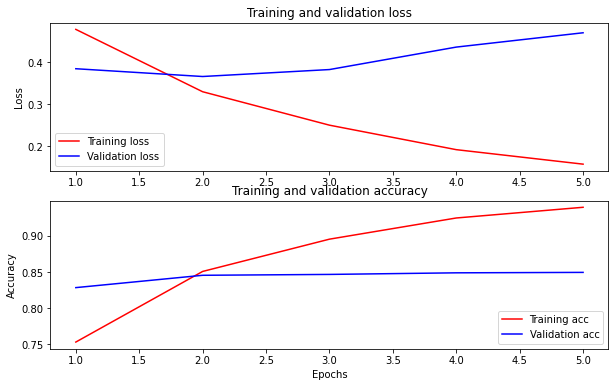

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

2022-02-11 12:34:20.112469: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999168
input: The movie was great!           : score: 0.989037
input: The movie was meh.             : score: 0.928559
input: The movie was okish.           : score: 0.069748
input: The movie was terrible...      : score: 0.001702

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999168
input: The movie was great!           : score: 0.989037
input: The movie was meh.             : score: 0.928559
input: The movie was okish.           : score: 0.069748
input: The movie was terrible...      : score: 0.001702



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999168
input: The movie was great!           : score: 0.989037
input: The movie was meh.             : score: 0.928559
input: The movie was okish.           : score: 0.069748
input: The movie was terrible...      : score: 0.001702



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.